# Toy Regression

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

## Cubic

20 data points simulated as follows:

- x sampled from $\mathcal{U}(-4,4)$
- y sampled from $\mathcal{N}(x^3,3^2)$

In [2]:
np.random.seed(42)
torch.manual_seed(42)

x, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
val, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
y = torch.normal(x**3,3)
val_label = torch.normal(val**3,3)
grid = np.linspace(-6,6,400).reshape(-1,1)
y_true = (grid ** 3).reshape(-1,1)

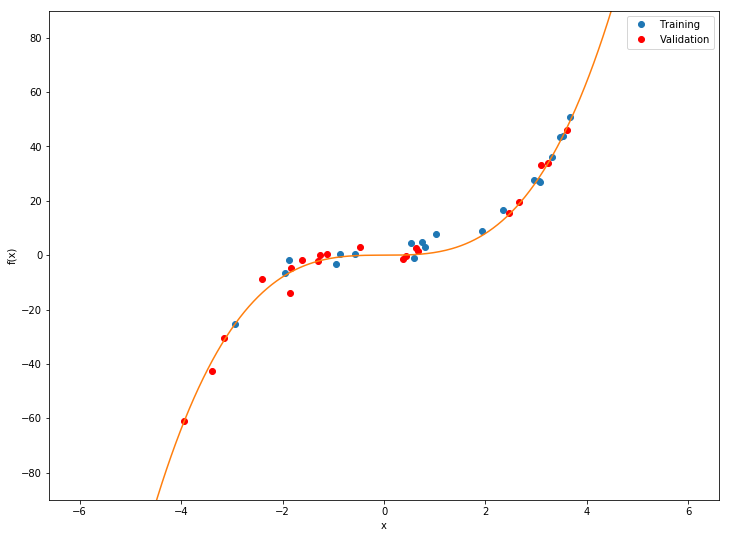

In [3]:
plt.figure(figsize=(12,9))
plt.plot(x.numpy(),y.numpy(),'o',label='Training')
plt.plot(val.numpy(),val_label.numpy(),'o',color='red',label='Validation')
plt.plot(grid,y_true)
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(1, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

### SGLD

In [59]:
import torch

from torch import nn
import torch.nn.functional as F
import numpy as np

import sgld


np.random.seed(42)
torch.manual_seed(42)



lambda_ = 1.
#lr = 1e-6
# learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [9e-4, 8e-4, 7e-4, 6e-4, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4, 9e-5, 8e-5, 7e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
# learning_rates = [6e-5]
# learning_rates = [1e-4]
# learning_rates = [9e-7]
learning_rates = [2e-4]

# grid_search = True
grid_search = False



batch_size = 20
dataset_size = 20

rmse_result = np.zeros((1,len(learning_rates)))

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)


for i, lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    predictions = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1) 
    t = 1.

    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1/(2*9)) * criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size
        
        

        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions = torch.cat((predictions, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 622.1237
Epoch 1 - loss: 604.8027
Epoch 2 - loss: 596.1577
Epoch 3 - loss: 575.7365
Epoch 4 - loss: 557.3633
Epoch 5 - loss: 538.6690
Epoch 6 - loss: 527.7430
Epoch 7 - loss: 507.5471
Epoch 8 - loss: 480.0516
Epoch 9 - loss: 461.5428
Epoch 10 - loss: 443.0961
Epoch 11 - loss: 421.1691
Epoch 12 - loss: 400.0916
Epoch 13 - loss: 371.1376
Epoch 14 - loss: 342.9705
Epoch 15 - loss: 305.3770
Epoch 16 - loss: 280.1088
Epoch 17 - loss: 238.3839
Epoch 18 - loss: 211.2379
Epoch 19 - loss: 194.4957
Epoch 20 - loss: 169.8835
Epoch 21 - loss: 150.5709
Epoch 22 - loss: 136.1560
Epoch 23 - loss: 124.4540
Epoch 24 - loss: 111.7995
Epoch 25 - loss: 105.8472
Epoch 26 - loss: 101.2017
Epoch 27 - loss: 98.7331
Epoch 28 - loss: 93.2938
Epoch 29 - loss: 89.6866
Epoch 30 - loss: 88.8827
Epoch 31 - loss: 87.6850
Epoch 32 - loss: 88.2314
Epoch 33 - loss: 87.0799
Epoch 34 - loss: 87.1301
Epoch 35 - loss: 84.1167
Epoch 36 - loss: 80.9963
Epoch 37 - loss: 80.5331
Epoch 38 - loss: 79.6231
Epoch 39

Epoch 371 - loss: 22.4633
Epoch 372 - loss: 23.1434
Epoch 373 - loss: 23.5437
Epoch 374 - loss: 22.6907
Epoch 375 - loss: 22.7838
Epoch 376 - loss: 23.6158
Epoch 377 - loss: 24.7496
Epoch 378 - loss: 26.2578
Epoch 379 - loss: 24.6319
Epoch 380 - loss: 27.9290
Epoch 381 - loss: 23.5046
Epoch 382 - loss: 24.2424
Epoch 383 - loss: 23.9574
Epoch 384 - loss: 22.7794
Epoch 385 - loss: 25.1216
Epoch 386 - loss: 21.8082
Epoch 387 - loss: 26.1415
Epoch 388 - loss: 21.5288
Epoch 389 - loss: 21.1013
Epoch 390 - loss: 19.6961
Epoch 391 - loss: 19.3900
Epoch 392 - loss: 18.9532
Epoch 393 - loss: 18.8213
Epoch 394 - loss: 18.8054
Epoch 395 - loss: 19.2600
Epoch 396 - loss: 20.9943
Epoch 397 - loss: 19.2141
Epoch 398 - loss: 19.7541
Epoch 399 - loss: 21.6584
Epoch 400 - loss: 20.9480
Epoch 401 - loss: 20.4935
Epoch 402 - loss: 20.6568
Epoch 403 - loss: 20.1092
Epoch 404 - loss: 23.9296
Epoch 405 - loss: 18.9695
Epoch 406 - loss: 20.4385
Epoch 407 - loss: 19.9196
Epoch 408 - loss: 18.6905
Epoch 409 - 

Epoch 704 - loss: 12.2072
Epoch 705 - loss: 15.5850
Epoch 706 - loss: 15.4860
Epoch 707 - loss: 19.0299
Epoch 708 - loss: 20.9042
Epoch 709 - loss: 15.5569
Epoch 710 - loss: 20.3513
Epoch 711 - loss: 28.7817
Epoch 712 - loss: 47.5036
Epoch 713 - loss: 41.9696
Epoch 714 - loss: 47.8724
Epoch 715 - loss: 39.6520
Epoch 716 - loss: 40.1509
Epoch 717 - loss: 64.0665
Epoch 718 - loss: 33.4570
Epoch 719 - loss: 38.1239
Epoch 720 - loss: 34.9188
Epoch 721 - loss: 43.1290
Epoch 722 - loss: 29.5452
Epoch 723 - loss: 19.4194
Epoch 724 - loss: 23.2021
Epoch 725 - loss: 24.4785
Epoch 726 - loss: 22.5752
Epoch 727 - loss: 20.4976
Epoch 728 - loss: 17.3282
Epoch 729 - loss: 21.9023
Epoch 730 - loss: 17.7089
Epoch 731 - loss: 16.5246
Epoch 732 - loss: 12.4645
Epoch 733 - loss: 11.9922
Epoch 734 - loss: 13.7390
Epoch 735 - loss: 25.0048
Epoch 736 - loss: 16.1351
Epoch 737 - loss: 15.0679
Epoch 738 - loss: 17.6005
Epoch 739 - loss: 23.3095
Epoch 740 - loss: 25.0880
Epoch 741 - loss: 37.7607
Epoch 742 - 

Epoch 1044 - loss: 23.5855
Epoch 1045 - loss: 14.6794
Epoch 1046 - loss: 16.7667
Epoch 1047 - loss: 11.3664
Epoch 1048 - loss: 9.0879
Epoch 1049 - loss: 8.6913
Epoch 1050 - loss: 9.8470
Epoch 1051 - loss: 10.7565
Epoch 1052 - loss: 16.7746
Epoch 1053 - loss: 20.1239
Epoch 1054 - loss: 22.1482
Epoch 1055 - loss: 20.5012
Epoch 1056 - loss: 13.4188
Epoch 1057 - loss: 12.8980
Epoch 1058 - loss: 13.1866
Epoch 1059 - loss: 17.8509
Epoch 1060 - loss: 22.3561
Epoch 1061 - loss: 19.4486
Epoch 1062 - loss: 23.0965
Epoch 1063 - loss: 38.4807
Epoch 1064 - loss: 57.0646
Epoch 1065 - loss: 92.8822
Epoch 1066 - loss: 83.6017
Epoch 1067 - loss: 142.0858
Epoch 1068 - loss: 87.9779
Epoch 1069 - loss: 78.3611
Epoch 1070 - loss: 29.0662
Epoch 1071 - loss: 23.3053
Epoch 1072 - loss: 29.6831
Epoch 1073 - loss: 25.5998
Epoch 1074 - loss: 16.3411
Epoch 1075 - loss: 11.5583
Epoch 1076 - loss: 15.7186
Epoch 1077 - loss: 22.6090
Epoch 1078 - loss: 13.5141
Epoch 1079 - loss: 10.7302
Epoch 1080 - loss: 12.1048
Epo

Epoch 1385 - loss: 58.3686
Epoch 1386 - loss: 84.3042
Epoch 1387 - loss: 62.5386
Epoch 1388 - loss: 74.1043
Epoch 1389 - loss: 48.8205
Epoch 1390 - loss: 47.5838
Epoch 1391 - loss: 28.1131
Epoch 1392 - loss: 25.7032
Epoch 1393 - loss: 27.1589
Epoch 1394 - loss: 45.3007
Epoch 1395 - loss: 47.9338
Epoch 1396 - loss: 57.1612
Epoch 1397 - loss: 37.9141
Epoch 1398 - loss: 37.0829
Epoch 1399 - loss: 40.1453
Epoch 1400 - loss: 26.3667
Epoch 1401 - loss: 28.1892
Epoch 1402 - loss: 29.6547
Epoch 1403 - loss: 18.2011
Epoch 1404 - loss: 24.7850
Epoch 1405 - loss: 11.3018
Epoch 1406 - loss: 7.7828
Epoch 1407 - loss: 10.6449
Epoch 1408 - loss: 10.0264
Epoch 1409 - loss: 13.4721
Epoch 1410 - loss: 17.6461
Epoch 1411 - loss: 9.8073
Epoch 1412 - loss: 10.3802
Epoch 1413 - loss: 20.6532
Epoch 1414 - loss: 27.0409
Epoch 1415 - loss: 81.2194
Epoch 1416 - loss: 120.5568
Epoch 1417 - loss: 40.2732
Epoch 1418 - loss: 22.7132
Epoch 1419 - loss: 9.3600
Epoch 1420 - loss: 10.1958
Epoch 1421 - loss: 7.4624
Epoc

Epoch 1699 - loss: 50.2659
Epoch 1700 - loss: 61.5365
Epoch 1701 - loss: 107.3769
Epoch 1702 - loss: 73.2359
Epoch 1703 - loss: 86.2239
Epoch 1704 - loss: 55.4484
Epoch 1705 - loss: 44.6713
Epoch 1706 - loss: 26.1857
Epoch 1707 - loss: 30.7821
Epoch 1708 - loss: 20.9931
Epoch 1709 - loss: 11.6904
Epoch 1710 - loss: 13.6656
Epoch 1711 - loss: 10.5652
Epoch 1712 - loss: 10.2795
Epoch 1713 - loss: 8.8224
Epoch 1714 - loss: 9.4887
Epoch 1715 - loss: 7.0263
Epoch 1716 - loss: 11.7724
Epoch 1717 - loss: 10.2667
Epoch 1718 - loss: 18.3921
Epoch 1719 - loss: 11.3149
Epoch 1720 - loss: 16.6912
Epoch 1721 - loss: 23.8887
Epoch 1722 - loss: 41.6515
Epoch 1723 - loss: 66.4758
Epoch 1724 - loss: 91.9902
Epoch 1725 - loss: 64.7210
Epoch 1726 - loss: 70.4414
Epoch 1727 - loss: 44.8582
Epoch 1728 - loss: 29.6518
Epoch 1729 - loss: 32.2585
Epoch 1730 - loss: 16.5222
Epoch 1731 - loss: 18.4718
Epoch 1732 - loss: 15.1638
Epoch 1733 - loss: 11.2359
Epoch 1734 - loss: 18.2546
Epoch 1735 - loss: 16.1255
Epo

Epoch 2038 - loss: 20.5139
Epoch 2039 - loss: 13.2691
Epoch 2040 - loss: 14.9640
Epoch 2041 - loss: 13.0760
Epoch 2042 - loss: 11.0230
Epoch 2043 - loss: 14.8019
Epoch 2044 - loss: 11.8159
Epoch 2045 - loss: 12.0324
Epoch 2046 - loss: 11.8520
Epoch 2047 - loss: 10.6419
Epoch 2048 - loss: 9.8883
Epoch 2049 - loss: 10.4304
Epoch 2050 - loss: 12.9231
Epoch 2051 - loss: 16.9998
Epoch 2052 - loss: 21.1573
Epoch 2053 - loss: 14.0366
Epoch 2054 - loss: 9.4984
Epoch 2055 - loss: 8.8223
Epoch 2056 - loss: 13.5904
Epoch 2057 - loss: 17.0184
Epoch 2058 - loss: 12.6637
Epoch 2059 - loss: 16.5315
Epoch 2060 - loss: 12.3482
Epoch 2061 - loss: 19.1933
Epoch 2062 - loss: 9.2798
Epoch 2063 - loss: 9.5405
Epoch 2064 - loss: 11.7104
Epoch 2065 - loss: 10.4050
Epoch 2066 - loss: 20.8846
Epoch 2067 - loss: 17.5824
Epoch 2068 - loss: 11.6878
Epoch 2069 - loss: 11.5893
Epoch 2070 - loss: 25.1654
Epoch 2071 - loss: 38.8882
Epoch 2072 - loss: 56.5713
Epoch 2073 - loss: 68.5664
Epoch 2074 - loss: 78.0737
Epoch 

Epoch 2380 - loss: 36.9763
Epoch 2381 - loss: 34.6123
Epoch 2382 - loss: 19.6737
Epoch 2383 - loss: 15.3845
Epoch 2384 - loss: 24.1238
Epoch 2385 - loss: 20.5254
Epoch 2386 - loss: 25.6236
Epoch 2387 - loss: 45.6872
Epoch 2388 - loss: 34.9759
Epoch 2389 - loss: 20.2266
Epoch 2390 - loss: 17.6413
Epoch 2391 - loss: 17.3972
Epoch 2392 - loss: 29.3845
Epoch 2393 - loss: 14.6831
Epoch 2394 - loss: 9.9865
Epoch 2395 - loss: 16.5460
Epoch 2396 - loss: 11.8620
Epoch 2397 - loss: 25.8903
Epoch 2398 - loss: 39.2149
Epoch 2399 - loss: 25.1776
Epoch 2400 - loss: 17.8382
Epoch 2401 - loss: 15.8339
Epoch 2402 - loss: 21.0045
Epoch 2403 - loss: 18.2361
Epoch 2404 - loss: 43.4288
Epoch 2405 - loss: 71.2753
Epoch 2406 - loss: 70.1680
Epoch 2407 - loss: 47.2401
Epoch 2408 - loss: 71.1522
Epoch 2409 - loss: 52.3661
Epoch 2410 - loss: 37.1783
Epoch 2411 - loss: 41.1567
Epoch 2412 - loss: 21.5064
Epoch 2413 - loss: 16.3507
Epoch 2414 - loss: 16.5988
Epoch 2415 - loss: 14.7654
Epoch 2416 - loss: 15.0410
Ep

Epoch 2699 - loss: 18.7973
Epoch 2700 - loss: 15.6252
Epoch 2701 - loss: 22.5730
Epoch 2702 - loss: 41.9591
Epoch 2703 - loss: 74.8611
Epoch 2704 - loss: 100.5964
Epoch 2705 - loss: 138.7277
Epoch 2706 - loss: 87.1653
Epoch 2707 - loss: 79.2133
Epoch 2708 - loss: 41.5398
Epoch 2709 - loss: 18.2358
Epoch 2710 - loss: 13.0608
Epoch 2711 - loss: 11.1363
Epoch 2712 - loss: 9.1373
Epoch 2713 - loss: 9.1013
Epoch 2714 - loss: 7.9216
Epoch 2715 - loss: 10.3157
Epoch 2716 - loss: 21.2040
Epoch 2717 - loss: 16.3786
Epoch 2718 - loss: 20.8071
Epoch 2719 - loss: 32.2003
Epoch 2720 - loss: 41.2210
Epoch 2721 - loss: 68.8042
Epoch 2722 - loss: 54.4708
Epoch 2723 - loss: 101.8556
Epoch 2724 - loss: 31.7164
Epoch 2725 - loss: 14.0854
Epoch 2726 - loss: 10.5621
Epoch 2727 - loss: 12.8533
Epoch 2728 - loss: 13.6624
Epoch 2729 - loss: 10.4525
Epoch 2730 - loss: 13.2280
Epoch 2731 - loss: 13.8363
Epoch 2732 - loss: 11.5312
Epoch 2733 - loss: 9.6933
Epoch 2734 - loss: 9.1426
Epoch 2735 - loss: 11.6612
Epo

Epoch 3044 - loss: 7.7755
Epoch 3045 - loss: 7.9623
Epoch 3046 - loss: 7.4060
Epoch 3047 - loss: 9.3772
Epoch 3048 - loss: 6.6853
Epoch 3049 - loss: 8.0554
Epoch 3050 - loss: 9.2160
Epoch 3051 - loss: 6.6177
Epoch 3052 - loss: 7.1847
Epoch 3053 - loss: 8.0023
Epoch 3054 - loss: 8.8379
Epoch 3055 - loss: 7.1643
Epoch 3056 - loss: 13.0625
Epoch 3057 - loss: 6.3975
Epoch 3058 - loss: 7.6202
Epoch 3059 - loss: 6.8510
Epoch 3060 - loss: 7.7708
Epoch 3061 - loss: 6.8253
Epoch 3062 - loss: 6.4407
Epoch 3063 - loss: 8.1102
Epoch 3064 - loss: 8.0414
Epoch 3065 - loss: 9.2070
Epoch 3066 - loss: 6.6335
Epoch 3067 - loss: 7.2917
Epoch 3068 - loss: 7.7777
Epoch 3069 - loss: 9.2306
Epoch 3070 - loss: 9.0056
Epoch 3071 - loss: 7.7322
Epoch 3072 - loss: 9.0905
Epoch 3073 - loss: 9.7890
Epoch 3074 - loss: 7.9791
Epoch 3075 - loss: 8.2583
Epoch 3076 - loss: 9.6956
Epoch 3077 - loss: 9.3247
Epoch 3078 - loss: 8.5795
Epoch 3079 - loss: 9.5718
Epoch 3080 - loss: 10.0059
Epoch 3081 - loss: 10.2614
Epoch 308

Epoch 3384 - loss: 15.0609
Epoch 3385 - loss: 10.5798
Epoch 3386 - loss: 9.4995
Epoch 3387 - loss: 14.5910
Epoch 3388 - loss: 9.0287
Epoch 3389 - loss: 5.9685
Epoch 3390 - loss: 5.6587
Epoch 3391 - loss: 8.3114
Epoch 3392 - loss: 5.8393
Epoch 3393 - loss: 7.2543
Epoch 3394 - loss: 6.7651
Epoch 3395 - loss: 8.1739
Epoch 3396 - loss: 5.4447
Epoch 3397 - loss: 5.5931
Epoch 3398 - loss: 14.2482
Epoch 3399 - loss: 8.2973
Epoch 3400 - loss: 4.9526
Epoch 3401 - loss: 5.8073
Epoch 3402 - loss: 4.6152
Epoch 3403 - loss: 4.4398
Epoch 3404 - loss: 8.4649
Epoch 3405 - loss: 6.2355
Epoch 3406 - loss: 9.3050
Epoch 3407 - loss: 6.7212
Epoch 3408 - loss: 10.5615
Epoch 3409 - loss: 6.0684
Epoch 3410 - loss: 7.4361
Epoch 3411 - loss: 16.7218
Epoch 3412 - loss: 8.5506
Epoch 3413 - loss: 7.4837
Epoch 3414 - loss: 11.0225
Epoch 3415 - loss: 7.6203
Epoch 3416 - loss: 6.3436
Epoch 3417 - loss: 5.7531
Epoch 3418 - loss: 6.6844
Epoch 3419 - loss: 8.5058
Epoch 3420 - loss: 7.6822
Epoch 3421 - loss: 13.3719
Epoc

Epoch 3756 - loss: 10.7043
Epoch 3757 - loss: 10.7450
Epoch 3758 - loss: 10.9648
Epoch 3759 - loss: 10.7794
Epoch 3760 - loss: 8.9817
Epoch 3761 - loss: 10.5739
Epoch 3762 - loss: 7.9838
Epoch 3763 - loss: 12.6078
Epoch 3764 - loss: 8.7283
Epoch 3765 - loss: 10.5011
Epoch 3766 - loss: 12.3022
Epoch 3767 - loss: 9.7050
Epoch 3768 - loss: 8.6457
Epoch 3769 - loss: 14.4050
Epoch 3770 - loss: 8.3002
Epoch 3771 - loss: 10.9607
Epoch 3772 - loss: 8.0125
Epoch 3773 - loss: 17.0048
Epoch 3774 - loss: 14.4664
Epoch 3775 - loss: 10.2136
Epoch 3776 - loss: 10.7540
Epoch 3777 - loss: 9.5694
Epoch 3778 - loss: 10.6668
Epoch 3779 - loss: 9.7647
Epoch 3780 - loss: 9.7618
Epoch 3781 - loss: 9.7412
Epoch 3782 - loss: 11.8236
Epoch 3783 - loss: 9.6388
Epoch 3784 - loss: 9.2007
Epoch 3785 - loss: 9.6746
Epoch 3786 - loss: 10.9398
Epoch 3787 - loss: 20.2595
Epoch 3788 - loss: 24.2141
Epoch 3789 - loss: 55.9475
Epoch 3790 - loss: 80.1393
Epoch 3791 - loss: 87.3335
Epoch 3792 - loss: 50.2868
Epoch 3793 - lo

Epoch 4085 - loss: 13.0060
Epoch 4086 - loss: 11.8189
Epoch 4087 - loss: 9.7127
Epoch 4088 - loss: 8.7480
Epoch 4089 - loss: 8.4673
Epoch 4090 - loss: 11.9436
Epoch 4091 - loss: 14.0763
Epoch 4092 - loss: 14.2617
Epoch 4093 - loss: 18.9480
Epoch 4094 - loss: 23.6428
Epoch 4095 - loss: 23.4674
Epoch 4096 - loss: 19.0920
Epoch 4097 - loss: 32.1806
Epoch 4098 - loss: 32.6351
Epoch 4099 - loss: 22.5646
Epoch 4100 - loss: 18.4888
Epoch 4101 - loss: 19.2507
Epoch 4102 - loss: 16.8603
Epoch 4103 - loss: 20.2999
Epoch 4104 - loss: 18.1762
Epoch 4105 - loss: 18.6201
Epoch 4106 - loss: 31.6948
Epoch 4107 - loss: 26.4555
Epoch 4108 - loss: 24.3035
Epoch 4109 - loss: 20.1271
Epoch 4110 - loss: 14.4623
Epoch 4111 - loss: 12.3902
Epoch 4112 - loss: 17.6273
Epoch 4113 - loss: 19.7919
Epoch 4114 - loss: 9.6759
Epoch 4115 - loss: 13.5308
Epoch 4116 - loss: 15.9666
Epoch 4117 - loss: 15.7458
Epoch 4118 - loss: 22.7902
Epoch 4119 - loss: 16.1737
Epoch 4120 - loss: 16.9732
Epoch 4121 - loss: 10.7421
Epoch

Epoch 4446 - loss: 12.1473
Epoch 4447 - loss: 13.1084
Epoch 4448 - loss: 14.7384
Epoch 4449 - loss: 15.1912
Epoch 4450 - loss: 11.3076
Epoch 4451 - loss: 13.9846
Epoch 4452 - loss: 7.1780
Epoch 4453 - loss: 8.3080
Epoch 4454 - loss: 6.9862
Epoch 4455 - loss: 10.9187
Epoch 4456 - loss: 6.1159
Epoch 4457 - loss: 8.1053
Epoch 4458 - loss: 7.7042
Epoch 4459 - loss: 8.1895
Epoch 4460 - loss: 8.8640
Epoch 4461 - loss: 12.6224
Epoch 4462 - loss: 8.9395
Epoch 4463 - loss: 6.7943
Epoch 4464 - loss: 9.1922
Epoch 4465 - loss: 10.2853
Epoch 4466 - loss: 24.0100
Epoch 4467 - loss: 27.8457
Epoch 4468 - loss: 11.6944
Epoch 4469 - loss: 12.0938
Epoch 4470 - loss: 7.4267
Epoch 4471 - loss: 9.5526
Epoch 4472 - loss: 10.0271
Epoch 4473 - loss: 9.2925
Epoch 4474 - loss: 7.9399
Epoch 4475 - loss: 15.4069
Epoch 4476 - loss: 20.2007
Epoch 4477 - loss: 24.8639
Epoch 4478 - loss: 11.4402
Epoch 4479 - loss: 11.9901
Epoch 4480 - loss: 20.4627
Epoch 4481 - loss: 9.3265
Epoch 4482 - loss: 7.5819
Epoch 4483 - loss:

Epoch 4789 - loss: 11.4177
Epoch 4790 - loss: 8.7419
Epoch 4791 - loss: 9.9161
Epoch 4792 - loss: 8.4656
Epoch 4793 - loss: 6.7531
Epoch 4794 - loss: 8.8781
Epoch 4795 - loss: 7.5187
Epoch 4796 - loss: 7.2607
Epoch 4797 - loss: 10.8551
Epoch 4798 - loss: 12.7335
Epoch 4799 - loss: 17.2374
Epoch 4800 - loss: 8.8349
Epoch 4801 - loss: 14.4036
Epoch 4802 - loss: 18.8136
Epoch 4803 - loss: 10.2365
Epoch 4804 - loss: 11.3391
Epoch 4805 - loss: 14.4171
Epoch 4806 - loss: 9.1312
Epoch 4807 - loss: 10.9173
Epoch 4808 - loss: 7.7456
Epoch 4809 - loss: 8.4582
Epoch 4810 - loss: 9.3935
Epoch 4811 - loss: 7.1733
Epoch 4812 - loss: 7.2396
Epoch 4813 - loss: 6.2722
Epoch 4814 - loss: 11.0046
Epoch 4815 - loss: 7.1761
Epoch 4816 - loss: 15.7005
Epoch 4817 - loss: 7.5674
Epoch 4818 - loss: 7.4558
Epoch 4819 - loss: 6.8281
Epoch 4820 - loss: 7.0224
Epoch 4821 - loss: 11.4923
Epoch 4822 - loss: 12.8784
Epoch 4823 - loss: 8.8598
Epoch 4824 - loss: 6.4903
Epoch 4825 - loss: 13.4638
Epoch 4826 - loss: 20.6

Epoch 5149 - loss: 5.0829
Epoch 5150 - loss: 9.9501
Epoch 5151 - loss: 13.1744
Epoch 5152 - loss: 7.5293
Epoch 5153 - loss: 10.2521
Epoch 5154 - loss: 5.4016
Epoch 5155 - loss: 8.7434
Epoch 5156 - loss: 9.2248
Epoch 5157 - loss: 12.5081
Epoch 5158 - loss: 10.5110
Epoch 5159 - loss: 16.5136
Epoch 5160 - loss: 29.0516
Epoch 5161 - loss: 31.6280
Epoch 5162 - loss: 30.3574
Epoch 5163 - loss: 31.0985
Epoch 5164 - loss: 25.1615
Epoch 5165 - loss: 32.8636
Epoch 5166 - loss: 34.4791
Epoch 5167 - loss: 32.9080
Epoch 5168 - loss: 29.5610
Epoch 5169 - loss: 17.7795
Epoch 5170 - loss: 18.9959
Epoch 5171 - loss: 26.0519
Epoch 5172 - loss: 34.4891
Epoch 5173 - loss: 36.5479
Epoch 5174 - loss: 24.7213
Epoch 5175 - loss: 16.3028
Epoch 5176 - loss: 18.0778
Epoch 5177 - loss: 14.9353
Epoch 5178 - loss: 29.1480
Epoch 5179 - loss: 43.4214
Epoch 5180 - loss: 28.4601
Epoch 5181 - loss: 51.0362
Epoch 5182 - loss: 67.3109
Epoch 5183 - loss: 38.5684
Epoch 5184 - loss: 22.5143
Epoch 5185 - loss: 11.8996
Epoch 5

Epoch 5460 - loss: 64.1611
Epoch 5461 - loss: 69.1646
Epoch 5462 - loss: 51.8318
Epoch 5463 - loss: 26.4191
Epoch 5464 - loss: 15.6981
Epoch 5465 - loss: 12.7826
Epoch 5466 - loss: 7.2363
Epoch 5467 - loss: 7.4919
Epoch 5468 - loss: 9.2878
Epoch 5469 - loss: 6.9090
Epoch 5470 - loss: 7.0320
Epoch 5471 - loss: 8.9889
Epoch 5472 - loss: 7.8477
Epoch 5473 - loss: 7.5421
Epoch 5474 - loss: 6.1992
Epoch 5475 - loss: 7.8689
Epoch 5476 - loss: 7.6058
Epoch 5477 - loss: 6.4247
Epoch 5478 - loss: 6.3594
Epoch 5479 - loss: 9.2695
Epoch 5480 - loss: 15.0194
Epoch 5481 - loss: 34.2673
Epoch 5482 - loss: 86.6332
Epoch 5483 - loss: 144.8349
Epoch 5484 - loss: 169.4803
Epoch 5485 - loss: 174.6072
Epoch 5486 - loss: 102.4542
Epoch 5487 - loss: 63.5820
Epoch 5488 - loss: 51.5393
Epoch 5489 - loss: 42.4979
Epoch 5490 - loss: 25.4340
Epoch 5491 - loss: 11.2465
Epoch 5492 - loss: 15.1558
Epoch 5493 - loss: 12.0034
Epoch 5494 - loss: 9.4387
Epoch 5495 - loss: 11.4113
Epoch 5496 - loss: 9.5238
Epoch 5497 - 

Epoch 5842 - loss: 13.3257
Epoch 5843 - loss: 10.8348
Epoch 5844 - loss: 15.7005
Epoch 5845 - loss: 8.9325
Epoch 5846 - loss: 5.5885
Epoch 5847 - loss: 6.5615
Epoch 5848 - loss: 4.5470
Epoch 5849 - loss: 5.5229
Epoch 5850 - loss: 10.2443
Epoch 5851 - loss: 7.5257
Epoch 5852 - loss: 7.6141
Epoch 5853 - loss: 9.5884
Epoch 5854 - loss: 5.2180
Epoch 5855 - loss: 5.8394
Epoch 5856 - loss: 5.6817
Epoch 5857 - loss: 6.7192
Epoch 5858 - loss: 7.9893
Epoch 5859 - loss: 21.2357
Epoch 5860 - loss: 11.5990
Epoch 5861 - loss: 15.0294
Epoch 5862 - loss: 8.6644
Epoch 5863 - loss: 5.4469
Epoch 5864 - loss: 6.4235
Epoch 5865 - loss: 6.6443
Epoch 5866 - loss: 8.6137
Epoch 5867 - loss: 14.2310
Epoch 5868 - loss: 9.0519
Epoch 5869 - loss: 13.3641
Epoch 5870 - loss: 20.3501
Epoch 5871 - loss: 22.7594
Epoch 5872 - loss: 26.9429
Epoch 5873 - loss: 22.9726
Epoch 5874 - loss: 31.7070
Epoch 5875 - loss: 24.0507
Epoch 5876 - loss: 28.4618
Epoch 5877 - loss: 26.7030
Epoch 5878 - loss: 25.1190
Epoch 5879 - loss: 7

Epoch 6206 - loss: 5.9608
Epoch 6207 - loss: 5.7130
Epoch 6208 - loss: 5.7219
Epoch 6209 - loss: 8.4214
Epoch 6210 - loss: 8.8971
Epoch 6211 - loss: 6.2692
Epoch 6212 - loss: 8.5297
Epoch 6213 - loss: 7.2976
Epoch 6214 - loss: 6.0393
Epoch 6215 - loss: 7.4487
Epoch 6216 - loss: 5.5361
Epoch 6217 - loss: 5.1966
Epoch 6218 - loss: 11.4611
Epoch 6219 - loss: 7.2325
Epoch 6220 - loss: 8.6721
Epoch 6221 - loss: 8.8125
Epoch 6222 - loss: 6.1461
Epoch 6223 - loss: 7.2781
Epoch 6224 - loss: 8.7086
Epoch 6225 - loss: 6.7327
Epoch 6226 - loss: 6.0958
Epoch 6227 - loss: 6.0675
Epoch 6228 - loss: 7.2663
Epoch 6229 - loss: 6.4745
Epoch 6230 - loss: 6.9779
Epoch 6231 - loss: 7.0810
Epoch 6232 - loss: 7.0157
Epoch 6233 - loss: 5.9853
Epoch 6234 - loss: 9.9375
Epoch 6235 - loss: 8.9730
Epoch 6236 - loss: 8.6280
Epoch 6237 - loss: 8.1392
Epoch 6238 - loss: 10.7660
Epoch 6239 - loss: 9.5928
Epoch 6240 - loss: 7.1682
Epoch 6241 - loss: 7.2199
Epoch 6242 - loss: 7.1148
Epoch 6243 - loss: 7.3273
Epoch 6244

Epoch 6560 - loss: 8.5562
Epoch 6561 - loss: 9.8830
Epoch 6562 - loss: 7.8530
Epoch 6563 - loss: 7.9971
Epoch 6564 - loss: 8.2820
Epoch 6565 - loss: 7.1605
Epoch 6566 - loss: 8.1816
Epoch 6567 - loss: 7.8144
Epoch 6568 - loss: 9.9418
Epoch 6569 - loss: 7.4604
Epoch 6570 - loss: 6.6301
Epoch 6571 - loss: 8.0801
Epoch 6572 - loss: 7.3143
Epoch 6573 - loss: 7.2331
Epoch 6574 - loss: 9.0655
Epoch 6575 - loss: 11.1840
Epoch 6576 - loss: 9.8213
Epoch 6577 - loss: 9.4816
Epoch 6578 - loss: 8.6728
Epoch 6579 - loss: 8.4337
Epoch 6580 - loss: 9.6000
Epoch 6581 - loss: 9.8102
Epoch 6582 - loss: 10.1856
Epoch 6583 - loss: 9.1717
Epoch 6584 - loss: 12.0964
Epoch 6585 - loss: 12.1548
Epoch 6586 - loss: 14.3252
Epoch 6587 - loss: 11.4770
Epoch 6588 - loss: 9.9247
Epoch 6589 - loss: 10.8728
Epoch 6590 - loss: 10.3774
Epoch 6591 - loss: 10.6082
Epoch 6592 - loss: 10.9805
Epoch 6593 - loss: 12.8424
Epoch 6594 - loss: 11.4612
Epoch 6595 - loss: 12.1422
Epoch 6596 - loss: 12.5730
Epoch 6597 - loss: 12.83

Epoch 6930 - loss: 8.1439
Epoch 6931 - loss: 9.1413
Epoch 6932 - loss: 9.2368
Epoch 6933 - loss: 11.3921
Epoch 6934 - loss: 10.5538
Epoch 6935 - loss: 9.6952
Epoch 6936 - loss: 11.4786
Epoch 6937 - loss: 9.4815
Epoch 6938 - loss: 8.5239
Epoch 6939 - loss: 10.7360
Epoch 6940 - loss: 9.9072
Epoch 6941 - loss: 9.4663
Epoch 6942 - loss: 8.0211
Epoch 6943 - loss: 7.3343
Epoch 6944 - loss: 8.5006
Epoch 6945 - loss: 9.1803
Epoch 6946 - loss: 7.7729
Epoch 6947 - loss: 7.3729
Epoch 6948 - loss: 7.6529
Epoch 6949 - loss: 8.1675
Epoch 6950 - loss: 7.0537
Epoch 6951 - loss: 8.1900
Epoch 6952 - loss: 7.0852
Epoch 6953 - loss: 13.7340
Epoch 6954 - loss: 8.6831
Epoch 6955 - loss: 9.0313
Epoch 6956 - loss: 8.0867
Epoch 6957 - loss: 7.8573
Epoch 6958 - loss: 7.9165
Epoch 6959 - loss: 7.8225
Epoch 6960 - loss: 9.9065
Epoch 6961 - loss: 10.3665
Epoch 6962 - loss: 10.8922
Epoch 6963 - loss: 6.6568
Epoch 6964 - loss: 6.9549
Epoch 6965 - loss: 12.6369
Epoch 6966 - loss: 7.3738
Epoch 6967 - loss: 6.0406
Epoc

Epoch 7297 - loss: 6.7856
Epoch 7298 - loss: 5.4597
Epoch 7299 - loss: 5.4008
Epoch 7300 - loss: 5.3712
Epoch 7301 - loss: 5.6873
Epoch 7302 - loss: 5.2014
Epoch 7303 - loss: 9.5037
Epoch 7304 - loss: 7.8889
Epoch 7305 - loss: 10.0798
Epoch 7306 - loss: 9.2347
Epoch 7307 - loss: 10.2425
Epoch 7308 - loss: 5.2495
Epoch 7309 - loss: 6.3705
Epoch 7310 - loss: 5.6292
Epoch 7311 - loss: 8.2587
Epoch 7312 - loss: 10.5261
Epoch 7313 - loss: 6.6721
Epoch 7314 - loss: 8.7444
Epoch 7315 - loss: 7.0302
Epoch 7316 - loss: 5.3220
Epoch 7317 - loss: 6.1199
Epoch 7318 - loss: 8.2968
Epoch 7319 - loss: 5.4696
Epoch 7320 - loss: 7.5392
Epoch 7321 - loss: 6.9859
Epoch 7322 - loss: 7.7715
Epoch 7323 - loss: 6.8267
Epoch 7324 - loss: 6.0299
Epoch 7325 - loss: 5.4581
Epoch 7326 - loss: 5.1805
Epoch 7327 - loss: 5.5521
Epoch 7328 - loss: 5.1139
Epoch 7329 - loss: 7.9627
Epoch 7330 - loss: 14.3546
Epoch 7331 - loss: 8.6457
Epoch 7332 - loss: 13.7778
Epoch 7333 - loss: 15.7212
Epoch 7334 - loss: 6.6106
Epoch 

Epoch 7645 - loss: 6.4183
Epoch 7646 - loss: 7.0240
Epoch 7647 - loss: 8.1208
Epoch 7648 - loss: 11.3038
Epoch 7649 - loss: 7.9909
Epoch 7650 - loss: 6.4521
Epoch 7651 - loss: 8.4393
Epoch 7652 - loss: 7.4433
Epoch 7653 - loss: 5.5135
Epoch 7654 - loss: 6.2588
Epoch 7655 - loss: 6.8981
Epoch 7656 - loss: 7.8914
Epoch 7657 - loss: 7.2923
Epoch 7658 - loss: 6.1155
Epoch 7659 - loss: 6.0288
Epoch 7660 - loss: 11.2288
Epoch 7661 - loss: 11.7793
Epoch 7662 - loss: 6.8263
Epoch 7663 - loss: 8.2189
Epoch 7664 - loss: 8.1538
Epoch 7665 - loss: 7.5406
Epoch 7666 - loss: 7.6331
Epoch 7667 - loss: 8.9198
Epoch 7668 - loss: 10.0250
Epoch 7669 - loss: 8.4589
Epoch 7670 - loss: 7.7571
Epoch 7671 - loss: 11.8875
Epoch 7672 - loss: 6.8895
Epoch 7673 - loss: 11.9422
Epoch 7674 - loss: 11.3806
Epoch 7675 - loss: 9.8544
Epoch 7676 - loss: 9.3962
Epoch 7677 - loss: 8.3061
Epoch 7678 - loss: 17.1297
Epoch 7679 - loss: 20.4572
Epoch 7680 - loss: 14.4139
Epoch 7681 - loss: 10.1754
Epoch 7682 - loss: 10.7634


Epoch 7988 - loss: 12.2841
Epoch 7989 - loss: 9.3324
Epoch 7990 - loss: 8.1999
Epoch 7991 - loss: 7.2252
Epoch 7992 - loss: 7.9179
Epoch 7993 - loss: 6.3672
Epoch 7994 - loss: 11.9089
Epoch 7995 - loss: 31.4001
Epoch 7996 - loss: 25.2775
Epoch 7997 - loss: 18.6076
Epoch 7998 - loss: 44.7257
Epoch 7999 - loss: 15.2660
Epoch 8000 - loss: 7.5122
Epoch 8001 - loss: 6.4554
Epoch 8002 - loss: 6.7159
Epoch 8003 - loss: 6.6660
Epoch 8004 - loss: 7.4919
Epoch 8005 - loss: 5.3716
Epoch 8006 - loss: 6.3656
Epoch 8007 - loss: 6.1809
Epoch 8008 - loss: 5.8543
Epoch 8009 - loss: 5.5654
Epoch 8010 - loss: 5.1965
Epoch 8011 - loss: 6.8467
Epoch 8012 - loss: 7.3570
Epoch 8013 - loss: 9.7816
Epoch 8014 - loss: 11.4652
Epoch 8015 - loss: 8.5639
Epoch 8016 - loss: 8.4634
Epoch 8017 - loss: 6.5642
Epoch 8018 - loss: 5.3005
Epoch 8019 - loss: 5.8880
Epoch 8020 - loss: 6.6496
Epoch 8021 - loss: 5.4352
Epoch 8022 - loss: 5.3578
Epoch 8023 - loss: 6.3291
Epoch 8024 - loss: 8.8059
Epoch 8025 - loss: 5.3476
Epoc

Epoch 8342 - loss: 33.4488
Epoch 8343 - loss: 24.0284
Epoch 8344 - loss: 19.4012
Epoch 8345 - loss: 21.9291
Epoch 8346 - loss: 16.0576
Epoch 8347 - loss: 15.6314
Epoch 8348 - loss: 13.8917
Epoch 8349 - loss: 11.0432
Epoch 8350 - loss: 9.4462
Epoch 8351 - loss: 10.7352
Epoch 8352 - loss: 9.7586
Epoch 8353 - loss: 10.6390
Epoch 8354 - loss: 8.8482
Epoch 8355 - loss: 9.6430
Epoch 8356 - loss: 8.2122
Epoch 8357 - loss: 9.2175
Epoch 8358 - loss: 10.9929
Epoch 8359 - loss: 12.3750
Epoch 8360 - loss: 7.3563
Epoch 8361 - loss: 8.4970
Epoch 8362 - loss: 17.7556
Epoch 8363 - loss: 11.6555
Epoch 8364 - loss: 8.4812
Epoch 8365 - loss: 9.5032
Epoch 8366 - loss: 7.6767
Epoch 8367 - loss: 7.8005
Epoch 8368 - loss: 8.8165
Epoch 8369 - loss: 9.6605
Epoch 8370 - loss: 9.7700
Epoch 8371 - loss: 12.7592
Epoch 8372 - loss: 13.0834
Epoch 8373 - loss: 15.3321
Epoch 8374 - loss: 14.3867
Epoch 8375 - loss: 11.8118
Epoch 8376 - loss: 21.0205
Epoch 8377 - loss: 32.6163
Epoch 8378 - loss: 31.3743
Epoch 8379 - los

Epoch 8685 - loss: 7.2305
Epoch 8686 - loss: 7.3413
Epoch 8687 - loss: 6.1064
Epoch 8688 - loss: 9.0878
Epoch 8689 - loss: 12.0629
Epoch 8690 - loss: 11.0543
Epoch 8691 - loss: 10.8635
Epoch 8692 - loss: 8.0296
Epoch 8693 - loss: 8.9150
Epoch 8694 - loss: 7.2552
Epoch 8695 - loss: 8.9213
Epoch 8696 - loss: 20.9700
Epoch 8697 - loss: 13.2295
Epoch 8698 - loss: 7.7025
Epoch 8699 - loss: 6.2880
Epoch 8700 - loss: 6.1864
Epoch 8701 - loss: 6.5111
Epoch 8702 - loss: 7.4049
Epoch 8703 - loss: 6.8075
Epoch 8704 - loss: 8.0941
Epoch 8705 - loss: 12.3164
Epoch 8706 - loss: 7.0958
Epoch 8707 - loss: 5.6832
Epoch 8708 - loss: 5.7809
Epoch 8709 - loss: 7.5558
Epoch 8710 - loss: 9.5522
Epoch 8711 - loss: 10.2831
Epoch 8712 - loss: 7.9410
Epoch 8713 - loss: 8.6976
Epoch 8714 - loss: 10.0344
Epoch 8715 - loss: 6.6038
Epoch 8716 - loss: 7.6286
Epoch 8717 - loss: 5.2166
Epoch 8718 - loss: 5.1363
Epoch 8719 - loss: 9.3926
Epoch 8720 - loss: 5.5976
Epoch 8721 - loss: 5.9604
Epoch 8722 - loss: 5.8566
Epoc

Epoch 9021 - loss: 5.9434
Epoch 9022 - loss: 4.9797
Epoch 9023 - loss: 4.9161
Epoch 9024 - loss: 5.6304
Epoch 9025 - loss: 7.6640
Epoch 9026 - loss: 6.4532
Epoch 9027 - loss: 5.0533
Epoch 9028 - loss: 5.0931
Epoch 9029 - loss: 5.9024
Epoch 9030 - loss: 5.1383
Epoch 9031 - loss: 5.5740
Epoch 9032 - loss: 5.7426
Epoch 9033 - loss: 6.6583
Epoch 9034 - loss: 5.4708
Epoch 9035 - loss: 5.1258
Epoch 9036 - loss: 4.8799
Epoch 9037 - loss: 4.5954
Epoch 9038 - loss: 4.3607
Epoch 9039 - loss: 4.7585
Epoch 9040 - loss: 4.4162
Epoch 9041 - loss: 7.3502
Epoch 9042 - loss: 4.5500
Epoch 9043 - loss: 4.7952
Epoch 9044 - loss: 5.1224
Epoch 9045 - loss: 4.4806
Epoch 9046 - loss: 5.0464
Epoch 9047 - loss: 7.5935
Epoch 9048 - loss: 6.9588
Epoch 9049 - loss: 5.5218
Epoch 9050 - loss: 4.7462
Epoch 9051 - loss: 5.9578
Epoch 9052 - loss: 4.6789
Epoch 9053 - loss: 4.8590
Epoch 9054 - loss: 6.3724
Epoch 9055 - loss: 4.4152
Epoch 9056 - loss: 4.4741
Epoch 9057 - loss: 4.7984
Epoch 9058 - loss: 5.4346
Epoch 9059 -

Epoch 9363 - loss: 8.9358
Epoch 9364 - loss: 9.8451
Epoch 9365 - loss: 9.0966
Epoch 9366 - loss: 8.6506
Epoch 9367 - loss: 8.1492
Epoch 9368 - loss: 8.1729
Epoch 9369 - loss: 8.0761
Epoch 9370 - loss: 7.6041
Epoch 9371 - loss: 9.9054
Epoch 9372 - loss: 7.9262
Epoch 9373 - loss: 8.8661
Epoch 9374 - loss: 8.5254
Epoch 9375 - loss: 7.5100
Epoch 9376 - loss: 9.3999
Epoch 9377 - loss: 9.2024
Epoch 9378 - loss: 7.9130
Epoch 9379 - loss: 7.2069
Epoch 9380 - loss: 8.2987
Epoch 9381 - loss: 7.2905
Epoch 9382 - loss: 7.3467
Epoch 9383 - loss: 7.8351
Epoch 9384 - loss: 8.8814
Epoch 9385 - loss: 7.6963
Epoch 9386 - loss: 7.9469
Epoch 9387 - loss: 6.9312
Epoch 9388 - loss: 7.7714
Epoch 9389 - loss: 7.4223
Epoch 9390 - loss: 7.0178
Epoch 9391 - loss: 7.6923
Epoch 9392 - loss: 7.2942
Epoch 9393 - loss: 7.8353
Epoch 9394 - loss: 9.6820
Epoch 9395 - loss: 7.9367
Epoch 9396 - loss: 7.7591
Epoch 9397 - loss: 7.5968
Epoch 9398 - loss: 7.1758
Epoch 9399 - loss: 6.9014
Epoch 9400 - loss: 6.5004
Epoch 9401 -

Epoch 9713 - loss: 4.6350
Epoch 9714 - loss: 6.0266
Epoch 9715 - loss: 5.0416
Epoch 9716 - loss: 5.4193
Epoch 9717 - loss: 7.0016
Epoch 9718 - loss: 4.7869
Epoch 9719 - loss: 4.3433
Epoch 9720 - loss: 6.4689
Epoch 9721 - loss: 4.1334
Epoch 9722 - loss: 4.4386
Epoch 9723 - loss: 4.4289
Epoch 9724 - loss: 5.8191
Epoch 9725 - loss: 5.0426
Epoch 9726 - loss: 6.8658
Epoch 9727 - loss: 4.7029
Epoch 9728 - loss: 4.3608
Epoch 9729 - loss: 4.4405
Epoch 9730 - loss: 4.5339
Epoch 9731 - loss: 5.7675
Epoch 9732 - loss: 5.8585
Epoch 9733 - loss: 4.2059
Epoch 9734 - loss: 4.5228
Epoch 9735 - loss: 7.4574
Epoch 9736 - loss: 10.9952
Epoch 9737 - loss: 4.8815
Epoch 9738 - loss: 5.0985
Epoch 9739 - loss: 6.2240
Epoch 9740 - loss: 6.0942
Epoch 9741 - loss: 7.2541
Epoch 9742 - loss: 5.1962
Epoch 9743 - loss: 4.7262
Epoch 9744 - loss: 5.6852
Epoch 9745 - loss: 4.8382
Epoch 9746 - loss: 6.3950
Epoch 9747 - loss: 5.0021
Epoch 9748 - loss: 6.5365
Epoch 9749 - loss: 5.3150
Epoch 9750 - loss: 4.9391
Epoch 9751 

In [12]:
rmse_result

array([[        nan,         nan,         nan,         nan,         nan,
        20.96614838, 26.28787804, 25.69990158, 31.69161415, 31.57193375,
        30.290411  , 29.82038498, 32.07549667, 43.57950592, 43.62040329,
        46.70010376, 53.18690491, 65.09934998]])

Text(0.5,1,'SGLD')

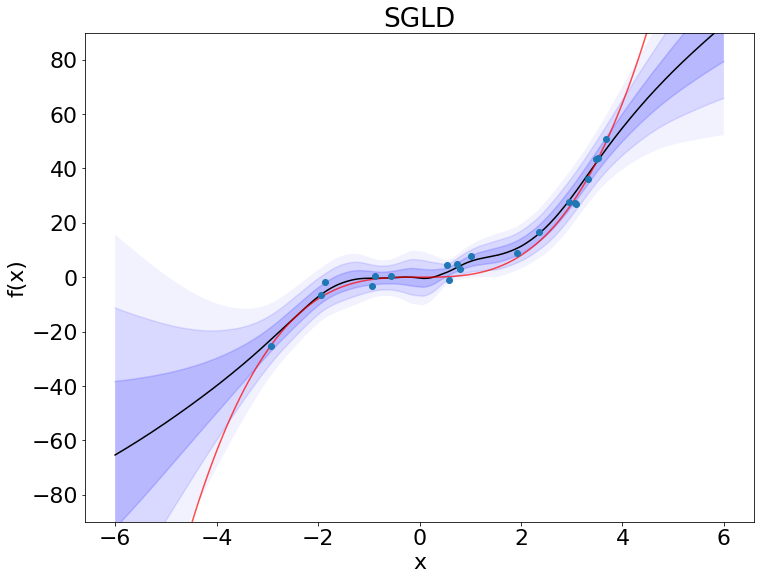

In [60]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions[:,1:].detach().numpy(),1) + 3 * np.std(predictions[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions[:,1:].detach().numpy(),1) - 3 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.15)
plt.plot(grid,lower2,'blue',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid.squeeze(),lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)

plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('SGLD')

### pSGLD

In [82]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld


lambda_ = 1.
lr = 6e-12
alpha = 0.99


batch_size = 20
dataset_size= 20



x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16]
# learning_rates = [9e-13, 8e-13, 7e-13, 6e-13, 5e-13, 4e-13, 3e-13, 2e-13, 1e-13, 9e-14, 8e-14, 7e-14, 6e-14, 5e-14, 4e-14, 3e-14, 2e-14, 1e-14]
# learning_rates = [2e-12]
# learning_rates = [8e-13]
# learning_rates = [2e-12]
learning_rates = [9e-13]

# grid_search = True
grid_search = False

rmse_result = np.zeros((1,len(learning_rates)))


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)
    predictions_psgld = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1)
    t = 1.
    
    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1./(2*9))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions_psgld = torch.cat((predictions_psgld, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 644.6793
Epoch 1 - loss: 644.6575
Epoch 2 - loss: 634.5838
Epoch 3 - loss: 631.6460
Epoch 4 - loss: 624.2659
Epoch 5 - loss: 618.5493
Epoch 6 - loss: 616.9665
Epoch 7 - loss: 614.9147
Epoch 8 - loss: 612.8280
Epoch 9 - loss: 606.8060
Epoch 10 - loss: 602.5926
Epoch 11 - loss: 601.8577
Epoch 12 - loss: 599.5249
Epoch 13 - loss: 593.2169
Epoch 14 - loss: 583.3130
Epoch 15 - loss: 580.0467
Epoch 16 - loss: 577.1921
Epoch 17 - loss: 573.0567
Epoch 18 - loss: 569.3241
Epoch 19 - loss: 562.1545
Epoch 20 - loss: 556.5670
Epoch 21 - loss: 551.8073
Epoch 22 - loss: 545.7502
Epoch 23 - loss: 540.3939
Epoch 24 - loss: 535.9686
Epoch 25 - loss: 528.3940
Epoch 26 - loss: 525.0766
Epoch 27 - loss: 521.0389
Epoch 28 - loss: 517.2224
Epoch 29 - loss: 513.9684
Epoch 30 - loss: 507.6602
Epoch 31 - loss: 499.8377
Epoch 32 - loss: 491.8460
Epoch 33 - loss: 481.3797
Epoch 34 - loss: 476.4879
Epoch 35 - loss: 472.2996
Epoch 36 - loss: 462.7398
Epoch 37 - loss: 455.8585
Epoch 38 - loss: 451.3

Epoch 319 - loss: 57.0910
Epoch 320 - loss: 56.9381
Epoch 321 - loss: 56.9882
Epoch 322 - loss: 57.3014
Epoch 323 - loss: 57.5943
Epoch 324 - loss: 56.8523
Epoch 325 - loss: 56.4810
Epoch 326 - loss: 56.4066
Epoch 327 - loss: 56.1120
Epoch 328 - loss: 57.2157
Epoch 329 - loss: 56.4601
Epoch 330 - loss: 56.1867
Epoch 331 - loss: 55.9546
Epoch 332 - loss: 56.7703
Epoch 333 - loss: 57.9167
Epoch 334 - loss: 56.8578
Epoch 335 - loss: 57.6548
Epoch 336 - loss: 56.6906
Epoch 337 - loss: 57.2374
Epoch 338 - loss: 56.6952
Epoch 339 - loss: 56.7029
Epoch 340 - loss: 56.2642
Epoch 341 - loss: 56.0583
Epoch 342 - loss: 56.1799
Epoch 343 - loss: 56.3417
Epoch 344 - loss: 56.5025
Epoch 345 - loss: 56.5523
Epoch 346 - loss: 56.8025
Epoch 347 - loss: 57.4415
Epoch 348 - loss: 57.3726
Epoch 349 - loss: 57.8035
Epoch 350 - loss: 57.6458
Epoch 351 - loss: 56.8765
Epoch 352 - loss: 56.8031
Epoch 353 - loss: 56.4667
Epoch 354 - loss: 56.1058
Epoch 355 - loss: 55.4528
Epoch 356 - loss: 55.8616
Epoch 357 - 

Epoch 698 - loss: 34.1412
Epoch 699 - loss: 34.2862
Epoch 700 - loss: 33.8108
Epoch 701 - loss: 33.5140
Epoch 702 - loss: 33.4542
Epoch 703 - loss: 35.4169
Epoch 704 - loss: 33.2043
Epoch 705 - loss: 33.7471
Epoch 706 - loss: 32.9563
Epoch 707 - loss: 35.6330
Epoch 708 - loss: 35.2764
Epoch 709 - loss: 34.5483
Epoch 710 - loss: 34.4952
Epoch 711 - loss: 34.5140
Epoch 712 - loss: 34.0559
Epoch 713 - loss: 33.7968
Epoch 714 - loss: 34.8797
Epoch 715 - loss: 35.8756
Epoch 716 - loss: 36.5957
Epoch 717 - loss: 36.3581
Epoch 718 - loss: 34.6229
Epoch 719 - loss: 35.8347
Epoch 720 - loss: 34.2885
Epoch 721 - loss: 35.0907
Epoch 722 - loss: 33.1795
Epoch 723 - loss: 32.3511
Epoch 724 - loss: 30.7984
Epoch 725 - loss: 30.5359
Epoch 726 - loss: 30.9862
Epoch 727 - loss: 30.4444
Epoch 728 - loss: 31.0464
Epoch 729 - loss: 30.3211
Epoch 730 - loss: 30.6015
Epoch 731 - loss: 30.1767
Epoch 732 - loss: 29.7014
Epoch 733 - loss: 30.3960
Epoch 734 - loss: 28.6858
Epoch 735 - loss: 30.7542
Epoch 736 - 

Epoch 1021 - loss: 23.5912
Epoch 1022 - loss: 23.4021
Epoch 1023 - loss: 24.2095
Epoch 1024 - loss: 25.3023
Epoch 1025 - loss: 25.1811
Epoch 1026 - loss: 25.4205
Epoch 1027 - loss: 23.3386
Epoch 1028 - loss: 23.7298
Epoch 1029 - loss: 23.5476
Epoch 1030 - loss: 24.0507
Epoch 1031 - loss: 23.4417
Epoch 1032 - loss: 23.1075
Epoch 1033 - loss: 25.1931
Epoch 1034 - loss: 24.0497
Epoch 1035 - loss: 23.7620
Epoch 1036 - loss: 23.4399
Epoch 1037 - loss: 23.0583
Epoch 1038 - loss: 22.6940
Epoch 1039 - loss: 22.3594
Epoch 1040 - loss: 22.3408
Epoch 1041 - loss: 22.4111
Epoch 1042 - loss: 23.7688
Epoch 1043 - loss: 26.0872
Epoch 1044 - loss: 23.4889
Epoch 1045 - loss: 24.3535
Epoch 1046 - loss: 24.8333
Epoch 1047 - loss: 25.3795
Epoch 1048 - loss: 27.1423
Epoch 1049 - loss: 30.0378
Epoch 1050 - loss: 27.9020
Epoch 1051 - loss: 28.2774
Epoch 1052 - loss: 26.2694
Epoch 1053 - loss: 25.7585
Epoch 1054 - loss: 25.8091
Epoch 1055 - loss: 26.2500
Epoch 1056 - loss: 25.4256
Epoch 1057 - loss: 23.8215
E

Epoch 1347 - loss: 15.9673
Epoch 1348 - loss: 14.0821
Epoch 1349 - loss: 13.3243
Epoch 1350 - loss: 12.5475
Epoch 1351 - loss: 13.3640
Epoch 1352 - loss: 13.2003
Epoch 1353 - loss: 15.6388
Epoch 1354 - loss: 13.4808
Epoch 1355 - loss: 12.0758
Epoch 1356 - loss: 11.6927
Epoch 1357 - loss: 12.1601
Epoch 1358 - loss: 12.5110
Epoch 1359 - loss: 12.0434
Epoch 1360 - loss: 12.0311
Epoch 1361 - loss: 13.0324
Epoch 1362 - loss: 11.9938
Epoch 1363 - loss: 11.8729
Epoch 1364 - loss: 13.4134
Epoch 1365 - loss: 13.9586
Epoch 1366 - loss: 14.7456
Epoch 1367 - loss: 14.8161
Epoch 1368 - loss: 15.7585
Epoch 1369 - loss: 16.7684
Epoch 1370 - loss: 14.3126
Epoch 1371 - loss: 15.0703
Epoch 1372 - loss: 14.6634
Epoch 1373 - loss: 14.3905
Epoch 1374 - loss: 13.1755
Epoch 1375 - loss: 13.5005
Epoch 1376 - loss: 16.1032
Epoch 1377 - loss: 13.8435
Epoch 1378 - loss: 12.6466
Epoch 1379 - loss: 12.7691
Epoch 1380 - loss: 11.6644
Epoch 1381 - loss: 12.4821
Epoch 1382 - loss: 12.4570
Epoch 1383 - loss: 11.9648
E

Epoch 1703 - loss: 10.9440
Epoch 1704 - loss: 12.9272
Epoch 1705 - loss: 12.3721
Epoch 1706 - loss: 12.0765
Epoch 1707 - loss: 11.9106
Epoch 1708 - loss: 11.0379
Epoch 1709 - loss: 10.5207
Epoch 1710 - loss: 10.9971
Epoch 1711 - loss: 11.3869
Epoch 1712 - loss: 10.7818
Epoch 1713 - loss: 14.1292
Epoch 1714 - loss: 12.2850
Epoch 1715 - loss: 12.2213
Epoch 1716 - loss: 13.1043
Epoch 1717 - loss: 10.0811
Epoch 1718 - loss: 11.7170
Epoch 1719 - loss: 11.6519
Epoch 1720 - loss: 11.9519
Epoch 1721 - loss: 15.9249
Epoch 1722 - loss: 12.0413
Epoch 1723 - loss: 21.0645
Epoch 1724 - loss: 12.2521
Epoch 1725 - loss: 13.5751
Epoch 1726 - loss: 14.6818
Epoch 1727 - loss: 13.4600
Epoch 1728 - loss: 13.0096
Epoch 1729 - loss: 11.8972
Epoch 1730 - loss: 13.9020
Epoch 1731 - loss: 13.0610
Epoch 1732 - loss: 11.2856
Epoch 1733 - loss: 13.6841
Epoch 1734 - loss: 10.4014
Epoch 1735 - loss: 11.2757
Epoch 1736 - loss: 10.6281
Epoch 1737 - loss: 12.0251
Epoch 1738 - loss: 10.9661
Epoch 1739 - loss: 9.3625
Ep

Epoch 2013 - loss: 8.1185
Epoch 2014 - loss: 9.4694
Epoch 2015 - loss: 13.4720
Epoch 2016 - loss: 10.0751
Epoch 2017 - loss: 11.2270
Epoch 2018 - loss: 8.8899
Epoch 2019 - loss: 7.8067
Epoch 2020 - loss: 10.0175
Epoch 2021 - loss: 9.4889
Epoch 2022 - loss: 12.4991
Epoch 2023 - loss: 13.9946
Epoch 2024 - loss: 11.3244
Epoch 2025 - loss: 9.7240
Epoch 2026 - loss: 8.2723
Epoch 2027 - loss: 8.7246
Epoch 2028 - loss: 10.0594
Epoch 2029 - loss: 9.0870
Epoch 2030 - loss: 10.9248
Epoch 2031 - loss: 8.8530
Epoch 2032 - loss: 8.4345
Epoch 2033 - loss: 8.6833
Epoch 2034 - loss: 9.7934
Epoch 2035 - loss: 8.6876
Epoch 2036 - loss: 9.1514
Epoch 2037 - loss: 8.1034
Epoch 2038 - loss: 7.6752
Epoch 2039 - loss: 8.9511
Epoch 2040 - loss: 9.7950
Epoch 2041 - loss: 8.8249
Epoch 2042 - loss: 8.4544
Epoch 2043 - loss: 8.8762
Epoch 2044 - loss: 9.9703
Epoch 2045 - loss: 8.2007
Epoch 2046 - loss: 7.1421
Epoch 2047 - loss: 8.6845
Epoch 2048 - loss: 7.6443
Epoch 2049 - loss: 8.9844
Epoch 2050 - loss: 7.3181
Epo

Epoch 2357 - loss: 19.5543
Epoch 2358 - loss: 19.8620
Epoch 2359 - loss: 10.5182
Epoch 2360 - loss: 11.1999
Epoch 2361 - loss: 12.1129
Epoch 2362 - loss: 11.7762
Epoch 2363 - loss: 12.7821
Epoch 2364 - loss: 11.4259
Epoch 2365 - loss: 13.3624
Epoch 2366 - loss: 17.2079
Epoch 2367 - loss: 13.2608
Epoch 2368 - loss: 12.5513
Epoch 2369 - loss: 13.2635
Epoch 2370 - loss: 14.4266
Epoch 2371 - loss: 15.2901
Epoch 2372 - loss: 10.7155
Epoch 2373 - loss: 10.0511
Epoch 2374 - loss: 10.9036
Epoch 2375 - loss: 17.5154
Epoch 2376 - loss: 9.3962
Epoch 2377 - loss: 10.9277
Epoch 2378 - loss: 11.1676
Epoch 2379 - loss: 9.1591
Epoch 2380 - loss: 10.8178
Epoch 2381 - loss: 14.2995
Epoch 2382 - loss: 13.2404
Epoch 2383 - loss: 12.2844
Epoch 2384 - loss: 11.9757
Epoch 2385 - loss: 11.3033
Epoch 2386 - loss: 12.6825
Epoch 2387 - loss: 11.7726
Epoch 2388 - loss: 13.1400
Epoch 2389 - loss: 15.0859
Epoch 2390 - loss: 13.9843
Epoch 2391 - loss: 11.8945
Epoch 2392 - loss: 10.5468
Epoch 2393 - loss: 11.3843
Epo

Epoch 2726 - loss: 13.1585
Epoch 2727 - loss: 8.7075
Epoch 2728 - loss: 7.2732
Epoch 2729 - loss: 7.8195
Epoch 2730 - loss: 8.1723
Epoch 2731 - loss: 20.6715
Epoch 2732 - loss: 10.0906
Epoch 2733 - loss: 12.5091
Epoch 2734 - loss: 9.9939
Epoch 2735 - loss: 11.2656
Epoch 2736 - loss: 8.6136
Epoch 2737 - loss: 9.1553
Epoch 2738 - loss: 9.2523
Epoch 2739 - loss: 14.7643
Epoch 2740 - loss: 11.3696
Epoch 2741 - loss: 7.7511
Epoch 2742 - loss: 11.2104
Epoch 2743 - loss: 16.0914
Epoch 2744 - loss: 7.9731
Epoch 2745 - loss: 6.9538
Epoch 2746 - loss: 10.6897
Epoch 2747 - loss: 7.1647
Epoch 2748 - loss: 7.1383
Epoch 2749 - loss: 8.1599
Epoch 2750 - loss: 7.7617
Epoch 2751 - loss: 16.7713
Epoch 2752 - loss: 7.0803
Epoch 2753 - loss: 7.5167
Epoch 2754 - loss: 8.3206
Epoch 2755 - loss: 9.6152
Epoch 2756 - loss: 10.5988
Epoch 2757 - loss: 9.4880
Epoch 2758 - loss: 8.4294
Epoch 2759 - loss: 15.7005
Epoch 2760 - loss: 7.3439
Epoch 2761 - loss: 8.5813
Epoch 2762 - loss: 9.9200
Epoch 2763 - loss: 10.971

Epoch 3061 - loss: 9.1481
Epoch 3062 - loss: 8.8260
Epoch 3063 - loss: 9.1692
Epoch 3064 - loss: 9.1046
Epoch 3065 - loss: 8.5905
Epoch 3066 - loss: 12.0033
Epoch 3067 - loss: 10.3601
Epoch 3068 - loss: 10.1784
Epoch 3069 - loss: 8.3560
Epoch 3070 - loss: 9.2571
Epoch 3071 - loss: 13.3762
Epoch 3072 - loss: 9.1882
Epoch 3073 - loss: 10.0312
Epoch 3074 - loss: 14.0253
Epoch 3075 - loss: 10.3104
Epoch 3076 - loss: 10.0264
Epoch 3077 - loss: 12.3980
Epoch 3078 - loss: 11.7709
Epoch 3079 - loss: 11.4740
Epoch 3080 - loss: 13.0989
Epoch 3081 - loss: 11.8121
Epoch 3082 - loss: 11.8787
Epoch 3083 - loss: 15.6771
Epoch 3084 - loss: 11.6875
Epoch 3085 - loss: 12.9910
Epoch 3086 - loss: 11.3459
Epoch 3087 - loss: 10.4551
Epoch 3088 - loss: 13.6282
Epoch 3089 - loss: 17.1119
Epoch 3090 - loss: 11.2262
Epoch 3091 - loss: 9.7889
Epoch 3092 - loss: 9.7376
Epoch 3093 - loss: 13.1554
Epoch 3094 - loss: 9.2785
Epoch 3095 - loss: 7.9596
Epoch 3096 - loss: 10.0315
Epoch 3097 - loss: 10.1210
Epoch 3098 - 

Epoch 3392 - loss: 10.9465
Epoch 3393 - loss: 10.0103
Epoch 3394 - loss: 11.4218
Epoch 3395 - loss: 12.6769
Epoch 3396 - loss: 11.2242
Epoch 3397 - loss: 10.5689
Epoch 3398 - loss: 17.3734
Epoch 3399 - loss: 21.1698
Epoch 3400 - loss: 14.7043
Epoch 3401 - loss: 21.8743
Epoch 3402 - loss: 21.0823
Epoch 3403 - loss: 11.5108
Epoch 3404 - loss: 13.5288
Epoch 3405 - loss: 13.2211
Epoch 3406 - loss: 19.4455
Epoch 3407 - loss: 11.4648
Epoch 3408 - loss: 10.9173
Epoch 3409 - loss: 11.1549
Epoch 3410 - loss: 10.3071
Epoch 3411 - loss: 15.6518
Epoch 3412 - loss: 12.9342
Epoch 3413 - loss: 16.3742
Epoch 3414 - loss: 10.5188
Epoch 3415 - loss: 10.7105
Epoch 3416 - loss: 9.4220
Epoch 3417 - loss: 10.1438
Epoch 3418 - loss: 9.9514
Epoch 3419 - loss: 10.7993
Epoch 3420 - loss: 10.2477
Epoch 3421 - loss: 9.8912
Epoch 3422 - loss: 14.4447
Epoch 3423 - loss: 9.6893
Epoch 3424 - loss: 13.2116
Epoch 3425 - loss: 10.9911
Epoch 3426 - loss: 11.9212
Epoch 3427 - loss: 12.4647
Epoch 3428 - loss: 11.3557
Epoch

Epoch 3714 - loss: 7.1373
Epoch 3715 - loss: 6.6154
Epoch 3716 - loss: 5.9009
Epoch 3717 - loss: 9.9946
Epoch 3718 - loss: 7.1342
Epoch 3719 - loss: 12.2277
Epoch 3720 - loss: 14.9629
Epoch 3721 - loss: 8.4595
Epoch 3722 - loss: 7.2996
Epoch 3723 - loss: 16.1111
Epoch 3724 - loss: 14.1624
Epoch 3725 - loss: 18.9091
Epoch 3726 - loss: 9.1757
Epoch 3727 - loss: 8.5705
Epoch 3728 - loss: 10.4366
Epoch 3729 - loss: 12.7949
Epoch 3730 - loss: 19.6665
Epoch 3731 - loss: 7.4751
Epoch 3732 - loss: 8.9640
Epoch 3733 - loss: 18.3537
Epoch 3734 - loss: 18.8892
Epoch 3735 - loss: 12.8784
Epoch 3736 - loss: 9.0458
Epoch 3737 - loss: 6.9052
Epoch 3738 - loss: 6.3492
Epoch 3739 - loss: 8.4319
Epoch 3740 - loss: 8.1591
Epoch 3741 - loss: 6.3404
Epoch 3742 - loss: 6.8504
Epoch 3743 - loss: 13.4930
Epoch 3744 - loss: 7.1591
Epoch 3745 - loss: 10.2675
Epoch 3746 - loss: 11.8573
Epoch 3747 - loss: 13.9252
Epoch 3748 - loss: 9.4890
Epoch 3749 - loss: 13.3856
Epoch 3750 - loss: 8.4341
Epoch 3751 - loss: 6.9

Epoch 4043 - loss: 106.6346
Epoch 4044 - loss: 72.3432
Epoch 4045 - loss: 76.4085
Epoch 4046 - loss: 32.1857
Epoch 4047 - loss: 19.3680
Epoch 4048 - loss: 15.3252
Epoch 4049 - loss: 27.8709
Epoch 4050 - loss: 19.7063
Epoch 4051 - loss: 22.1807
Epoch 4052 - loss: 13.4541
Epoch 4053 - loss: 14.3541
Epoch 4054 - loss: 5.6681
Epoch 4055 - loss: 5.5839
Epoch 4056 - loss: 5.8868
Epoch 4057 - loss: 9.3404
Epoch 4058 - loss: 11.6698
Epoch 4059 - loss: 6.6831
Epoch 4060 - loss: 18.1027
Epoch 4061 - loss: 16.8544
Epoch 4062 - loss: 5.6084
Epoch 4063 - loss: 6.4056
Epoch 4064 - loss: 4.5550
Epoch 4065 - loss: 9.9507
Epoch 4066 - loss: 21.3233
Epoch 4067 - loss: 19.7255
Epoch 4068 - loss: 24.8091
Epoch 4069 - loss: 59.8596
Epoch 4070 - loss: 143.0273
Epoch 4071 - loss: 167.9270
Epoch 4072 - loss: 96.5288
Epoch 4073 - loss: 55.9634
Epoch 4074 - loss: 50.1321
Epoch 4075 - loss: 14.3732
Epoch 4076 - loss: 8.2479
Epoch 4077 - loss: 9.1936
Epoch 4078 - loss: 10.7861
Epoch 4079 - loss: 9.9914
Epoch 4080

Epoch 4422 - loss: 17.6016
Epoch 4423 - loss: 13.0748
Epoch 4424 - loss: 10.4309
Epoch 4425 - loss: 7.8699
Epoch 4426 - loss: 10.7083
Epoch 4427 - loss: 28.0854
Epoch 4428 - loss: 14.5572
Epoch 4429 - loss: 18.9809
Epoch 4430 - loss: 15.9644
Epoch 4431 - loss: 22.6696
Epoch 4432 - loss: 27.7898
Epoch 4433 - loss: 16.3272
Epoch 4434 - loss: 16.4488
Epoch 4435 - loss: 18.5907
Epoch 4436 - loss: 13.2593
Epoch 4437 - loss: 32.1733
Epoch 4438 - loss: 36.3920
Epoch 4439 - loss: 19.6240
Epoch 4440 - loss: 13.8069
Epoch 4441 - loss: 12.2068
Epoch 4442 - loss: 7.6453
Epoch 4443 - loss: 16.0718
Epoch 4444 - loss: 12.4346
Epoch 4445 - loss: 13.4889
Epoch 4446 - loss: 10.9020
Epoch 4447 - loss: 7.8360
Epoch 4448 - loss: 7.2467
Epoch 4449 - loss: 8.1012
Epoch 4450 - loss: 8.7024
Epoch 4451 - loss: 22.9723
Epoch 4452 - loss: 14.7862
Epoch 4453 - loss: 18.9583
Epoch 4454 - loss: 9.9841
Epoch 4455 - loss: 14.0730
Epoch 4456 - loss: 16.4924
Epoch 4457 - loss: 13.5664
Epoch 4458 - loss: 14.0930
Epoch 44

Epoch 4807 - loss: 7.8300
Epoch 4808 - loss: 13.0808
Epoch 4809 - loss: 20.2697
Epoch 4810 - loss: 34.1953
Epoch 4811 - loss: 37.5928
Epoch 4812 - loss: 27.0442
Epoch 4813 - loss: 44.6076
Epoch 4814 - loss: 40.2412
Epoch 4815 - loss: 56.7207
Epoch 4816 - loss: 30.8119
Epoch 4817 - loss: 58.4021
Epoch 4818 - loss: 86.0001
Epoch 4819 - loss: 126.0774
Epoch 4820 - loss: 119.7946
Epoch 4821 - loss: 134.4716
Epoch 4822 - loss: 205.7547
Epoch 4823 - loss: 243.9795
Epoch 4824 - loss: 200.4131
Epoch 4825 - loss: 200.9688
Epoch 4826 - loss: 143.1475
Epoch 4827 - loss: 46.6977
Epoch 4828 - loss: 36.1043
Epoch 4829 - loss: 25.5385
Epoch 4830 - loss: 14.0932
Epoch 4831 - loss: 10.4031
Epoch 4832 - loss: 12.0045
Epoch 4833 - loss: 11.2810
Epoch 4834 - loss: 13.7057
Epoch 4835 - loss: 14.6079
Epoch 4836 - loss: 11.5546
Epoch 4837 - loss: 18.6647
Epoch 4838 - loss: 16.6882
Epoch 4839 - loss: 14.4400
Epoch 4840 - loss: 14.2485
Epoch 4841 - loss: 16.9373
Epoch 4842 - loss: 10.5077
Epoch 4843 - loss: 9.

Epoch 5114 - loss: 12.0136
Epoch 5115 - loss: 31.7730
Epoch 5116 - loss: 48.6282
Epoch 5117 - loss: 33.0542
Epoch 5118 - loss: 53.0880
Epoch 5119 - loss: 46.1386
Epoch 5120 - loss: 57.2598
Epoch 5121 - loss: 40.5207
Epoch 5122 - loss: 33.1182
Epoch 5123 - loss: 28.8664
Epoch 5124 - loss: 22.9169
Epoch 5125 - loss: 21.6807
Epoch 5126 - loss: 18.6864
Epoch 5127 - loss: 20.7432
Epoch 5128 - loss: 26.3199
Epoch 5129 - loss: 11.2336
Epoch 5130 - loss: 9.0981
Epoch 5131 - loss: 12.5790
Epoch 5132 - loss: 14.3163
Epoch 5133 - loss: 8.0949
Epoch 5134 - loss: 18.0862
Epoch 5135 - loss: 18.2765
Epoch 5136 - loss: 51.2081
Epoch 5137 - loss: 71.5094
Epoch 5138 - loss: 160.9418
Epoch 5139 - loss: 278.2343
Epoch 5140 - loss: 356.5070
Epoch 5141 - loss: 402.2373
Epoch 5142 - loss: 297.4510
Epoch 5143 - loss: 149.3555
Epoch 5144 - loss: 61.8115
Epoch 5145 - loss: 34.2405
Epoch 5146 - loss: 18.8808
Epoch 5147 - loss: 31.1861
Epoch 5148 - loss: 22.2407
Epoch 5149 - loss: 14.9103
Epoch 5150 - loss: 12.06

Epoch 5420 - loss: 18.5681
Epoch 5421 - loss: 11.0713
Epoch 5422 - loss: 11.8890
Epoch 5423 - loss: 15.0976
Epoch 5424 - loss: 28.4225
Epoch 5425 - loss: 18.0642
Epoch 5426 - loss: 19.0575
Epoch 5427 - loss: 17.8036
Epoch 5428 - loss: 15.1094
Epoch 5429 - loss: 10.9415
Epoch 5430 - loss: 12.6122
Epoch 5431 - loss: 13.5366
Epoch 5432 - loss: 16.5369
Epoch 5433 - loss: 13.8159
Epoch 5434 - loss: 11.1348
Epoch 5435 - loss: 8.8059
Epoch 5436 - loss: 9.3169
Epoch 5437 - loss: 7.5284
Epoch 5438 - loss: 13.9409
Epoch 5439 - loss: 11.1738
Epoch 5440 - loss: 11.0025
Epoch 5441 - loss: 10.6280
Epoch 5442 - loss: 15.3509
Epoch 5443 - loss: 9.0855
Epoch 5444 - loss: 8.4384
Epoch 5445 - loss: 10.9891
Epoch 5446 - loss: 18.2722
Epoch 5447 - loss: 7.7555
Epoch 5448 - loss: 6.2817
Epoch 5449 - loss: 8.8156
Epoch 5450 - loss: 7.8946
Epoch 5451 - loss: 6.7787
Epoch 5452 - loss: 6.7073
Epoch 5453 - loss: 9.3370
Epoch 5454 - loss: 13.2379
Epoch 5455 - loss: 15.8579
Epoch 5456 - loss: 12.2155
Epoch 5457 - 

Epoch 5724 - loss: 37.4830
Epoch 5725 - loss: 20.3572
Epoch 5726 - loss: 20.0334
Epoch 5727 - loss: 16.8871
Epoch 5728 - loss: 9.3048
Epoch 5729 - loss: 10.5242
Epoch 5730 - loss: 6.6565
Epoch 5731 - loss: 5.5847
Epoch 5732 - loss: 6.0751
Epoch 5733 - loss: 5.0957
Epoch 5734 - loss: 11.2891
Epoch 5735 - loss: 12.5076
Epoch 5736 - loss: 17.0493
Epoch 5737 - loss: 32.6544
Epoch 5738 - loss: 39.8727
Epoch 5739 - loss: 46.6642
Epoch 5740 - loss: 55.7668
Epoch 5741 - loss: 57.3036
Epoch 5742 - loss: 31.2478
Epoch 5743 - loss: 32.3151
Epoch 5744 - loss: 19.8545
Epoch 5745 - loss: 10.0188
Epoch 5746 - loss: 15.5070
Epoch 5747 - loss: 11.8180
Epoch 5748 - loss: 36.8547
Epoch 5749 - loss: 21.0657
Epoch 5750 - loss: 16.5858
Epoch 5751 - loss: 28.2160
Epoch 5752 - loss: 28.7790
Epoch 5753 - loss: 40.7428
Epoch 5754 - loss: 61.6964
Epoch 5755 - loss: 80.4036
Epoch 5756 - loss: 125.9397
Epoch 5757 - loss: 160.7153
Epoch 5758 - loss: 145.0139
Epoch 5759 - loss: 90.5663
Epoch 5760 - loss: 58.2140
Epo

Epoch 6055 - loss: 11.5428
Epoch 6056 - loss: 19.2919
Epoch 6057 - loss: 24.5677
Epoch 6058 - loss: 13.8654
Epoch 6059 - loss: 5.4867
Epoch 6060 - loss: 6.9767
Epoch 6061 - loss: 11.5901
Epoch 6062 - loss: 27.5674
Epoch 6063 - loss: 22.5256
Epoch 6064 - loss: 14.7987
Epoch 6065 - loss: 17.9687
Epoch 6066 - loss: 42.1993
Epoch 6067 - loss: 54.9890
Epoch 6068 - loss: 86.7739
Epoch 6069 - loss: 93.8768
Epoch 6070 - loss: 39.1680
Epoch 6071 - loss: 35.3101
Epoch 6072 - loss: 45.5617
Epoch 6073 - loss: 36.2087
Epoch 6074 - loss: 48.0574
Epoch 6075 - loss: 25.5966
Epoch 6076 - loss: 9.3867
Epoch 6077 - loss: 20.0594
Epoch 6078 - loss: 35.1225
Epoch 6079 - loss: 46.1364
Epoch 6080 - loss: 45.4320
Epoch 6081 - loss: 27.1788
Epoch 6082 - loss: 17.5308
Epoch 6083 - loss: 17.6780
Epoch 6084 - loss: 19.2092
Epoch 6085 - loss: 24.9945
Epoch 6086 - loss: 24.6069
Epoch 6087 - loss: 18.5917
Epoch 6088 - loss: 12.5702
Epoch 6089 - loss: 7.1548
Epoch 6090 - loss: 10.5906
Epoch 6091 - loss: 23.6281
Epoch

Epoch 6392 - loss: 16.4773
Epoch 6393 - loss: 12.2562
Epoch 6394 - loss: 15.0264
Epoch 6395 - loss: 16.6548
Epoch 6396 - loss: 15.3533
Epoch 6397 - loss: 18.2244
Epoch 6398 - loss: 13.3361
Epoch 6399 - loss: 12.5718
Epoch 6400 - loss: 12.5216
Epoch 6401 - loss: 11.1057
Epoch 6402 - loss: 10.6929
Epoch 6403 - loss: 10.7483
Epoch 6404 - loss: 9.4280
Epoch 6405 - loss: 15.1977
Epoch 6406 - loss: 29.4329
Epoch 6407 - loss: 51.0602
Epoch 6408 - loss: 32.2457
Epoch 6409 - loss: 26.8706
Epoch 6410 - loss: 34.0952
Epoch 6411 - loss: 15.0517
Epoch 6412 - loss: 13.4211
Epoch 6413 - loss: 16.3224
Epoch 6414 - loss: 11.1627
Epoch 6415 - loss: 12.9741
Epoch 6416 - loss: 14.1233
Epoch 6417 - loss: 13.3004
Epoch 6418 - loss: 12.1738
Epoch 6419 - loss: 17.7180
Epoch 6420 - loss: 24.0238
Epoch 6421 - loss: 10.8554
Epoch 6422 - loss: 12.6098
Epoch 6423 - loss: 13.0360
Epoch 6424 - loss: 15.9138
Epoch 6425 - loss: 17.5660
Epoch 6426 - loss: 30.5788
Epoch 6427 - loss: 36.0257
Epoch 6428 - loss: 37.7348
Ep

Epoch 6702 - loss: 13.0225
Epoch 6703 - loss: 22.3776
Epoch 6704 - loss: 22.8376
Epoch 6705 - loss: 20.1098
Epoch 6706 - loss: 8.6102
Epoch 6707 - loss: 13.1980
Epoch 6708 - loss: 16.6532
Epoch 6709 - loss: 25.0131
Epoch 6710 - loss: 17.6056
Epoch 6711 - loss: 17.0613
Epoch 6712 - loss: 9.3026
Epoch 6713 - loss: 9.3145
Epoch 6714 - loss: 15.9752
Epoch 6715 - loss: 12.4102
Epoch 6716 - loss: 7.7158
Epoch 6717 - loss: 6.9446
Epoch 6718 - loss: 6.1193
Epoch 6719 - loss: 9.1357
Epoch 6720 - loss: 7.7575
Epoch 6721 - loss: 9.6693
Epoch 6722 - loss: 6.4175
Epoch 6723 - loss: 8.9127
Epoch 6724 - loss: 15.6894
Epoch 6725 - loss: 13.3211
Epoch 6726 - loss: 25.0324
Epoch 6727 - loss: 14.1518
Epoch 6728 - loss: 26.7404
Epoch 6729 - loss: 11.4078
Epoch 6730 - loss: 10.8541
Epoch 6731 - loss: 6.4483
Epoch 6732 - loss: 8.6485
Epoch 6733 - loss: 15.2143
Epoch 6734 - loss: 20.5469
Epoch 6735 - loss: 31.5859
Epoch 6736 - loss: 36.6640
Epoch 6737 - loss: 27.9488
Epoch 6738 - loss: 28.0659
Epoch 6739 - l

Epoch 7085 - loss: 9.8213
Epoch 7086 - loss: 10.1213
Epoch 7087 - loss: 5.9663
Epoch 7088 - loss: 7.4447
Epoch 7089 - loss: 6.9899
Epoch 7090 - loss: 13.8468
Epoch 7091 - loss: 16.5574
Epoch 7092 - loss: 15.9714
Epoch 7093 - loss: 15.5015
Epoch 7094 - loss: 19.8133
Epoch 7095 - loss: 13.8746
Epoch 7096 - loss: 10.7845
Epoch 7097 - loss: 10.4811
Epoch 7098 - loss: 10.0412
Epoch 7099 - loss: 10.2894
Epoch 7100 - loss: 21.7808
Epoch 7101 - loss: 28.1514
Epoch 7102 - loss: 25.0555
Epoch 7103 - loss: 37.9101
Epoch 7104 - loss: 54.2023
Epoch 7105 - loss: 43.0629
Epoch 7106 - loss: 40.2872
Epoch 7107 - loss: 36.6548
Epoch 7108 - loss: 67.2492
Epoch 7109 - loss: 32.6001
Epoch 7110 - loss: 18.4425
Epoch 7111 - loss: 10.8766
Epoch 7112 - loss: 10.7014
Epoch 7113 - loss: 10.2165
Epoch 7114 - loss: 10.9791
Epoch 7115 - loss: 11.4435
Epoch 7116 - loss: 12.8576
Epoch 7117 - loss: 20.0144
Epoch 7118 - loss: 17.4336
Epoch 7119 - loss: 16.9535
Epoch 7120 - loss: 12.3553
Epoch 7121 - loss: 14.8459
Epoch

Epoch 7395 - loss: 13.6910
Epoch 7396 - loss: 10.0022
Epoch 7397 - loss: 13.5559
Epoch 7398 - loss: 11.7130
Epoch 7399 - loss: 10.9650
Epoch 7400 - loss: 18.0083
Epoch 7401 - loss: 20.5709
Epoch 7402 - loss: 16.1285
Epoch 7403 - loss: 12.1629
Epoch 7404 - loss: 10.7693
Epoch 7405 - loss: 11.7572
Epoch 7406 - loss: 10.1875
Epoch 7407 - loss: 8.5515
Epoch 7408 - loss: 11.2814
Epoch 7409 - loss: 15.2166
Epoch 7410 - loss: 13.9733
Epoch 7411 - loss: 13.1057
Epoch 7412 - loss: 10.6013
Epoch 7413 - loss: 9.0448
Epoch 7414 - loss: 9.9091
Epoch 7415 - loss: 9.1466
Epoch 7416 - loss: 8.5698
Epoch 7417 - loss: 11.1955
Epoch 7418 - loss: 11.2966
Epoch 7419 - loss: 10.0842
Epoch 7420 - loss: 9.9820
Epoch 7421 - loss: 6.9323
Epoch 7422 - loss: 16.7537
Epoch 7423 - loss: 15.4785
Epoch 7424 - loss: 12.1934
Epoch 7425 - loss: 13.9560
Epoch 7426 - loss: 7.0312
Epoch 7427 - loss: 14.1910
Epoch 7428 - loss: 10.2525
Epoch 7429 - loss: 9.5502
Epoch 7430 - loss: 11.0152
Epoch 7431 - loss: 11.8947
Epoch 7432

Epoch 7711 - loss: 158.3328
Epoch 7712 - loss: 261.6857
Epoch 7713 - loss: 211.1569
Epoch 7714 - loss: 220.6590
Epoch 7715 - loss: 157.2053
Epoch 7716 - loss: 114.1150
Epoch 7717 - loss: 80.7382
Epoch 7718 - loss: 42.5178
Epoch 7719 - loss: 50.8683
Epoch 7720 - loss: 39.8957
Epoch 7721 - loss: 48.8362
Epoch 7722 - loss: 61.3541
Epoch 7723 - loss: 77.6429
Epoch 7724 - loss: 103.8029
Epoch 7725 - loss: 78.8753
Epoch 7726 - loss: 70.0618
Epoch 7727 - loss: 31.5109
Epoch 7728 - loss: 32.4465
Epoch 7729 - loss: 32.4015
Epoch 7730 - loss: 18.0926
Epoch 7731 - loss: 24.9024
Epoch 7732 - loss: 34.1388
Epoch 7733 - loss: 44.4145
Epoch 7734 - loss: 31.3543
Epoch 7735 - loss: 15.9380
Epoch 7736 - loss: 10.9647
Epoch 7737 - loss: 17.0010
Epoch 7738 - loss: 4.7932
Epoch 7739 - loss: 9.0668
Epoch 7740 - loss: 17.1730
Epoch 7741 - loss: 11.8835
Epoch 7742 - loss: 16.2484
Epoch 7743 - loss: 14.5723
Epoch 7744 - loss: 46.3642
Epoch 7745 - loss: 56.7021
Epoch 7746 - loss: 70.5565
Epoch 7747 - loss: 91.5

Epoch 8035 - loss: 49.8739
Epoch 8036 - loss: 45.4552
Epoch 8037 - loss: 69.1051
Epoch 8038 - loss: 64.2737
Epoch 8039 - loss: 63.5269
Epoch 8040 - loss: 53.9784
Epoch 8041 - loss: 39.9222
Epoch 8042 - loss: 16.2608
Epoch 8043 - loss: 14.2277
Epoch 8044 - loss: 23.1677
Epoch 8045 - loss: 9.5912
Epoch 8046 - loss: 9.5892
Epoch 8047 - loss: 9.5380
Epoch 8048 - loss: 11.8113
Epoch 8049 - loss: 31.6984
Epoch 8050 - loss: 13.3753
Epoch 8051 - loss: 22.5282
Epoch 8052 - loss: 31.0494
Epoch 8053 - loss: 12.1004
Epoch 8054 - loss: 25.3626
Epoch 8055 - loss: 20.6132
Epoch 8056 - loss: 27.1751
Epoch 8057 - loss: 14.0803
Epoch 8058 - loss: 10.5161
Epoch 8059 - loss: 8.2021
Epoch 8060 - loss: 9.3253
Epoch 8061 - loss: 10.0825
Epoch 8062 - loss: 8.0635
Epoch 8063 - loss: 7.1811
Epoch 8064 - loss: 5.6781
Epoch 8065 - loss: 9.5882
Epoch 8066 - loss: 8.2852
Epoch 8067 - loss: 8.8178
Epoch 8068 - loss: 5.2971
Epoch 8069 - loss: 9.2326
Epoch 8070 - loss: 4.4659
Epoch 8071 - loss: 7.9464
Epoch 8072 - los

Epoch 8367 - loss: 22.9666
Epoch 8368 - loss: 27.8707
Epoch 8369 - loss: 7.7735
Epoch 8370 - loss: 8.7738
Epoch 8371 - loss: 8.4430
Epoch 8372 - loss: 13.5276
Epoch 8373 - loss: 15.6895
Epoch 8374 - loss: 23.7689
Epoch 8375 - loss: 59.6296
Epoch 8376 - loss: 53.3240
Epoch 8377 - loss: 88.6128
Epoch 8378 - loss: 90.8041
Epoch 8379 - loss: 52.5469
Epoch 8380 - loss: 61.9619
Epoch 8381 - loss: 39.2886
Epoch 8382 - loss: 29.0720
Epoch 8383 - loss: 25.2161
Epoch 8384 - loss: 19.7803
Epoch 8385 - loss: 20.6336
Epoch 8386 - loss: 11.0659
Epoch 8387 - loss: 11.2774
Epoch 8388 - loss: 9.7091
Epoch 8389 - loss: 7.5526
Epoch 8390 - loss: 7.3591
Epoch 8391 - loss: 5.8239
Epoch 8392 - loss: 12.1473
Epoch 8393 - loss: 26.1032
Epoch 8394 - loss: 22.1936
Epoch 8395 - loss: 17.6675
Epoch 8396 - loss: 11.8941
Epoch 8397 - loss: 26.9266
Epoch 8398 - loss: 27.7186
Epoch 8399 - loss: 20.4920
Epoch 8400 - loss: 23.5802
Epoch 8401 - loss: 15.0368
Epoch 8402 - loss: 9.7902
Epoch 8403 - loss: 6.7383
Epoch 8404

Epoch 8697 - loss: 12.1681
Epoch 8698 - loss: 11.2427
Epoch 8699 - loss: 14.7451
Epoch 8700 - loss: 12.1962
Epoch 8701 - loss: 18.9306
Epoch 8702 - loss: 15.2707
Epoch 8703 - loss: 16.4842
Epoch 8704 - loss: 33.5962
Epoch 8705 - loss: 21.7123
Epoch 8706 - loss: 22.6133
Epoch 8707 - loss: 13.7328
Epoch 8708 - loss: 12.8756
Epoch 8709 - loss: 16.9538
Epoch 8710 - loss: 17.7958
Epoch 8711 - loss: 18.2321
Epoch 8712 - loss: 21.8990
Epoch 8713 - loss: 18.7422
Epoch 8714 - loss: 8.6377
Epoch 8715 - loss: 10.2034
Epoch 8716 - loss: 11.6230
Epoch 8717 - loss: 7.5647
Epoch 8718 - loss: 9.3405
Epoch 8719 - loss: 9.9654
Epoch 8720 - loss: 12.2874
Epoch 8721 - loss: 9.5525
Epoch 8722 - loss: 9.8748
Epoch 8723 - loss: 9.0759
Epoch 8724 - loss: 8.9266
Epoch 8725 - loss: 10.3740
Epoch 8726 - loss: 7.4679
Epoch 8727 - loss: 8.3176
Epoch 8728 - loss: 6.3607
Epoch 8729 - loss: 10.1398
Epoch 8730 - loss: 6.2082
Epoch 8731 - loss: 7.0940
Epoch 8732 - loss: 7.2248
Epoch 8733 - loss: 12.9541
Epoch 8734 - lo

Epoch 9064 - loss: 10.1244
Epoch 9065 - loss: 6.0303
Epoch 9066 - loss: 14.9887
Epoch 9067 - loss: 7.4990
Epoch 9068 - loss: 7.6804
Epoch 9069 - loss: 11.6035
Epoch 9070 - loss: 12.0933
Epoch 9071 - loss: 14.1574
Epoch 9072 - loss: 18.1356
Epoch 9073 - loss: 15.8927
Epoch 9074 - loss: 11.8177
Epoch 9075 - loss: 6.0959
Epoch 9076 - loss: 9.1212
Epoch 9077 - loss: 10.7726
Epoch 9078 - loss: 11.7036
Epoch 9079 - loss: 11.0763
Epoch 9080 - loss: 25.2344
Epoch 9081 - loss: 22.8594
Epoch 9082 - loss: 8.8192
Epoch 9083 - loss: 7.0182
Epoch 9084 - loss: 9.1939
Epoch 9085 - loss: 10.7281
Epoch 9086 - loss: 10.7416
Epoch 9087 - loss: 12.5980
Epoch 9088 - loss: 13.0553
Epoch 9089 - loss: 9.1935
Epoch 9090 - loss: 6.7736
Epoch 9091 - loss: 11.2627
Epoch 9092 - loss: 14.2388
Epoch 9093 - loss: 8.7126
Epoch 9094 - loss: 7.3189
Epoch 9095 - loss: 9.6122
Epoch 9096 - loss: 18.0826
Epoch 9097 - loss: 13.5419
Epoch 9098 - loss: 10.4951
Epoch 9099 - loss: 17.1016
Epoch 9100 - loss: 20.7182
Epoch 9101 - l

Epoch 9387 - loss: 17.9328
Epoch 9388 - loss: 33.0463
Epoch 9389 - loss: 22.3200
Epoch 9390 - loss: 20.7312
Epoch 9391 - loss: 15.7191
Epoch 9392 - loss: 13.8961
Epoch 9393 - loss: 15.9533
Epoch 9394 - loss: 11.9743
Epoch 9395 - loss: 17.1681
Epoch 9396 - loss: 27.2188
Epoch 9397 - loss: 9.2250
Epoch 9398 - loss: 9.9028
Epoch 9399 - loss: 7.3339
Epoch 9400 - loss: 13.8918
Epoch 9401 - loss: 13.2830
Epoch 9402 - loss: 35.2853
Epoch 9403 - loss: 25.9905
Epoch 9404 - loss: 8.7581
Epoch 9405 - loss: 7.0662
Epoch 9406 - loss: 11.4213
Epoch 9407 - loss: 13.1136
Epoch 9408 - loss: 10.7985
Epoch 9409 - loss: 6.3659
Epoch 9410 - loss: 6.9115
Epoch 9411 - loss: 6.5620
Epoch 9412 - loss: 7.2347
Epoch 9413 - loss: 9.6991
Epoch 9414 - loss: 6.7646
Epoch 9415 - loss: 7.8061
Epoch 9416 - loss: 11.0191
Epoch 9417 - loss: 10.9387
Epoch 9418 - loss: 11.6381
Epoch 9419 - loss: 7.5379
Epoch 9420 - loss: 9.0509
Epoch 9421 - loss: 7.9467
Epoch 9422 - loss: 12.2149
Epoch 9423 - loss: 9.0875
Epoch 9424 - loss

Epoch 9755 - loss: 16.6920
Epoch 9756 - loss: 8.6790
Epoch 9757 - loss: 18.3074
Epoch 9758 - loss: 20.1750
Epoch 9759 - loss: 21.5598
Epoch 9760 - loss: 24.3786
Epoch 9761 - loss: 9.2487
Epoch 9762 - loss: 8.0980
Epoch 9763 - loss: 17.5401
Epoch 9764 - loss: 6.1626
Epoch 9765 - loss: 8.7052
Epoch 9766 - loss: 19.1309
Epoch 9767 - loss: 9.8770
Epoch 9768 - loss: 7.9909
Epoch 9769 - loss: 32.0049
Epoch 9770 - loss: 22.6888
Epoch 9771 - loss: 23.9037
Epoch 9772 - loss: 17.0514
Epoch 9773 - loss: 8.4679
Epoch 9774 - loss: 10.8387
Epoch 9775 - loss: 9.6038
Epoch 9776 - loss: 17.6721
Epoch 9777 - loss: 20.6996
Epoch 9778 - loss: 16.5987
Epoch 9779 - loss: 10.7327
Epoch 9780 - loss: 6.4622
Epoch 9781 - loss: 7.5007
Epoch 9782 - loss: 14.7816
Epoch 9783 - loss: 11.3669
Epoch 9784 - loss: 11.5848
Epoch 9785 - loss: 9.8993
Epoch 9786 - loss: 7.3981
Epoch 9787 - loss: 9.0410
Epoch 9788 - loss: 5.9744
Epoch 9789 - loss: 5.3948
Epoch 9790 - loss: 7.0944
Epoch 9791 - loss: 4.6391
Epoch 9792 - loss: 

In [81]:
rmse_result

array([[31.8679409 , 32.09354782, 33.26309586, 34.7643013 , 38.00794983,
        41.27633667, 44.07829285, 50.94414902, 63.85923386, 66.49691772,
        67.44444275, 68.21969604, 65.94287109, 70.59900665, 72.13873291,
        74.15801239, 74.97496796, 82.58419037]])

Text(0.5,1,'pSGLD')

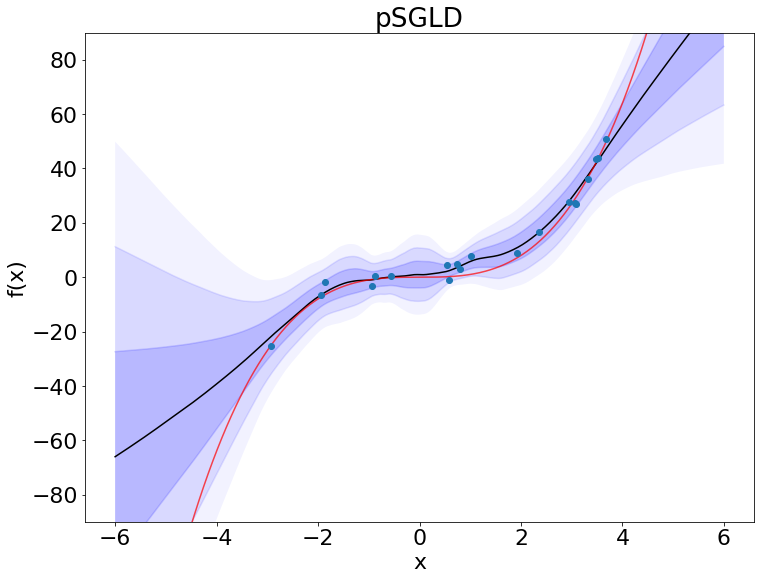

In [83]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 3 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 3 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.15)
plt.plot(grid,lower2,'blue',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid.squeeze(),lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('pSGLD')

### KSGLD

In [12]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3


batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
# learning_rates = [1e-2, 9e-3, 8e-3, 7e-3, 6e-3, 5e-3, 4e-3, 3e-3, 2e-3, 1e-3]
# learning_rates = [1e-2]
# learning_rates = [1e-2]
# learning_rates = [8e-4]
learning_rates = [1e-3]
rmse_result = np.zeros((1,len(learning_rates)))

# grid_search = True
grid_search = False


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgld = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1)
    
    t = 1.
    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*9))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions_ksgld = torch.cat((predictions_ksgld, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 643.9552
Epoch 1 - loss: 643.2596
Epoch 2 - loss: 639.4901
Epoch 3 - loss: 637.0111
Epoch 4 - loss: 632.2084
Epoch 5 - loss: 630.2466
Epoch 6 - loss: 630.0546
Epoch 7 - loss: 625.5869
Epoch 8 - loss: 622.4666
Epoch 9 - loss: 617.7191
Epoch 10 - loss: 616.0358
Epoch 11 - loss: 613.7242
Epoch 12 - loss: 611.0422
Epoch 13 - loss: 606.8232
Epoch 14 - loss: 599.4996
Epoch 15 - loss: 585.2219
Epoch 16 - loss: 578.7184
Epoch 17 - loss: 574.6832
Epoch 18 - loss: 570.5866
Epoch 19 - loss: 564.1918
Epoch 20 - loss: 559.7723
Epoch 21 - loss: 558.6381
Epoch 22 - loss: 555.6955
Epoch 23 - loss: 551.2828
Epoch 24 - loss: 538.8152
Epoch 25 - loss: 528.7735
Epoch 26 - loss: 522.9974
Epoch 27 - loss: 518.1597
Epoch 28 - loss: 510.4146
Epoch 29 - loss: 503.2868
Epoch 30 - loss: 495.5802
Epoch 31 - loss: 492.6180
Epoch 32 - loss: 487.7668
Epoch 33 - loss: 486.8893
Epoch 34 - loss: 479.0305
Epoch 35 - loss: 468.5770
Epoch 36 - loss: 456.4902
Epoch 37 - loss: 438.4246
Epoch 38 - loss: 434.7

Epoch 327 - loss: 17.9198
Epoch 328 - loss: 17.0500
Epoch 329 - loss: 17.7040
Epoch 330 - loss: 15.2016
Epoch 331 - loss: 15.0028
Epoch 332 - loss: 15.8107
Epoch 333 - loss: 16.0072
Epoch 334 - loss: 16.9643
Epoch 335 - loss: 16.2632
Epoch 336 - loss: 15.2332
Epoch 337 - loss: 15.7274
Epoch 338 - loss: 15.8309
Epoch 339 - loss: 18.4447
Epoch 340 - loss: 17.8964
Epoch 341 - loss: 16.4029
Epoch 342 - loss: 15.9738
Epoch 343 - loss: 15.5484
Epoch 344 - loss: 13.2109
Epoch 345 - loss: 14.4696
Epoch 346 - loss: 14.8968
Epoch 347 - loss: 16.4847
Epoch 348 - loss: 16.1289
Epoch 349 - loss: 16.3482
Epoch 350 - loss: 16.7544
Epoch 351 - loss: 17.5354
Epoch 352 - loss: 17.6542
Epoch 353 - loss: 14.4168
Epoch 354 - loss: 15.9547
Epoch 355 - loss: 13.5678
Epoch 356 - loss: 13.2164
Epoch 357 - loss: 12.8622
Epoch 358 - loss: 12.3042
Epoch 359 - loss: 12.4907
Epoch 360 - loss: 11.4852
Epoch 361 - loss: 11.9770
Epoch 362 - loss: 11.9043
Epoch 363 - loss: 11.7275
Epoch 364 - loss: 11.0877
Epoch 365 - 

Epoch 656 - loss: 10.7237
Epoch 657 - loss: 9.4487
Epoch 658 - loss: 11.4686
Epoch 659 - loss: 11.9058
Epoch 660 - loss: 10.1233
Epoch 661 - loss: 9.6943
Epoch 662 - loss: 11.4588
Epoch 663 - loss: 9.6475
Epoch 664 - loss: 9.5028
Epoch 665 - loss: 11.0377
Epoch 666 - loss: 10.7072
Epoch 667 - loss: 11.6859
Epoch 668 - loss: 10.1460
Epoch 669 - loss: 11.8783
Epoch 670 - loss: 15.1678
Epoch 671 - loss: 14.9253
Epoch 672 - loss: 13.5075
Epoch 673 - loss: 12.0386
Epoch 674 - loss: 12.7520
Epoch 675 - loss: 9.7707
Epoch 676 - loss: 9.4495
Epoch 677 - loss: 9.5562
Epoch 678 - loss: 11.0117
Epoch 679 - loss: 12.7860
Epoch 680 - loss: 14.0037
Epoch 681 - loss: 13.0505
Epoch 682 - loss: 15.5876
Epoch 683 - loss: 14.8587
Epoch 684 - loss: 16.6881
Epoch 685 - loss: 18.9067
Epoch 686 - loss: 19.0843
Epoch 687 - loss: 17.8000
Epoch 688 - loss: 21.0082
Epoch 689 - loss: 23.7831
Epoch 690 - loss: 22.0647
Epoch 691 - loss: 29.5655
Epoch 692 - loss: 29.9307
Epoch 693 - loss: 22.3122
Epoch 694 - loss: 2

Epoch 983 - loss: 10.5567
Epoch 984 - loss: 9.8711
Epoch 985 - loss: 7.4113
Epoch 986 - loss: 6.8654
Epoch 987 - loss: 5.8415
Epoch 988 - loss: 3.8510
Epoch 989 - loss: 5.3362
Epoch 990 - loss: 6.7922
Epoch 991 - loss: 6.6838
Epoch 992 - loss: 7.2506
Epoch 993 - loss: 8.1679
Epoch 994 - loss: 9.3403
Epoch 995 - loss: 9.5135
Epoch 996 - loss: 8.5931
Epoch 997 - loss: 12.6900
Epoch 998 - loss: 13.2729
Epoch 999 - loss: 12.1022
Epoch 1000 - loss: 10.8254
Epoch 1001 - loss: 13.1634
Epoch 1002 - loss: 10.5237
Epoch 1003 - loss: 10.2781
Epoch 1004 - loss: 12.5368
Epoch 1005 - loss: 9.4060
Epoch 1006 - loss: 7.8177
Epoch 1007 - loss: 5.5465
Epoch 1008 - loss: 5.8517
Epoch 1009 - loss: 7.1387
Epoch 1010 - loss: 9.6179
Epoch 1011 - loss: 8.0922
Epoch 1012 - loss: 6.7659
Epoch 1013 - loss: 7.2755
Epoch 1014 - loss: 9.6424
Epoch 1015 - loss: 10.2605
Epoch 1016 - loss: 7.4503
Epoch 1017 - loss: 6.2578
Epoch 1018 - loss: 6.3390
Epoch 1019 - loss: 6.4472
Epoch 1020 - loss: 5.7335
Epoch 1021 - loss: 

Epoch 1301 - loss: 8.7006
Epoch 1302 - loss: 11.0156
Epoch 1303 - loss: 10.0240
Epoch 1304 - loss: 10.9681
Epoch 1305 - loss: 12.9569
Epoch 1306 - loss: 13.0549
Epoch 1307 - loss: 12.9154
Epoch 1308 - loss: 9.6977
Epoch 1309 - loss: 9.5047
Epoch 1310 - loss: 10.2460
Epoch 1311 - loss: 11.0967
Epoch 1312 - loss: 13.3569
Epoch 1313 - loss: 12.7691
Epoch 1314 - loss: 11.4620
Epoch 1315 - loss: 11.6662
Epoch 1316 - loss: 13.7590
Epoch 1317 - loss: 14.9420
Epoch 1318 - loss: 10.5699
Epoch 1319 - loss: 13.4573
Epoch 1320 - loss: 10.9234
Epoch 1321 - loss: 10.6242
Epoch 1322 - loss: 9.0741
Epoch 1323 - loss: 9.6057
Epoch 1324 - loss: 11.0177
Epoch 1325 - loss: 12.2019
Epoch 1326 - loss: 12.6519
Epoch 1327 - loss: 15.7209
Epoch 1328 - loss: 14.7709
Epoch 1329 - loss: 15.7292
Epoch 1330 - loss: 14.7622
Epoch 1331 - loss: 13.3480
Epoch 1332 - loss: 10.2347
Epoch 1333 - loss: 14.2220
Epoch 1334 - loss: 10.7630
Epoch 1335 - loss: 11.3342
Epoch 1336 - loss: 8.4496
Epoch 1337 - loss: 9.1453
Epoch 13

Epoch 1611 - loss: 13.1671
Epoch 1612 - loss: 15.4917
Epoch 1613 - loss: 14.3214
Epoch 1614 - loss: 13.8329
Epoch 1615 - loss: 15.4287
Epoch 1616 - loss: 12.9623
Epoch 1617 - loss: 12.0750
Epoch 1618 - loss: 10.1832
Epoch 1619 - loss: 10.6844
Epoch 1620 - loss: 8.7544
Epoch 1621 - loss: 8.5731
Epoch 1622 - loss: 7.5707
Epoch 1623 - loss: 9.5038
Epoch 1624 - loss: 10.1806
Epoch 1625 - loss: 12.4021
Epoch 1626 - loss: 11.7911
Epoch 1627 - loss: 11.6524
Epoch 1628 - loss: 12.2009
Epoch 1629 - loss: 12.2464
Epoch 1630 - loss: 12.7188
Epoch 1631 - loss: 12.7813
Epoch 1632 - loss: 12.1049
Epoch 1633 - loss: 11.7210
Epoch 1634 - loss: 11.8532
Epoch 1635 - loss: 12.0379
Epoch 1636 - loss: 12.7173
Epoch 1637 - loss: 12.3756
Epoch 1638 - loss: 11.5917
Epoch 1639 - loss: 11.2802
Epoch 1640 - loss: 10.1834
Epoch 1641 - loss: 10.7287
Epoch 1642 - loss: 11.2950
Epoch 1643 - loss: 9.6712
Epoch 1644 - loss: 11.5353
Epoch 1645 - loss: 12.2471
Epoch 1646 - loss: 10.8713
Epoch 1647 - loss: 13.1274
Epoch 

Epoch 1933 - loss: 10.5192
Epoch 1934 - loss: 10.0558
Epoch 1935 - loss: 10.8731
Epoch 1936 - loss: 11.1887
Epoch 1937 - loss: 12.2473
Epoch 1938 - loss: 13.5514
Epoch 1939 - loss: 15.9471
Epoch 1940 - loss: 20.3224
Epoch 1941 - loss: 16.7708
Epoch 1942 - loss: 16.3695
Epoch 1943 - loss: 16.7958
Epoch 1944 - loss: 12.6701
Epoch 1945 - loss: 12.2401
Epoch 1946 - loss: 13.5093
Epoch 1947 - loss: 12.4702
Epoch 1948 - loss: 14.7023
Epoch 1949 - loss: 15.6351
Epoch 1950 - loss: 17.0148
Epoch 1951 - loss: 17.8249
Epoch 1952 - loss: 18.4921
Epoch 1953 - loss: 13.3867
Epoch 1954 - loss: 15.5469
Epoch 1955 - loss: 15.1828
Epoch 1956 - loss: 15.7032
Epoch 1957 - loss: 17.7341
Epoch 1958 - loss: 18.6616
Epoch 1959 - loss: 17.3210
Epoch 1960 - loss: 17.2267
Epoch 1961 - loss: 13.3437
Epoch 1962 - loss: 12.3677
Epoch 1963 - loss: 12.3186
Epoch 1964 - loss: 12.1759
Epoch 1965 - loss: 14.1839
Epoch 1966 - loss: 12.8152
Epoch 1967 - loss: 17.2661
Epoch 1968 - loss: 15.3591
Epoch 1969 - loss: 13.6580
E

Epoch 2243 - loss: 8.3393
Epoch 2244 - loss: 8.8351
Epoch 2245 - loss: 8.4877
Epoch 2246 - loss: 9.2753
Epoch 2247 - loss: 7.6448
Epoch 2248 - loss: 9.2722
Epoch 2249 - loss: 9.3416
Epoch 2250 - loss: 9.2976
Epoch 2251 - loss: 11.0383
Epoch 2252 - loss: 10.4183
Epoch 2253 - loss: 10.2690
Epoch 2254 - loss: 10.4295
Epoch 2255 - loss: 14.1880
Epoch 2256 - loss: 11.5190
Epoch 2257 - loss: 13.1273
Epoch 2258 - loss: 11.8543
Epoch 2259 - loss: 10.4119
Epoch 2260 - loss: 9.5282
Epoch 2261 - loss: 12.1227
Epoch 2262 - loss: 13.0355
Epoch 2263 - loss: 13.7927
Epoch 2264 - loss: 10.1422
Epoch 2265 - loss: 9.0579
Epoch 2266 - loss: 10.8824
Epoch 2267 - loss: 11.7733
Epoch 2268 - loss: 13.4423
Epoch 2269 - loss: 13.4657
Epoch 2270 - loss: 14.1395
Epoch 2271 - loss: 12.8128
Epoch 2272 - loss: 12.3130
Epoch 2273 - loss: 13.5801
Epoch 2274 - loss: 12.8439
Epoch 2275 - loss: 13.3303
Epoch 2276 - loss: 14.4913
Epoch 2277 - loss: 15.6889
Epoch 2278 - loss: 17.6481
Epoch 2279 - loss: 19.6531
Epoch 2280 

Epoch 2557 - loss: 16.7787
Epoch 2558 - loss: 17.2538
Epoch 2559 - loss: 18.4136
Epoch 2560 - loss: 19.6046
Epoch 2561 - loss: 17.8816
Epoch 2562 - loss: 14.9444
Epoch 2563 - loss: 15.6929
Epoch 2564 - loss: 21.5870
Epoch 2565 - loss: 14.1649
Epoch 2566 - loss: 14.1902
Epoch 2567 - loss: 13.1872
Epoch 2568 - loss: 12.8774
Epoch 2569 - loss: 11.5299
Epoch 2570 - loss: 7.5586
Epoch 2571 - loss: 8.9449
Epoch 2572 - loss: 10.3347
Epoch 2573 - loss: 9.3933
Epoch 2574 - loss: 11.1196
Epoch 2575 - loss: 14.2604
Epoch 2576 - loss: 12.0749
Epoch 2577 - loss: 14.8142
Epoch 2578 - loss: 17.9721
Epoch 2579 - loss: 14.9886
Epoch 2580 - loss: 20.6227
Epoch 2581 - loss: 23.2618
Epoch 2582 - loss: 24.1019
Epoch 2583 - loss: 20.6199
Epoch 2584 - loss: 22.2793
Epoch 2585 - loss: 23.2426
Epoch 2586 - loss: 20.0511
Epoch 2587 - loss: 11.8236
Epoch 2588 - loss: 13.9353
Epoch 2589 - loss: 11.8845
Epoch 2590 - loss: 10.5459
Epoch 2591 - loss: 11.9393
Epoch 2592 - loss: 11.0720
Epoch 2593 - loss: 10.8514
Epoc

Epoch 2874 - loss: 11.3625
Epoch 2875 - loss: 11.7137
Epoch 2876 - loss: 12.8300
Epoch 2877 - loss: 18.3356
Epoch 2878 - loss: 19.0387
Epoch 2879 - loss: 14.8930
Epoch 2880 - loss: 13.8939
Epoch 2881 - loss: 13.0270
Epoch 2882 - loss: 8.5129
Epoch 2883 - loss: 9.3595
Epoch 2884 - loss: 11.3700
Epoch 2885 - loss: 12.3808
Epoch 2886 - loss: 13.2883
Epoch 2887 - loss: 15.6609
Epoch 2888 - loss: 16.8022
Epoch 2889 - loss: 19.5592
Epoch 2890 - loss: 15.0314
Epoch 2891 - loss: 12.0345
Epoch 2892 - loss: 11.4019
Epoch 2893 - loss: 10.7552
Epoch 2894 - loss: 13.5015
Epoch 2895 - loss: 13.1460
Epoch 2896 - loss: 18.4215
Epoch 2897 - loss: 19.6974
Epoch 2898 - loss: 21.1485
Epoch 2899 - loss: 20.0092
Epoch 2900 - loss: 20.6987
Epoch 2901 - loss: 26.1089
Epoch 2902 - loss: 31.5310
Epoch 2903 - loss: 27.2747
Epoch 2904 - loss: 25.1150
Epoch 2905 - loss: 24.7047
Epoch 2906 - loss: 24.1154
Epoch 2907 - loss: 22.2922
Epoch 2908 - loss: 24.1600
Epoch 2909 - loss: 23.9102
Epoch 2910 - loss: 35.0808
Epo

Epoch 3179 - loss: 16.4079
Epoch 3180 - loss: 17.0021
Epoch 3181 - loss: 16.8980
Epoch 3182 - loss: 17.4483
Epoch 3183 - loss: 16.7591
Epoch 3184 - loss: 16.9094
Epoch 3185 - loss: 18.8253
Epoch 3186 - loss: 18.8754
Epoch 3187 - loss: 18.5921
Epoch 3188 - loss: 17.5702
Epoch 3189 - loss: 18.2975
Epoch 3190 - loss: 16.4305
Epoch 3191 - loss: 11.8632
Epoch 3192 - loss: 11.0927
Epoch 3193 - loss: 9.8836
Epoch 3194 - loss: 11.3416
Epoch 3195 - loss: 10.4260
Epoch 3196 - loss: 11.3981
Epoch 3197 - loss: 11.8007
Epoch 3198 - loss: 9.8000
Epoch 3199 - loss: 9.3991
Epoch 3200 - loss: 8.4177
Epoch 3201 - loss: 9.3491
Epoch 3202 - loss: 9.4624
Epoch 3203 - loss: 8.8189
Epoch 3204 - loss: 12.7383
Epoch 3205 - loss: 11.9406
Epoch 3206 - loss: 11.0471
Epoch 3207 - loss: 11.1787
Epoch 3208 - loss: 9.8550
Epoch 3209 - loss: 9.5999
Epoch 3210 - loss: 10.2869
Epoch 3211 - loss: 11.3919
Epoch 3212 - loss: 11.5578
Epoch 3213 - loss: 14.1912
Epoch 3214 - loss: 13.5909
Epoch 3215 - loss: 13.0246
Epoch 3216

Epoch 3483 - loss: 12.9492
Epoch 3484 - loss: 12.0190
Epoch 3485 - loss: 12.8898
Epoch 3486 - loss: 14.8814
Epoch 3487 - loss: 14.2573
Epoch 3488 - loss: 13.3860
Epoch 3489 - loss: 14.4757
Epoch 3490 - loss: 14.1925
Epoch 3491 - loss: 14.0274
Epoch 3492 - loss: 14.0912
Epoch 3493 - loss: 14.2322
Epoch 3494 - loss: 14.3264
Epoch 3495 - loss: 16.6441
Epoch 3496 - loss: 15.5704
Epoch 3497 - loss: 14.3717
Epoch 3498 - loss: 14.4834
Epoch 3499 - loss: 14.7399
Epoch 3500 - loss: 16.1950
Epoch 3501 - loss: 14.3642
Epoch 3502 - loss: 14.2145
Epoch 3503 - loss: 14.8998
Epoch 3504 - loss: 14.7814
Epoch 3505 - loss: 13.7549
Epoch 3506 - loss: 13.1830
Epoch 3507 - loss: 14.3430
Epoch 3508 - loss: 12.6476
Epoch 3509 - loss: 12.0970
Epoch 3510 - loss: 11.8681
Epoch 3511 - loss: 12.5564
Epoch 3512 - loss: 13.4650
Epoch 3513 - loss: 14.4371
Epoch 3514 - loss: 11.0027
Epoch 3515 - loss: 11.1525
Epoch 3516 - loss: 11.6215
Epoch 3517 - loss: 11.9352
Epoch 3518 - loss: 13.0923
Epoch 3519 - loss: 11.5584
E

Epoch 3798 - loss: 16.4219
Epoch 3799 - loss: 18.1663
Epoch 3800 - loss: 17.8290
Epoch 3801 - loss: 16.0184
Epoch 3802 - loss: 16.3349
Epoch 3803 - loss: 15.4756
Epoch 3804 - loss: 16.3254
Epoch 3805 - loss: 16.3495
Epoch 3806 - loss: 17.4654
Epoch 3807 - loss: 15.6614
Epoch 3808 - loss: 15.7417
Epoch 3809 - loss: 14.9644
Epoch 3810 - loss: 17.4779
Epoch 3811 - loss: 16.5087
Epoch 3812 - loss: 15.6636
Epoch 3813 - loss: 15.1211
Epoch 3814 - loss: 14.5904
Epoch 3815 - loss: 12.4292
Epoch 3816 - loss: 13.3990
Epoch 3817 - loss: 12.4889
Epoch 3818 - loss: 10.6476
Epoch 3819 - loss: 8.0563
Epoch 3820 - loss: 7.5623
Epoch 3821 - loss: 8.5603
Epoch 3822 - loss: 8.1383
Epoch 3823 - loss: 9.4394
Epoch 3824 - loss: 8.6577
Epoch 3825 - loss: 10.1214
Epoch 3826 - loss: 10.1089
Epoch 3827 - loss: 9.7918
Epoch 3828 - loss: 7.8635
Epoch 3829 - loss: 8.0444
Epoch 3830 - loss: 9.1567
Epoch 3831 - loss: 9.6877
Epoch 3832 - loss: 7.8883
Epoch 3833 - loss: 8.6595
Epoch 3834 - loss: 9.9996
Epoch 3835 - lo

Epoch 4118 - loss: 10.2167
Epoch 4119 - loss: 11.0676
Epoch 4120 - loss: 11.7565
Epoch 4121 - loss: 11.1049
Epoch 4122 - loss: 10.6818
Epoch 4123 - loss: 9.1482
Epoch 4124 - loss: 8.1123
Epoch 4125 - loss: 7.9549
Epoch 4126 - loss: 9.0276
Epoch 4127 - loss: 9.3540
Epoch 4128 - loss: 8.5730
Epoch 4129 - loss: 8.7894
Epoch 4130 - loss: 11.1317
Epoch 4131 - loss: 11.1472
Epoch 4132 - loss: 11.9276
Epoch 4133 - loss: 10.9411
Epoch 4134 - loss: 10.9940
Epoch 4135 - loss: 12.3743
Epoch 4136 - loss: 12.0013
Epoch 4137 - loss: 12.6759
Epoch 4138 - loss: 12.4354
Epoch 4139 - loss: 12.8332
Epoch 4140 - loss: 11.7166
Epoch 4141 - loss: 11.8371
Epoch 4142 - loss: 13.1953
Epoch 4143 - loss: 13.8499
Epoch 4144 - loss: 14.1167
Epoch 4145 - loss: 15.9802
Epoch 4146 - loss: 15.4136
Epoch 4147 - loss: 11.6934
Epoch 4148 - loss: 12.0021
Epoch 4149 - loss: 12.1071
Epoch 4150 - loss: 11.7686
Epoch 4151 - loss: 10.0529
Epoch 4152 - loss: 11.5868
Epoch 4153 - loss: 13.6024
Epoch 4154 - loss: 14.8742
Epoch 41

Epoch 4436 - loss: 12.5487
Epoch 4437 - loss: 11.9362
Epoch 4438 - loss: 12.6100
Epoch 4439 - loss: 14.8976
Epoch 4440 - loss: 15.5964
Epoch 4441 - loss: 16.2652
Epoch 4442 - loss: 17.6302
Epoch 4443 - loss: 17.5124
Epoch 4444 - loss: 18.0953
Epoch 4445 - loss: 17.5312
Epoch 4446 - loss: 15.8461
Epoch 4447 - loss: 15.2221
Epoch 4448 - loss: 16.1716
Epoch 4449 - loss: 17.5243
Epoch 4450 - loss: 20.9547
Epoch 4451 - loss: 20.4193
Epoch 4452 - loss: 17.8051
Epoch 4453 - loss: 18.5131
Epoch 4454 - loss: 16.9980
Epoch 4455 - loss: 15.9686
Epoch 4456 - loss: 15.3125
Epoch 4457 - loss: 12.9647
Epoch 4458 - loss: 12.5010
Epoch 4459 - loss: 11.6726
Epoch 4460 - loss: 11.7613
Epoch 4461 - loss: 9.0639
Epoch 4462 - loss: 11.2152
Epoch 4463 - loss: 11.0897
Epoch 4464 - loss: 7.9641
Epoch 4465 - loss: 8.3979
Epoch 4466 - loss: 7.8971
Epoch 4467 - loss: 8.4820
Epoch 4468 - loss: 8.4397
Epoch 4469 - loss: 7.9406
Epoch 4470 - loss: 9.4155
Epoch 4471 - loss: 8.8163
Epoch 4472 - loss: 8.7082
Epoch 4473 

Epoch 4748 - loss: 9.0610
Epoch 4749 - loss: 8.6673
Epoch 4750 - loss: 10.4516
Epoch 4751 - loss: 9.8547
Epoch 4752 - loss: 10.8864
Epoch 4753 - loss: 12.1145
Epoch 4754 - loss: 10.9363
Epoch 4755 - loss: 11.1465
Epoch 4756 - loss: 10.3140
Epoch 4757 - loss: 9.8945
Epoch 4758 - loss: 8.8836
Epoch 4759 - loss: 9.1668
Epoch 4760 - loss: 7.2765
Epoch 4761 - loss: 6.2081
Epoch 4762 - loss: 7.0765
Epoch 4763 - loss: 8.5717
Epoch 4764 - loss: 8.4671
Epoch 4765 - loss: 7.9307
Epoch 4766 - loss: 8.7921
Epoch 4767 - loss: 7.0934
Epoch 4768 - loss: 7.5769
Epoch 4769 - loss: 6.2965
Epoch 4770 - loss: 6.6381
Epoch 4771 - loss: 6.2542
Epoch 4772 - loss: 6.5924
Epoch 4773 - loss: 6.1858
Epoch 4774 - loss: 5.8579
Epoch 4775 - loss: 5.6155
Epoch 4776 - loss: 4.9453
Epoch 4777 - loss: 4.7154
Epoch 4778 - loss: 4.5289
Epoch 4779 - loss: 4.9533
Epoch 4780 - loss: 6.2089
Epoch 4781 - loss: 6.0426
Epoch 4782 - loss: 5.7692
Epoch 4783 - loss: 5.6947
Epoch 4784 - loss: 5.9643
Epoch 4785 - loss: 7.0500
Epoch 

Epoch 5070 - loss: 14.8405
Epoch 5071 - loss: 11.1670
Epoch 5072 - loss: 11.4835
Epoch 5073 - loss: 12.3846
Epoch 5074 - loss: 12.0370
Epoch 5075 - loss: 13.5346
Epoch 5076 - loss: 12.7247
Epoch 5077 - loss: 12.4609
Epoch 5078 - loss: 12.0270
Epoch 5079 - loss: 9.8231
Epoch 5080 - loss: 8.5595
Epoch 5081 - loss: 9.2137
Epoch 5082 - loss: 8.9178
Epoch 5083 - loss: 7.6615
Epoch 5084 - loss: 7.6785
Epoch 5085 - loss: 8.6093
Epoch 5086 - loss: 9.3071
Epoch 5087 - loss: 10.3325
Epoch 5088 - loss: 9.4614
Epoch 5089 - loss: 8.1722
Epoch 5090 - loss: 8.4683
Epoch 5091 - loss: 8.3296
Epoch 5092 - loss: 8.8175
Epoch 5093 - loss: 8.6168
Epoch 5094 - loss: 8.2924
Epoch 5095 - loss: 8.3994
Epoch 5096 - loss: 8.7829
Epoch 5097 - loss: 7.8371
Epoch 5098 - loss: 8.6218
Epoch 5099 - loss: 8.2626
Epoch 5100 - loss: 9.5048
Epoch 5101 - loss: 8.8354
Epoch 5102 - loss: 8.5697
Epoch 5103 - loss: 8.3357
Epoch 5104 - loss: 6.4174
Epoch 5105 - loss: 6.3218
Epoch 5106 - loss: 6.2874
Epoch 5107 - loss: 5.7972
Ep

Epoch 5380 - loss: 11.2643
Epoch 5381 - loss: 11.7241
Epoch 5382 - loss: 10.9225
Epoch 5383 - loss: 12.6216
Epoch 5384 - loss: 10.8878
Epoch 5385 - loss: 9.7235
Epoch 5386 - loss: 9.7504
Epoch 5387 - loss: 10.2499
Epoch 5388 - loss: 6.6691
Epoch 5389 - loss: 7.6233
Epoch 5390 - loss: 6.9880
Epoch 5391 - loss: 6.8547
Epoch 5392 - loss: 6.5802
Epoch 5393 - loss: 6.5266
Epoch 5394 - loss: 6.2788
Epoch 5395 - loss: 6.2244
Epoch 5396 - loss: 6.4476
Epoch 5397 - loss: 6.0342
Epoch 5398 - loss: 6.7277
Epoch 5399 - loss: 6.5392
Epoch 5400 - loss: 7.1619
Epoch 5401 - loss: 6.9737
Epoch 5402 - loss: 7.2074
Epoch 5403 - loss: 6.2915
Epoch 5404 - loss: 6.2272
Epoch 5405 - loss: 6.2114
Epoch 5406 - loss: 6.6426
Epoch 5407 - loss: 6.6149
Epoch 5408 - loss: 7.6227
Epoch 5409 - loss: 7.4280
Epoch 5410 - loss: 7.4000
Epoch 5411 - loss: 6.7758
Epoch 5412 - loss: 6.7884
Epoch 5413 - loss: 6.1365
Epoch 5414 - loss: 5.8390
Epoch 5415 - loss: 6.0895
Epoch 5416 - loss: 6.0985
Epoch 5417 - loss: 5.3773
Epoch 

Epoch 5694 - loss: 7.5154
Epoch 5695 - loss: 8.8127
Epoch 5696 - loss: 9.2973
Epoch 5697 - loss: 11.3718
Epoch 5698 - loss: 10.6900
Epoch 5699 - loss: 12.5618
Epoch 5700 - loss: 13.0372
Epoch 5701 - loss: 13.8786
Epoch 5702 - loss: 13.6920
Epoch 5703 - loss: 13.0912
Epoch 5704 - loss: 13.4582
Epoch 5705 - loss: 10.6840
Epoch 5706 - loss: 10.5272
Epoch 5707 - loss: 10.3555
Epoch 5708 - loss: 10.0310
Epoch 5709 - loss: 10.3589
Epoch 5710 - loss: 10.4362
Epoch 5711 - loss: 8.2556
Epoch 5712 - loss: 7.6734
Epoch 5713 - loss: 8.4358
Epoch 5714 - loss: 7.6545
Epoch 5715 - loss: 7.9531
Epoch 5716 - loss: 7.2879
Epoch 5717 - loss: 8.2878
Epoch 5718 - loss: 9.3695
Epoch 5719 - loss: 9.8760
Epoch 5720 - loss: 8.5040
Epoch 5721 - loss: 8.2383
Epoch 5722 - loss: 8.6648
Epoch 5723 - loss: 9.3542
Epoch 5724 - loss: 9.0317
Epoch 5725 - loss: 10.9689
Epoch 5726 - loss: 10.4001
Epoch 5727 - loss: 10.0446
Epoch 5728 - loss: 9.9708
Epoch 5729 - loss: 8.9041
Epoch 5730 - loss: 6.6853
Epoch 5731 - loss: 6.

Epoch 6019 - loss: 8.3739
Epoch 6020 - loss: 9.0051
Epoch 6021 - loss: 9.1952
Epoch 6022 - loss: 9.2425
Epoch 6023 - loss: 8.6694
Epoch 6024 - loss: 8.8537
Epoch 6025 - loss: 9.1913
Epoch 6026 - loss: 7.9679
Epoch 6027 - loss: 7.8870
Epoch 6028 - loss: 8.1711
Epoch 6029 - loss: 8.8926
Epoch 6030 - loss: 9.2996
Epoch 6031 - loss: 9.0732
Epoch 6032 - loss: 8.3338
Epoch 6033 - loss: 8.5140
Epoch 6034 - loss: 9.7027
Epoch 6035 - loss: 10.8761
Epoch 6036 - loss: 10.0045
Epoch 6037 - loss: 8.5090
Epoch 6038 - loss: 8.2717
Epoch 6039 - loss: 7.7646
Epoch 6040 - loss: 7.8398
Epoch 6041 - loss: 9.4208
Epoch 6042 - loss: 9.5551
Epoch 6043 - loss: 9.9093
Epoch 6044 - loss: 9.4553
Epoch 6045 - loss: 9.5650
Epoch 6046 - loss: 9.6850
Epoch 6047 - loss: 9.9944
Epoch 6048 - loss: 10.8929
Epoch 6049 - loss: 12.0179
Epoch 6050 - loss: 12.5526
Epoch 6051 - loss: 13.1204
Epoch 6052 - loss: 12.8276
Epoch 6053 - loss: 12.2261
Epoch 6054 - loss: 12.2369
Epoch 6055 - loss: 11.5358
Epoch 6056 - loss: 12.6840
E

Epoch 6344 - loss: 14.9302
Epoch 6345 - loss: 14.9191
Epoch 6346 - loss: 14.8896
Epoch 6347 - loss: 12.9480
Epoch 6348 - loss: 14.9798
Epoch 6349 - loss: 15.0156
Epoch 6350 - loss: 15.4159
Epoch 6351 - loss: 18.1549
Epoch 6352 - loss: 19.3550
Epoch 6353 - loss: 18.6501
Epoch 6354 - loss: 19.8474
Epoch 6355 - loss: 21.5694
Epoch 6356 - loss: 19.3358
Epoch 6357 - loss: 19.6771
Epoch 6358 - loss: 18.2147
Epoch 6359 - loss: 19.1931
Epoch 6360 - loss: 19.4808
Epoch 6361 - loss: 18.8894
Epoch 6362 - loss: 19.5533
Epoch 6363 - loss: 17.3216
Epoch 6364 - loss: 17.0183
Epoch 6365 - loss: 18.4970
Epoch 6366 - loss: 18.6328
Epoch 6367 - loss: 18.8717
Epoch 6368 - loss: 16.4179
Epoch 6369 - loss: 15.7691
Epoch 6370 - loss: 16.5509
Epoch 6371 - loss: 16.3275
Epoch 6372 - loss: 19.8057
Epoch 6373 - loss: 20.1333
Epoch 6374 - loss: 19.2321
Epoch 6375 - loss: 20.9392
Epoch 6376 - loss: 21.7973
Epoch 6377 - loss: 21.5395
Epoch 6378 - loss: 22.0819
Epoch 6379 - loss: 20.5708
Epoch 6380 - loss: 21.0303
E

Epoch 6660 - loss: 10.0311
Epoch 6661 - loss: 10.7960
Epoch 6662 - loss: 11.3332
Epoch 6663 - loss: 12.1301
Epoch 6664 - loss: 11.6923
Epoch 6665 - loss: 12.7764
Epoch 6666 - loss: 12.8467
Epoch 6667 - loss: 12.8231
Epoch 6668 - loss: 13.4344
Epoch 6669 - loss: 12.2649
Epoch 6670 - loss: 14.1775
Epoch 6671 - loss: 14.5201
Epoch 6672 - loss: 12.5480
Epoch 6673 - loss: 14.3301
Epoch 6674 - loss: 15.8624
Epoch 6675 - loss: 15.6926
Epoch 6676 - loss: 14.4730
Epoch 6677 - loss: 13.0687
Epoch 6678 - loss: 12.1060
Epoch 6679 - loss: 11.0293
Epoch 6680 - loss: 9.9583
Epoch 6681 - loss: 9.6218
Epoch 6682 - loss: 10.6881
Epoch 6683 - loss: 11.3890
Epoch 6684 - loss: 10.6920
Epoch 6685 - loss: 10.7357
Epoch 6686 - loss: 11.3608
Epoch 6687 - loss: 10.6018
Epoch 6688 - loss: 10.6578
Epoch 6689 - loss: 10.1558
Epoch 6690 - loss: 9.5378
Epoch 6691 - loss: 9.5332
Epoch 6692 - loss: 9.9197
Epoch 6693 - loss: 9.6583
Epoch 6694 - loss: 8.8839
Epoch 6695 - loss: 8.7289
Epoch 6696 - loss: 9.0497
Epoch 6697

Epoch 6972 - loss: 6.4352
Epoch 6973 - loss: 6.4026
Epoch 6974 - loss: 7.3148
Epoch 6975 - loss: 7.0029
Epoch 6976 - loss: 6.3939
Epoch 6977 - loss: 5.9192
Epoch 6978 - loss: 5.9576
Epoch 6979 - loss: 6.6227
Epoch 6980 - loss: 7.1039
Epoch 6981 - loss: 6.6675
Epoch 6982 - loss: 5.8743
Epoch 6983 - loss: 5.7034
Epoch 6984 - loss: 6.1018
Epoch 6985 - loss: 6.1316
Epoch 6986 - loss: 5.7364
Epoch 6987 - loss: 6.1600
Epoch 6988 - loss: 6.8572
Epoch 6989 - loss: 6.7931
Epoch 6990 - loss: 6.3923
Epoch 6991 - loss: 6.8997
Epoch 6992 - loss: 7.2926
Epoch 6993 - loss: 6.8876
Epoch 6994 - loss: 8.2328
Epoch 6995 - loss: 7.7477
Epoch 6996 - loss: 7.9123
Epoch 6997 - loss: 8.5184
Epoch 6998 - loss: 9.1625
Epoch 6999 - loss: 8.9789
Epoch 7000 - loss: 9.1400
Epoch 7001 - loss: 9.5305
Epoch 7002 - loss: 9.6589
Epoch 7003 - loss: 10.9508
Epoch 7004 - loss: 10.7595
Epoch 7005 - loss: 11.9102
Epoch 7006 - loss: 11.4217
Epoch 7007 - loss: 11.4582
Epoch 7008 - loss: 11.4078
Epoch 7009 - loss: 10.7105
Epoch

Epoch 7286 - loss: 9.9412
Epoch 7287 - loss: 9.4592
Epoch 7288 - loss: 8.5055
Epoch 7289 - loss: 9.1695
Epoch 7290 - loss: 9.1318
Epoch 7291 - loss: 10.8171
Epoch 7292 - loss: 11.1403
Epoch 7293 - loss: 10.9560
Epoch 7294 - loss: 11.5181
Epoch 7295 - loss: 11.1517
Epoch 7296 - loss: 11.7930
Epoch 7297 - loss: 10.1230
Epoch 7298 - loss: 10.4582
Epoch 7299 - loss: 10.8838
Epoch 7300 - loss: 12.0759
Epoch 7301 - loss: 12.7534
Epoch 7302 - loss: 15.3192
Epoch 7303 - loss: 13.9363
Epoch 7304 - loss: 13.1457
Epoch 7305 - loss: 13.0003
Epoch 7306 - loss: 12.4775
Epoch 7307 - loss: 11.8558
Epoch 7308 - loss: 11.8312
Epoch 7309 - loss: 11.2259
Epoch 7310 - loss: 10.5207
Epoch 7311 - loss: 9.5310
Epoch 7312 - loss: 9.2859
Epoch 7313 - loss: 8.9652
Epoch 7314 - loss: 8.4424
Epoch 7315 - loss: 10.6100
Epoch 7316 - loss: 10.1601
Epoch 7317 - loss: 8.8853
Epoch 7318 - loss: 8.7822
Epoch 7319 - loss: 8.5559
Epoch 7320 - loss: 9.1828
Epoch 7321 - loss: 9.3441
Epoch 7322 - loss: 9.3835
Epoch 7323 - los

Epoch 7603 - loss: 9.3774
Epoch 7604 - loss: 9.5235
Epoch 7605 - loss: 9.2715
Epoch 7606 - loss: 8.9700
Epoch 7607 - loss: 8.7225
Epoch 7608 - loss: 8.8024
Epoch 7609 - loss: 8.1656
Epoch 7610 - loss: 7.7651
Epoch 7611 - loss: 7.9191
Epoch 7612 - loss: 7.8410
Epoch 7613 - loss: 7.1886
Epoch 7614 - loss: 7.2162
Epoch 7615 - loss: 6.8944
Epoch 7616 - loss: 7.0925
Epoch 7617 - loss: 7.4196
Epoch 7618 - loss: 7.7725
Epoch 7619 - loss: 7.1469
Epoch 7620 - loss: 6.8194
Epoch 7621 - loss: 6.2515
Epoch 7622 - loss: 6.7539
Epoch 7623 - loss: 5.8592
Epoch 7624 - loss: 5.7821
Epoch 7625 - loss: 5.5508
Epoch 7626 - loss: 6.2341
Epoch 7627 - loss: 6.6229
Epoch 7628 - loss: 7.0203
Epoch 7629 - loss: 6.4434
Epoch 7630 - loss: 6.4699
Epoch 7631 - loss: 6.6865
Epoch 7632 - loss: 6.2169
Epoch 7633 - loss: 6.4842
Epoch 7634 - loss: 6.4324
Epoch 7635 - loss: 7.3898
Epoch 7636 - loss: 7.3795
Epoch 7637 - loss: 7.8399
Epoch 7638 - loss: 9.3643
Epoch 7639 - loss: 9.3047
Epoch 7640 - loss: 10.0646
Epoch 7641 

Epoch 7926 - loss: 11.3811
Epoch 7927 - loss: 11.6824
Epoch 7928 - loss: 11.2055
Epoch 7929 - loss: 10.8189
Epoch 7930 - loss: 12.4242
Epoch 7931 - loss: 13.0134
Epoch 7932 - loss: 13.1371
Epoch 7933 - loss: 17.6808
Epoch 7934 - loss: 17.6944
Epoch 7935 - loss: 17.4558
Epoch 7936 - loss: 17.6228
Epoch 7937 - loss: 17.6290
Epoch 7938 - loss: 19.5617
Epoch 7939 - loss: 16.8040
Epoch 7940 - loss: 18.0718
Epoch 7941 - loss: 18.2017
Epoch 7942 - loss: 16.6622
Epoch 7943 - loss: 16.7447
Epoch 7944 - loss: 16.7630
Epoch 7945 - loss: 16.1674
Epoch 7946 - loss: 15.7712
Epoch 7947 - loss: 15.5374
Epoch 7948 - loss: 14.1548
Epoch 7949 - loss: 14.2042
Epoch 7950 - loss: 13.6160
Epoch 7951 - loss: 13.8132
Epoch 7952 - loss: 15.3392
Epoch 7953 - loss: 15.2424
Epoch 7954 - loss: 14.1523
Epoch 7955 - loss: 13.9208
Epoch 7956 - loss: 13.6605
Epoch 7957 - loss: 12.4949
Epoch 7958 - loss: 12.7308
Epoch 7959 - loss: 13.5279
Epoch 7960 - loss: 13.3039
Epoch 7961 - loss: 11.3539
Epoch 7962 - loss: 10.3956
E

Epoch 8236 - loss: 17.8218
Epoch 8237 - loss: 15.9064
Epoch 8238 - loss: 17.5491
Epoch 8239 - loss: 19.2772
Epoch 8240 - loss: 20.5321
Epoch 8241 - loss: 22.3404
Epoch 8242 - loss: 25.3142
Epoch 8243 - loss: 24.1790
Epoch 8244 - loss: 23.8664
Epoch 8245 - loss: 23.2610
Epoch 8246 - loss: 22.9609
Epoch 8247 - loss: 23.8226
Epoch 8248 - loss: 24.2142
Epoch 8249 - loss: 22.7888
Epoch 8250 - loss: 19.0161
Epoch 8251 - loss: 19.1715
Epoch 8252 - loss: 20.7862
Epoch 8253 - loss: 21.0487
Epoch 8254 - loss: 21.2035
Epoch 8255 - loss: 20.0705
Epoch 8256 - loss: 21.2953
Epoch 8257 - loss: 20.7247
Epoch 8258 - loss: 18.9912
Epoch 8259 - loss: 19.7160
Epoch 8260 - loss: 19.3834
Epoch 8261 - loss: 19.4152
Epoch 8262 - loss: 17.4727
Epoch 8263 - loss: 15.2945
Epoch 8264 - loss: 15.3442
Epoch 8265 - loss: 15.0712
Epoch 8266 - loss: 16.3804
Epoch 8267 - loss: 16.4360
Epoch 8268 - loss: 16.1139
Epoch 8269 - loss: 16.1050
Epoch 8270 - loss: 16.8694
Epoch 8271 - loss: 18.2202
Epoch 8272 - loss: 17.3990
E

Epoch 8556 - loss: 16.2860
Epoch 8557 - loss: 16.6167
Epoch 8558 - loss: 17.0183
Epoch 8559 - loss: 16.4486
Epoch 8560 - loss: 15.7216
Epoch 8561 - loss: 16.1164
Epoch 8562 - loss: 15.9773
Epoch 8563 - loss: 15.9256
Epoch 8564 - loss: 15.0394
Epoch 8565 - loss: 15.7010
Epoch 8566 - loss: 15.4768
Epoch 8567 - loss: 16.4523
Epoch 8568 - loss: 16.7173
Epoch 8569 - loss: 17.5170
Epoch 8570 - loss: 17.3115
Epoch 8571 - loss: 16.1222
Epoch 8572 - loss: 16.1030
Epoch 8573 - loss: 15.4577
Epoch 8574 - loss: 14.9801
Epoch 8575 - loss: 15.1381
Epoch 8576 - loss: 16.3755
Epoch 8577 - loss: 16.1539
Epoch 8578 - loss: 15.8755
Epoch 8579 - loss: 15.6523
Epoch 8580 - loss: 14.7213
Epoch 8581 - loss: 14.4255
Epoch 8582 - loss: 14.3077
Epoch 8583 - loss: 14.8364
Epoch 8584 - loss: 14.6641
Epoch 8585 - loss: 15.1305
Epoch 8586 - loss: 14.2415
Epoch 8587 - loss: 13.9902
Epoch 8588 - loss: 13.7839
Epoch 8589 - loss: 14.1136
Epoch 8590 - loss: 13.4248
Epoch 8591 - loss: 13.1946
Epoch 8592 - loss: 12.5396
E

Epoch 8869 - loss: 11.6236
Epoch 8870 - loss: 11.6623
Epoch 8871 - loss: 11.2123
Epoch 8872 - loss: 10.9854
Epoch 8873 - loss: 11.0743
Epoch 8874 - loss: 11.2579
Epoch 8875 - loss: 10.8854
Epoch 8876 - loss: 11.1490
Epoch 8877 - loss: 11.4201
Epoch 8878 - loss: 10.2761
Epoch 8879 - loss: 10.3355
Epoch 8880 - loss: 11.3797
Epoch 8881 - loss: 12.4871
Epoch 8882 - loss: 11.6409
Epoch 8883 - loss: 10.6821
Epoch 8884 - loss: 9.8480
Epoch 8885 - loss: 9.2756
Epoch 8886 - loss: 9.1079
Epoch 8887 - loss: 8.8026
Epoch 8888 - loss: 8.3547
Epoch 8889 - loss: 9.5176
Epoch 8890 - loss: 9.9282
Epoch 8891 - loss: 8.6291
Epoch 8892 - loss: 7.7731
Epoch 8893 - loss: 6.8391
Epoch 8894 - loss: 6.9270
Epoch 8895 - loss: 7.3651
Epoch 8896 - loss: 7.9964
Epoch 8897 - loss: 7.8539
Epoch 8898 - loss: 8.0300
Epoch 8899 - loss: 7.2531
Epoch 8900 - loss: 7.2461
Epoch 8901 - loss: 6.4830
Epoch 8902 - loss: 6.3554
Epoch 8903 - loss: 6.5708
Epoch 8904 - loss: 6.5393
Epoch 8905 - loss: 6.6979
Epoch 8906 - loss: 6.49

Epoch 9190 - loss: 7.4431
Epoch 9191 - loss: 7.0045
Epoch 9192 - loss: 6.8901
Epoch 9193 - loss: 6.5905
Epoch 9194 - loss: 6.8925
Epoch 9195 - loss: 6.3895
Epoch 9196 - loss: 6.1499
Epoch 9197 - loss: 5.8671
Epoch 9198 - loss: 5.4112
Epoch 9199 - loss: 5.4720
Epoch 9200 - loss: 5.2763
Epoch 9201 - loss: 5.3876
Epoch 9202 - loss: 5.3372
Epoch 9203 - loss: 5.1456
Epoch 9204 - loss: 5.3863
Epoch 9205 - loss: 5.5954
Epoch 9206 - loss: 5.5669
Epoch 9207 - loss: 5.9115
Epoch 9208 - loss: 6.1460
Epoch 9209 - loss: 5.9723
Epoch 9210 - loss: 6.1357
Epoch 9211 - loss: 6.4789
Epoch 9212 - loss: 6.2751
Epoch 9213 - loss: 6.7881
Epoch 9214 - loss: 6.8327
Epoch 9215 - loss: 6.7441
Epoch 9216 - loss: 7.0967
Epoch 9217 - loss: 7.1093
Epoch 9218 - loss: 7.8415
Epoch 9219 - loss: 7.6471
Epoch 9220 - loss: 7.9791
Epoch 9221 - loss: 7.6404
Epoch 9222 - loss: 7.4233
Epoch 9223 - loss: 7.9152
Epoch 9224 - loss: 8.3002
Epoch 9225 - loss: 9.2381
Epoch 9226 - loss: 10.4719
Epoch 9227 - loss: 10.3624
Epoch 9228

Epoch 9504 - loss: 11.0495
Epoch 9505 - loss: 10.7614
Epoch 9506 - loss: 10.9156
Epoch 9507 - loss: 11.1527
Epoch 9508 - loss: 11.0358
Epoch 9509 - loss: 10.4018
Epoch 9510 - loss: 9.7873
Epoch 9511 - loss: 9.3137
Epoch 9512 - loss: 9.9745
Epoch 9513 - loss: 9.4666
Epoch 9514 - loss: 11.3646
Epoch 9515 - loss: 11.1166
Epoch 9516 - loss: 10.7802
Epoch 9517 - loss: 10.7277
Epoch 9518 - loss: 11.1231
Epoch 9519 - loss: 10.8042
Epoch 9520 - loss: 11.0241
Epoch 9521 - loss: 10.7120
Epoch 9522 - loss: 10.0764
Epoch 9523 - loss: 9.5217
Epoch 9524 - loss: 9.5577
Epoch 9525 - loss: 10.0046
Epoch 9526 - loss: 10.3335
Epoch 9527 - loss: 10.8213
Epoch 9528 - loss: 11.0613
Epoch 9529 - loss: 11.0097
Epoch 9530 - loss: 10.7106
Epoch 9531 - loss: 10.6548
Epoch 9532 - loss: 10.7117
Epoch 9533 - loss: 10.5972
Epoch 9534 - loss: 10.7605
Epoch 9535 - loss: 10.8949
Epoch 9536 - loss: 10.6605
Epoch 9537 - loss: 10.1375
Epoch 9538 - loss: 9.7520
Epoch 9539 - loss: 9.7984
Epoch 9540 - loss: 8.9191
Epoch 9541

Epoch 9822 - loss: 11.1554
Epoch 9823 - loss: 11.4614
Epoch 9824 - loss: 11.2185
Epoch 9825 - loss: 11.7261
Epoch 9826 - loss: 12.1912
Epoch 9827 - loss: 12.2711
Epoch 9828 - loss: 12.9536
Epoch 9829 - loss: 13.2672
Epoch 9830 - loss: 13.0975
Epoch 9831 - loss: 13.1190
Epoch 9832 - loss: 12.4713
Epoch 9833 - loss: 12.6272
Epoch 9834 - loss: 12.5489
Epoch 9835 - loss: 12.3502
Epoch 9836 - loss: 12.1113
Epoch 9837 - loss: 11.9137
Epoch 9838 - loss: 11.5350
Epoch 9839 - loss: 10.6615
Epoch 9840 - loss: 9.4380
Epoch 9841 - loss: 9.4872
Epoch 9842 - loss: 10.4644
Epoch 9843 - loss: 11.4795
Epoch 9844 - loss: 10.7750
Epoch 9845 - loss: 11.2574
Epoch 9846 - loss: 9.7499
Epoch 9847 - loss: 10.1205
Epoch 9848 - loss: 9.5577
Epoch 9849 - loss: 10.8501
Epoch 9850 - loss: 11.1878
Epoch 9851 - loss: 11.2651
Epoch 9852 - loss: 11.0404
Epoch 9853 - loss: 11.3975
Epoch 9854 - loss: 10.9499
Epoch 9855 - loss: 10.2740
Epoch 9856 - loss: 10.5090
Epoch 9857 - loss: 10.9446
Epoch 9858 - loss: 10.1614
Epoch

In [11]:
rmse_result

array([[28.46592331, 33.31303787, 27.41270828, 35.79110336, 23.26779938,
        31.58735275, 32.10213852, 25.77835846, 34.68482208, 19.68082809]])

Text(0.5,1,'K-SGLD')

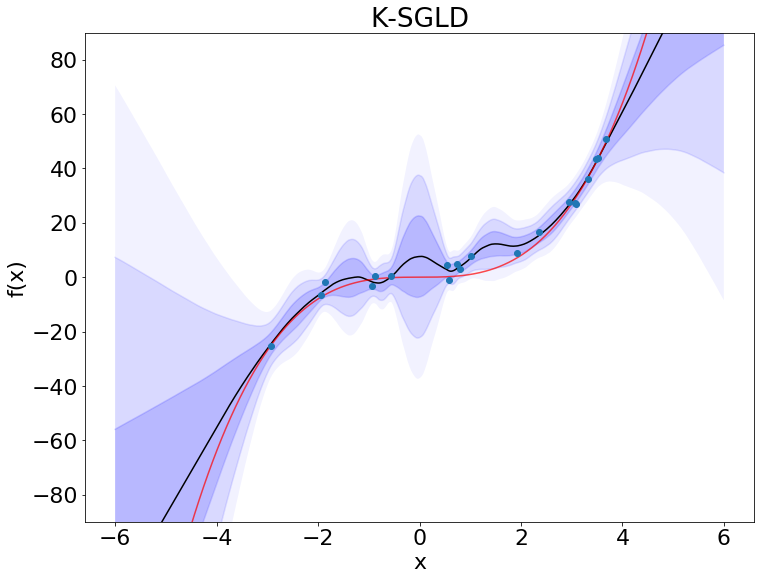

In [15]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.12)
plt.plot(grid,lower2,'blue',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid.squeeze(),lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('K-SGLD')

### KSGFS

In [11]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3

# learning_rates = [5e-2]
# learning_rates = [8e-3, 7e-3]
# learning_rates = [4e-2]
# learning_rates = [8e-3]
# learning_rates = [1e-3]
# learning_rates = [1e-3, 1e-4]
# learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
# learning_rates = [9e-3, 8e-3, 7e-3, 6e-3, 5e-3, 4e-3, 3e-3, 2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4]
# learning_rates = [6e-2]
learning_rates = [6e-3]


batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

rmse_result = np.zeros((1,len(learning_rates)))

# grid_search = True
grid_search = False

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgfs = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1)
    t = 1.

    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*9))*criterion(output, y)
        loss.backward()
        optim.step()



        running_loss += loss * batch_size / dataset_size



        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 611.5399
Epoch 1 - loss: 528.0055
Epoch 2 - loss: 441.8336
Epoch 3 - loss: 342.4050
Epoch 4 - loss: 249.1004
Epoch 5 - loss: 175.7515
Epoch 6 - loss: 125.0373
Epoch 7 - loss: 92.6696
Epoch 8 - loss: 71.0653
Epoch 9 - loss: 60.5855
Epoch 10 - loss: 54.4744
Epoch 11 - loss: 50.9089
Epoch 12 - loss: 49.0534
Epoch 13 - loss: 47.5198
Epoch 14 - loss: 45.8219
Epoch 15 - loss: 44.2193
Epoch 16 - loss: 42.4798
Epoch 17 - loss: 41.3567
Epoch 18 - loss: 40.2506
Epoch 19 - loss: 39.2296
Epoch 20 - loss: 38.3850
Epoch 21 - loss: 36.8126
Epoch 22 - loss: 35.6550
Epoch 23 - loss: 35.6134
Epoch 24 - loss: 33.0722
Epoch 25 - loss: 31.7963
Epoch 26 - loss: 31.6803
Epoch 27 - loss: 29.0335
Epoch 28 - loss: 29.0873
Epoch 29 - loss: 26.0735
Epoch 30 - loss: 24.1043
Epoch 31 - loss: 22.5116
Epoch 32 - loss: 21.4979
Epoch 33 - loss: 20.3009
Epoch 34 - loss: 18.3245
Epoch 35 - loss: 17.1461
Epoch 36 - loss: 18.6219
Epoch 37 - loss: 16.6444
Epoch 38 - loss: 16.4469
Epoch 39 - loss: 15.0638
Epo

Epoch 332 - loss: 27.9635
Epoch 333 - loss: 115.8570
Epoch 334 - loss: 256.7251
Epoch 335 - loss: 690.6519
Epoch 336 - loss: 380.6518
Epoch 337 - loss: 39.5379
Epoch 338 - loss: 30.4122
Epoch 339 - loss: 35.2284
Epoch 340 - loss: 49.2699
Epoch 341 - loss: 24.1370
Epoch 342 - loss: 76.7793
Epoch 343 - loss: 33.3196
Epoch 344 - loss: 32.7332
Epoch 345 - loss: 60.4122
Epoch 346 - loss: 70.9269
Epoch 347 - loss: 33.0889
Epoch 348 - loss: 10.4674
Epoch 349 - loss: 10.9575
Epoch 350 - loss: 8.3865
Epoch 351 - loss: 9.5254
Epoch 352 - loss: 9.7972
Epoch 353 - loss: 12.9960
Epoch 354 - loss: 14.7341
Epoch 355 - loss: 9.0221
Epoch 356 - loss: 7.3507
Epoch 357 - loss: 8.6485
Epoch 358 - loss: 57.6216
Epoch 359 - loss: 178.3526
Epoch 360 - loss: 85.4587
Epoch 361 - loss: 37.3545
Epoch 362 - loss: 23.6852
Epoch 363 - loss: 41.0477
Epoch 364 - loss: 78.6213
Epoch 365 - loss: 90.8697
Epoch 366 - loss: 91.4112
Epoch 367 - loss: 239.7234
Epoch 368 - loss: 115.8538
Epoch 369 - loss: 126.0973
Epoch 370 

Epoch 659 - loss: 49.1569
Epoch 660 - loss: 20.2255
Epoch 661 - loss: 19.9831
Epoch 662 - loss: 47.8132
Epoch 663 - loss: 19.7033
Epoch 664 - loss: 26.5767
Epoch 665 - loss: 22.9902
Epoch 666 - loss: 53.5115
Epoch 667 - loss: 259.0927
Epoch 668 - loss: 906.7873
Epoch 669 - loss: 121.6397
Epoch 670 - loss: 282.0509
Epoch 671 - loss: 162.8450
Epoch 672 - loss: 205.1624
Epoch 673 - loss: 43.3263
Epoch 674 - loss: 22.9773
Epoch 675 - loss: 18.5355
Epoch 676 - loss: 52.4505
Epoch 677 - loss: 13.7033
Epoch 678 - loss: 20.5245
Epoch 679 - loss: 17.4874
Epoch 680 - loss: 16.0969
Epoch 681 - loss: 14.2639
Epoch 682 - loss: 34.7747
Epoch 683 - loss: 37.9461
Epoch 684 - loss: 26.9875
Epoch 685 - loss: 22.7377
Epoch 686 - loss: 88.0558
Epoch 687 - loss: 54.5469
Epoch 688 - loss: 110.2497
Epoch 689 - loss: 99.3031
Epoch 690 - loss: 79.0332
Epoch 691 - loss: 37.7309
Epoch 692 - loss: 79.3908
Epoch 693 - loss: 46.7891
Epoch 694 - loss: 99.5598
Epoch 695 - loss: 92.3613
Epoch 696 - loss: 127.9728
Epoc

Epoch 986 - loss: 18.6061
Epoch 987 - loss: 24.5875
Epoch 988 - loss: 34.5811
Epoch 989 - loss: 17.7183
Epoch 990 - loss: 58.9504
Epoch 991 - loss: 80.9997
Epoch 992 - loss: 52.7377
Epoch 993 - loss: 160.2367
Epoch 994 - loss: 60.6164
Epoch 995 - loss: 56.8746
Epoch 996 - loss: 85.7959
Epoch 997 - loss: 235.6534
Epoch 998 - loss: 537.3248
Epoch 999 - loss: 28.3119
Epoch 1000 - loss: 30.3394
Epoch 1001 - loss: 17.0044
Epoch 1002 - loss: 10.8798
Epoch 1003 - loss: 10.9570
Epoch 1004 - loss: 9.5708
Epoch 1005 - loss: 8.4675
Epoch 1006 - loss: 8.2672
Epoch 1007 - loss: 8.8938
Epoch 1008 - loss: 7.0535
Epoch 1009 - loss: 6.5679
Epoch 1010 - loss: 8.3777
Epoch 1011 - loss: 6.9428
Epoch 1012 - loss: 6.1048
Epoch 1013 - loss: 6.5384
Epoch 1014 - loss: 6.5980
Epoch 1015 - loss: 6.3878
Epoch 1016 - loss: 8.6828
Epoch 1017 - loss: 8.2536
Epoch 1018 - loss: 7.7396
Epoch 1019 - loss: 6.7636
Epoch 1020 - loss: 9.5316
Epoch 1021 - loss: 15.4524
Epoch 1022 - loss: 50.0049
Epoch 1023 - loss: 125.2091
E

Epoch 1298 - loss: 18.8678
Epoch 1299 - loss: 23.7644
Epoch 1300 - loss: 7.8971
Epoch 1301 - loss: 13.6225
Epoch 1302 - loss: 15.3272
Epoch 1303 - loss: 13.9796
Epoch 1304 - loss: 5.7484
Epoch 1305 - loss: 6.3311
Epoch 1306 - loss: 5.9870
Epoch 1307 - loss: 8.3769
Epoch 1308 - loss: 19.9361
Epoch 1309 - loss: 10.7394
Epoch 1310 - loss: 5.8317
Epoch 1311 - loss: 7.2488
Epoch 1312 - loss: 18.6316
Epoch 1313 - loss: 40.5017
Epoch 1314 - loss: 76.6454
Epoch 1315 - loss: 43.1491
Epoch 1316 - loss: 5.3337
Epoch 1317 - loss: 5.6484
Epoch 1318 - loss: 5.7793
Epoch 1319 - loss: 21.4931
Epoch 1320 - loss: 6.2175
Epoch 1321 - loss: 7.0709
Epoch 1322 - loss: 7.4210
Epoch 1323 - loss: 7.4726
Epoch 1324 - loss: 10.2466
Epoch 1325 - loss: 8.7972
Epoch 1326 - loss: 8.7661
Epoch 1327 - loss: 5.7558
Epoch 1328 - loss: 5.7359
Epoch 1329 - loss: 5.7826
Epoch 1330 - loss: 4.5167
Epoch 1331 - loss: 4.9850
Epoch 1332 - loss: 5.2890
Epoch 1333 - loss: 4.6025
Epoch 1334 - loss: 4.8050
Epoch 1335 - loss: 9.0652

Epoch 1608 - loss: 6.8548
Epoch 1609 - loss: 13.9501
Epoch 1610 - loss: 20.8078
Epoch 1611 - loss: 103.2869
Epoch 1612 - loss: 122.8584
Epoch 1613 - loss: 19.9595
Epoch 1614 - loss: 8.2194
Epoch 1615 - loss: 9.8760
Epoch 1616 - loss: 11.1475
Epoch 1617 - loss: 9.5691
Epoch 1618 - loss: 13.2240
Epoch 1619 - loss: 7.0257
Epoch 1620 - loss: 6.6061
Epoch 1621 - loss: 8.6450
Epoch 1622 - loss: 6.5053
Epoch 1623 - loss: 5.3485
Epoch 1624 - loss: 6.0451
Epoch 1625 - loss: 13.5176
Epoch 1626 - loss: 27.9556
Epoch 1627 - loss: 60.1513
Epoch 1628 - loss: 39.7416
Epoch 1629 - loss: 109.2513
Epoch 1630 - loss: 86.1431
Epoch 1631 - loss: 292.9410
Epoch 1632 - loss: 26.0028
Epoch 1633 - loss: 16.1891
Epoch 1634 - loss: 10.2141
Epoch 1635 - loss: 8.7078
Epoch 1636 - loss: 7.7141
Epoch 1637 - loss: 6.6107
Epoch 1638 - loss: 6.2878
Epoch 1639 - loss: 6.0074
Epoch 1640 - loss: 5.6999
Epoch 1641 - loss: 6.2461
Epoch 1642 - loss: 6.2745
Epoch 1643 - loss: 5.3404
Epoch 1644 - loss: 6.3648
Epoch 1645 - loss

Epoch 1923 - loss: 5.3653
Epoch 1924 - loss: 11.9976
Epoch 1925 - loss: 6.4314
Epoch 1926 - loss: 5.0854
Epoch 1927 - loss: 6.8435
Epoch 1928 - loss: 4.7572
Epoch 1929 - loss: 4.4838
Epoch 1930 - loss: 4.6376
Epoch 1931 - loss: 5.3917
Epoch 1932 - loss: 15.6161
Epoch 1933 - loss: 13.8714
Epoch 1934 - loss: 4.8561
Epoch 1935 - loss: 5.6176
Epoch 1936 - loss: 10.1812
Epoch 1937 - loss: 7.1205
Epoch 1938 - loss: 8.6098
Epoch 1939 - loss: 5.3093
Epoch 1940 - loss: 4.9889
Epoch 1941 - loss: 5.4001
Epoch 1942 - loss: 6.2292
Epoch 1943 - loss: 10.8508
Epoch 1944 - loss: 37.9541
Epoch 1945 - loss: 20.1552
Epoch 1946 - loss: 39.9916
Epoch 1947 - loss: 109.0976
Epoch 1948 - loss: 84.1162
Epoch 1949 - loss: 32.1905
Epoch 1950 - loss: 32.4551
Epoch 1951 - loss: 14.5974
Epoch 1952 - loss: 12.1556
Epoch 1953 - loss: 12.7171
Epoch 1954 - loss: 23.7981
Epoch 1955 - loss: 7.3687
Epoch 1956 - loss: 7.2524
Epoch 1957 - loss: 8.1796
Epoch 1958 - loss: 4.9111
Epoch 1959 - loss: 6.8482
Epoch 1960 - loss: 9.

Epoch 2240 - loss: 18.9010
Epoch 2241 - loss: 14.1555
Epoch 2242 - loss: 37.4586
Epoch 2243 - loss: 6.2131
Epoch 2244 - loss: 7.0073
Epoch 2245 - loss: 6.0786
Epoch 2246 - loss: 5.8314
Epoch 2247 - loss: 6.2922
Epoch 2248 - loss: 6.4813
Epoch 2249 - loss: 6.9168
Epoch 2250 - loss: 11.5993
Epoch 2251 - loss: 18.5560
Epoch 2252 - loss: 31.5456
Epoch 2253 - loss: 38.9174
Epoch 2254 - loss: 7.7596
Epoch 2255 - loss: 11.8656
Epoch 2256 - loss: 20.3292
Epoch 2257 - loss: 20.6214
Epoch 2258 - loss: 20.7961
Epoch 2259 - loss: 5.6409
Epoch 2260 - loss: 6.0080
Epoch 2261 - loss: 5.7485
Epoch 2262 - loss: 6.7642
Epoch 2263 - loss: 6.4752
Epoch 2264 - loss: 9.5243
Epoch 2265 - loss: 5.6228
Epoch 2266 - loss: 5.2651
Epoch 2267 - loss: 8.0064
Epoch 2268 - loss: 14.6824
Epoch 2269 - loss: 13.1325
Epoch 2270 - loss: 12.6212
Epoch 2271 - loss: 8.4953
Epoch 2272 - loss: 16.9776
Epoch 2273 - loss: 20.5614
Epoch 2274 - loss: 5.4015
Epoch 2275 - loss: 5.0243
Epoch 2276 - loss: 5.6648
Epoch 2277 - loss: 5.7

Epoch 2562 - loss: 11.7262
Epoch 2563 - loss: 54.0528
Epoch 2564 - loss: 10.2274
Epoch 2565 - loss: 46.9217
Epoch 2566 - loss: 38.1401
Epoch 2567 - loss: 44.8110
Epoch 2568 - loss: 132.9712
Epoch 2569 - loss: 60.8958
Epoch 2570 - loss: 41.2954
Epoch 2571 - loss: 34.6561
Epoch 2572 - loss: 14.7565
Epoch 2573 - loss: 6.8517
Epoch 2574 - loss: 6.6859
Epoch 2575 - loss: 9.9917
Epoch 2576 - loss: 7.1709
Epoch 2577 - loss: 9.6802
Epoch 2578 - loss: 9.2315
Epoch 2579 - loss: 6.5709
Epoch 2580 - loss: 5.4298
Epoch 2581 - loss: 6.9873
Epoch 2582 - loss: 6.4151
Epoch 2583 - loss: 6.1845
Epoch 2584 - loss: 6.2770
Epoch 2585 - loss: 5.3080
Epoch 2586 - loss: 15.0732
Epoch 2587 - loss: 17.4938
Epoch 2588 - loss: 6.9062
Epoch 2589 - loss: 8.8128
Epoch 2590 - loss: 9.2558
Epoch 2591 - loss: 7.8014
Epoch 2592 - loss: 13.1074
Epoch 2593 - loss: 6.0481
Epoch 2594 - loss: 9.1022
Epoch 2595 - loss: 5.9174
Epoch 2596 - loss: 5.8622
Epoch 2597 - loss: 6.2932
Epoch 2598 - loss: 5.6507
Epoch 2599 - loss: 6.25

Epoch 2879 - loss: 16.9959
Epoch 2880 - loss: 14.0794
Epoch 2881 - loss: 10.4155
Epoch 2882 - loss: 12.9207
Epoch 2883 - loss: 9.2606
Epoch 2884 - loss: 7.3470
Epoch 2885 - loss: 7.8809
Epoch 2886 - loss: 7.5777
Epoch 2887 - loss: 13.6063
Epoch 2888 - loss: 9.2937
Epoch 2889 - loss: 15.4401
Epoch 2890 - loss: 13.7037
Epoch 2891 - loss: 7.7098
Epoch 2892 - loss: 6.7096
Epoch 2893 - loss: 6.4906
Epoch 2894 - loss: 6.5901
Epoch 2895 - loss: 8.2519
Epoch 2896 - loss: 6.7633
Epoch 2897 - loss: 7.4614
Epoch 2898 - loss: 13.4705
Epoch 2899 - loss: 23.8043
Epoch 2900 - loss: 68.7286
Epoch 2901 - loss: 221.5369
Epoch 2902 - loss: 12.9811
Epoch 2903 - loss: 9.2106
Epoch 2904 - loss: 10.5648
Epoch 2905 - loss: 7.6471
Epoch 2906 - loss: 7.4345
Epoch 2907 - loss: 6.8919
Epoch 2908 - loss: 7.2414
Epoch 2909 - loss: 8.3501
Epoch 2910 - loss: 7.7203
Epoch 2911 - loss: 6.5822
Epoch 2912 - loss: 6.1184
Epoch 2913 - loss: 7.0492
Epoch 2914 - loss: 8.5726
Epoch 2915 - loss: 9.5750
Epoch 2916 - loss: 8.223

Epoch 3192 - loss: 6.9420
Epoch 3193 - loss: 7.8849
Epoch 3194 - loss: 6.9294
Epoch 3195 - loss: 9.2404
Epoch 3196 - loss: 6.8450
Epoch 3197 - loss: 6.8717
Epoch 3198 - loss: 8.4986
Epoch 3199 - loss: 8.2673
Epoch 3200 - loss: 6.2663
Epoch 3201 - loss: 5.9851
Epoch 3202 - loss: 7.5414
Epoch 3203 - loss: 7.8151
Epoch 3204 - loss: 8.5316
Epoch 3205 - loss: 7.5651
Epoch 3206 - loss: 18.4952
Epoch 3207 - loss: 7.6079
Epoch 3208 - loss: 7.4473
Epoch 3209 - loss: 10.1888
Epoch 3210 - loss: 11.2960
Epoch 3211 - loss: 44.3911
Epoch 3212 - loss: 97.0019
Epoch 3213 - loss: 74.8663
Epoch 3214 - loss: 13.5912
Epoch 3215 - loss: 13.7084
Epoch 3216 - loss: 15.8530
Epoch 3217 - loss: 12.2844
Epoch 3218 - loss: 28.6184
Epoch 3219 - loss: 23.4097
Epoch 3220 - loss: 16.0947
Epoch 3221 - loss: 86.5551
Epoch 3222 - loss: 125.1864
Epoch 3223 - loss: 84.0550
Epoch 3224 - loss: 6.1610
Epoch 3225 - loss: 7.7941
Epoch 3226 - loss: 6.5564
Epoch 3227 - loss: 6.3291
Epoch 3228 - loss: 8.5459
Epoch 3229 - loss: 6.

Epoch 3503 - loss: 7.2672
Epoch 3504 - loss: 13.4385
Epoch 3505 - loss: 7.6961
Epoch 3506 - loss: 8.1755
Epoch 3507 - loss: 16.0677
Epoch 3508 - loss: 6.0286
Epoch 3509 - loss: 11.8650
Epoch 3510 - loss: 5.6111
Epoch 3511 - loss: 7.8131
Epoch 3512 - loss: 22.5496
Epoch 3513 - loss: 25.9853
Epoch 3514 - loss: 119.7033
Epoch 3515 - loss: 138.2075
Epoch 3516 - loss: 61.3748
Epoch 3517 - loss: 10.2603
Epoch 3518 - loss: 9.4610
Epoch 3519 - loss: 7.7804
Epoch 3520 - loss: 6.6530
Epoch 3521 - loss: 5.9747
Epoch 3522 - loss: 8.0075
Epoch 3523 - loss: 14.6337
Epoch 3524 - loss: 6.1350
Epoch 3525 - loss: 6.0455
Epoch 3526 - loss: 7.6281
Epoch 3527 - loss: 10.3785
Epoch 3528 - loss: 6.6025
Epoch 3529 - loss: 8.0631
Epoch 3530 - loss: 25.0125
Epoch 3531 - loss: 15.0185
Epoch 3532 - loss: 13.8437
Epoch 3533 - loss: 5.4093
Epoch 3534 - loss: 8.2299
Epoch 3535 - loss: 10.1380
Epoch 3536 - loss: 10.3080
Epoch 3537 - loss: 9.2699
Epoch 3538 - loss: 34.5281
Epoch 3539 - loss: 29.4464
Epoch 3540 - loss:

Epoch 3818 - loss: 7.5630
Epoch 3819 - loss: 7.1323
Epoch 3820 - loss: 7.0134
Epoch 3821 - loss: 5.3783
Epoch 3822 - loss: 5.2349
Epoch 3823 - loss: 6.7363
Epoch 3824 - loss: 7.6701
Epoch 3825 - loss: 5.4655
Epoch 3826 - loss: 5.4779
Epoch 3827 - loss: 10.3511
Epoch 3828 - loss: 7.5751
Epoch 3829 - loss: 28.0405
Epoch 3830 - loss: 53.9150
Epoch 3831 - loss: 171.5678
Epoch 3832 - loss: 63.0788
Epoch 3833 - loss: 90.6860
Epoch 3834 - loss: 24.6720
Epoch 3835 - loss: 16.0594
Epoch 3836 - loss: 35.3343
Epoch 3837 - loss: 11.3343
Epoch 3838 - loss: 23.6694
Epoch 3839 - loss: 52.3997
Epoch 3840 - loss: 9.2207
Epoch 3841 - loss: 14.8746
Epoch 3842 - loss: 16.8526
Epoch 3843 - loss: 123.1991
Epoch 3844 - loss: 42.6498
Epoch 3845 - loss: 28.2475
Epoch 3846 - loss: 6.6402
Epoch 3847 - loss: 6.9755
Epoch 3848 - loss: 7.3560
Epoch 3849 - loss: 8.5460
Epoch 3850 - loss: 6.7070
Epoch 3851 - loss: 7.1621
Epoch 3852 - loss: 6.9676
Epoch 3853 - loss: 17.3456
Epoch 3854 - loss: 7.6738
Epoch 3855 - loss:

Epoch 4135 - loss: 36.7171
Epoch 4136 - loss: 38.2731
Epoch 4137 - loss: 82.4071
Epoch 4138 - loss: 8.2266
Epoch 4139 - loss: 10.3846
Epoch 4140 - loss: 8.0719
Epoch 4141 - loss: 27.0336
Epoch 4142 - loss: 63.7455
Epoch 4143 - loss: 198.4384
Epoch 4144 - loss: 90.8127
Epoch 4145 - loss: 38.1880
Epoch 4146 - loss: 12.3095
Epoch 4147 - loss: 8.6706
Epoch 4148 - loss: 16.7779
Epoch 4149 - loss: 7.1701
Epoch 4150 - loss: 8.6339
Epoch 4151 - loss: 8.1891
Epoch 4152 - loss: 6.2643
Epoch 4153 - loss: 5.6350
Epoch 4154 - loss: 6.7579
Epoch 4155 - loss: 5.9462
Epoch 4156 - loss: 8.4758
Epoch 4157 - loss: 5.6685
Epoch 4158 - loss: 6.1281
Epoch 4159 - loss: 9.6732
Epoch 4160 - loss: 20.0504
Epoch 4161 - loss: 8.7942
Epoch 4162 - loss: 6.0292
Epoch 4163 - loss: 8.5818
Epoch 4164 - loss: 6.6454
Epoch 4165 - loss: 8.5081
Epoch 4166 - loss: 65.6787
Epoch 4167 - loss: 70.5254
Epoch 4168 - loss: 125.0880
Epoch 4169 - loss: 107.3385
Epoch 4170 - loss: 64.6072
Epoch 4171 - loss: 38.9813
Epoch 4172 - loss

Epoch 4448 - loss: 6.9902
Epoch 4449 - loss: 9.2129
Epoch 4450 - loss: 14.5926
Epoch 4451 - loss: 22.8754
Epoch 4452 - loss: 11.5525
Epoch 4453 - loss: 11.4942
Epoch 4454 - loss: 8.1565
Epoch 4455 - loss: 7.1140
Epoch 4456 - loss: 6.5311
Epoch 4457 - loss: 7.1189
Epoch 4458 - loss: 18.3698
Epoch 4459 - loss: 11.2488
Epoch 4460 - loss: 6.5036
Epoch 4461 - loss: 6.9509
Epoch 4462 - loss: 8.0686
Epoch 4463 - loss: 7.3793
Epoch 4464 - loss: 7.0774
Epoch 4465 - loss: 11.9134
Epoch 4466 - loss: 9.8456
Epoch 4467 - loss: 5.9754
Epoch 4468 - loss: 5.4452
Epoch 4469 - loss: 5.6315
Epoch 4470 - loss: 5.6129
Epoch 4471 - loss: 5.5238
Epoch 4472 - loss: 8.4618
Epoch 4473 - loss: 18.7790
Epoch 4474 - loss: 22.3959
Epoch 4475 - loss: 23.7270
Epoch 4476 - loss: 10.0166
Epoch 4477 - loss: 10.5668
Epoch 4478 - loss: 37.2528
Epoch 4479 - loss: 26.8603
Epoch 4480 - loss: 42.9357
Epoch 4481 - loss: 19.1288
Epoch 4482 - loss: 38.4735
Epoch 4483 - loss: 16.6560
Epoch 4484 - loss: 5.6082
Epoch 4485 - loss: 8

Epoch 4770 - loss: 6.1679
Epoch 4771 - loss: 11.9283
Epoch 4772 - loss: 14.7029
Epoch 4773 - loss: 6.5981
Epoch 4774 - loss: 23.8681
Epoch 4775 - loss: 27.9428
Epoch 4776 - loss: 31.2714
Epoch 4777 - loss: 85.4249
Epoch 4778 - loss: 170.4965
Epoch 4779 - loss: 16.9435
Epoch 4780 - loss: 14.9797
Epoch 4781 - loss: 9.1432
Epoch 4782 - loss: 8.0677
Epoch 4783 - loss: 7.1025
Epoch 4784 - loss: 6.0970
Epoch 4785 - loss: 6.1887
Epoch 4786 - loss: 6.8901
Epoch 4787 - loss: 5.5044
Epoch 4788 - loss: 5.6413
Epoch 4789 - loss: 6.2967
Epoch 4790 - loss: 5.8973
Epoch 4791 - loss: 8.3634
Epoch 4792 - loss: 7.2879
Epoch 4793 - loss: 17.6576
Epoch 4794 - loss: 5.3079
Epoch 4795 - loss: 4.9783
Epoch 4796 - loss: 6.3844
Epoch 4797 - loss: 6.4957
Epoch 4798 - loss: 5.4050
Epoch 4799 - loss: 7.7242
Epoch 4800 - loss: 16.5607
Epoch 4801 - loss: 5.6395
Epoch 4802 - loss: 6.6875
Epoch 4803 - loss: 7.4451
Epoch 4804 - loss: 14.3300
Epoch 4805 - loss: 8.2271
Epoch 4806 - loss: 20.4857
Epoch 4807 - loss: 60.79

Epoch 5092 - loss: 5.7855
Epoch 5093 - loss: 5.5163
Epoch 5094 - loss: 5.3904
Epoch 5095 - loss: 8.0938
Epoch 5096 - loss: 5.6245
Epoch 5097 - loss: 6.3434
Epoch 5098 - loss: 5.7782
Epoch 5099 - loss: 6.2178
Epoch 5100 - loss: 5.6325
Epoch 5101 - loss: 7.1299
Epoch 5102 - loss: 9.0668
Epoch 5103 - loss: 8.6718
Epoch 5104 - loss: 5.1771
Epoch 5105 - loss: 6.9644
Epoch 5106 - loss: 5.3274
Epoch 5107 - loss: 8.8266
Epoch 5108 - loss: 5.0411
Epoch 5109 - loss: 6.5146
Epoch 5110 - loss: 13.1046
Epoch 5111 - loss: 7.7003
Epoch 5112 - loss: 16.6748
Epoch 5113 - loss: 12.2654
Epoch 5114 - loss: 23.6861
Epoch 5115 - loss: 6.2955
Epoch 5116 - loss: 6.3811
Epoch 5117 - loss: 17.3243
Epoch 5118 - loss: 5.1295
Epoch 5119 - loss: 5.1894
Epoch 5120 - loss: 8.2318
Epoch 5121 - loss: 7.9131
Epoch 5122 - loss: 6.8438
Epoch 5123 - loss: 7.1138
Epoch 5124 - loss: 13.4894
Epoch 5125 - loss: 7.2102
Epoch 5126 - loss: 7.3466
Epoch 5127 - loss: 7.3355
Epoch 5128 - loss: 13.6653
Epoch 5129 - loss: 13.6755
Epoc

Epoch 5406 - loss: 100.6560
Epoch 5407 - loss: 210.3077
Epoch 5408 - loss: 152.2558
Epoch 5409 - loss: 139.3204
Epoch 5410 - loss: 71.5486
Epoch 5411 - loss: 48.4657
Epoch 5412 - loss: 8.9534
Epoch 5413 - loss: 7.6078
Epoch 5414 - loss: 8.9241
Epoch 5415 - loss: 6.2887
Epoch 5416 - loss: 6.4106
Epoch 5417 - loss: 6.1309
Epoch 5418 - loss: 6.3630
Epoch 5419 - loss: 6.2972
Epoch 5420 - loss: 8.0334
Epoch 5421 - loss: 6.7905
Epoch 5422 - loss: 12.3164
Epoch 5423 - loss: 14.6027
Epoch 5424 - loss: 8.4178
Epoch 5425 - loss: 5.6630
Epoch 5426 - loss: 7.8557
Epoch 5427 - loss: 9.6451
Epoch 5428 - loss: 5.2557
Epoch 5429 - loss: 5.2511
Epoch 5430 - loss: 5.7785
Epoch 5431 - loss: 6.0169
Epoch 5432 - loss: 9.2669
Epoch 5433 - loss: 14.8736
Epoch 5434 - loss: 10.8967
Epoch 5435 - loss: 5.8974
Epoch 5436 - loss: 6.8894
Epoch 5437 - loss: 7.5437
Epoch 5438 - loss: 8.0016
Epoch 5439 - loss: 10.1082
Epoch 5440 - loss: 25.9709
Epoch 5441 - loss: 18.2031
Epoch 5442 - loss: 13.2031
Epoch 5443 - loss: 1

Epoch 5730 - loss: 6.6246
Epoch 5731 - loss: 8.3132
Epoch 5732 - loss: 18.0780
Epoch 5733 - loss: 20.6834
Epoch 5734 - loss: 26.2799
Epoch 5735 - loss: 8.5280
Epoch 5736 - loss: 8.6450
Epoch 5737 - loss: 11.0556
Epoch 5738 - loss: 5.5908
Epoch 5739 - loss: 5.7078
Epoch 5740 - loss: 6.1460
Epoch 5741 - loss: 6.2218
Epoch 5742 - loss: 5.9461
Epoch 5743 - loss: 5.9485
Epoch 5744 - loss: 5.8775
Epoch 5745 - loss: 6.0952
Epoch 5746 - loss: 6.3109
Epoch 5747 - loss: 6.0683
Epoch 5748 - loss: 9.5777
Epoch 5749 - loss: 11.2919
Epoch 5750 - loss: 15.4727
Epoch 5751 - loss: 7.0271
Epoch 5752 - loss: 7.2614
Epoch 5753 - loss: 6.4140
Epoch 5754 - loss: 6.6100
Epoch 5755 - loss: 10.3670
Epoch 5756 - loss: 19.8329
Epoch 5757 - loss: 52.4247
Epoch 5758 - loss: 162.0332
Epoch 5759 - loss: 157.3623
Epoch 5760 - loss: 330.8097
Epoch 5761 - loss: 17.3475
Epoch 5762 - loss: 11.1663
Epoch 5763 - loss: 8.8919
Epoch 5764 - loss: 7.6164
Epoch 5765 - loss: 7.4622
Epoch 5766 - loss: 8.0646
Epoch 5767 - loss: 7.

Epoch 6055 - loss: 7.5204
Epoch 6056 - loss: 16.1702
Epoch 6057 - loss: 43.2118
Epoch 6058 - loss: 9.4176
Epoch 6059 - loss: 10.8452
Epoch 6060 - loss: 8.2916
Epoch 6061 - loss: 4.9434
Epoch 6062 - loss: 6.2167
Epoch 6063 - loss: 15.7040
Epoch 6064 - loss: 7.3394
Epoch 6065 - loss: 5.9739
Epoch 6066 - loss: 5.4660
Epoch 6067 - loss: 5.3288
Epoch 6068 - loss: 5.2528
Epoch 6069 - loss: 5.2762
Epoch 6070 - loss: 5.9717
Epoch 6071 - loss: 4.8325
Epoch 6072 - loss: 4.4825
Epoch 6073 - loss: 4.4007
Epoch 6074 - loss: 5.7784
Epoch 6075 - loss: 5.7962
Epoch 6076 - loss: 5.5586
Epoch 6077 - loss: 4.9354
Epoch 6078 - loss: 4.7102
Epoch 6079 - loss: 6.3981
Epoch 6080 - loss: 6.5150
Epoch 6081 - loss: 9.2035
Epoch 6082 - loss: 9.2238
Epoch 6083 - loss: 13.4746
Epoch 6084 - loss: 9.3868
Epoch 6085 - loss: 25.6447
Epoch 6086 - loss: 6.3015
Epoch 6087 - loss: 25.5575
Epoch 6088 - loss: 5.5983
Epoch 6089 - loss: 8.8775
Epoch 6090 - loss: 19.0507
Epoch 6091 - loss: 59.8986
Epoch 6092 - loss: 9.5644
Epo

Epoch 6379 - loss: 25.4406
Epoch 6380 - loss: 5.9156
Epoch 6381 - loss: 9.6291
Epoch 6382 - loss: 5.7447
Epoch 6383 - loss: 5.1180
Epoch 6384 - loss: 4.7450
Epoch 6385 - loss: 6.1091
Epoch 6386 - loss: 5.7227
Epoch 6387 - loss: 8.7195
Epoch 6388 - loss: 24.6347
Epoch 6389 - loss: 18.3696
Epoch 6390 - loss: 22.7470
Epoch 6391 - loss: 6.0871
Epoch 6392 - loss: 11.0280
Epoch 6393 - loss: 18.4783
Epoch 6394 - loss: 17.1059
Epoch 6395 - loss: 42.1018
Epoch 6396 - loss: 19.0242
Epoch 6397 - loss: 11.6100
Epoch 6398 - loss: 14.0830
Epoch 6399 - loss: 4.7457
Epoch 6400 - loss: 5.2935
Epoch 6401 - loss: 5.2044
Epoch 6402 - loss: 4.8418
Epoch 6403 - loss: 4.5521
Epoch 6404 - loss: 4.4174
Epoch 6405 - loss: 4.2270
Epoch 6406 - loss: 8.8228
Epoch 6407 - loss: 5.3644
Epoch 6408 - loss: 4.5345
Epoch 6409 - loss: 6.1128
Epoch 6410 - loss: 6.1103
Epoch 6411 - loss: 6.2101
Epoch 6412 - loss: 43.8328
Epoch 6413 - loss: 63.6824
Epoch 6414 - loss: 18.9090
Epoch 6415 - loss: 65.8353
Epoch 6416 - loss: 42.8

Epoch 6701 - loss: 5.0681
Epoch 6702 - loss: 4.4440
Epoch 6703 - loss: 5.2438
Epoch 6704 - loss: 8.2337
Epoch 6705 - loss: 14.9184
Epoch 6706 - loss: 106.8016
Epoch 6707 - loss: 110.3019
Epoch 6708 - loss: 215.4268
Epoch 6709 - loss: 212.2143
Epoch 6710 - loss: 199.9126
Epoch 6711 - loss: 22.8206
Epoch 6712 - loss: 44.0104
Epoch 6713 - loss: 8.4763
Epoch 6714 - loss: 8.2126
Epoch 6715 - loss: 9.4349
Epoch 6716 - loss: 16.3080
Epoch 6717 - loss: 30.1683
Epoch 6718 - loss: 7.6472
Epoch 6719 - loss: 8.1815
Epoch 6720 - loss: 7.6498
Epoch 6721 - loss: 11.5545
Epoch 6722 - loss: 8.2610
Epoch 6723 - loss: 7.4594
Epoch 6724 - loss: 7.3065
Epoch 6725 - loss: 14.6539
Epoch 6726 - loss: 9.9619
Epoch 6727 - loss: 6.8870
Epoch 6728 - loss: 6.7057
Epoch 6729 - loss: 9.2036
Epoch 6730 - loss: 13.7876
Epoch 6731 - loss: 8.6361
Epoch 6732 - loss: 7.3365
Epoch 6733 - loss: 6.5096
Epoch 6734 - loss: 6.5500
Epoch 6735 - loss: 6.4136
Epoch 6736 - loss: 6.7503
Epoch 6737 - loss: 6.3696
Epoch 6738 - loss: 1

Epoch 7011 - loss: 8.4161
Epoch 7012 - loss: 6.8174
Epoch 7013 - loss: 7.7585
Epoch 7014 - loss: 7.4609
Epoch 7015 - loss: 6.4779
Epoch 7016 - loss: 8.6383
Epoch 7017 - loss: 7.3225
Epoch 7018 - loss: 6.0879
Epoch 7019 - loss: 7.1609
Epoch 7020 - loss: 5.9806
Epoch 7021 - loss: 5.5561
Epoch 7022 - loss: 12.7668
Epoch 7023 - loss: 11.6720
Epoch 7024 - loss: 34.8268
Epoch 7025 - loss: 48.4508
Epoch 7026 - loss: 35.4929
Epoch 7027 - loss: 17.3193
Epoch 7028 - loss: 16.2381
Epoch 7029 - loss: 31.4526
Epoch 7030 - loss: 12.9624
Epoch 7031 - loss: 64.9528
Epoch 7032 - loss: 133.9017
Epoch 7033 - loss: 13.2627
Epoch 7034 - loss: 13.8180
Epoch 7035 - loss: 13.7486
Epoch 7036 - loss: 10.1381
Epoch 7037 - loss: 12.0513
Epoch 7038 - loss: 7.8515
Epoch 7039 - loss: 32.0555
Epoch 7040 - loss: 9.2064
Epoch 7041 - loss: 9.2443
Epoch 7042 - loss: 7.7758
Epoch 7043 - loss: 23.0276
Epoch 7044 - loss: 27.1893
Epoch 7045 - loss: 43.4757
Epoch 7046 - loss: 49.1269
Epoch 7047 - loss: 34.0703
Epoch 7048 - lo

Epoch 7325 - loss: 10.2132
Epoch 7326 - loss: 12.0358
Epoch 7327 - loss: 48.3851
Epoch 7328 - loss: 8.3297
Epoch 7329 - loss: 5.6350
Epoch 7330 - loss: 5.9416
Epoch 7331 - loss: 6.8047
Epoch 7332 - loss: 5.5022
Epoch 7333 - loss: 6.9632
Epoch 7334 - loss: 8.1659
Epoch 7335 - loss: 5.3820
Epoch 7336 - loss: 5.5631
Epoch 7337 - loss: 6.1534
Epoch 7338 - loss: 7.9297
Epoch 7339 - loss: 13.0731
Epoch 7340 - loss: 6.5689
Epoch 7341 - loss: 5.6627
Epoch 7342 - loss: 6.7193
Epoch 7343 - loss: 10.3374
Epoch 7344 - loss: 4.7774
Epoch 7345 - loss: 6.6770
Epoch 7346 - loss: 6.5838
Epoch 7347 - loss: 17.0932
Epoch 7348 - loss: 23.4992
Epoch 7349 - loss: 13.1521
Epoch 7350 - loss: 5.2108
Epoch 7351 - loss: 9.0062
Epoch 7352 - loss: 12.8753
Epoch 7353 - loss: 98.6554
Epoch 7354 - loss: 46.4562
Epoch 7355 - loss: 19.3146
Epoch 7356 - loss: 7.0809
Epoch 7357 - loss: 5.4224
Epoch 7358 - loss: 27.0053
Epoch 7359 - loss: 19.3610
Epoch 7360 - loss: 10.2476
Epoch 7361 - loss: 10.5527
Epoch 7362 - loss: 8.7

Epoch 7654 - loss: 6.6525
Epoch 7655 - loss: 7.1127
Epoch 7656 - loss: 6.9396
Epoch 7657 - loss: 8.7392
Epoch 7658 - loss: 10.3279
Epoch 7659 - loss: 28.4791
Epoch 7660 - loss: 5.7577
Epoch 7661 - loss: 7.9697
Epoch 7662 - loss: 12.8224
Epoch 7663 - loss: 35.1281
Epoch 7664 - loss: 14.0958
Epoch 7665 - loss: 8.0138
Epoch 7666 - loss: 15.0479
Epoch 7667 - loss: 53.4247
Epoch 7668 - loss: 51.0431
Epoch 7669 - loss: 49.3536
Epoch 7670 - loss: 28.6730
Epoch 7671 - loss: 5.3815
Epoch 7672 - loss: 5.4377
Epoch 7673 - loss: 6.5537
Epoch 7674 - loss: 5.9662
Epoch 7675 - loss: 9.8671
Epoch 7676 - loss: 8.5649
Epoch 7677 - loss: 5.1772
Epoch 7678 - loss: 7.5258
Epoch 7679 - loss: 5.8571
Epoch 7680 - loss: 5.4591
Epoch 7681 - loss: 5.1384
Epoch 7682 - loss: 7.0425
Epoch 7683 - loss: 7.7160
Epoch 7684 - loss: 12.8830
Epoch 7685 - loss: 11.6635
Epoch 7686 - loss: 27.0621
Epoch 7687 - loss: 12.7868
Epoch 7688 - loss: 7.7586
Epoch 7689 - loss: 11.7959
Epoch 7690 - loss: 26.4811
Epoch 7691 - loss: 9.7

Epoch 7966 - loss: 36.5011
Epoch 7967 - loss: 13.5591
Epoch 7968 - loss: 8.0476
Epoch 7969 - loss: 7.4519
Epoch 7970 - loss: 8.6892
Epoch 7971 - loss: 8.8372
Epoch 7972 - loss: 18.2930
Epoch 7973 - loss: 6.7397
Epoch 7974 - loss: 11.7276
Epoch 7975 - loss: 5.9903
Epoch 7976 - loss: 7.2924
Epoch 7977 - loss: 5.7989
Epoch 7978 - loss: 6.1615
Epoch 7979 - loss: 18.4691
Epoch 7980 - loss: 12.1104
Epoch 7981 - loss: 12.9901
Epoch 7982 - loss: 18.9510
Epoch 7983 - loss: 50.8423
Epoch 7984 - loss: 13.1168
Epoch 7985 - loss: 8.7961
Epoch 7986 - loss: 6.5602
Epoch 7987 - loss: 19.5617
Epoch 7988 - loss: 111.3379
Epoch 7989 - loss: 189.0158
Epoch 7990 - loss: 8.8580
Epoch 7991 - loss: 6.7094
Epoch 7992 - loss: 7.7546
Epoch 7993 - loss: 8.6007
Epoch 7994 - loss: 7.0721
Epoch 7995 - loss: 11.5172
Epoch 7996 - loss: 7.6788
Epoch 7997 - loss: 15.0569
Epoch 7998 - loss: 32.5614
Epoch 7999 - loss: 10.2350
Epoch 8000 - loss: 20.4869
Epoch 8001 - loss: 31.2065
Epoch 8002 - loss: 9.7312
Epoch 8003 - loss

Epoch 8286 - loss: 6.1568
Epoch 8287 - loss: 6.9562
Epoch 8288 - loss: 6.2475
Epoch 8289 - loss: 8.3263
Epoch 8290 - loss: 7.1356
Epoch 8291 - loss: 6.5090
Epoch 8292 - loss: 13.8481
Epoch 8293 - loss: 9.0458
Epoch 8294 - loss: 12.5895
Epoch 8295 - loss: 7.3168
Epoch 8296 - loss: 7.7230
Epoch 8297 - loss: 20.5338
Epoch 8298 - loss: 12.6540
Epoch 8299 - loss: 6.8414
Epoch 8300 - loss: 6.9508
Epoch 8301 - loss: 7.8991
Epoch 8302 - loss: 11.6917
Epoch 8303 - loss: 12.0777
Epoch 8304 - loss: 25.9436
Epoch 8305 - loss: 59.3754
Epoch 8306 - loss: 180.8337
Epoch 8307 - loss: 132.4461
Epoch 8308 - loss: 96.1895
Epoch 8309 - loss: 9.4172
Epoch 8310 - loss: 8.4225
Epoch 8311 - loss: 9.8118
Epoch 8312 - loss: 40.8010
Epoch 8313 - loss: 110.9043
Epoch 8314 - loss: 163.0860
Epoch 8315 - loss: 192.1165
Epoch 8316 - loss: 27.6036
Epoch 8317 - loss: 10.8181
Epoch 8318 - loss: 10.6881
Epoch 8319 - loss: 8.4127
Epoch 8320 - loss: 8.2326
Epoch 8321 - loss: 7.2412
Epoch 8322 - loss: 7.5706
Epoch 8323 - lo

Epoch 8603 - loss: 11.2244
Epoch 8604 - loss: 6.0741
Epoch 8605 - loss: 6.5702
Epoch 8606 - loss: 5.8606
Epoch 8607 - loss: 6.2103
Epoch 8608 - loss: 6.6104
Epoch 8609 - loss: 7.5398
Epoch 8610 - loss: 10.2492
Epoch 8611 - loss: 34.2892
Epoch 8612 - loss: 21.3350
Epoch 8613 - loss: 20.7657
Epoch 8614 - loss: 5.8792
Epoch 8615 - loss: 4.7108
Epoch 8616 - loss: 5.2068
Epoch 8617 - loss: 5.4553
Epoch 8618 - loss: 6.2933
Epoch 8619 - loss: 28.1873
Epoch 8620 - loss: 6.2286
Epoch 8621 - loss: 5.2366
Epoch 8622 - loss: 5.2580
Epoch 8623 - loss: 6.5005
Epoch 8624 - loss: 5.4502
Epoch 8625 - loss: 8.0981
Epoch 8626 - loss: 7.6226
Epoch 8627 - loss: 7.2684
Epoch 8628 - loss: 6.7477
Epoch 8629 - loss: 6.8825
Epoch 8630 - loss: 5.8100
Epoch 8631 - loss: 11.6938
Epoch 8632 - loss: 8.0928
Epoch 8633 - loss: 23.5561
Epoch 8634 - loss: 50.8455
Epoch 8635 - loss: 26.6914
Epoch 8636 - loss: 37.3559
Epoch 8637 - loss: 8.1516
Epoch 8638 - loss: 6.9277
Epoch 8639 - loss: 26.0810
Epoch 8640 - loss: 15.4412

Epoch 8915 - loss: 7.0521
Epoch 8916 - loss: 8.5441
Epoch 8917 - loss: 11.9574
Epoch 8918 - loss: 6.5694
Epoch 8919 - loss: 6.2491
Epoch 8920 - loss: 6.3668
Epoch 8921 - loss: 7.5788
Epoch 8922 - loss: 10.8673
Epoch 8923 - loss: 15.2869
Epoch 8924 - loss: 8.6812
Epoch 8925 - loss: 5.4503
Epoch 8926 - loss: 7.7789
Epoch 8927 - loss: 5.3306
Epoch 8928 - loss: 6.2601
Epoch 8929 - loss: 7.9895
Epoch 8930 - loss: 5.4835
Epoch 8931 - loss: 7.6359
Epoch 8932 - loss: 15.9595
Epoch 8933 - loss: 12.1274
Epoch 8934 - loss: 49.2028
Epoch 8935 - loss: 6.7746
Epoch 8936 - loss: 7.7386
Epoch 8937 - loss: 13.2293
Epoch 8938 - loss: 20.5864
Epoch 8939 - loss: 18.0504
Epoch 8940 - loss: 20.4382
Epoch 8941 - loss: 5.7691
Epoch 8942 - loss: 6.1295
Epoch 8943 - loss: 6.5733
Epoch 8944 - loss: 15.8536
Epoch 8945 - loss: 25.0623
Epoch 8946 - loss: 17.1260
Epoch 8947 - loss: 75.9261
Epoch 8948 - loss: 8.2217
Epoch 8949 - loss: 9.4742
Epoch 8950 - loss: 14.0615
Epoch 8951 - loss: 14.5911
Epoch 8952 - loss: 7.9

Epoch 9227 - loss: 10.2910
Epoch 9228 - loss: 5.9715
Epoch 9229 - loss: 16.6063
Epoch 9230 - loss: 68.8708
Epoch 9231 - loss: 62.3016
Epoch 9232 - loss: 47.1795
Epoch 9233 - loss: 96.4301
Epoch 9234 - loss: 8.1945
Epoch 9235 - loss: 10.5535
Epoch 9236 - loss: 6.8033
Epoch 9237 - loss: 13.8576
Epoch 9238 - loss: 34.4692
Epoch 9239 - loss: 5.7339
Epoch 9240 - loss: 5.5759
Epoch 9241 - loss: 7.4565
Epoch 9242 - loss: 4.7966
Epoch 9243 - loss: 5.8859
Epoch 9244 - loss: 6.1466
Epoch 9245 - loss: 6.5283
Epoch 9246 - loss: 6.9413
Epoch 9247 - loss: 7.2203
Epoch 9248 - loss: 10.8800
Epoch 9249 - loss: 5.5967
Epoch 9250 - loss: 11.5546
Epoch 9251 - loss: 5.8204
Epoch 9252 - loss: 6.9222
Epoch 9253 - loss: 6.5677
Epoch 9254 - loss: 15.8671
Epoch 9255 - loss: 7.2284
Epoch 9256 - loss: 15.0900
Epoch 9257 - loss: 6.4686
Epoch 9258 - loss: 4.7652
Epoch 9259 - loss: 4.6540
Epoch 9260 - loss: 7.7232
Epoch 9261 - loss: 5.1524
Epoch 9262 - loss: 7.1293
Epoch 9263 - loss: 6.4555
Epoch 9264 - loss: 4.1451

Epoch 9554 - loss: 29.8123
Epoch 9555 - loss: 5.9425
Epoch 9556 - loss: 5.4792
Epoch 9557 - loss: 8.6513
Epoch 9558 - loss: 5.5258
Epoch 9559 - loss: 5.7976
Epoch 9560 - loss: 6.2931
Epoch 9561 - loss: 5.7942
Epoch 9562 - loss: 6.3121
Epoch 9563 - loss: 13.0536
Epoch 9564 - loss: 16.8887
Epoch 9565 - loss: 89.9904
Epoch 9566 - loss: 291.0942
Epoch 9567 - loss: 122.8314
Epoch 9568 - loss: 9.8909
Epoch 9569 - loss: 7.9692
Epoch 9570 - loss: 9.5632
Epoch 9571 - loss: 5.9760
Epoch 9572 - loss: 7.2856
Epoch 9573 - loss: 15.5852
Epoch 9574 - loss: 10.8243
Epoch 9575 - loss: 27.4787
Epoch 9576 - loss: 6.0153
Epoch 9577 - loss: 6.8743
Epoch 9578 - loss: 9.7358
Epoch 9579 - loss: 7.3161
Epoch 9580 - loss: 6.5894
Epoch 9581 - loss: 7.1481
Epoch 9582 - loss: 5.2436
Epoch 9583 - loss: 8.3650
Epoch 9584 - loss: 5.3107
Epoch 9585 - loss: 7.7040
Epoch 9586 - loss: 13.8413
Epoch 9587 - loss: 20.2277
Epoch 9588 - loss: 5.4070
Epoch 9589 - loss: 7.1944
Epoch 9590 - loss: 7.0490
Epoch 9591 - loss: 7.5235

Epoch 9878 - loss: 5.9732
Epoch 9879 - loss: 6.3665
Epoch 9880 - loss: 5.2668
Epoch 9881 - loss: 10.9254
Epoch 9882 - loss: 11.5739
Epoch 9883 - loss: 4.3764
Epoch 9884 - loss: 11.7798
Epoch 9885 - loss: 3.5094
Epoch 9886 - loss: 4.5231
Epoch 9887 - loss: 4.1110
Epoch 9888 - loss: 3.6562
Epoch 9889 - loss: 3.5738
Epoch 9890 - loss: 10.1190
Epoch 9891 - loss: 11.4444
Epoch 9892 - loss: 33.4617
Epoch 9893 - loss: 56.3134
Epoch 9894 - loss: 5.6725
Epoch 9895 - loss: 4.5896
Epoch 9896 - loss: 4.8413
Epoch 9897 - loss: 11.8254
Epoch 9898 - loss: 5.6974
Epoch 9899 - loss: 4.9484
Epoch 9900 - loss: 5.3951
Epoch 9901 - loss: 13.0287
Epoch 9902 - loss: 4.5680
Epoch 9903 - loss: 4.0189
Epoch 9904 - loss: 4.2482
Epoch 9905 - loss: 22.1978
Epoch 9906 - loss: 22.5978
Epoch 9907 - loss: 107.8513
Epoch 9908 - loss: 136.5723
Epoch 9909 - loss: 38.7292
Epoch 9910 - loss: 12.6663
Epoch 9911 - loss: 8.6311
Epoch 9912 - loss: 11.7457
Epoch 9913 - loss: 22.6383
Epoch 9914 - loss: 5.3917
Epoch 9915 - loss: 

In [9]:
rmse_result

array([[37.38381958, 41.47822571, 33.95715332, 32.09794235, 39.67497635,
        34.32286072, 34.89224625, 35.40985107, 36.69739532, 38.8668251 ,
        39.31162643, 42.29943466, 38.4949379 , 37.14639282, 38.82550812,
        41.71204376, 44.22672653, 48.77485275]])

Text(0.5,1,'K-SGFS')

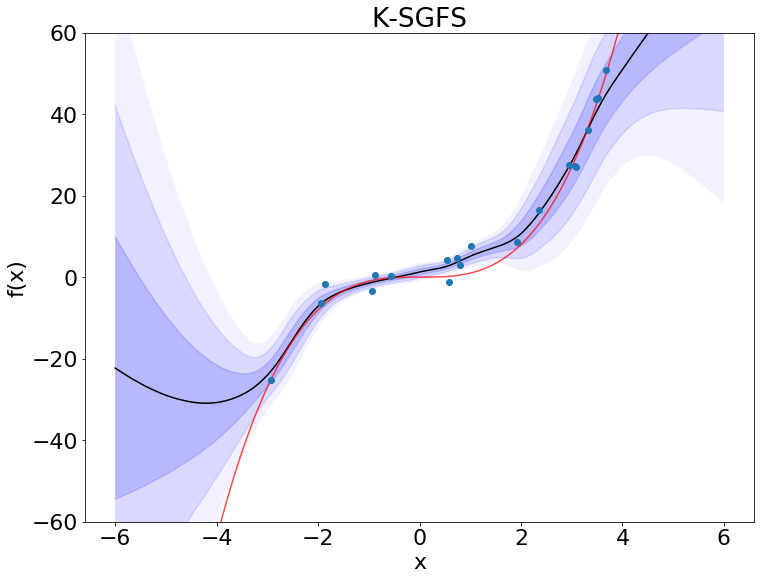

In [14]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.12)
plt.plot(grid,lower2,'blue',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid.squeeze(),lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-60,60)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('K-SGFS')

## Sinus (Louizos, Welling (2016))¶

20 data points simulated as follows:
- 12 samples $x_i$ from $\mathcal{U}(0,0.6)$ and 8 samples from $\mathcal{U}(0.8,1)$
- $y = x_i + \epsilon_i + \sin(4(x_i + \epsilon_i)) + \sin(13(x_i + \epsilon_i))$ with $\epsilon_i \sim \mathcal{N}(0,0.0009)$

See https://arxiv.org/pdf/1603.04733.pdf

In [5]:
np.random.seed(42)
torch.manual_seed(42)

# Create simulated data set
x1 = torch.empty(12, 1).uniform_(0, 0.6)
x2 = torch.empty(8, 1).uniform_(0.8, 1)

val_1 = torch.empty(12, 1).uniform_(0, 0.6)
val_2 = torch.empty(8, 1).uniform_(0.8, 1)

x,_ = torch.cat((x1,x2),0).sort(0)
val,_ = torch.cat((val_1,val_2),0).sort(0)

epsilon = torch.normal(torch.zeros_like(x),math.sqrt(0.0009))
epsilon_val = torch.normal(torch.zeros_like(val),math.sqrt(0.0009))
y = x + epsilon + torch.sin(4*(x + epsilon)) + torch.sin(13 * (x + epsilon))
val_label = val + epsilon + torch.sin(4*(val + epsilon)) + torch.sin(13 * (val + epsilon_val))

grid = np.linspace(-1,2,400)
y_true = (grid + np.sin(4 * grid) + np.sin(13 * grid)).reshape(-1,1)

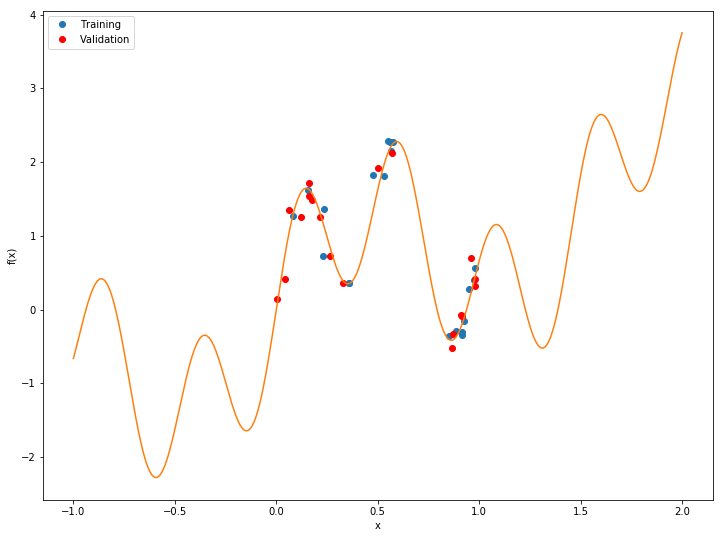

In [6]:
plt.figure(figsize=(12,9))
plt.plot(x.numpy(),y.numpy(),'o',label='Training')
plt.plot(val.numpy(),val_label.numpy(),'o',color='red',label='Validation')
plt.plot(grid, y_true)
plt.ylabel('f(x)')
plt.xlabel('x')
plt.legend()

### SGLD

In [5]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld


np.random.seed(42)
torch.manual_seed(42)



lambda_ = 1.
# learning_rates = [6e-6]
# learning_rates = [1e-6]
# learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [9e-6, 8e-6, 7e-6, 6e-6, 5e-6, 4e-6, 3e-6, 2e-6, 1e-6, 9e-7, 8e-7, 7e-7, 6e-7, 5e-7, 4e-7, 3e-7, 2e-7, 1e-7]
learning_rates = [6e-6]

batch_size = 20
dataset_size = 20

rmse_result = np.zeros((1,len(learning_rates)))

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# grid_search = True
grid_search = False


for i, lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    predictions = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1)
    t = 1.

    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1/(2*0.0009)) * criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions = torch.cat((predictions, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 22507.1953
Epoch 1 - loss: 44367.9258
Epoch 2 - loss: 20939.8223
Epoch 3 - loss: 29084.8652
Epoch 4 - loss: 23088.3828
Epoch 5 - loss: 10240.0576
Epoch 6 - loss: 9776.5137
Epoch 7 - loss: 9279.4102
Epoch 8 - loss: 9061.9072
Epoch 9 - loss: 8752.6914
Epoch 10 - loss: 9306.0010
Epoch 11 - loss: 10086.5381
Epoch 12 - loss: 14611.1953
Epoch 13 - loss: 9880.0820
Epoch 14 - loss: 9932.4990
Epoch 15 - loss: 7872.2202
Epoch 16 - loss: 7555.6514
Epoch 17 - loss: 7285.8501
Epoch 18 - loss: 7387.9795
Epoch 19 - loss: 7615.8149
Epoch 20 - loss: 9154.6553
Epoch 21 - loss: 9846.5381
Epoch 22 - loss: 11616.4678
Epoch 23 - loss: 7388.5908
Epoch 24 - loss: 6989.4561
Epoch 25 - loss: 6687.9375
Epoch 26 - loss: 6734.7085
Epoch 27 - loss: 6841.3740
Epoch 28 - loss: 7392.6982
Epoch 29 - loss: 7885.0557
Epoch 30 - loss: 9017.4883
Epoch 31 - loss: 7828.0947
Epoch 32 - loss: 7920.1826
Epoch 33 - loss: 7021.9468
Epoch 34 - loss: 7072.4204
Epoch 35 - loss: 6815.6406
Epoch 36 - loss: 6842.5088
Ep

Epoch 308 - loss: 2776.5837
Epoch 309 - loss: 2740.1797
Epoch 310 - loss: 2734.0977
Epoch 311 - loss: 2750.7405
Epoch 312 - loss: 2822.8726
Epoch 313 - loss: 3056.7725
Epoch 314 - loss: 3685.1316
Epoch 315 - loss: 5169.3140
Epoch 316 - loss: 8753.3008
Epoch 317 - loss: 13007.1797
Epoch 318 - loss: 12369.2363
Epoch 319 - loss: 7036.4624
Epoch 320 - loss: 7712.3335
Epoch 321 - loss: 5079.8286
Epoch 322 - loss: 4198.2939
Epoch 323 - loss: 3740.8743
Epoch 324 - loss: 3492.0059
Epoch 325 - loss: 3274.4470
Epoch 326 - loss: 3191.6716
Epoch 327 - loss: 3159.6228
Epoch 328 - loss: 3107.1177
Epoch 329 - loss: 3023.8447
Epoch 330 - loss: 2991.0718
Epoch 331 - loss: 2967.9312
Epoch 332 - loss: 2919.7109
Epoch 333 - loss: 2900.1477
Epoch 334 - loss: 2849.6807
Epoch 335 - loss: 2827.8223
Epoch 336 - loss: 2833.6150
Epoch 337 - loss: 2826.3735
Epoch 338 - loss: 2799.0818
Epoch 339 - loss: 2852.1899
Epoch 340 - loss: 2992.5278
Epoch 341 - loss: 3166.6987
Epoch 342 - loss: 3672.2102
Epoch 343 - loss: 

Epoch 643 - loss: 4432.3193
Epoch 644 - loss: 3921.6868
Epoch 645 - loss: 3798.3735
Epoch 646 - loss: 3039.1653
Epoch 647 - loss: 2712.1997
Epoch 648 - loss: 2849.2563
Epoch 649 - loss: 3090.9277
Epoch 650 - loss: 3813.8699
Epoch 651 - loss: 4702.0566
Epoch 652 - loss: 6036.7583
Epoch 653 - loss: 6400.7271
Epoch 654 - loss: 5592.6035
Epoch 655 - loss: 4241.3291
Epoch 656 - loss: 3491.8235
Epoch 657 - loss: 2894.3635
Epoch 658 - loss: 2766.1321
Epoch 659 - loss: 2539.5271
Epoch 660 - loss: 2452.2354
Epoch 661 - loss: 2405.5793
Epoch 662 - loss: 2402.5039
Epoch 663 - loss: 2359.1265
Epoch 664 - loss: 2355.0583
Epoch 665 - loss: 2316.5334
Epoch 666 - loss: 2275.6851
Epoch 667 - loss: 2250.6108
Epoch 668 - loss: 2249.6431
Epoch 669 - loss: 2239.4031
Epoch 670 - loss: 2230.3188
Epoch 671 - loss: 2221.2695
Epoch 672 - loss: 2220.9658
Epoch 673 - loss: 2243.4072
Epoch 674 - loss: 2306.2959
Epoch 675 - loss: 2428.8999
Epoch 676 - loss: 2859.3645
Epoch 677 - loss: 3862.4578
Epoch 678 - loss: 60

Epoch 982 - loss: 3664.9446
Epoch 983 - loss: 3325.3918
Epoch 984 - loss: 3092.4307
Epoch 985 - loss: 2715.8389
Epoch 986 - loss: 2557.3516
Epoch 987 - loss: 2408.0632
Epoch 988 - loss: 2255.8352
Epoch 989 - loss: 2254.4131
Epoch 990 - loss: 2228.9487
Epoch 991 - loss: 2279.0391
Epoch 992 - loss: 2347.9778
Epoch 993 - loss: 2768.3506
Epoch 994 - loss: 3096.2781
Epoch 995 - loss: 4468.7905
Epoch 996 - loss: 6359.1265
Epoch 997 - loss: 8192.8691
Epoch 998 - loss: 2769.0146
Epoch 999 - loss: 2147.9561
Epoch 1000 - loss: 2052.2715
Epoch 1001 - loss: 1981.7878
Epoch 1002 - loss: 1955.0603
Epoch 1003 - loss: 1958.7683
Epoch 1004 - loss: 1946.1951
Epoch 1005 - loss: 1961.0798
Epoch 1006 - loss: 1985.2141
Epoch 1007 - loss: 2108.2434
Epoch 1008 - loss: 2275.5107
Epoch 1009 - loss: 2737.4573
Epoch 1010 - loss: 3359.6626
Epoch 1011 - loss: 4519.1890
Epoch 1012 - loss: 5223.9307
Epoch 1013 - loss: 6676.0718
Epoch 1014 - loss: 5912.5952
Epoch 1015 - loss: 5649.1899
Epoch 1016 - loss: 4253.5356
Epo

Epoch 1303 - loss: 2847.3162
Epoch 1304 - loss: 2588.3210
Epoch 1305 - loss: 2348.9624
Epoch 1306 - loss: 2203.9448
Epoch 1307 - loss: 2079.4114
Epoch 1308 - loss: 1946.0891
Epoch 1309 - loss: 1734.6674
Epoch 1310 - loss: 1555.2650
Epoch 1311 - loss: 1484.0411
Epoch 1312 - loss: 1381.0004
Epoch 1313 - loss: 1296.3849
Epoch 1314 - loss: 1278.4375
Epoch 1315 - loss: 1302.5959
Epoch 1316 - loss: 1375.6979
Epoch 1317 - loss: 1350.5654
Epoch 1318 - loss: 1446.6521
Epoch 1319 - loss: 1661.5297
Epoch 1320 - loss: 2251.0820
Epoch 1321 - loss: 3015.7812
Epoch 1322 - loss: 4850.9448
Epoch 1323 - loss: 3695.8042
Epoch 1324 - loss: 3848.9722
Epoch 1325 - loss: 2288.5815
Epoch 1326 - loss: 1928.0433
Epoch 1327 - loss: 1717.1459
Epoch 1328 - loss: 1699.5648
Epoch 1329 - loss: 1637.7655
Epoch 1330 - loss: 1582.7150
Epoch 1331 - loss: 1489.5951
Epoch 1332 - loss: 1498.5919
Epoch 1333 - loss: 1472.4084
Epoch 1334 - loss: 1428.9695
Epoch 1335 - loss: 1494.9243
Epoch 1336 - loss: 1543.8595
Epoch 1337 - l

Epoch 1600 - loss: 2121.7800
Epoch 1601 - loss: 3153.5867
Epoch 1602 - loss: 4819.9824
Epoch 1603 - loss: 3468.5005
Epoch 1604 - loss: 2513.1770
Epoch 1605 - loss: 1327.1252
Epoch 1606 - loss: 1112.2281
Epoch 1607 - loss: 996.5643
Epoch 1608 - loss: 946.0798
Epoch 1609 - loss: 914.1633
Epoch 1610 - loss: 880.5629
Epoch 1611 - loss: 864.1476
Epoch 1612 - loss: 842.4002
Epoch 1613 - loss: 811.6740
Epoch 1614 - loss: 797.2142
Epoch 1615 - loss: 775.1159
Epoch 1616 - loss: 768.5293
Epoch 1617 - loss: 761.9518
Epoch 1618 - loss: 749.7010
Epoch 1619 - loss: 728.3111
Epoch 1620 - loss: 744.4158
Epoch 1621 - loss: 752.3532
Epoch 1622 - loss: 880.6294
Epoch 1623 - loss: 1043.9670
Epoch 1624 - loss: 1417.0265
Epoch 1625 - loss: 2010.8242
Epoch 1626 - loss: 3021.9248
Epoch 1627 - loss: 3717.6711
Epoch 1628 - loss: 3995.6401
Epoch 1629 - loss: 2551.7905
Epoch 1630 - loss: 1795.0625
Epoch 1631 - loss: 1257.1567
Epoch 1632 - loss: 1074.6488
Epoch 1633 - loss: 965.0154
Epoch 1634 - loss: 911.5375
Epo

Epoch 1894 - loss: 650.1942
Epoch 1895 - loss: 643.7015
Epoch 1896 - loss: 635.4448
Epoch 1897 - loss: 692.1851
Epoch 1898 - loss: 785.1104
Epoch 1899 - loss: 934.1833
Epoch 1900 - loss: 1113.7234
Epoch 1901 - loss: 1310.1704
Epoch 1902 - loss: 1421.6991
Epoch 1903 - loss: 1460.8210
Epoch 1904 - loss: 1418.4574
Epoch 1905 - loss: 1352.4349
Epoch 1906 - loss: 1205.0847
Epoch 1907 - loss: 1056.3970
Epoch 1908 - loss: 974.1819
Epoch 1909 - loss: 801.6139
Epoch 1910 - loss: 718.5626
Epoch 1911 - loss: 662.0082
Epoch 1912 - loss: 624.1835
Epoch 1913 - loss: 612.0118
Epoch 1914 - loss: 615.8547
Epoch 1915 - loss: 631.2836
Epoch 1916 - loss: 654.1553
Epoch 1917 - loss: 639.3753
Epoch 1918 - loss: 674.9134
Epoch 1919 - loss: 820.8405
Epoch 1920 - loss: 942.1290
Epoch 1921 - loss: 1226.7363
Epoch 1922 - loss: 1372.8962
Epoch 1923 - loss: 1634.3682
Epoch 1924 - loss: 1714.9183
Epoch 1925 - loss: 1568.8297
Epoch 1926 - loss: 1278.9038
Epoch 1927 - loss: 1182.2142
Epoch 1928 - loss: 1202.7881
Epoc

Epoch 2224 - loss: 857.9142
Epoch 2225 - loss: 969.0110
Epoch 2226 - loss: 1196.9922
Epoch 2227 - loss: 1322.8630
Epoch 2228 - loss: 1602.8909
Epoch 2229 - loss: 1704.2855
Epoch 2230 - loss: 1763.5238
Epoch 2231 - loss: 1509.8469
Epoch 2232 - loss: 1465.3749
Epoch 2233 - loss: 1127.1802
Epoch 2234 - loss: 986.9330
Epoch 2235 - loss: 835.0035
Epoch 2236 - loss: 753.1639
Epoch 2237 - loss: 646.8152
Epoch 2238 - loss: 562.3097
Epoch 2239 - loss: 518.3579
Epoch 2240 - loss: 473.1974
Epoch 2241 - loss: 457.0814
Epoch 2242 - loss: 438.9362
Epoch 2243 - loss: 426.6471
Epoch 2244 - loss: 423.9493
Epoch 2245 - loss: 426.2926
Epoch 2246 - loss: 420.3067
Epoch 2247 - loss: 417.7643
Epoch 2248 - loss: 411.7704
Epoch 2249 - loss: 429.5091
Epoch 2250 - loss: 469.6999
Epoch 2251 - loss: 492.0772
Epoch 2252 - loss: 622.1757
Epoch 2253 - loss: 885.0382
Epoch 2254 - loss: 1369.1500
Epoch 2255 - loss: 2486.1553
Epoch 2256 - loss: 3541.8176
Epoch 2257 - loss: 3106.3770
Epoch 2258 - loss: 1719.0934
Epoch 2

Epoch 2525 - loss: 602.6778
Epoch 2526 - loss: 560.9222
Epoch 2527 - loss: 575.2183
Epoch 2528 - loss: 613.4648
Epoch 2529 - loss: 642.4297
Epoch 2530 - loss: 630.8386
Epoch 2531 - loss: 625.7172
Epoch 2532 - loss: 580.3822
Epoch 2533 - loss: 626.9719
Epoch 2534 - loss: 633.4460
Epoch 2535 - loss: 737.6007
Epoch 2536 - loss: 770.4235
Epoch 2537 - loss: 852.6730
Epoch 2538 - loss: 877.1069
Epoch 2539 - loss: 941.1912
Epoch 2540 - loss: 1009.8465
Epoch 2541 - loss: 893.9756
Epoch 2542 - loss: 789.7732
Epoch 2543 - loss: 797.9882
Epoch 2544 - loss: 836.4086
Epoch 2545 - loss: 721.4460
Epoch 2546 - loss: 667.2904
Epoch 2547 - loss: 677.2984
Epoch 2548 - loss: 712.4666
Epoch 2549 - loss: 684.0938
Epoch 2550 - loss: 681.6726
Epoch 2551 - loss: 740.7749
Epoch 2552 - loss: 726.7263
Epoch 2553 - loss: 687.0571
Epoch 2554 - loss: 661.5486
Epoch 2555 - loss: 681.3591
Epoch 2556 - loss: 685.8790
Epoch 2557 - loss: 658.9050
Epoch 2558 - loss: 713.5743
Epoch 2559 - loss: 649.3248
Epoch 2560 - loss: 

Epoch 2820 - loss: 749.9362
Epoch 2821 - loss: 675.3800
Epoch 2822 - loss: 621.2826
Epoch 2823 - loss: 576.6298
Epoch 2824 - loss: 574.0986
Epoch 2825 - loss: 540.6823
Epoch 2826 - loss: 497.0815
Epoch 2827 - loss: 496.0709
Epoch 2828 - loss: 480.5881
Epoch 2829 - loss: 477.7813
Epoch 2830 - loss: 533.1570
Epoch 2831 - loss: 557.0373
Epoch 2832 - loss: 514.8871
Epoch 2833 - loss: 549.2534
Epoch 2834 - loss: 572.1438
Epoch 2835 - loss: 596.9452
Epoch 2836 - loss: 623.9754
Epoch 2837 - loss: 604.8371
Epoch 2838 - loss: 574.2024
Epoch 2839 - loss: 581.4046
Epoch 2840 - loss: 595.4393
Epoch 2841 - loss: 619.7995
Epoch 2842 - loss: 675.3303
Epoch 2843 - loss: 765.4996
Epoch 2844 - loss: 828.7811
Epoch 2845 - loss: 829.0409
Epoch 2846 - loss: 835.7164
Epoch 2847 - loss: 890.9635
Epoch 2848 - loss: 914.8641
Epoch 2849 - loss: 858.9156
Epoch 2850 - loss: 842.2886
Epoch 2851 - loss: 698.7991
Epoch 2852 - loss: 660.6711
Epoch 2853 - loss: 696.8907
Epoch 2854 - loss: 792.8568
Epoch 2855 - loss: 7

Epoch 3161 - loss: 321.5245
Epoch 3162 - loss: 321.2247
Epoch 3163 - loss: 322.1494
Epoch 3164 - loss: 320.9183
Epoch 3165 - loss: 320.2850
Epoch 3166 - loss: 321.3348
Epoch 3167 - loss: 322.0175
Epoch 3168 - loss: 322.4822
Epoch 3169 - loss: 321.9203
Epoch 3170 - loss: 321.3401
Epoch 3171 - loss: 320.5759
Epoch 3172 - loss: 320.4048
Epoch 3173 - loss: 320.9497
Epoch 3174 - loss: 324.0439
Epoch 3175 - loss: 323.9244
Epoch 3176 - loss: 322.8560
Epoch 3177 - loss: 322.1948
Epoch 3178 - loss: 322.3331
Epoch 3179 - loss: 321.5561
Epoch 3180 - loss: 322.3835
Epoch 3181 - loss: 327.2734
Epoch 3182 - loss: 330.3018
Epoch 3183 - loss: 324.6538
Epoch 3184 - loss: 320.4784
Epoch 3185 - loss: 320.7812
Epoch 3186 - loss: 321.0511
Epoch 3187 - loss: 319.3757
Epoch 3188 - loss: 322.0281
Epoch 3189 - loss: 323.0683
Epoch 3190 - loss: 326.6422
Epoch 3191 - loss: 322.0110
Epoch 3192 - loss: 325.6220
Epoch 3193 - loss: 329.1046
Epoch 3194 - loss: 325.5644
Epoch 3195 - loss: 325.9174
Epoch 3196 - loss: 3

Epoch 3497 - loss: 304.8044
Epoch 3498 - loss: 316.1158
Epoch 3499 - loss: 324.7366
Epoch 3500 - loss: 330.2204
Epoch 3501 - loss: 350.0407
Epoch 3502 - loss: 348.8154
Epoch 3503 - loss: 331.3090
Epoch 3504 - loss: 335.0647
Epoch 3505 - loss: 334.9688
Epoch 3506 - loss: 310.3471
Epoch 3507 - loss: 308.0210
Epoch 3508 - loss: 308.6276
Epoch 3509 - loss: 296.5614
Epoch 3510 - loss: 296.0752
Epoch 3511 - loss: 296.6174
Epoch 3512 - loss: 298.9687
Epoch 3513 - loss: 294.7656
Epoch 3514 - loss: 293.1442
Epoch 3515 - loss: 294.7147
Epoch 3516 - loss: 298.4578
Epoch 3517 - loss: 308.5344
Epoch 3518 - loss: 318.0314
Epoch 3519 - loss: 325.7483
Epoch 3520 - loss: 322.5051
Epoch 3521 - loss: 309.2837
Epoch 3522 - loss: 304.9388
Epoch 3523 - loss: 308.8119
Epoch 3524 - loss: 302.3048
Epoch 3525 - loss: 309.5766
Epoch 3526 - loss: 308.5427
Epoch 3527 - loss: 304.8617
Epoch 3528 - loss: 300.4592
Epoch 3529 - loss: 307.7590
Epoch 3530 - loss: 300.8692
Epoch 3531 - loss: 299.6870
Epoch 3532 - loss: 3

Epoch 3798 - loss: 387.5382
Epoch 3799 - loss: 379.8906
Epoch 3800 - loss: 351.3716
Epoch 3801 - loss: 369.9353
Epoch 3802 - loss: 378.1033
Epoch 3803 - loss: 376.2786
Epoch 3804 - loss: 411.6309
Epoch 3805 - loss: 422.8649
Epoch 3806 - loss: 443.3303
Epoch 3807 - loss: 440.8296
Epoch 3808 - loss: 462.1504
Epoch 3809 - loss: 456.6337
Epoch 3810 - loss: 458.6560
Epoch 3811 - loss: 486.9586
Epoch 3812 - loss: 468.3963
Epoch 3813 - loss: 415.9408
Epoch 3814 - loss: 420.9321
Epoch 3815 - loss: 409.0631
Epoch 3816 - loss: 396.2205
Epoch 3817 - loss: 364.8237
Epoch 3818 - loss: 412.8902
Epoch 3819 - loss: 428.1911
Epoch 3820 - loss: 407.4713
Epoch 3821 - loss: 410.2794
Epoch 3822 - loss: 394.2354
Epoch 3823 - loss: 387.5631
Epoch 3824 - loss: 401.7072
Epoch 3825 - loss: 447.9665
Epoch 3826 - loss: 452.3458
Epoch 3827 - loss: 389.7549
Epoch 3828 - loss: 362.9663
Epoch 3829 - loss: 331.9091
Epoch 3830 - loss: 321.0858
Epoch 3831 - loss: 320.3532
Epoch 3832 - loss: 319.7014
Epoch 3833 - loss: 3

Epoch 4139 - loss: 329.4413
Epoch 4140 - loss: 334.3577
Epoch 4141 - loss: 330.8893
Epoch 4142 - loss: 376.3387
Epoch 4143 - loss: 357.1156
Epoch 4144 - loss: 354.2552
Epoch 4145 - loss: 349.0105
Epoch 4146 - loss: 364.2735
Epoch 4147 - loss: 378.2342
Epoch 4148 - loss: 395.7924
Epoch 4149 - loss: 455.7084
Epoch 4150 - loss: 481.4668
Epoch 4151 - loss: 514.2109
Epoch 4152 - loss: 530.0789
Epoch 4153 - loss: 503.8695
Epoch 4154 - loss: 508.8496
Epoch 4155 - loss: 538.6025
Epoch 4156 - loss: 611.3262
Epoch 4157 - loss: 572.9937
Epoch 4158 - loss: 660.6353
Epoch 4159 - loss: 660.5633
Epoch 4160 - loss: 622.0361
Epoch 4161 - loss: 600.9860
Epoch 4162 - loss: 585.7985
Epoch 4163 - loss: 599.0740
Epoch 4164 - loss: 580.2692
Epoch 4165 - loss: 515.7152
Epoch 4166 - loss: 470.8332
Epoch 4167 - loss: 463.8448
Epoch 4168 - loss: 457.4632
Epoch 4169 - loss: 468.4528
Epoch 4170 - loss: 418.5225
Epoch 4171 - loss: 384.2133
Epoch 4172 - loss: 355.2301
Epoch 4173 - loss: 347.8118
Epoch 4174 - loss: 3

Epoch 4446 - loss: 406.6184
Epoch 4447 - loss: 450.4180
Epoch 4448 - loss: 454.0145
Epoch 4449 - loss: 454.2075
Epoch 4450 - loss: 497.6240
Epoch 4451 - loss: 487.4989
Epoch 4452 - loss: 460.3448
Epoch 4453 - loss: 402.8480
Epoch 4454 - loss: 403.7347
Epoch 4455 - loss: 392.7353
Epoch 4456 - loss: 375.9110
Epoch 4457 - loss: 364.4777
Epoch 4458 - loss: 361.8017
Epoch 4459 - loss: 385.1761
Epoch 4460 - loss: 333.0052
Epoch 4461 - loss: 330.9434
Epoch 4462 - loss: 334.2635
Epoch 4463 - loss: 323.7779
Epoch 4464 - loss: 322.1658
Epoch 4465 - loss: 325.0242
Epoch 4466 - loss: 318.6330
Epoch 4467 - loss: 312.3825
Epoch 4468 - loss: 306.4168
Epoch 4469 - loss: 318.9259
Epoch 4470 - loss: 316.6631
Epoch 4471 - loss: 305.5662
Epoch 4472 - loss: 303.0443
Epoch 4473 - loss: 307.5710
Epoch 4474 - loss: 310.6395
Epoch 4475 - loss: 301.2628
Epoch 4476 - loss: 296.9180
Epoch 4477 - loss: 298.5570
Epoch 4478 - loss: 310.2697
Epoch 4479 - loss: 306.8704
Epoch 4480 - loss: 297.3455
Epoch 4481 - loss: 2

Epoch 4817 - loss: 296.7849
Epoch 4818 - loss: 297.8630
Epoch 4819 - loss: 299.7750
Epoch 4820 - loss: 296.1358
Epoch 4821 - loss: 293.6549
Epoch 4822 - loss: 312.8032
Epoch 4823 - loss: 309.8799
Epoch 4824 - loss: 309.0773
Epoch 4825 - loss: 314.6621
Epoch 4826 - loss: 342.8990
Epoch 4827 - loss: 326.8419
Epoch 4828 - loss: 317.3118
Epoch 4829 - loss: 337.3554
Epoch 4830 - loss: 333.3876
Epoch 4831 - loss: 350.6900
Epoch 4832 - loss: 371.2334
Epoch 4833 - loss: 408.5912
Epoch 4834 - loss: 433.2432
Epoch 4835 - loss: 472.0772
Epoch 4836 - loss: 529.2029
Epoch 4837 - loss: 604.2981
Epoch 4838 - loss: 635.2303
Epoch 4839 - loss: 638.8173
Epoch 4840 - loss: 638.0896
Epoch 4841 - loss: 662.9489
Epoch 4842 - loss: 641.0209
Epoch 4843 - loss: 635.7452
Epoch 4844 - loss: 611.8301
Epoch 4845 - loss: 592.1097
Epoch 4846 - loss: 553.5695
Epoch 4847 - loss: 582.9440
Epoch 4848 - loss: 556.0958
Epoch 4849 - loss: 493.5557
Epoch 4850 - loss: 479.3027
Epoch 4851 - loss: 488.2003
Epoch 4852 - loss: 4

Epoch 5125 - loss: 399.9681
Epoch 5126 - loss: 377.1486
Epoch 5127 - loss: 378.7372
Epoch 5128 - loss: 354.4694
Epoch 5129 - loss: 361.4136
Epoch 5130 - loss: 331.0800
Epoch 5131 - loss: 311.9819
Epoch 5132 - loss: 332.1153
Epoch 5133 - loss: 314.5741
Epoch 5134 - loss: 336.5644
Epoch 5135 - loss: 376.3694
Epoch 5136 - loss: 388.1743
Epoch 5137 - loss: 433.2514
Epoch 5138 - loss: 444.6264
Epoch 5139 - loss: 386.0051
Epoch 5140 - loss: 396.5290
Epoch 5141 - loss: 424.9109
Epoch 5142 - loss: 442.6724
Epoch 5143 - loss: 476.4268
Epoch 5144 - loss: 522.0230
Epoch 5145 - loss: 557.6146
Epoch 5146 - loss: 548.8090
Epoch 5147 - loss: 547.9523
Epoch 5148 - loss: 515.3275
Epoch 5149 - loss: 548.5422
Epoch 5150 - loss: 508.0893
Epoch 5151 - loss: 546.3129
Epoch 5152 - loss: 530.1624
Epoch 5153 - loss: 546.3654
Epoch 5154 - loss: 557.2244
Epoch 5155 - loss: 549.7895
Epoch 5156 - loss: 520.4796
Epoch 5157 - loss: 489.2238
Epoch 5158 - loss: 473.6044
Epoch 5159 - loss: 469.1559
Epoch 5160 - loss: 4

Epoch 5425 - loss: 473.4157
Epoch 5426 - loss: 408.4696
Epoch 5427 - loss: 407.9202
Epoch 5428 - loss: 385.5773
Epoch 5429 - loss: 375.1978
Epoch 5430 - loss: 381.8683
Epoch 5431 - loss: 374.1726
Epoch 5432 - loss: 391.9462
Epoch 5433 - loss: 383.8774
Epoch 5434 - loss: 337.0278
Epoch 5435 - loss: 329.0554
Epoch 5436 - loss: 320.8361
Epoch 5437 - loss: 330.4495
Epoch 5438 - loss: 322.0951
Epoch 5439 - loss: 312.5033
Epoch 5440 - loss: 317.6183
Epoch 5441 - loss: 322.9591
Epoch 5442 - loss: 318.7921
Epoch 5443 - loss: 318.2882
Epoch 5444 - loss: 304.2808
Epoch 5445 - loss: 290.1960
Epoch 5446 - loss: 293.6629
Epoch 5447 - loss: 302.4049
Epoch 5448 - loss: 311.3634
Epoch 5449 - loss: 308.5064
Epoch 5450 - loss: 295.0872
Epoch 5451 - loss: 320.8588
Epoch 5452 - loss: 319.1845
Epoch 5453 - loss: 325.6752
Epoch 5454 - loss: 340.7038
Epoch 5455 - loss: 342.5786
Epoch 5456 - loss: 352.5318
Epoch 5457 - loss: 381.8528
Epoch 5458 - loss: 393.4955
Epoch 5459 - loss: 418.1713
Epoch 5460 - loss: 4

Epoch 5720 - loss: 824.6779
Epoch 5721 - loss: 853.9523
Epoch 5722 - loss: 902.0527
Epoch 5723 - loss: 916.0946
Epoch 5724 - loss: 840.1117
Epoch 5725 - loss: 720.7326
Epoch 5726 - loss: 650.8401
Epoch 5727 - loss: 548.8750
Epoch 5728 - loss: 496.1559
Epoch 5729 - loss: 444.6081
Epoch 5730 - loss: 423.1068
Epoch 5731 - loss: 390.2706
Epoch 5732 - loss: 400.7061
Epoch 5733 - loss: 387.0918
Epoch 5734 - loss: 405.1259
Epoch 5735 - loss: 427.5966
Epoch 5736 - loss: 413.0409
Epoch 5737 - loss: 379.3158
Epoch 5738 - loss: 356.2147
Epoch 5739 - loss: 364.4404
Epoch 5740 - loss: 374.8011
Epoch 5741 - loss: 356.3073
Epoch 5742 - loss: 379.7372
Epoch 5743 - loss: 374.1792
Epoch 5744 - loss: 387.5598
Epoch 5745 - loss: 382.0931
Epoch 5746 - loss: 393.3340
Epoch 5747 - loss: 378.9034
Epoch 5748 - loss: 382.3662
Epoch 5749 - loss: 402.1859
Epoch 5750 - loss: 408.9300
Epoch 5751 - loss: 394.9112
Epoch 5752 - loss: 373.5439
Epoch 5753 - loss: 355.4342
Epoch 5754 - loss: 344.4790
Epoch 5755 - loss: 3

Epoch 6013 - loss: 283.4147
Epoch 6014 - loss: 281.9714
Epoch 6015 - loss: 280.5344
Epoch 6016 - loss: 280.8855
Epoch 6017 - loss: 279.8306
Epoch 6018 - loss: 278.8608
Epoch 6019 - loss: 279.1834
Epoch 6020 - loss: 278.9758
Epoch 6021 - loss: 279.3399
Epoch 6022 - loss: 280.0106
Epoch 6023 - loss: 283.9175
Epoch 6024 - loss: 280.6583
Epoch 6025 - loss: 281.2387
Epoch 6026 - loss: 278.9354
Epoch 6027 - loss: 278.7164
Epoch 6028 - loss: 276.9224
Epoch 6029 - loss: 277.5511
Epoch 6030 - loss: 278.3994
Epoch 6031 - loss: 278.3052
Epoch 6032 - loss: 277.9162
Epoch 6033 - loss: 281.9308
Epoch 6034 - loss: 277.2329
Epoch 6035 - loss: 278.3519
Epoch 6036 - loss: 278.0948
Epoch 6037 - loss: 278.0109
Epoch 6038 - loss: 280.0854
Epoch 6039 - loss: 278.9154
Epoch 6040 - loss: 276.8149
Epoch 6041 - loss: 279.1718
Epoch 6042 - loss: 276.5285
Epoch 6043 - loss: 277.2072
Epoch 6044 - loss: 276.2368
Epoch 6045 - loss: 276.7303
Epoch 6046 - loss: 275.8311
Epoch 6047 - loss: 276.4269
Epoch 6048 - loss: 2

Epoch 6318 - loss: 266.3710
Epoch 6319 - loss: 264.7357
Epoch 6320 - loss: 265.9762
Epoch 6321 - loss: 266.2083
Epoch 6322 - loss: 265.1226
Epoch 6323 - loss: 265.5112
Epoch 6324 - loss: 264.1026
Epoch 6325 - loss: 265.0438
Epoch 6326 - loss: 265.5792
Epoch 6327 - loss: 265.7928
Epoch 6328 - loss: 265.6251
Epoch 6329 - loss: 266.0227
Epoch 6330 - loss: 267.4493
Epoch 6331 - loss: 265.6785
Epoch 6332 - loss: 265.8918
Epoch 6333 - loss: 268.1283
Epoch 6334 - loss: 266.9485
Epoch 6335 - loss: 267.1442
Epoch 6336 - loss: 265.8711
Epoch 6337 - loss: 267.4303
Epoch 6338 - loss: 267.1059
Epoch 6339 - loss: 266.4694
Epoch 6340 - loss: 268.8362
Epoch 6341 - loss: 265.7487
Epoch 6342 - loss: 267.5632
Epoch 6343 - loss: 268.1383
Epoch 6344 - loss: 267.1085
Epoch 6345 - loss: 267.4820
Epoch 6346 - loss: 268.9210
Epoch 6347 - loss: 269.9296
Epoch 6348 - loss: 269.5472
Epoch 6349 - loss: 266.9044
Epoch 6350 - loss: 268.2475
Epoch 6351 - loss: 267.0312
Epoch 6352 - loss: 267.0296
Epoch 6353 - loss: 2

Epoch 6639 - loss: 267.0908
Epoch 6640 - loss: 264.8984
Epoch 6641 - loss: 263.0921
Epoch 6642 - loss: 265.7124
Epoch 6643 - loss: 266.5305
Epoch 6644 - loss: 267.4048
Epoch 6645 - loss: 266.5690
Epoch 6646 - loss: 264.4683
Epoch 6647 - loss: 264.6334
Epoch 6648 - loss: 265.4436
Epoch 6649 - loss: 266.6559
Epoch 6650 - loss: 267.4335
Epoch 6651 - loss: 264.7457
Epoch 6652 - loss: 264.6648
Epoch 6653 - loss: 263.1311
Epoch 6654 - loss: 262.3773
Epoch 6655 - loss: 261.9249
Epoch 6656 - loss: 261.9821
Epoch 6657 - loss: 261.7421
Epoch 6658 - loss: 261.9846
Epoch 6659 - loss: 264.0341
Epoch 6660 - loss: 262.4916
Epoch 6661 - loss: 261.9094
Epoch 6662 - loss: 263.2687
Epoch 6663 - loss: 263.9363
Epoch 6664 - loss: 261.8542
Epoch 6665 - loss: 263.9356
Epoch 6666 - loss: 262.9441
Epoch 6667 - loss: 265.0553
Epoch 6668 - loss: 262.8983
Epoch 6669 - loss: 260.6960
Epoch 6670 - loss: 261.4619
Epoch 6671 - loss: 262.4845
Epoch 6672 - loss: 264.5975
Epoch 6673 - loss: 264.7032
Epoch 6674 - loss: 2

Epoch 6946 - loss: 260.5379
Epoch 6947 - loss: 261.2758
Epoch 6948 - loss: 263.2140
Epoch 6949 - loss: 258.2065
Epoch 6950 - loss: 256.7338
Epoch 6951 - loss: 257.3337
Epoch 6952 - loss: 258.1785
Epoch 6953 - loss: 257.7108
Epoch 6954 - loss: 257.5622
Epoch 6955 - loss: 258.5486
Epoch 6956 - loss: 258.8802
Epoch 6957 - loss: 258.5292
Epoch 6958 - loss: 258.5024
Epoch 6959 - loss: 257.7887
Epoch 6960 - loss: 258.7260
Epoch 6961 - loss: 259.4794
Epoch 6962 - loss: 261.2379
Epoch 6963 - loss: 258.9951
Epoch 6964 - loss: 257.3493
Epoch 6965 - loss: 257.9899
Epoch 6966 - loss: 262.2802
Epoch 6967 - loss: 256.3409
Epoch 6968 - loss: 257.5249
Epoch 6969 - loss: 256.8891
Epoch 6970 - loss: 261.2186
Epoch 6971 - loss: 256.7261
Epoch 6972 - loss: 255.8658
Epoch 6973 - loss: 256.0165
Epoch 6974 - loss: 257.2954
Epoch 6975 - loss: 258.8089
Epoch 6976 - loss: 257.7392
Epoch 6977 - loss: 259.1524
Epoch 6978 - loss: 256.0709
Epoch 6979 - loss: 255.4482
Epoch 6980 - loss: 255.1880
Epoch 6981 - loss: 2

Epoch 7241 - loss: 253.3235
Epoch 7242 - loss: 253.4873
Epoch 7243 - loss: 254.8350
Epoch 7244 - loss: 251.8474
Epoch 7245 - loss: 251.9882
Epoch 7246 - loss: 252.8953
Epoch 7247 - loss: 256.5274
Epoch 7248 - loss: 252.2548
Epoch 7249 - loss: 253.1257
Epoch 7250 - loss: 255.6833
Epoch 7251 - loss: 253.7704
Epoch 7252 - loss: 254.8636
Epoch 7253 - loss: 254.6994
Epoch 7254 - loss: 258.8015
Epoch 7255 - loss: 258.4022
Epoch 7256 - loss: 254.4913
Epoch 7257 - loss: 254.8321
Epoch 7258 - loss: 258.0537
Epoch 7259 - loss: 255.2161
Epoch 7260 - loss: 253.5835
Epoch 7261 - loss: 253.5303
Epoch 7262 - loss: 254.5013
Epoch 7263 - loss: 257.5005
Epoch 7264 - loss: 253.7020
Epoch 7265 - loss: 255.4984
Epoch 7266 - loss: 257.9051
Epoch 7267 - loss: 254.1097
Epoch 7268 - loss: 255.5353
Epoch 7269 - loss: 255.5467
Epoch 7270 - loss: 254.7523
Epoch 7271 - loss: 260.9149
Epoch 7272 - loss: 258.7614
Epoch 7273 - loss: 259.2888
Epoch 7274 - loss: 253.5042
Epoch 7275 - loss: 254.2816
Epoch 7276 - loss: 2

Epoch 7536 - loss: 252.7683
Epoch 7537 - loss: 257.0690
Epoch 7538 - loss: 255.2813
Epoch 7539 - loss: 254.7628
Epoch 7540 - loss: 257.7756
Epoch 7541 - loss: 260.9105
Epoch 7542 - loss: 257.8638
Epoch 7543 - loss: 258.2415
Epoch 7544 - loss: 253.8514
Epoch 7545 - loss: 252.7544
Epoch 7546 - loss: 253.0036
Epoch 7547 - loss: 253.0326
Epoch 7548 - loss: 254.5864
Epoch 7549 - loss: 254.2979
Epoch 7550 - loss: 258.3251
Epoch 7551 - loss: 256.4095
Epoch 7552 - loss: 266.2664
Epoch 7553 - loss: 258.5149
Epoch 7554 - loss: 251.8931
Epoch 7555 - loss: 256.2133
Epoch 7556 - loss: 256.5720
Epoch 7557 - loss: 255.3242
Epoch 7558 - loss: 252.7182
Epoch 7559 - loss: 252.8819
Epoch 7560 - loss: 252.6388
Epoch 7561 - loss: 256.0385
Epoch 7562 - loss: 252.3833
Epoch 7563 - loss: 251.4928
Epoch 7564 - loss: 251.4743
Epoch 7565 - loss: 249.7490
Epoch 7566 - loss: 250.4820
Epoch 7567 - loss: 249.4438
Epoch 7568 - loss: 249.9871
Epoch 7569 - loss: 253.6819
Epoch 7570 - loss: 250.5183
Epoch 7571 - loss: 2

Epoch 7856 - loss: 261.1812
Epoch 7857 - loss: 270.7576
Epoch 7858 - loss: 252.9388
Epoch 7859 - loss: 250.7585
Epoch 7860 - loss: 255.2880
Epoch 7861 - loss: 249.2614
Epoch 7862 - loss: 248.8821
Epoch 7863 - loss: 247.8790
Epoch 7864 - loss: 249.7689
Epoch 7865 - loss: 251.4976
Epoch 7866 - loss: 252.3638
Epoch 7867 - loss: 250.9678
Epoch 7868 - loss: 250.3390
Epoch 7869 - loss: 251.3991
Epoch 7870 - loss: 249.6189
Epoch 7871 - loss: 248.9245
Epoch 7872 - loss: 252.8391
Epoch 7873 - loss: 249.5386
Epoch 7874 - loss: 249.2669
Epoch 7875 - loss: 249.0844
Epoch 7876 - loss: 249.2311
Epoch 7877 - loss: 255.1164
Epoch 7878 - loss: 250.6091
Epoch 7879 - loss: 252.5592
Epoch 7880 - loss: 255.2063
Epoch 7881 - loss: 252.6320
Epoch 7882 - loss: 247.9190
Epoch 7883 - loss: 251.1523
Epoch 7884 - loss: 256.4173
Epoch 7885 - loss: 258.1522
Epoch 7886 - loss: 257.7262
Epoch 7887 - loss: 250.8706
Epoch 7888 - loss: 261.7416
Epoch 7889 - loss: 252.3080
Epoch 7890 - loss: 251.2757
Epoch 7891 - loss: 2

Epoch 8171 - loss: 265.4134
Epoch 8172 - loss: 300.4666
Epoch 8173 - loss: 323.2158
Epoch 8174 - loss: 316.3217
Epoch 8175 - loss: 299.1109
Epoch 8176 - loss: 309.9460
Epoch 8177 - loss: 319.4955
Epoch 8178 - loss: 302.8671
Epoch 8179 - loss: 307.8216
Epoch 8180 - loss: 305.6441
Epoch 8181 - loss: 322.6609
Epoch 8182 - loss: 346.6606
Epoch 8183 - loss: 320.6081
Epoch 8184 - loss: 323.0687
Epoch 8185 - loss: 314.6157
Epoch 8186 - loss: 293.0746
Epoch 8187 - loss: 299.7401
Epoch 8188 - loss: 322.4595
Epoch 8189 - loss: 299.5376
Epoch 8190 - loss: 298.5668
Epoch 8191 - loss: 277.6449
Epoch 8192 - loss: 264.8926
Epoch 8193 - loss: 262.4297
Epoch 8194 - loss: 264.7619
Epoch 8195 - loss: 261.8990
Epoch 8196 - loss: 266.0886
Epoch 8197 - loss: 260.6388
Epoch 8198 - loss: 262.9449
Epoch 8199 - loss: 257.1490
Epoch 8200 - loss: 263.8806
Epoch 8201 - loss: 253.6776
Epoch 8202 - loss: 259.8564
Epoch 8203 - loss: 259.1828
Epoch 8204 - loss: 254.4295
Epoch 8205 - loss: 259.1196
Epoch 8206 - loss: 2

Epoch 8525 - loss: 246.1857
Epoch 8526 - loss: 254.3435
Epoch 8527 - loss: 247.4072
Epoch 8528 - loss: 244.8297
Epoch 8529 - loss: 247.5738
Epoch 8530 - loss: 251.9656
Epoch 8531 - loss: 250.1104
Epoch 8532 - loss: 252.6921
Epoch 8533 - loss: 254.3527
Epoch 8534 - loss: 255.9091
Epoch 8535 - loss: 269.7149
Epoch 8536 - loss: 261.1852
Epoch 8537 - loss: 251.6369
Epoch 8538 - loss: 254.5322
Epoch 8539 - loss: 247.8456
Epoch 8540 - loss: 245.9030
Epoch 8541 - loss: 243.4105
Epoch 8542 - loss: 247.6104
Epoch 8543 - loss: 244.7151
Epoch 8544 - loss: 240.2049
Epoch 8545 - loss: 237.6357
Epoch 8546 - loss: 237.0053
Epoch 8547 - loss: 237.9955
Epoch 8548 - loss: 238.4232
Epoch 8549 - loss: 240.6761
Epoch 8550 - loss: 240.9810
Epoch 8551 - loss: 242.6391
Epoch 8552 - loss: 246.0382
Epoch 8553 - loss: 243.3953
Epoch 8554 - loss: 248.8720
Epoch 8555 - loss: 251.4547
Epoch 8556 - loss: 246.9878
Epoch 8557 - loss: 244.7050
Epoch 8558 - loss: 246.6564
Epoch 8559 - loss: 251.2321
Epoch 8560 - loss: 2

Epoch 8883 - loss: 249.2693
Epoch 8884 - loss: 253.6166
Epoch 8885 - loss: 257.2826
Epoch 8886 - loss: 265.4326
Epoch 8887 - loss: 255.6040
Epoch 8888 - loss: 243.2518
Epoch 8889 - loss: 250.0728
Epoch 8890 - loss: 243.6233
Epoch 8891 - loss: 234.3755
Epoch 8892 - loss: 232.4474
Epoch 8893 - loss: 233.1612
Epoch 8894 - loss: 233.4366
Epoch 8895 - loss: 235.9008
Epoch 8896 - loss: 237.9100
Epoch 8897 - loss: 233.4714
Epoch 8898 - loss: 235.2456
Epoch 8899 - loss: 239.0647
Epoch 8900 - loss: 239.6996
Epoch 8901 - loss: 237.2889
Epoch 8902 - loss: 236.6290
Epoch 8903 - loss: 241.1984
Epoch 8904 - loss: 247.7294
Epoch 8905 - loss: 244.1437
Epoch 8906 - loss: 248.9028
Epoch 8907 - loss: 264.2391
Epoch 8908 - loss: 272.4550
Epoch 8909 - loss: 260.4016
Epoch 8910 - loss: 293.7983
Epoch 8911 - loss: 292.5251
Epoch 8912 - loss: 283.6365
Epoch 8913 - loss: 284.0182
Epoch 8914 - loss: 297.8046
Epoch 8915 - loss: 316.7632
Epoch 8916 - loss: 282.3012
Epoch 8917 - loss: 274.6243
Epoch 8918 - loss: 2

Epoch 9179 - loss: 232.3334
Epoch 9180 - loss: 232.6447
Epoch 9181 - loss: 231.1081
Epoch 9182 - loss: 231.6266
Epoch 9183 - loss: 235.2116
Epoch 9184 - loss: 232.6753
Epoch 9185 - loss: 231.5007
Epoch 9186 - loss: 231.5114
Epoch 9187 - loss: 231.9195
Epoch 9188 - loss: 232.1101
Epoch 9189 - loss: 232.6299
Epoch 9190 - loss: 231.8297
Epoch 9191 - loss: 232.2269
Epoch 9192 - loss: 232.3576
Epoch 9193 - loss: 233.0190
Epoch 9194 - loss: 232.9938
Epoch 9195 - loss: 233.8052
Epoch 9196 - loss: 236.0417
Epoch 9197 - loss: 234.1190
Epoch 9198 - loss: 234.0544
Epoch 9199 - loss: 233.8377
Epoch 9200 - loss: 233.8551
Epoch 9201 - loss: 233.6761
Epoch 9202 - loss: 233.4289
Epoch 9203 - loss: 233.6220
Epoch 9204 - loss: 233.8693
Epoch 9205 - loss: 234.4957
Epoch 9206 - loss: 233.4708
Epoch 9207 - loss: 233.8946
Epoch 9208 - loss: 232.5518
Epoch 9209 - loss: 235.4427
Epoch 9210 - loss: 234.6379
Epoch 9211 - loss: 234.6160
Epoch 9212 - loss: 234.6624
Epoch 9213 - loss: 233.8211
Epoch 9214 - loss: 2

Epoch 9545 - loss: 230.9658
Epoch 9546 - loss: 230.4395
Epoch 9547 - loss: 229.0177
Epoch 9548 - loss: 230.3421
Epoch 9549 - loss: 230.3057
Epoch 9550 - loss: 230.0926
Epoch 9551 - loss: 229.1908
Epoch 9552 - loss: 229.7743
Epoch 9553 - loss: 230.1510
Epoch 9554 - loss: 228.3790
Epoch 9555 - loss: 228.4599
Epoch 9556 - loss: 228.8464
Epoch 9557 - loss: 228.6983
Epoch 9558 - loss: 229.3589
Epoch 9559 - loss: 227.8325
Epoch 9560 - loss: 230.7573
Epoch 9561 - loss: 228.3357
Epoch 9562 - loss: 228.1405
Epoch 9563 - loss: 228.1833
Epoch 9564 - loss: 228.1323
Epoch 9565 - loss: 227.5193
Epoch 9566 - loss: 227.8488
Epoch 9567 - loss: 228.6154
Epoch 9568 - loss: 230.1353
Epoch 9569 - loss: 230.6431
Epoch 9570 - loss: 229.9243
Epoch 9571 - loss: 229.3077
Epoch 9572 - loss: 229.6285
Epoch 9573 - loss: 231.0407
Epoch 9574 - loss: 230.7978
Epoch 9575 - loss: 228.5457
Epoch 9576 - loss: 228.8846
Epoch 9577 - loss: 231.5556
Epoch 9578 - loss: 230.5697
Epoch 9579 - loss: 229.0677
Epoch 9580 - loss: 2

Epoch 9925 - loss: 230.6872
Epoch 9926 - loss: 230.3619
Epoch 9927 - loss: 230.8762
Epoch 9928 - loss: 231.9921
Epoch 9929 - loss: 231.7788
Epoch 9930 - loss: 230.9002
Epoch 9931 - loss: 229.6464
Epoch 9932 - loss: 231.6396
Epoch 9933 - loss: 228.8909
Epoch 9934 - loss: 229.4121
Epoch 9935 - loss: 229.5025
Epoch 9936 - loss: 229.3018
Epoch 9937 - loss: 230.7460
Epoch 9938 - loss: 228.8821
Epoch 9939 - loss: 229.2536
Epoch 9940 - loss: 231.1353
Epoch 9941 - loss: 231.4408
Epoch 9942 - loss: 230.2756
Epoch 9943 - loss: 229.7457
Epoch 9944 - loss: 231.1414
Epoch 9945 - loss: 230.3173
Epoch 9946 - loss: 230.1109
Epoch 9947 - loss: 232.5727
Epoch 9948 - loss: 229.8519
Epoch 9949 - loss: 228.4770
Epoch 9950 - loss: 228.6433
Epoch 9951 - loss: 228.2087
Epoch 9952 - loss: 229.0866
Epoch 9953 - loss: 232.4588
Epoch 9954 - loss: 228.1957
Epoch 9955 - loss: 227.7157
Epoch 9956 - loss: 228.9167
Epoch 9957 - loss: 228.8575
Epoch 9958 - loss: 229.5933
Epoch 9959 - loss: 230.2290
Epoch 9960 - loss: 2

In [41]:
rmse_result

array([[       nan,        nan,        nan, 1.75715542, 1.77518094,
        1.77502549, 2.02829313, 2.21250415, 2.07630324, 2.22270441,
        2.34059381, 2.33496237, 2.36152911, 2.26123834, 2.30218935,
        2.14125109, 2.26209474, 2.67577815]])

Text(0.5,1,'SGLD')

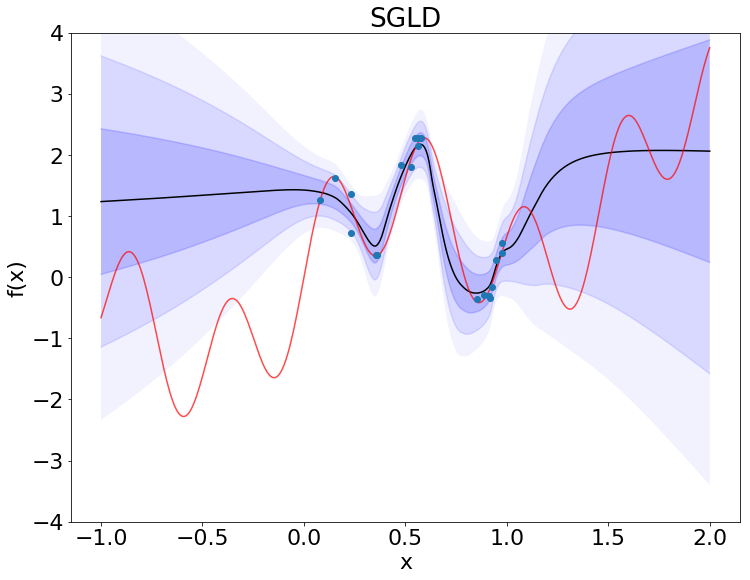

In [8]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions[:,1:].detach().numpy(),1) + 3 * np.std(predictions[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions[:,1:].detach().numpy(),1) - 3 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.15)
plt.plot(grid,lower2,'blue',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid,lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)
plt.plot(grid,y_true,'r',alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('SGLD')

### pSGLD

In [9]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld


lambda_ = 1.
lr = 1e-12
alpha = 0.99


batch_size = 20
dataset_size= 20



x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# learning_rates = [1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16]
# learning_rates = [9e-14, 8e-14, 7e-14, 6e-14, 5e-14, 4e-14, 3e-14, 2e-14, 1e-14, 9e-15, 8e-15, 7e-15, 6e-15, 5e-15, 4e-15, 3e-15, 2e-15, 1e-15]
# learning_rates = [5e-13, 4e-13, 3e-13, 2e-13, 1e-13, 9e-14, 8e-14, 7e-14, 6e-14, 5e-14]
# learning_rates = [8e-14]
learning_rates = [9e-14]
rmse_result = np.zeros((1,len(learning_rates)))

# grid_search = True
grid_search = False


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)
    predictions_psgld = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1)
    t = 1.
    
    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1./(2*0.0009))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions_psgld = torch.cat((predictions_psgld, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 20802.7344
Epoch 1 - loss: 21751.0312
Epoch 2 - loss: 17235.3008
Epoch 3 - loss: 10421.3906
Epoch 4 - loss: 9786.1689
Epoch 5 - loss: 9508.4443
Epoch 6 - loss: 9203.5527
Epoch 7 - loss: 8902.0889
Epoch 8 - loss: 8597.2803
Epoch 9 - loss: 8268.5176
Epoch 10 - loss: 7992.5068
Epoch 11 - loss: 7727.9976
Epoch 12 - loss: 7513.2119
Epoch 13 - loss: 7314.1938
Epoch 14 - loss: 7088.7358
Epoch 15 - loss: 6992.6626
Epoch 16 - loss: 7196.2944
Epoch 17 - loss: 7982.7021
Epoch 18 - loss: 10645.9443
Epoch 19 - loss: 13107.4160
Epoch 20 - loss: 12228.4668
Epoch 21 - loss: 7838.9272
Epoch 22 - loss: 7194.9688
Epoch 23 - loss: 6796.9346
Epoch 24 - loss: 6575.3447
Epoch 25 - loss: 6463.1064
Epoch 26 - loss: 6476.2241
Epoch 27 - loss: 6655.5205
Epoch 28 - loss: 6976.1475
Epoch 29 - loss: 7431.7764
Epoch 30 - loss: 8559.0186
Epoch 31 - loss: 8947.5566
Epoch 32 - loss: 8750.6934
Epoch 33 - loss: 7526.7393
Epoch 34 - loss: 7122.3374
Epoch 35 - loss: 6583.6904
Epoch 36 - loss: 6360.1724
Epoc

Epoch 336 - loss: 2886.3696
Epoch 337 - loss: 2838.9951
Epoch 338 - loss: 2829.1248
Epoch 339 - loss: 2825.5154
Epoch 340 - loss: 2829.7271
Epoch 341 - loss: 2885.7124
Epoch 342 - loss: 2978.5210
Epoch 343 - loss: 3069.1687
Epoch 344 - loss: 3340.6860
Epoch 345 - loss: 3479.5266
Epoch 346 - loss: 3929.5474
Epoch 347 - loss: 4165.2251
Epoch 348 - loss: 5129.8853
Epoch 349 - loss: 5361.4106
Epoch 350 - loss: 7008.8804
Epoch 351 - loss: 6680.7876
Epoch 352 - loss: 8327.9121
Epoch 353 - loss: 6803.5483
Epoch 354 - loss: 6678.1318
Epoch 355 - loss: 4973.6104
Epoch 356 - loss: 4139.4868
Epoch 357 - loss: 3571.7864
Epoch 358 - loss: 3382.3618
Epoch 359 - loss: 3189.4844
Epoch 360 - loss: 3133.7966
Epoch 361 - loss: 3102.8728
Epoch 362 - loss: 2940.5884
Epoch 363 - loss: 2949.0559
Epoch 364 - loss: 2842.0107
Epoch 365 - loss: 2835.1475
Epoch 366 - loss: 2799.4534
Epoch 367 - loss: 2768.0212
Epoch 368 - loss: 2737.5620
Epoch 369 - loss: 2786.4199
Epoch 370 - loss: 2721.2888
Epoch 371 - loss: 27

Epoch 689 - loss: 4049.4478
Epoch 690 - loss: 4006.7847
Epoch 691 - loss: 4308.6792
Epoch 692 - loss: 4169.1641
Epoch 693 - loss: 4184.6821
Epoch 694 - loss: 4172.0454
Epoch 695 - loss: 4267.6348
Epoch 696 - loss: 4800.5947
Epoch 697 - loss: 4380.2476
Epoch 698 - loss: 4243.1440
Epoch 699 - loss: 3200.1470
Epoch 700 - loss: 2817.6675
Epoch 701 - loss: 2524.2517
Epoch 702 - loss: 2359.3147
Epoch 703 - loss: 2290.1465
Epoch 704 - loss: 2241.5361
Epoch 705 - loss: 2223.1558
Epoch 706 - loss: 2223.3037
Epoch 707 - loss: 2218.9236
Epoch 708 - loss: 2225.4714
Epoch 709 - loss: 2237.1218
Epoch 710 - loss: 2206.5225
Epoch 711 - loss: 2234.5063
Epoch 712 - loss: 2327.4543
Epoch 713 - loss: 2494.5757
Epoch 714 - loss: 2687.6873
Epoch 715 - loss: 2944.7290
Epoch 716 - loss: 3361.8677
Epoch 717 - loss: 4078.8364
Epoch 718 - loss: 4676.6128
Epoch 719 - loss: 5400.7393
Epoch 720 - loss: 6997.0640
Epoch 721 - loss: 8288.6348
Epoch 722 - loss: 10059.8164
Epoch 723 - loss: 10647.0508
Epoch 724 - loss: 

Epoch 992 - loss: 3224.1152
Epoch 993 - loss: 2667.8523
Epoch 994 - loss: 2518.2405
Epoch 995 - loss: 2311.4402
Epoch 996 - loss: 2114.1055
Epoch 997 - loss: 2055.2329
Epoch 998 - loss: 1979.0935
Epoch 999 - loss: 1974.6976
Epoch 1000 - loss: 1933.3215
Epoch 1001 - loss: 1953.2617
Epoch 1002 - loss: 2011.1813
Epoch 1003 - loss: 2166.7803
Epoch 1004 - loss: 2379.6340
Epoch 1005 - loss: 2500.3384
Epoch 1006 - loss: 2794.4468
Epoch 1007 - loss: 3266.7488
Epoch 1008 - loss: 4013.6829
Epoch 1009 - loss: 4786.0161
Epoch 1010 - loss: 5336.7705
Epoch 1011 - loss: 5409.7798
Epoch 1012 - loss: 4736.8960
Epoch 1013 - loss: 4716.3286
Epoch 1014 - loss: 3868.2512
Epoch 1015 - loss: 3566.2063
Epoch 1016 - loss: 3218.6660
Epoch 1017 - loss: 2965.5798
Epoch 1018 - loss: 2800.3491
Epoch 1019 - loss: 2597.2698
Epoch 1020 - loss: 2244.7825
Epoch 1021 - loss: 2024.1719
Epoch 1022 - loss: 1907.4260
Epoch 1023 - loss: 1852.3914
Epoch 1024 - loss: 1789.3053
Epoch 1025 - loss: 1741.4646
Epoch 1026 - loss: 174

Epoch 1294 - loss: 2343.3882
Epoch 1295 - loss: 1886.4561
Epoch 1296 - loss: 1733.2078
Epoch 1297 - loss: 1536.8492
Epoch 1298 - loss: 1456.9781
Epoch 1299 - loss: 1378.5431
Epoch 1300 - loss: 1389.0563
Epoch 1301 - loss: 1433.2239
Epoch 1302 - loss: 1461.7687
Epoch 1303 - loss: 1615.1218
Epoch 1304 - loss: 2121.0979
Epoch 1305 - loss: 2678.4521
Epoch 1306 - loss: 3901.9114
Epoch 1307 - loss: 4085.8672
Epoch 1308 - loss: 4133.2168
Epoch 1309 - loss: 2156.2158
Epoch 1310 - loss: 1682.4270
Epoch 1311 - loss: 1448.6615
Epoch 1312 - loss: 1499.7266
Epoch 1313 - loss: 1514.5728
Epoch 1314 - loss: 1692.1033
Epoch 1315 - loss: 2026.5330
Epoch 1316 - loss: 2331.9724
Epoch 1317 - loss: 2966.1548
Epoch 1318 - loss: 4176.2471
Epoch 1319 - loss: 5053.5986
Epoch 1320 - loss: 5854.9224
Epoch 1321 - loss: 5896.4199
Epoch 1322 - loss: 4790.2891
Epoch 1323 - loss: 3988.8574
Epoch 1324 - loss: 3004.5198
Epoch 1325 - loss: 2490.8113
Epoch 1326 - loss: 2116.7224
Epoch 1327 - loss: 1778.2502
Epoch 1328 - l

Epoch 1652 - loss: 1354.9467
Epoch 1653 - loss: 1073.8934
Epoch 1654 - loss: 965.1241
Epoch 1655 - loss: 925.7968
Epoch 1656 - loss: 872.9901
Epoch 1657 - loss: 844.4930
Epoch 1658 - loss: 838.1237
Epoch 1659 - loss: 847.1345
Epoch 1660 - loss: 839.6332
Epoch 1661 - loss: 834.1757
Epoch 1662 - loss: 826.0112
Epoch 1663 - loss: 850.9291
Epoch 1664 - loss: 888.7150
Epoch 1665 - loss: 987.5618
Epoch 1666 - loss: 1129.9917
Epoch 1667 - loss: 1324.7314
Epoch 1668 - loss: 1932.3508
Epoch 1669 - loss: 2856.0688
Epoch 1670 - loss: 4630.2383
Epoch 1671 - loss: 4862.8037
Epoch 1672 - loss: 6347.7715
Epoch 1673 - loss: 3573.3521
Epoch 1674 - loss: 2864.6055
Epoch 1675 - loss: 1860.1885
Epoch 1676 - loss: 1532.1367
Epoch 1677 - loss: 1298.4121
Epoch 1678 - loss: 1082.9392
Epoch 1679 - loss: 1016.6901
Epoch 1680 - loss: 987.5590
Epoch 1681 - loss: 935.9821
Epoch 1682 - loss: 908.5294
Epoch 1683 - loss: 917.2042
Epoch 1684 - loss: 872.2489
Epoch 1685 - loss: 836.2590
Epoch 1686 - loss: 818.4731
Epoc

Epoch 2000 - loss: 1216.8196
Epoch 2001 - loss: 1206.8855
Epoch 2002 - loss: 1163.6949
Epoch 2003 - loss: 1178.5193
Epoch 2004 - loss: 1198.4042
Epoch 2005 - loss: 1225.4374
Epoch 2006 - loss: 1147.1573
Epoch 2007 - loss: 1116.5433
Epoch 2008 - loss: 1267.7725
Epoch 2009 - loss: 1362.6528
Epoch 2010 - loss: 1665.0892
Epoch 2011 - loss: 1814.3824
Epoch 2012 - loss: 2299.9458
Epoch 2013 - loss: 2365.3252
Epoch 2014 - loss: 2780.6245
Epoch 2015 - loss: 2032.8875
Epoch 2016 - loss: 1683.9951
Epoch 2017 - loss: 1063.4911
Epoch 2018 - loss: 892.4118
Epoch 2019 - loss: 787.6785
Epoch 2020 - loss: 694.5928
Epoch 2021 - loss: 685.1782
Epoch 2022 - loss: 658.8369
Epoch 2023 - loss: 657.4079
Epoch 2024 - loss: 630.4600
Epoch 2025 - loss: 654.3926
Epoch 2026 - loss: 676.1503
Epoch 2027 - loss: 689.4801
Epoch 2028 - loss: 678.0043
Epoch 2029 - loss: 739.6907
Epoch 2030 - loss: 960.1990
Epoch 2031 - loss: 1229.1774
Epoch 2032 - loss: 1785.7380
Epoch 2033 - loss: 2396.3694
Epoch 2034 - loss: 3032.791

Epoch 2301 - loss: 1113.9507
Epoch 2302 - loss: 863.2778
Epoch 2303 - loss: 673.7475
Epoch 2304 - loss: 623.3788
Epoch 2305 - loss: 573.8596
Epoch 2306 - loss: 561.5732
Epoch 2307 - loss: 555.4148
Epoch 2308 - loss: 587.8373
Epoch 2309 - loss: 586.6095
Epoch 2310 - loss: 626.3110
Epoch 2311 - loss: 699.4553
Epoch 2312 - loss: 812.4853
Epoch 2313 - loss: 981.2252
Epoch 2314 - loss: 1229.2404
Epoch 2315 - loss: 1352.8514
Epoch 2316 - loss: 1689.6562
Epoch 2317 - loss: 1816.9719
Epoch 2318 - loss: 1978.5559
Epoch 2319 - loss: 1826.6223
Epoch 2320 - loss: 1868.2468
Epoch 2321 - loss: 1527.7114
Epoch 2322 - loss: 1349.4674
Epoch 2323 - loss: 1226.3909
Epoch 2324 - loss: 1040.3975
Epoch 2325 - loss: 929.3827
Epoch 2326 - loss: 876.2287
Epoch 2327 - loss: 853.0800
Epoch 2328 - loss: 823.1092
Epoch 2329 - loss: 823.5529
Epoch 2330 - loss: 829.3011
Epoch 2331 - loss: 837.1459
Epoch 2332 - loss: 899.6986
Epoch 2333 - loss: 864.4354
Epoch 2334 - loss: 882.5047
Epoch 2335 - loss: 965.8503
Epoch 23

Epoch 2650 - loss: 597.4833
Epoch 2651 - loss: 570.7963
Epoch 2652 - loss: 549.7498
Epoch 2653 - loss: 503.0085
Epoch 2654 - loss: 501.2022
Epoch 2655 - loss: 506.2110
Epoch 2656 - loss: 488.7330
Epoch 2657 - loss: 474.1250
Epoch 2658 - loss: 473.4403
Epoch 2659 - loss: 487.6639
Epoch 2660 - loss: 531.8517
Epoch 2661 - loss: 558.8885
Epoch 2662 - loss: 591.1414
Epoch 2663 - loss: 615.3286
Epoch 2664 - loss: 673.8506
Epoch 2665 - loss: 899.3468
Epoch 2666 - loss: 1084.0450
Epoch 2667 - loss: 1638.1439
Epoch 2668 - loss: 1863.7595
Epoch 2669 - loss: 2415.8384
Epoch 2670 - loss: 2405.5132
Epoch 2671 - loss: 2111.0220
Epoch 2672 - loss: 1521.3044
Epoch 2673 - loss: 1204.2955
Epoch 2674 - loss: 944.3823
Epoch 2675 - loss: 820.7480
Epoch 2676 - loss: 615.8080
Epoch 2677 - loss: 615.7637
Epoch 2678 - loss: 589.7269
Epoch 2679 - loss: 572.8704
Epoch 2680 - loss: 568.3959
Epoch 2681 - loss: 575.0644
Epoch 2682 - loss: 601.0021
Epoch 2683 - loss: 619.4781
Epoch 2684 - loss: 637.2695
Epoch 2685 -

Epoch 2958 - loss: 1585.0553
Epoch 2959 - loss: 1102.2473
Epoch 2960 - loss: 804.5886
Epoch 2961 - loss: 673.6492
Epoch 2962 - loss: 631.2745
Epoch 2963 - loss: 649.4285
Epoch 2964 - loss: 606.0679
Epoch 2965 - loss: 544.3548
Epoch 2966 - loss: 520.1453
Epoch 2967 - loss: 515.0823
Epoch 2968 - loss: 490.6757
Epoch 2969 - loss: 482.3777
Epoch 2970 - loss: 504.0327
Epoch 2971 - loss: 493.4845
Epoch 2972 - loss: 519.6804
Epoch 2973 - loss: 525.3793
Epoch 2974 - loss: 573.0365
Epoch 2975 - loss: 597.5352
Epoch 2976 - loss: 596.7996
Epoch 2977 - loss: 631.6883
Epoch 2978 - loss: 767.9642
Epoch 2979 - loss: 852.1895
Epoch 2980 - loss: 940.7225
Epoch 2981 - loss: 972.5643
Epoch 2982 - loss: 992.3507
Epoch 2983 - loss: 898.4020
Epoch 2984 - loss: 915.7231
Epoch 2985 - loss: 951.0332
Epoch 2986 - loss: 873.4557
Epoch 2987 - loss: 883.1404
Epoch 2988 - loss: 814.0786
Epoch 2989 - loss: 807.0713
Epoch 2990 - loss: 817.7032
Epoch 2991 - loss: 801.3287
Epoch 2992 - loss: 789.7422
Epoch 2993 - loss:

Epoch 3271 - loss: 342.0531
Epoch 3272 - loss: 344.3977
Epoch 3273 - loss: 342.5362
Epoch 3274 - loss: 341.9246
Epoch 3275 - loss: 343.7289
Epoch 3276 - loss: 344.5604
Epoch 3277 - loss: 345.8187
Epoch 3278 - loss: 344.4011
Epoch 3279 - loss: 343.0820
Epoch 3280 - loss: 342.3984
Epoch 3281 - loss: 349.1640
Epoch 3282 - loss: 340.0403
Epoch 3283 - loss: 341.2126
Epoch 3284 - loss: 341.0943
Epoch 3285 - loss: 343.5257
Epoch 3286 - loss: 347.0780
Epoch 3287 - loss: 352.7058
Epoch 3288 - loss: 373.7131
Epoch 3289 - loss: 371.7881
Epoch 3290 - loss: 368.9633
Epoch 3291 - loss: 378.0999
Epoch 3292 - loss: 387.9308
Epoch 3293 - loss: 397.4759
Epoch 3294 - loss: 439.9054
Epoch 3295 - loss: 417.2790
Epoch 3296 - loss: 392.8643
Epoch 3297 - loss: 422.2752
Epoch 3298 - loss: 441.0142
Epoch 3299 - loss: 438.5451
Epoch 3300 - loss: 453.4890
Epoch 3301 - loss: 401.8278
Epoch 3302 - loss: 394.5781
Epoch 3303 - loss: 364.8307
Epoch 3304 - loss: 363.8837
Epoch 3305 - loss: 354.0228
Epoch 3306 - loss: 3

Epoch 3574 - loss: 338.2262
Epoch 3575 - loss: 341.9674
Epoch 3576 - loss: 362.7458
Epoch 3577 - loss: 350.1061
Epoch 3578 - loss: 345.3238
Epoch 3579 - loss: 339.3882
Epoch 3580 - loss: 345.7307
Epoch 3581 - loss: 359.5356
Epoch 3582 - loss: 358.5678
Epoch 3583 - loss: 345.3124
Epoch 3584 - loss: 333.4451
Epoch 3585 - loss: 335.0882
Epoch 3586 - loss: 335.1579
Epoch 3587 - loss: 334.5959
Epoch 3588 - loss: 337.9785
Epoch 3589 - loss: 335.0162
Epoch 3590 - loss: 344.3077
Epoch 3591 - loss: 344.0060
Epoch 3592 - loss: 354.2523
Epoch 3593 - loss: 349.3859
Epoch 3594 - loss: 367.4390
Epoch 3595 - loss: 396.3051
Epoch 3596 - loss: 409.4835
Epoch 3597 - loss: 431.9373
Epoch 3598 - loss: 407.6743
Epoch 3599 - loss: 436.1065
Epoch 3600 - loss: 443.7262
Epoch 3601 - loss: 488.6571
Epoch 3602 - loss: 510.5697
Epoch 3603 - loss: 577.5633
Epoch 3604 - loss: 691.8147
Epoch 3605 - loss: 904.7697
Epoch 3606 - loss: 862.2734
Epoch 3607 - loss: 846.8074
Epoch 3608 - loss: 904.3719
Epoch 3609 - loss: 1

Epoch 3873 - loss: 351.8579
Epoch 3874 - loss: 370.7599
Epoch 3875 - loss: 378.9998
Epoch 3876 - loss: 382.7703
Epoch 3877 - loss: 348.2313
Epoch 3878 - loss: 331.4561
Epoch 3879 - loss: 326.1691
Epoch 3880 - loss: 335.6923
Epoch 3881 - loss: 329.8526
Epoch 3882 - loss: 325.8535
Epoch 3883 - loss: 328.8153
Epoch 3884 - loss: 324.2025
Epoch 3885 - loss: 329.6180
Epoch 3886 - loss: 356.1353
Epoch 3887 - loss: 354.7788
Epoch 3888 - loss: 349.1543
Epoch 3889 - loss: 351.2822
Epoch 3890 - loss: 356.0213
Epoch 3891 - loss: 335.7991
Epoch 3892 - loss: 324.0173
Epoch 3893 - loss: 328.2844
Epoch 3894 - loss: 335.9394
Epoch 3895 - loss: 346.3533
Epoch 3896 - loss: 353.7205
Epoch 3897 - loss: 366.2792
Epoch 3898 - loss: 354.9940
Epoch 3899 - loss: 368.4019
Epoch 3900 - loss: 375.5607
Epoch 3901 - loss: 375.7482
Epoch 3902 - loss: 361.5721
Epoch 3903 - loss: 341.0999
Epoch 3904 - loss: 356.4505
Epoch 3905 - loss: 346.1694
Epoch 3906 - loss: 330.3396
Epoch 3907 - loss: 329.3882
Epoch 3908 - loss: 3

Epoch 4253 - loss: 411.4291
Epoch 4254 - loss: 374.1220
Epoch 4255 - loss: 350.6715
Epoch 4256 - loss: 385.3872
Epoch 4257 - loss: 375.2385
Epoch 4258 - loss: 427.9743
Epoch 4259 - loss: 415.5828
Epoch 4260 - loss: 371.5003
Epoch 4261 - loss: 329.7949
Epoch 4262 - loss: 329.2758
Epoch 4263 - loss: 337.8159
Epoch 4264 - loss: 321.7568
Epoch 4265 - loss: 333.1477
Epoch 4266 - loss: 336.8456
Epoch 4267 - loss: 331.2097
Epoch 4268 - loss: 340.0162
Epoch 4269 - loss: 353.6653
Epoch 4270 - loss: 354.8994
Epoch 4271 - loss: 342.3061
Epoch 4272 - loss: 363.3396
Epoch 4273 - loss: 340.6400
Epoch 4274 - loss: 348.7581
Epoch 4275 - loss: 379.8354
Epoch 4276 - loss: 459.7687
Epoch 4277 - loss: 505.0068
Epoch 4278 - loss: 515.0153
Epoch 4279 - loss: 579.1280
Epoch 4280 - loss: 683.8211
Epoch 4281 - loss: 803.6313
Epoch 4282 - loss: 835.5272
Epoch 4283 - loss: 841.3698
Epoch 4284 - loss: 833.7762
Epoch 4285 - loss: 1047.6571
Epoch 4286 - loss: 1094.7527
Epoch 4287 - loss: 1227.0309
Epoch 4288 - loss

Epoch 4546 - loss: 762.7416
Epoch 4547 - loss: 573.1818
Epoch 4548 - loss: 522.2601
Epoch 4549 - loss: 470.5331
Epoch 4550 - loss: 427.7465
Epoch 4551 - loss: 385.7973
Epoch 4552 - loss: 371.5333
Epoch 4553 - loss: 332.9919
Epoch 4554 - loss: 337.0184
Epoch 4555 - loss: 324.5698
Epoch 4556 - loss: 314.1700
Epoch 4557 - loss: 327.4481
Epoch 4558 - loss: 317.7396
Epoch 4559 - loss: 321.6097
Epoch 4560 - loss: 322.3864
Epoch 4561 - loss: 338.0640
Epoch 4562 - loss: 346.1888
Epoch 4563 - loss: 330.9266
Epoch 4564 - loss: 359.6209
Epoch 4565 - loss: 375.4862
Epoch 4566 - loss: 412.3198
Epoch 4567 - loss: 446.6376
Epoch 4568 - loss: 457.7495
Epoch 4569 - loss: 486.9667
Epoch 4570 - loss: 525.2232
Epoch 4571 - loss: 554.5707
Epoch 4572 - loss: 581.4841
Epoch 4573 - loss: 540.1616
Epoch 4574 - loss: 561.5466
Epoch 4575 - loss: 595.1608
Epoch 4576 - loss: 583.7307
Epoch 4577 - loss: 606.4330
Epoch 4578 - loss: 529.4221
Epoch 4579 - loss: 532.5424
Epoch 4580 - loss: 508.4455
Epoch 4581 - loss: 5

Epoch 4843 - loss: 318.8768
Epoch 4844 - loss: 316.4474
Epoch 4845 - loss: 345.6430
Epoch 4846 - loss: 363.6718
Epoch 4847 - loss: 351.3380
Epoch 4848 - loss: 395.7787
Epoch 4849 - loss: 357.7061
Epoch 4850 - loss: 399.9045
Epoch 4851 - loss: 398.2955
Epoch 4852 - loss: 408.2662
Epoch 4853 - loss: 398.2758
Epoch 4854 - loss: 334.3277
Epoch 4855 - loss: 367.4132
Epoch 4856 - loss: 382.0736
Epoch 4857 - loss: 389.1576
Epoch 4858 - loss: 361.7240
Epoch 4859 - loss: 435.3201
Epoch 4860 - loss: 471.7953
Epoch 4861 - loss: 455.9506
Epoch 4862 - loss: 458.4825
Epoch 4863 - loss: 527.9532
Epoch 4864 - loss: 545.5538
Epoch 4865 - loss: 594.5620
Epoch 4866 - loss: 596.0942
Epoch 4867 - loss: 734.9910
Epoch 4868 - loss: 795.3911
Epoch 4869 - loss: 850.1893
Epoch 4870 - loss: 822.9069
Epoch 4871 - loss: 752.8068
Epoch 4872 - loss: 801.3391
Epoch 4873 - loss: 729.1051
Epoch 4874 - loss: 774.7505
Epoch 4875 - loss: 696.2955
Epoch 4876 - loss: 635.4021
Epoch 4877 - loss: 618.2718
Epoch 4878 - loss: 5

Epoch 5205 - loss: 310.3273
Epoch 5206 - loss: 302.0319
Epoch 5207 - loss: 302.6757
Epoch 5208 - loss: 298.3748
Epoch 5209 - loss: 310.5417
Epoch 5210 - loss: 301.3491
Epoch 5211 - loss: 295.0415
Epoch 5212 - loss: 296.5373
Epoch 5213 - loss: 297.7074
Epoch 5214 - loss: 296.2285
Epoch 5215 - loss: 295.1722
Epoch 5216 - loss: 296.3698
Epoch 5217 - loss: 300.1190
Epoch 5218 - loss: 310.6266
Epoch 5219 - loss: 305.7684
Epoch 5220 - loss: 300.7437
Epoch 5221 - loss: 294.1792
Epoch 5222 - loss: 298.1191
Epoch 5223 - loss: 308.4090
Epoch 5224 - loss: 296.8064
Epoch 5225 - loss: 299.3575
Epoch 5226 - loss: 302.8151
Epoch 5227 - loss: 302.1594
Epoch 5228 - loss: 300.8570
Epoch 5229 - loss: 295.8787
Epoch 5230 - loss: 299.1322
Epoch 5231 - loss: 296.4706
Epoch 5232 - loss: 294.1212
Epoch 5233 - loss: 298.2070
Epoch 5234 - loss: 308.0333
Epoch 5235 - loss: 304.9926
Epoch 5236 - loss: 308.6082
Epoch 5237 - loss: 315.2166
Epoch 5238 - loss: 327.5227
Epoch 5239 - loss: 330.5281
Epoch 5240 - loss: 3

Epoch 5564 - loss: 601.6969
Epoch 5565 - loss: 678.2399
Epoch 5566 - loss: 664.9834
Epoch 5567 - loss: 589.9765
Epoch 5568 - loss: 624.3306
Epoch 5569 - loss: 623.8005
Epoch 5570 - loss: 627.8672
Epoch 5571 - loss: 557.8493
Epoch 5572 - loss: 477.6983
Epoch 5573 - loss: 415.8909
Epoch 5574 - loss: 352.8897
Epoch 5575 - loss: 334.2627
Epoch 5576 - loss: 315.0954
Epoch 5577 - loss: 320.5718
Epoch 5578 - loss: 331.2202
Epoch 5579 - loss: 316.6784
Epoch 5580 - loss: 331.8163
Epoch 5581 - loss: 368.4460
Epoch 5582 - loss: 379.9417
Epoch 5583 - loss: 392.3738
Epoch 5584 - loss: 400.5791
Epoch 5585 - loss: 438.0235
Epoch 5586 - loss: 426.4176
Epoch 5587 - loss: 439.2909
Epoch 5588 - loss: 429.6042
Epoch 5589 - loss: 401.4682
Epoch 5590 - loss: 396.9559
Epoch 5591 - loss: 359.7713
Epoch 5592 - loss: 396.7260
Epoch 5593 - loss: 433.6786
Epoch 5594 - loss: 409.8134
Epoch 5595 - loss: 475.5223
Epoch 5596 - loss: 456.8206
Epoch 5597 - loss: 419.6850
Epoch 5598 - loss: 434.1505
Epoch 5599 - loss: 3

Epoch 5859 - loss: 1456.9573
Epoch 5860 - loss: 1274.8920
Epoch 5861 - loss: 1100.7822
Epoch 5862 - loss: 910.0905
Epoch 5863 - loss: 718.1808
Epoch 5864 - loss: 577.7660
Epoch 5865 - loss: 509.5550
Epoch 5866 - loss: 476.5497
Epoch 5867 - loss: 440.5012
Epoch 5868 - loss: 404.3496
Epoch 5869 - loss: 357.9224
Epoch 5870 - loss: 350.5994
Epoch 5871 - loss: 339.5217
Epoch 5872 - loss: 343.5571
Epoch 5873 - loss: 356.7136
Epoch 5874 - loss: 335.5479
Epoch 5875 - loss: 313.5540
Epoch 5876 - loss: 310.1085
Epoch 5877 - loss: 319.2357
Epoch 5878 - loss: 336.5579
Epoch 5879 - loss: 342.2581
Epoch 5880 - loss: 341.0348
Epoch 5881 - loss: 332.9407
Epoch 5882 - loss: 319.8009
Epoch 5883 - loss: 320.9482
Epoch 5884 - loss: 317.6602
Epoch 5885 - loss: 316.1194
Epoch 5886 - loss: 333.1563
Epoch 5887 - loss: 344.9491
Epoch 5888 - loss: 340.4446
Epoch 5889 - loss: 349.7025
Epoch 5890 - loss: 353.3415
Epoch 5891 - loss: 344.4655
Epoch 5892 - loss: 325.0744
Epoch 5893 - loss: 331.9940
Epoch 5894 - loss

Epoch 6165 - loss: 284.2893
Epoch 6166 - loss: 282.1067
Epoch 6167 - loss: 279.3368
Epoch 6168 - loss: 282.1995
Epoch 6169 - loss: 283.4211
Epoch 6170 - loss: 282.5298
Epoch 6171 - loss: 284.7622
Epoch 6172 - loss: 290.1682
Epoch 6173 - loss: 286.5902
Epoch 6174 - loss: 281.7269
Epoch 6175 - loss: 287.6278
Epoch 6176 - loss: 282.6742
Epoch 6177 - loss: 282.5474
Epoch 6178 - loss: 287.1516
Epoch 6179 - loss: 283.8281
Epoch 6180 - loss: 286.2263
Epoch 6181 - loss: 290.7375
Epoch 6182 - loss: 283.8797
Epoch 6183 - loss: 287.9366
Epoch 6184 - loss: 283.3815
Epoch 6185 - loss: 280.8955
Epoch 6186 - loss: 279.9344
Epoch 6187 - loss: 284.4217
Epoch 6188 - loss: 281.9799
Epoch 6189 - loss: 282.6647
Epoch 6190 - loss: 283.3291
Epoch 6191 - loss: 283.4904
Epoch 6192 - loss: 283.6393
Epoch 6193 - loss: 283.0485
Epoch 6194 - loss: 282.4472
Epoch 6195 - loss: 285.1165
Epoch 6196 - loss: 280.2990
Epoch 6197 - loss: 279.6124
Epoch 6198 - loss: 279.5854
Epoch 6199 - loss: 276.0062
Epoch 6200 - loss: 2

Epoch 6528 - loss: 268.7732
Epoch 6529 - loss: 268.9592
Epoch 6530 - loss: 269.2344
Epoch 6531 - loss: 266.8856
Epoch 6532 - loss: 266.5114
Epoch 6533 - loss: 267.7022
Epoch 6534 - loss: 267.6106
Epoch 6535 - loss: 272.5741
Epoch 6536 - loss: 268.8186
Epoch 6537 - loss: 268.1726
Epoch 6538 - loss: 264.9214
Epoch 6539 - loss: 268.3491
Epoch 6540 - loss: 278.8054
Epoch 6541 - loss: 289.9704
Epoch 6542 - loss: 286.9858
Epoch 6543 - loss: 301.0373
Epoch 6544 - loss: 285.5696
Epoch 6545 - loss: 281.4822
Epoch 6546 - loss: 273.6804
Epoch 6547 - loss: 277.5003
Epoch 6548 - loss: 272.1370
Epoch 6549 - loss: 266.7529
Epoch 6550 - loss: 271.0211
Epoch 6551 - loss: 268.5302
Epoch 6552 - loss: 272.4999
Epoch 6553 - loss: 266.0559
Epoch 6554 - loss: 274.3487
Epoch 6555 - loss: 282.4447
Epoch 6556 - loss: 271.2016
Epoch 6557 - loss: 266.7380
Epoch 6558 - loss: 266.6893
Epoch 6559 - loss: 265.4591
Epoch 6560 - loss: 267.8611
Epoch 6561 - loss: 268.8988
Epoch 6562 - loss: 272.9653
Epoch 6563 - loss: 2

Epoch 6829 - loss: 277.2503
Epoch 6830 - loss: 279.6475
Epoch 6831 - loss: 286.1841
Epoch 6832 - loss: 274.4083
Epoch 6833 - loss: 285.1603
Epoch 6834 - loss: 307.6811
Epoch 6835 - loss: 304.7861
Epoch 6836 - loss: 309.8790
Epoch 6837 - loss: 286.8914
Epoch 6838 - loss: 268.4317
Epoch 6839 - loss: 271.9720
Epoch 6840 - loss: 278.0666
Epoch 6841 - loss: 271.0052
Epoch 6842 - loss: 275.3761
Epoch 6843 - loss: 268.5528
Epoch 6844 - loss: 266.3799
Epoch 6845 - loss: 274.6535
Epoch 6846 - loss: 267.1388
Epoch 6847 - loss: 266.4798
Epoch 6848 - loss: 267.6363
Epoch 6849 - loss: 266.5434
Epoch 6850 - loss: 264.5781
Epoch 6851 - loss: 264.8307
Epoch 6852 - loss: 263.4283
Epoch 6853 - loss: 267.8389
Epoch 6854 - loss: 268.2468
Epoch 6855 - loss: 263.3040
Epoch 6856 - loss: 269.6537
Epoch 6857 - loss: 276.4198
Epoch 6858 - loss: 263.3754
Epoch 6859 - loss: 262.3932
Epoch 6860 - loss: 264.5930
Epoch 6861 - loss: 264.3182
Epoch 6862 - loss: 262.8121
Epoch 6863 - loss: 271.3442
Epoch 6864 - loss: 2

Epoch 7179 - loss: 270.1684
Epoch 7180 - loss: 268.3124
Epoch 7181 - loss: 278.2614
Epoch 7182 - loss: 276.8500
Epoch 7183 - loss: 278.8123
Epoch 7184 - loss: 284.9282
Epoch 7185 - loss: 277.4219
Epoch 7186 - loss: 280.3210
Epoch 7187 - loss: 281.9077
Epoch 7188 - loss: 290.5639
Epoch 7189 - loss: 282.2849
Epoch 7190 - loss: 285.4010
Epoch 7191 - loss: 295.2117
Epoch 7192 - loss: 297.2153
Epoch 7193 - loss: 286.9927
Epoch 7194 - loss: 283.6656
Epoch 7195 - loss: 290.3472
Epoch 7196 - loss: 290.2421
Epoch 7197 - loss: 280.3510
Epoch 7198 - loss: 307.2549
Epoch 7199 - loss: 293.9490
Epoch 7200 - loss: 281.4963
Epoch 7201 - loss: 272.2002
Epoch 7202 - loss: 272.6788
Epoch 7203 - loss: 269.9047
Epoch 7204 - loss: 273.1668
Epoch 7205 - loss: 288.6902
Epoch 7206 - loss: 290.8002
Epoch 7207 - loss: 295.3347
Epoch 7208 - loss: 293.7046
Epoch 7209 - loss: 279.8941
Epoch 7210 - loss: 292.5507
Epoch 7211 - loss: 292.0857
Epoch 7212 - loss: 288.2551
Epoch 7213 - loss: 280.6229
Epoch 7214 - loss: 2

Epoch 7546 - loss: 390.9073
Epoch 7547 - loss: 401.5083
Epoch 7548 - loss: 351.1951
Epoch 7549 - loss: 313.0968
Epoch 7550 - loss: 282.8498
Epoch 7551 - loss: 313.2755
Epoch 7552 - loss: 311.1913
Epoch 7553 - loss: 274.9705
Epoch 7554 - loss: 280.0176
Epoch 7555 - loss: 304.2228
Epoch 7556 - loss: 306.5692
Epoch 7557 - loss: 276.6230
Epoch 7558 - loss: 267.8000
Epoch 7559 - loss: 272.3406
Epoch 7560 - loss: 289.9912
Epoch 7561 - loss: 305.1672
Epoch 7562 - loss: 273.0164
Epoch 7563 - loss: 274.9571
Epoch 7564 - loss: 281.3842
Epoch 7565 - loss: 258.2614
Epoch 7566 - loss: 260.0832
Epoch 7567 - loss: 259.8590
Epoch 7568 - loss: 267.4325
Epoch 7569 - loss: 264.2277
Epoch 7570 - loss: 266.7994
Epoch 7571 - loss: 259.2368
Epoch 7572 - loss: 267.3265
Epoch 7573 - loss: 269.8203
Epoch 7574 - loss: 265.9937
Epoch 7575 - loss: 264.5849
Epoch 7576 - loss: 265.5625
Epoch 7577 - loss: 268.6604
Epoch 7578 - loss: 273.3055
Epoch 7579 - loss: 284.4150
Epoch 7580 - loss: 279.4481
Epoch 7581 - loss: 3

Epoch 7851 - loss: 271.1235
Epoch 7852 - loss: 270.4773
Epoch 7853 - loss: 271.5939
Epoch 7854 - loss: 270.3940
Epoch 7855 - loss: 272.2167
Epoch 7856 - loss: 273.9080
Epoch 7857 - loss: 268.8454
Epoch 7858 - loss: 269.3981
Epoch 7859 - loss: 267.1213
Epoch 7860 - loss: 267.1127
Epoch 7861 - loss: 264.7577
Epoch 7862 - loss: 275.0153
Epoch 7863 - loss: 271.3961
Epoch 7864 - loss: 263.9860
Epoch 7865 - loss: 274.2122
Epoch 7866 - loss: 268.3285
Epoch 7867 - loss: 262.0408
Epoch 7868 - loss: 262.3433
Epoch 7869 - loss: 263.1217
Epoch 7870 - loss: 271.1535
Epoch 7871 - loss: 279.5290
Epoch 7872 - loss: 282.9316
Epoch 7873 - loss: 290.6975
Epoch 7874 - loss: 266.7896
Epoch 7875 - loss: 307.2549
Epoch 7876 - loss: 308.5155
Epoch 7877 - loss: 307.0540
Epoch 7878 - loss: 313.8217
Epoch 7879 - loss: 364.0098
Epoch 7880 - loss: 353.3193
Epoch 7881 - loss: 299.7577
Epoch 7882 - loss: 259.5198
Epoch 7883 - loss: 259.6471
Epoch 7884 - loss: 256.3687
Epoch 7885 - loss: 270.2161
Epoch 7886 - loss: 2

Epoch 8145 - loss: 250.4725
Epoch 8146 - loss: 252.0150
Epoch 8147 - loss: 250.1150
Epoch 8148 - loss: 258.4344
Epoch 8149 - loss: 270.8875
Epoch 8150 - loss: 269.3235
Epoch 8151 - loss: 277.7720
Epoch 8152 - loss: 257.4315
Epoch 8153 - loss: 270.2156
Epoch 8154 - loss: 255.5542
Epoch 8155 - loss: 253.0546
Epoch 8156 - loss: 278.0818
Epoch 8157 - loss: 261.6471
Epoch 8158 - loss: 253.2192
Epoch 8159 - loss: 250.4244
Epoch 8160 - loss: 251.4767
Epoch 8161 - loss: 257.4787
Epoch 8162 - loss: 258.5999
Epoch 8163 - loss: 267.0518
Epoch 8164 - loss: 260.0996
Epoch 8165 - loss: 275.4567
Epoch 8166 - loss: 267.5643
Epoch 8167 - loss: 272.1337
Epoch 8168 - loss: 258.4099
Epoch 8169 - loss: 253.6764
Epoch 8170 - loss: 251.5527
Epoch 8171 - loss: 252.3869
Epoch 8172 - loss: 250.0212
Epoch 8173 - loss: 250.4825
Epoch 8174 - loss: 253.1982
Epoch 8175 - loss: 254.0237
Epoch 8176 - loss: 251.1476
Epoch 8177 - loss: 250.7434
Epoch 8178 - loss: 257.4226
Epoch 8179 - loss: 270.2210
Epoch 8180 - loss: 2

Epoch 8440 - loss: 264.8992
Epoch 8441 - loss: 259.3465
Epoch 8442 - loss: 242.7142
Epoch 8443 - loss: 242.4556
Epoch 8444 - loss: 249.9390
Epoch 8445 - loss: 273.5898
Epoch 8446 - loss: 273.6936
Epoch 8447 - loss: 299.8438
Epoch 8448 - loss: 272.4091
Epoch 8449 - loss: 304.0760
Epoch 8450 - loss: 314.6222
Epoch 8451 - loss: 311.3040
Epoch 8452 - loss: 294.1205
Epoch 8453 - loss: 305.0465
Epoch 8454 - loss: 366.7026
Epoch 8455 - loss: 334.7732
Epoch 8456 - loss: 326.3084
Epoch 8457 - loss: 302.1324
Epoch 8458 - loss: 345.4581
Epoch 8459 - loss: 340.9761
Epoch 8460 - loss: 294.7173
Epoch 8461 - loss: 341.8370
Epoch 8462 - loss: 310.2821
Epoch 8463 - loss: 300.9342
Epoch 8464 - loss: 322.7520
Epoch 8465 - loss: 361.4324
Epoch 8466 - loss: 336.0171
Epoch 8467 - loss: 313.8868
Epoch 8468 - loss: 338.7349
Epoch 8469 - loss: 327.3007
Epoch 8470 - loss: 339.1359
Epoch 8471 - loss: 338.7424
Epoch 8472 - loss: 313.6021
Epoch 8473 - loss: 316.6114
Epoch 8474 - loss: 334.8142
Epoch 8475 - loss: 3

Epoch 8751 - loss: 1089.3496
Epoch 8752 - loss: 1075.2440
Epoch 8753 - loss: 1017.3148
Epoch 8754 - loss: 982.5159
Epoch 8755 - loss: 931.8812
Epoch 8756 - loss: 943.0324
Epoch 8757 - loss: 804.1870
Epoch 8758 - loss: 872.8744
Epoch 8759 - loss: 927.6266
Epoch 8760 - loss: 916.6653
Epoch 8761 - loss: 750.3830
Epoch 8762 - loss: 702.6954
Epoch 8763 - loss: 552.9370
Epoch 8764 - loss: 520.3803
Epoch 8765 - loss: 443.6852
Epoch 8766 - loss: 380.1665
Epoch 8767 - loss: 323.9243
Epoch 8768 - loss: 317.6831
Epoch 8769 - loss: 303.3510
Epoch 8770 - loss: 294.0723
Epoch 8771 - loss: 260.9901
Epoch 8772 - loss: 249.1427
Epoch 8773 - loss: 252.7229
Epoch 8774 - loss: 247.6502
Epoch 8775 - loss: 254.2326
Epoch 8776 - loss: 258.9317
Epoch 8777 - loss: 255.6335
Epoch 8778 - loss: 252.6636
Epoch 8779 - loss: 252.3005
Epoch 8780 - loss: 262.7092
Epoch 8781 - loss: 261.8659
Epoch 8782 - loss: 245.7226
Epoch 8783 - loss: 249.9919
Epoch 8784 - loss: 246.9794
Epoch 8785 - loss: 242.6636
Epoch 8786 - loss

Epoch 9099 - loss: 237.5305
Epoch 9100 - loss: 241.0175
Epoch 9101 - loss: 237.8687
Epoch 9102 - loss: 235.8286
Epoch 9103 - loss: 235.6016
Epoch 9104 - loss: 236.7274
Epoch 9105 - loss: 239.7203
Epoch 9106 - loss: 241.1953
Epoch 9107 - loss: 240.8804
Epoch 9108 - loss: 244.2984
Epoch 9109 - loss: 243.6574
Epoch 9110 - loss: 245.7141
Epoch 9111 - loss: 242.4891
Epoch 9112 - loss: 243.1738
Epoch 9113 - loss: 250.9588
Epoch 9114 - loss: 241.9341
Epoch 9115 - loss: 240.7543
Epoch 9116 - loss: 242.5782
Epoch 9117 - loss: 240.3694
Epoch 9118 - loss: 242.6903
Epoch 9119 - loss: 249.2457
Epoch 9120 - loss: 241.8648
Epoch 9121 - loss: 242.4017
Epoch 9122 - loss: 244.3191
Epoch 9123 - loss: 241.3095
Epoch 9124 - loss: 243.3932
Epoch 9125 - loss: 249.2071
Epoch 9126 - loss: 241.3711
Epoch 9127 - loss: 239.3032
Epoch 9128 - loss: 238.5247
Epoch 9129 - loss: 241.4107
Epoch 9130 - loss: 242.3461
Epoch 9131 - loss: 244.5554
Epoch 9132 - loss: 240.5327
Epoch 9133 - loss: 242.5691
Epoch 9134 - loss: 2

Epoch 9411 - loss: 246.5120
Epoch 9412 - loss: 248.8456
Epoch 9413 - loss: 245.4612
Epoch 9414 - loss: 246.4318
Epoch 9415 - loss: 245.3138
Epoch 9416 - loss: 243.5565
Epoch 9417 - loss: 244.9524
Epoch 9418 - loss: 245.7668
Epoch 9419 - loss: 242.2523
Epoch 9420 - loss: 247.4361
Epoch 9421 - loss: 241.9662
Epoch 9422 - loss: 251.4310
Epoch 9423 - loss: 243.1293
Epoch 9424 - loss: 245.4235
Epoch 9425 - loss: 243.9303
Epoch 9426 - loss: 244.6321
Epoch 9427 - loss: 242.9825
Epoch 9428 - loss: 250.9202
Epoch 9429 - loss: 246.3190
Epoch 9430 - loss: 243.2003
Epoch 9431 - loss: 240.9670
Epoch 9432 - loss: 242.5186
Epoch 9433 - loss: 241.8351
Epoch 9434 - loss: 242.3237
Epoch 9435 - loss: 240.2912
Epoch 9436 - loss: 240.7923
Epoch 9437 - loss: 242.2613
Epoch 9438 - loss: 245.8955
Epoch 9439 - loss: 248.8116
Epoch 9440 - loss: 258.1696
Epoch 9441 - loss: 247.2832
Epoch 9442 - loss: 246.0207
Epoch 9443 - loss: 241.4760
Epoch 9444 - loss: 245.0005
Epoch 9445 - loss: 240.9109
Epoch 9446 - loss: 2

Epoch 9731 - loss: 246.0007
Epoch 9732 - loss: 245.2594
Epoch 9733 - loss: 249.1432
Epoch 9734 - loss: 245.9285
Epoch 9735 - loss: 244.7897
Epoch 9736 - loss: 247.6305
Epoch 9737 - loss: 247.0072
Epoch 9738 - loss: 242.2029
Epoch 9739 - loss: 240.6553
Epoch 9740 - loss: 240.6173
Epoch 9741 - loss: 246.8016
Epoch 9742 - loss: 239.6982
Epoch 9743 - loss: 242.0246
Epoch 9744 - loss: 238.4480
Epoch 9745 - loss: 239.0510
Epoch 9746 - loss: 242.1557
Epoch 9747 - loss: 238.6001
Epoch 9748 - loss: 240.7460
Epoch 9749 - loss: 243.3852
Epoch 9750 - loss: 242.1504
Epoch 9751 - loss: 241.9707
Epoch 9752 - loss: 237.1609
Epoch 9753 - loss: 236.9792
Epoch 9754 - loss: 238.1191
Epoch 9755 - loss: 239.7110
Epoch 9756 - loss: 237.1063
Epoch 9757 - loss: 240.9298
Epoch 9758 - loss: 238.3364
Epoch 9759 - loss: 240.6753
Epoch 9760 - loss: 237.3170
Epoch 9761 - loss: 237.4330
Epoch 9762 - loss: 237.9394
Epoch 9763 - loss: 236.2766
Epoch 9764 - loss: 236.5775
Epoch 9765 - loss: 241.9877
Epoch 9766 - loss: 2

In [89]:
rmse_result

array([[1.91601026, 1.94688773, 1.93983197, 1.9240849 , 2.14321351,
        2.23020458, 2.20807219, 2.19439912, 2.3302269 , 2.25267553,
        2.36062932, 2.17285466, 2.20170331, 2.26296568, 2.34622693,
        2.26366925, 2.38486838, 2.66838336]])

Text(0.5,1,'pSGLD')

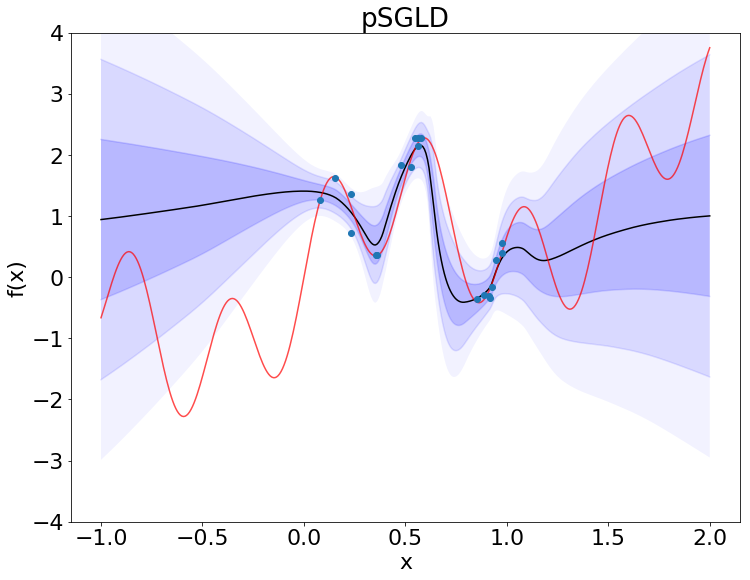

In [10]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 3 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 3 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.12)
plt.plot(grid,lower2,'blue',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid.squeeze(),lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('pSGLD')

### KSGLD

In [12]:
import torch


from torch import nn
import torch.nn.functional as F
import numpy as np

import ksgld

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3


batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# grid_search = True
grid_search = False

# learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
# learning_rates = [2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4]
# learning_rates = [1e-2]
learning_rates = [9e-4]
rmse_result = np.zeros((1,len(learning_rates)))


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgld = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1)
    
    t = 1.
    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*0.0009))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions_ksgld = torch.cat((predictions_ksgld, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 19933.0137
Epoch 1 - loss: 18932.1230
Epoch 2 - loss: 18184.7617
Epoch 3 - loss: 17559.8008
Epoch 4 - loss: 16148.8887
Epoch 5 - loss: 15339.2637
Epoch 6 - loss: 14728.0996
Epoch 7 - loss: 13876.9971
Epoch 8 - loss: 13307.4531
Epoch 9 - loss: 13043.7002
Epoch 10 - loss: 12440.2910
Epoch 11 - loss: 11863.8232
Epoch 12 - loss: 11679.3135
Epoch 13 - loss: 11345.2109
Epoch 14 - loss: 10836.5098
Epoch 15 - loss: 10492.1348
Epoch 16 - loss: 10285.9854
Epoch 17 - loss: 10060.5361
Epoch 18 - loss: 9814.3438
Epoch 19 - loss: 9674.7266
Epoch 20 - loss: 9528.9531
Epoch 21 - loss: 9266.1748
Epoch 22 - loss: 9102.2041
Epoch 23 - loss: 8922.7725
Epoch 24 - loss: 8710.7158
Epoch 25 - loss: 8504.3301
Epoch 26 - loss: 8305.7148
Epoch 27 - loss: 8129.0078
Epoch 28 - loss: 8053.3486
Epoch 29 - loss: 7943.6807
Epoch 30 - loss: 7842.2080
Epoch 31 - loss: 7814.1108
Epoch 32 - loss: 7733.1733
Epoch 33 - loss: 7670.2275
Epoch 34 - loss: 7614.3916
Epoch 35 - loss: 7604.4658
Epoch 36 - loss: 739

Epoch 317 - loss: 997.0806
Epoch 318 - loss: 940.7217
Epoch 319 - loss: 951.7498
Epoch 320 - loss: 932.4383
Epoch 321 - loss: 836.1554
Epoch 322 - loss: 856.1155
Epoch 323 - loss: 796.6927
Epoch 324 - loss: 735.4824
Epoch 325 - loss: 750.1432
Epoch 326 - loss: 830.0961
Epoch 327 - loss: 770.3718
Epoch 328 - loss: 760.4150
Epoch 329 - loss: 786.9276
Epoch 330 - loss: 785.7184
Epoch 331 - loss: 779.4587
Epoch 332 - loss: 669.3078
Epoch 333 - loss: 678.9411
Epoch 334 - loss: 637.8145
Epoch 335 - loss: 626.9448
Epoch 336 - loss: 680.2832
Epoch 337 - loss: 674.0796
Epoch 338 - loss: 665.9150
Epoch 339 - loss: 602.0543
Epoch 340 - loss: 577.6047
Epoch 341 - loss: 534.7418
Epoch 342 - loss: 540.4391
Epoch 343 - loss: 588.6875
Epoch 344 - loss: 581.4400
Epoch 345 - loss: 564.5900
Epoch 346 - loss: 545.8936
Epoch 347 - loss: 561.5317
Epoch 348 - loss: 582.0065
Epoch 349 - loss: 603.1764
Epoch 350 - loss: 643.0378
Epoch 351 - loss: 645.2922
Epoch 352 - loss: 642.4768
Epoch 353 - loss: 675.4269
E

Epoch 632 - loss: 1124.0887
Epoch 633 - loss: 894.4642
Epoch 634 - loss: 678.8264
Epoch 635 - loss: 678.7787
Epoch 636 - loss: 737.9420
Epoch 637 - loss: 1068.2357
Epoch 638 - loss: 832.3662
Epoch 639 - loss: 757.8326
Epoch 640 - loss: 823.2950
Epoch 641 - loss: 851.2192
Epoch 642 - loss: 817.2485
Epoch 643 - loss: 852.7345
Epoch 644 - loss: 907.0509
Epoch 645 - loss: 904.5461
Epoch 646 - loss: 1003.2894
Epoch 647 - loss: 986.2184
Epoch 648 - loss: 893.4211
Epoch 649 - loss: 1109.1923
Epoch 650 - loss: 900.4520
Epoch 651 - loss: 792.7329
Epoch 652 - loss: 785.5688
Epoch 653 - loss: 839.0879
Epoch 654 - loss: 847.6290
Epoch 655 - loss: 893.7511
Epoch 656 - loss: 899.0164
Epoch 657 - loss: 849.3086
Epoch 658 - loss: 752.4202
Epoch 659 - loss: 528.3875
Epoch 660 - loss: 574.4901
Epoch 661 - loss: 621.8817
Epoch 662 - loss: 695.5268
Epoch 663 - loss: 676.4361
Epoch 664 - loss: 681.1705
Epoch 665 - loss: 587.6996
Epoch 666 - loss: 772.4831
Epoch 667 - loss: 833.2438
Epoch 668 - loss: 844.46

Epoch 950 - loss: 801.4850
Epoch 951 - loss: 804.8458
Epoch 952 - loss: 680.6653
Epoch 953 - loss: 1258.5281
Epoch 954 - loss: 961.8141
Epoch 955 - loss: 930.9847
Epoch 956 - loss: 742.5186
Epoch 957 - loss: 803.7673
Epoch 958 - loss: 660.0354
Epoch 959 - loss: 641.2225
Epoch 960 - loss: 651.6960
Epoch 961 - loss: 668.3337
Epoch 962 - loss: 693.6984
Epoch 963 - loss: 696.3204
Epoch 964 - loss: 702.5449
Epoch 965 - loss: 780.6192
Epoch 966 - loss: 737.8551
Epoch 967 - loss: 890.0626
Epoch 968 - loss: 919.4092
Epoch 969 - loss: 694.2281
Epoch 970 - loss: 1583.6141
Epoch 971 - loss: 1236.0688
Epoch 972 - loss: 924.6030
Epoch 973 - loss: 953.5734
Epoch 974 - loss: 946.0773
Epoch 975 - loss: 764.0892
Epoch 976 - loss: 648.8410
Epoch 977 - loss: 636.7102
Epoch 978 - loss: 672.2299
Epoch 979 - loss: 609.3070
Epoch 980 - loss: 520.2782
Epoch 981 - loss: 753.6519
Epoch 982 - loss: 567.4881
Epoch 983 - loss: 460.7955
Epoch 984 - loss: 401.7227
Epoch 985 - loss: 376.5240
Epoch 986 - loss: 348.280

Epoch 1253 - loss: 511.6494
Epoch 1254 - loss: 460.5371
Epoch 1255 - loss: 334.0157
Epoch 1256 - loss: 354.8827
Epoch 1257 - loss: 294.9307
Epoch 1258 - loss: 270.4832
Epoch 1259 - loss: 273.1104
Epoch 1260 - loss: 256.0286
Epoch 1261 - loss: 245.2892
Epoch 1262 - loss: 264.1991
Epoch 1263 - loss: 268.9698
Epoch 1264 - loss: 279.9706
Epoch 1265 - loss: 253.7934
Epoch 1266 - loss: 254.0528
Epoch 1267 - loss: 289.8503
Epoch 1268 - loss: 378.0573
Epoch 1269 - loss: 332.0408
Epoch 1270 - loss: 693.4593
Epoch 1271 - loss: 550.3329
Epoch 1272 - loss: 438.9151
Epoch 1273 - loss: 365.6684
Epoch 1274 - loss: 354.6642
Epoch 1275 - loss: 275.4610
Epoch 1276 - loss: 258.5697
Epoch 1277 - loss: 272.1525
Epoch 1278 - loss: 333.3393
Epoch 1279 - loss: 319.2243
Epoch 1280 - loss: 309.0270
Epoch 1281 - loss: 322.8639
Epoch 1282 - loss: 323.3670
Epoch 1283 - loss: 336.6220
Epoch 1284 - loss: 264.5507
Epoch 1285 - loss: 371.7569
Epoch 1286 - loss: 363.0594
Epoch 1287 - loss: 332.8428
Epoch 1288 - loss: 3

Epoch 1563 - loss: 1000.6644
Epoch 1564 - loss: 675.9614
Epoch 1565 - loss: 624.8483
Epoch 1566 - loss: 446.6381
Epoch 1567 - loss: 374.7621
Epoch 1568 - loss: 338.5987
Epoch 1569 - loss: 353.8961
Epoch 1570 - loss: 359.7382
Epoch 1571 - loss: 438.9200
Epoch 1572 - loss: 372.3238
Epoch 1573 - loss: 373.1768
Epoch 1574 - loss: 368.4077
Epoch 1575 - loss: 302.0341
Epoch 1576 - loss: 365.2298
Epoch 1577 - loss: 364.8192
Epoch 1578 - loss: 318.2628
Epoch 1579 - loss: 422.1798
Epoch 1580 - loss: 398.7948
Epoch 1581 - loss: 289.1218
Epoch 1582 - loss: 262.2810
Epoch 1583 - loss: 299.9751
Epoch 1584 - loss: 295.8054
Epoch 1585 - loss: 354.9109
Epoch 1586 - loss: 335.9187
Epoch 1587 - loss: 306.7395
Epoch 1588 - loss: 437.2410
Epoch 1589 - loss: 551.9284
Epoch 1590 - loss: 440.7122
Epoch 1591 - loss: 568.9586
Epoch 1592 - loss: 548.5751
Epoch 1593 - loss: 619.5974
Epoch 1594 - loss: 621.5474
Epoch 1595 - loss: 627.7595
Epoch 1596 - loss: 489.0832
Epoch 1597 - loss: 503.0602
Epoch 1598 - loss: 

Epoch 1860 - loss: 572.0471
Epoch 1861 - loss: 465.1842
Epoch 1862 - loss: 358.8480
Epoch 1863 - loss: 402.3393
Epoch 1864 - loss: 328.4645
Epoch 1865 - loss: 295.5921
Epoch 1866 - loss: 260.1399
Epoch 1867 - loss: 282.1582
Epoch 1868 - loss: 285.5236
Epoch 1869 - loss: 325.4471
Epoch 1870 - loss: 475.0858
Epoch 1871 - loss: 531.9508
Epoch 1872 - loss: 519.5865
Epoch 1873 - loss: 454.6898
Epoch 1874 - loss: 372.4586
Epoch 1875 - loss: 283.9514
Epoch 1876 - loss: 279.5646
Epoch 1877 - loss: 287.9679
Epoch 1878 - loss: 307.9001
Epoch 1879 - loss: 325.4113
Epoch 1880 - loss: 304.4388
Epoch 1881 - loss: 284.4265
Epoch 1882 - loss: 296.2404
Epoch 1883 - loss: 311.8457
Epoch 1884 - loss: 336.7711
Epoch 1885 - loss: 276.2405
Epoch 1886 - loss: 240.7276
Epoch 1887 - loss: 298.2792
Epoch 1888 - loss: 560.9868
Epoch 1889 - loss: 475.3012
Epoch 1890 - loss: 391.5822
Epoch 1891 - loss: 370.1897
Epoch 1892 - loss: 320.6225
Epoch 1893 - loss: 317.5117
Epoch 1894 - loss: 1006.8172
Epoch 1895 - loss: 

Epoch 2157 - loss: 2218.0391
Epoch 2158 - loss: 2112.0195
Epoch 2159 - loss: 1668.3929
Epoch 2160 - loss: 1473.3097
Epoch 2161 - loss: 1349.9668
Epoch 2162 - loss: 1178.5731
Epoch 2163 - loss: 1067.4373
Epoch 2164 - loss: 997.3600
Epoch 2165 - loss: 844.4720
Epoch 2166 - loss: 834.3461
Epoch 2167 - loss: 737.9473
Epoch 2168 - loss: 662.2147
Epoch 2169 - loss: 616.6921
Epoch 2170 - loss: 584.3126
Epoch 2171 - loss: 561.3884
Epoch 2172 - loss: 541.8090
Epoch 2173 - loss: 528.0727
Epoch 2174 - loss: 525.9454
Epoch 2175 - loss: 472.9500
Epoch 2176 - loss: 488.7869
Epoch 2177 - loss: 478.7996
Epoch 2178 - loss: 444.2635
Epoch 2179 - loss: 455.5919
Epoch 2180 - loss: 429.9399
Epoch 2181 - loss: 345.3982
Epoch 2182 - loss: 344.5081
Epoch 2183 - loss: 357.9897
Epoch 2184 - loss: 406.1481
Epoch 2185 - loss: 420.6605
Epoch 2186 - loss: 373.0904
Epoch 2187 - loss: 374.7267
Epoch 2188 - loss: 353.8857
Epoch 2189 - loss: 341.6877
Epoch 2190 - loss: 329.9847
Epoch 2191 - loss: 319.2049
Epoch 2192 - 

Epoch 2463 - loss: 329.7694
Epoch 2464 - loss: 321.6235
Epoch 2465 - loss: 333.2859
Epoch 2466 - loss: 310.7468
Epoch 2467 - loss: 281.6975
Epoch 2468 - loss: 264.9319
Epoch 2469 - loss: 293.4837
Epoch 2470 - loss: 316.1541
Epoch 2471 - loss: 316.2890
Epoch 2472 - loss: 317.2467
Epoch 2473 - loss: 322.4388
Epoch 2474 - loss: 333.5068
Epoch 2475 - loss: 359.3734
Epoch 2476 - loss: 343.1737
Epoch 2477 - loss: 335.1567
Epoch 2478 - loss: 438.6454
Epoch 2479 - loss: 334.2425
Epoch 2480 - loss: 356.6835
Epoch 2481 - loss: 299.0594
Epoch 2482 - loss: 271.9988
Epoch 2483 - loss: 256.9691
Epoch 2484 - loss: 261.7738
Epoch 2485 - loss: 258.9282
Epoch 2486 - loss: 249.1796
Epoch 2487 - loss: 242.5477
Epoch 2488 - loss: 234.4050
Epoch 2489 - loss: 218.8274
Epoch 2490 - loss: 216.2174
Epoch 2491 - loss: 205.4459
Epoch 2492 - loss: 220.7185
Epoch 2493 - loss: 228.6351
Epoch 2494 - loss: 223.6327
Epoch 2495 - loss: 240.5826
Epoch 2496 - loss: 247.0244
Epoch 2497 - loss: 254.2730
Epoch 2498 - loss: 2

Epoch 2761 - loss: 199.0667
Epoch 2762 - loss: 194.0564
Epoch 2763 - loss: 211.2765
Epoch 2764 - loss: 209.1851
Epoch 2765 - loss: 208.9272
Epoch 2766 - loss: 209.6527
Epoch 2767 - loss: 218.4139
Epoch 2768 - loss: 219.4586
Epoch 2769 - loss: 219.4796
Epoch 2770 - loss: 182.7383
Epoch 2771 - loss: 190.3658
Epoch 2772 - loss: 182.3509
Epoch 2773 - loss: 192.5535
Epoch 2774 - loss: 184.9912
Epoch 2775 - loss: 186.9807
Epoch 2776 - loss: 233.4266
Epoch 2777 - loss: 242.0878
Epoch 2778 - loss: 210.9939
Epoch 2779 - loss: 190.8532
Epoch 2780 - loss: 202.1508
Epoch 2781 - loss: 215.8785
Epoch 2782 - loss: 181.6577
Epoch 2783 - loss: 197.7590
Epoch 2784 - loss: 204.0280
Epoch 2785 - loss: 204.3284
Epoch 2786 - loss: 218.2535
Epoch 2787 - loss: 236.0816
Epoch 2788 - loss: 243.1630
Epoch 2789 - loss: 236.3610
Epoch 2790 - loss: 221.6317
Epoch 2791 - loss: 215.1980
Epoch 2792 - loss: 207.5300
Epoch 2793 - loss: 237.3071
Epoch 2794 - loss: 248.6682
Epoch 2795 - loss: 228.7191
Epoch 2796 - loss: 2

Epoch 3054 - loss: 198.9498
Epoch 3055 - loss: 189.3180
Epoch 3056 - loss: 452.1598
Epoch 3057 - loss: 378.2066
Epoch 3058 - loss: 262.4998
Epoch 3059 - loss: 217.8250
Epoch 3060 - loss: 205.7277
Epoch 3061 - loss: 197.8228
Epoch 3062 - loss: 192.9727
Epoch 3063 - loss: 193.1429
Epoch 3064 - loss: 198.9201
Epoch 3065 - loss: 191.8709
Epoch 3066 - loss: 175.9243
Epoch 3067 - loss: 179.5726
Epoch 3068 - loss: 180.5130
Epoch 3069 - loss: 182.9907
Epoch 3070 - loss: 180.0214
Epoch 3071 - loss: 180.8785
Epoch 3072 - loss: 205.8876
Epoch 3073 - loss: 200.4103
Epoch 3074 - loss: 199.8287
Epoch 3075 - loss: 195.5626
Epoch 3076 - loss: 204.8092
Epoch 3077 - loss: 203.5682
Epoch 3078 - loss: 200.0801
Epoch 3079 - loss: 207.1066
Epoch 3080 - loss: 206.1859
Epoch 3081 - loss: 201.8162
Epoch 3082 - loss: 189.6623
Epoch 3083 - loss: 189.7680
Epoch 3084 - loss: 186.3952
Epoch 3085 - loss: 185.3012
Epoch 3086 - loss: 196.3199
Epoch 3087 - loss: 195.6444
Epoch 3088 - loss: 206.2024
Epoch 3089 - loss: 2

Epoch 3352 - loss: 234.5121
Epoch 3353 - loss: 234.2619
Epoch 3354 - loss: 242.2635
Epoch 3355 - loss: 223.6522
Epoch 3356 - loss: 239.0041
Epoch 3357 - loss: 235.6507
Epoch 3358 - loss: 227.3707
Epoch 3359 - loss: 220.5027
Epoch 3360 - loss: 238.5803
Epoch 3361 - loss: 228.4607
Epoch 3362 - loss: 232.1118
Epoch 3363 - loss: 236.0455
Epoch 3364 - loss: 220.8579
Epoch 3365 - loss: 204.4386
Epoch 3366 - loss: 197.1384
Epoch 3367 - loss: 195.1769
Epoch 3368 - loss: 194.1451
Epoch 3369 - loss: 196.7253
Epoch 3370 - loss: 198.7452
Epoch 3371 - loss: 189.6708
Epoch 3372 - loss: 201.1319
Epoch 3373 - loss: 186.0877
Epoch 3374 - loss: 183.8339
Epoch 3375 - loss: 189.1148
Epoch 3376 - loss: 187.0217
Epoch 3377 - loss: 193.6836
Epoch 3378 - loss: 196.7115
Epoch 3379 - loss: 196.5689
Epoch 3380 - loss: 214.8309
Epoch 3381 - loss: 242.9566
Epoch 3382 - loss: 238.9608
Epoch 3383 - loss: 221.4782
Epoch 3384 - loss: 221.4748
Epoch 3385 - loss: 226.0649
Epoch 3386 - loss: 232.2941
Epoch 3387 - loss: 2

Epoch 3645 - loss: 204.8467
Epoch 3646 - loss: 187.3913
Epoch 3647 - loss: 186.9880
Epoch 3648 - loss: 175.3990
Epoch 3649 - loss: 172.7770
Epoch 3650 - loss: 177.6126
Epoch 3651 - loss: 197.1971
Epoch 3652 - loss: 222.4822
Epoch 3653 - loss: 196.8877
Epoch 3654 - loss: 222.4624
Epoch 3655 - loss: 220.9312
Epoch 3656 - loss: 207.1407
Epoch 3657 - loss: 194.4901
Epoch 3658 - loss: 168.1011
Epoch 3659 - loss: 167.4998
Epoch 3660 - loss: 165.1283
Epoch 3661 - loss: 166.8828
Epoch 3662 - loss: 168.3011
Epoch 3663 - loss: 175.4913
Epoch 3664 - loss: 173.0055
Epoch 3665 - loss: 171.0406
Epoch 3666 - loss: 165.8368
Epoch 3667 - loss: 168.1875
Epoch 3668 - loss: 167.2836
Epoch 3669 - loss: 166.6309
Epoch 3670 - loss: 173.4073
Epoch 3671 - loss: 170.4129
Epoch 3672 - loss: 172.7960
Epoch 3673 - loss: 177.2843
Epoch 3674 - loss: 175.4970
Epoch 3675 - loss: 173.0049
Epoch 3676 - loss: 191.9176
Epoch 3677 - loss: 246.4816
Epoch 3678 - loss: 224.4299
Epoch 3679 - loss: 218.2635
Epoch 3680 - loss: 2

Epoch 3952 - loss: 368.1149
Epoch 3953 - loss: 357.9060
Epoch 3954 - loss: 347.5672
Epoch 3955 - loss: 302.3881
Epoch 3956 - loss: 292.8267
Epoch 3957 - loss: 271.1035
Epoch 3958 - loss: 294.5296
Epoch 3959 - loss: 301.5446
Epoch 3960 - loss: 299.5298
Epoch 3961 - loss: 299.9545
Epoch 3962 - loss: 300.6320
Epoch 3963 - loss: 306.2951
Epoch 3964 - loss: 264.4209
Epoch 3965 - loss: 245.1636
Epoch 3966 - loss: 237.8416
Epoch 3967 - loss: 230.5549
Epoch 3968 - loss: 226.7681
Epoch 3969 - loss: 214.9326
Epoch 3970 - loss: 218.6981
Epoch 3971 - loss: 212.9581
Epoch 3972 - loss: 205.5720
Epoch 3973 - loss: 204.0587
Epoch 3974 - loss: 198.7630
Epoch 3975 - loss: 186.2596
Epoch 3976 - loss: 190.4040
Epoch 3977 - loss: 189.0930
Epoch 3978 - loss: 180.9390
Epoch 3979 - loss: 181.9866
Epoch 3980 - loss: 178.7898
Epoch 3981 - loss: 175.8724
Epoch 3982 - loss: 182.5053
Epoch 3983 - loss: 182.9098
Epoch 3984 - loss: 173.1434
Epoch 3985 - loss: 166.5324
Epoch 3986 - loss: 162.2943
Epoch 3987 - loss: 1

Epoch 4264 - loss: 172.1153
Epoch 4265 - loss: 168.2186
Epoch 4266 - loss: 166.6550
Epoch 4267 - loss: 171.3478
Epoch 4268 - loss: 169.1530
Epoch 4269 - loss: 167.3966
Epoch 4270 - loss: 181.7146
Epoch 4271 - loss: 181.3204
Epoch 4272 - loss: 190.5216
Epoch 4273 - loss: 188.3095
Epoch 4274 - loss: 188.1359
Epoch 4275 - loss: 187.5972
Epoch 4276 - loss: 185.5754
Epoch 4277 - loss: 178.9197
Epoch 4278 - loss: 171.8934
Epoch 4279 - loss: 175.9698
Epoch 4280 - loss: 177.5716
Epoch 4281 - loss: 185.6790
Epoch 4282 - loss: 178.7226
Epoch 4283 - loss: 172.7708
Epoch 4284 - loss: 169.5314
Epoch 4285 - loss: 180.5517
Epoch 4286 - loss: 179.4693
Epoch 4287 - loss: 188.0963
Epoch 4288 - loss: 171.1147
Epoch 4289 - loss: 163.4360
Epoch 4290 - loss: 157.4032
Epoch 4291 - loss: 153.8855
Epoch 4292 - loss: 151.7723
Epoch 4293 - loss: 149.5758
Epoch 4294 - loss: 156.6229
Epoch 4295 - loss: 192.9451
Epoch 4296 - loss: 192.8164
Epoch 4297 - loss: 176.8346
Epoch 4298 - loss: 171.8379
Epoch 4299 - loss: 1

Epoch 4561 - loss: 183.8669
Epoch 4562 - loss: 178.0886
Epoch 4563 - loss: 175.4187
Epoch 4564 - loss: 170.2604
Epoch 4565 - loss: 187.6653
Epoch 4566 - loss: 198.2443
Epoch 4567 - loss: 189.5543
Epoch 4568 - loss: 182.4387
Epoch 4569 - loss: 177.3982
Epoch 4570 - loss: 192.3994
Epoch 4571 - loss: 195.9599
Epoch 4572 - loss: 194.3889
Epoch 4573 - loss: 189.2240
Epoch 4574 - loss: 191.2071
Epoch 4575 - loss: 186.5907
Epoch 4576 - loss: 190.4933
Epoch 4577 - loss: 190.4253
Epoch 4578 - loss: 181.6120
Epoch 4579 - loss: 176.3930
Epoch 4580 - loss: 179.2267
Epoch 4581 - loss: 196.5420
Epoch 4582 - loss: 199.1478
Epoch 4583 - loss: 203.2774
Epoch 4584 - loss: 194.4630
Epoch 4585 - loss: 196.6542
Epoch 4586 - loss: 191.9696
Epoch 4587 - loss: 191.7456
Epoch 4588 - loss: 191.1268
Epoch 4589 - loss: 187.2584
Epoch 4590 - loss: 189.8821
Epoch 4591 - loss: 203.6050
Epoch 4592 - loss: 201.7984
Epoch 4593 - loss: 198.5354
Epoch 4594 - loss: 194.2067
Epoch 4595 - loss: 189.5296
Epoch 4596 - loss: 1

Epoch 4867 - loss: 203.9981
Epoch 4868 - loss: 184.1106
Epoch 4869 - loss: 188.4302
Epoch 4870 - loss: 185.4877
Epoch 4871 - loss: 182.3052
Epoch 4872 - loss: 189.4084
Epoch 4873 - loss: 191.4203
Epoch 4874 - loss: 192.2859
Epoch 4875 - loss: 192.3489
Epoch 4876 - loss: 210.1505
Epoch 4877 - loss: 215.6457
Epoch 4878 - loss: 242.4587
Epoch 4879 - loss: 228.4580
Epoch 4880 - loss: 216.1011
Epoch 4881 - loss: 252.8923
Epoch 4882 - loss: 250.2802
Epoch 4883 - loss: 238.5601
Epoch 4884 - loss: 226.4522
Epoch 4885 - loss: 191.6081
Epoch 4886 - loss: 185.9090
Epoch 4887 - loss: 209.5335
Epoch 4888 - loss: 211.3629
Epoch 4889 - loss: 208.8340
Epoch 4890 - loss: 198.7126
Epoch 4891 - loss: 192.1282
Epoch 4892 - loss: 187.8726
Epoch 4893 - loss: 186.4601
Epoch 4894 - loss: 183.8762
Epoch 4895 - loss: 202.8001
Epoch 4896 - loss: 196.8014
Epoch 4897 - loss: 208.7378
Epoch 4898 - loss: 249.6006
Epoch 4899 - loss: 238.9702
Epoch 4900 - loss: 234.6007
Epoch 4901 - loss: 230.1776
Epoch 4902 - loss: 2

Epoch 5165 - loss: 202.0204
Epoch 5166 - loss: 191.4046
Epoch 5167 - loss: 189.5465
Epoch 5168 - loss: 200.0458
Epoch 5169 - loss: 197.5119
Epoch 5170 - loss: 206.6632
Epoch 5171 - loss: 216.4828
Epoch 5172 - loss: 207.9059
Epoch 5173 - loss: 222.6313
Epoch 5174 - loss: 225.9229
Epoch 5175 - loss: 249.9254
Epoch 5176 - loss: 241.2006
Epoch 5177 - loss: 230.0350
Epoch 5178 - loss: 243.2209
Epoch 5179 - loss: 234.5310
Epoch 5180 - loss: 341.2691
Epoch 5181 - loss: 330.9292
Epoch 5182 - loss: 344.4404
Epoch 5183 - loss: 315.3370
Epoch 5184 - loss: 308.1403
Epoch 5185 - loss: 336.1053
Epoch 5186 - loss: 462.4524
Epoch 5187 - loss: 442.8489
Epoch 5188 - loss: 413.0016
Epoch 5189 - loss: 280.0412
Epoch 5190 - loss: 264.2931
Epoch 5191 - loss: 255.7360
Epoch 5192 - loss: 258.5005
Epoch 5193 - loss: 255.9484
Epoch 5194 - loss: 230.2251
Epoch 5195 - loss: 219.1715
Epoch 5196 - loss: 218.2442
Epoch 5197 - loss: 219.3323
Epoch 5198 - loss: 221.7185
Epoch 5199 - loss: 213.2819
Epoch 5200 - loss: 2

Epoch 5473 - loss: 242.0190
Epoch 5474 - loss: 245.5934
Epoch 5475 - loss: 249.4161
Epoch 5476 - loss: 317.8934
Epoch 5477 - loss: 299.1331
Epoch 5478 - loss: 403.3094
Epoch 5479 - loss: 412.3568
Epoch 5480 - loss: 392.1202
Epoch 5481 - loss: 390.1363
Epoch 5482 - loss: 385.7267
Epoch 5483 - loss: 320.8734
Epoch 5484 - loss: 336.7263
Epoch 5485 - loss: 265.7119
Epoch 5486 - loss: 249.8094
Epoch 5487 - loss: 251.7055
Epoch 5488 - loss: 234.3992
Epoch 5489 - loss: 214.1334
Epoch 5490 - loss: 231.2877
Epoch 5491 - loss: 218.1963
Epoch 5492 - loss: 209.7658
Epoch 5493 - loss: 235.6005
Epoch 5494 - loss: 247.3058
Epoch 5495 - loss: 256.7801
Epoch 5496 - loss: 291.1802
Epoch 5497 - loss: 229.6971
Epoch 5498 - loss: 195.6054
Epoch 5499 - loss: 222.5043
Epoch 5500 - loss: 211.4049
Epoch 5501 - loss: 215.4731
Epoch 5502 - loss: 209.2904
Epoch 5503 - loss: 235.3723
Epoch 5504 - loss: 230.6684
Epoch 5505 - loss: 273.1027
Epoch 5506 - loss: 265.4493
Epoch 5507 - loss: 284.7473
Epoch 5508 - loss: 2

Epoch 5773 - loss: 245.1599
Epoch 5774 - loss: 241.8516
Epoch 5775 - loss: 236.3168
Epoch 5776 - loss: 229.6508
Epoch 5777 - loss: 222.5797
Epoch 5778 - loss: 210.9844
Epoch 5779 - loss: 220.2391
Epoch 5780 - loss: 212.4138
Epoch 5781 - loss: 206.3042
Epoch 5782 - loss: 204.1494
Epoch 5783 - loss: 221.5562
Epoch 5784 - loss: 226.2887
Epoch 5785 - loss: 212.6338
Epoch 5786 - loss: 213.6633
Epoch 5787 - loss: 245.6940
Epoch 5788 - loss: 274.4471
Epoch 5789 - loss: 308.1660
Epoch 5790 - loss: 319.5481
Epoch 5791 - loss: 305.4206
Epoch 5792 - loss: 303.7199
Epoch 5793 - loss: 287.4113
Epoch 5794 - loss: 295.3474
Epoch 5795 - loss: 275.7639
Epoch 5796 - loss: 258.2359
Epoch 5797 - loss: 259.6259
Epoch 5798 - loss: 201.3320
Epoch 5799 - loss: 213.0258
Epoch 5800 - loss: 220.1641
Epoch 5801 - loss: 219.1483
Epoch 5802 - loss: 227.4434
Epoch 5803 - loss: 218.3388
Epoch 5804 - loss: 221.7627
Epoch 5805 - loss: 231.6513
Epoch 5806 - loss: 224.0925
Epoch 5807 - loss: 215.8031
Epoch 5808 - loss: 2

Epoch 6082 - loss: 223.1054
Epoch 6083 - loss: 220.3666
Epoch 6084 - loss: 239.7052
Epoch 6085 - loss: 210.2286
Epoch 6086 - loss: 212.2570
Epoch 6087 - loss: 209.4067
Epoch 6088 - loss: 203.7356
Epoch 6089 - loss: 201.9456
Epoch 6090 - loss: 198.7300
Epoch 6091 - loss: 190.2196
Epoch 6092 - loss: 199.0094
Epoch 6093 - loss: 198.2297
Epoch 6094 - loss: 205.1196
Epoch 6095 - loss: 201.9911
Epoch 6096 - loss: 220.9564
Epoch 6097 - loss: 204.0642
Epoch 6098 - loss: 207.7402
Epoch 6099 - loss: 207.0871
Epoch 6100 - loss: 203.7121
Epoch 6101 - loss: 201.0611
Epoch 6102 - loss: 196.3539
Epoch 6103 - loss: 208.3962
Epoch 6104 - loss: 210.0113
Epoch 6105 - loss: 215.5482
Epoch 6106 - loss: 216.7275
Epoch 6107 - loss: 213.0567
Epoch 6108 - loss: 211.8936
Epoch 6109 - loss: 217.5999
Epoch 6110 - loss: 215.8401
Epoch 6111 - loss: 209.5805
Epoch 6112 - loss: 206.1092
Epoch 6113 - loss: 209.3294
Epoch 6114 - loss: 206.5483
Epoch 6115 - loss: 205.0441
Epoch 6116 - loss: 196.6694
Epoch 6117 - loss: 1

Epoch 6393 - loss: 213.2313
Epoch 6394 - loss: 216.4394
Epoch 6395 - loss: 201.6696
Epoch 6396 - loss: 193.2446
Epoch 6397 - loss: 193.2177
Epoch 6398 - loss: 187.9502
Epoch 6399 - loss: 198.7033
Epoch 6400 - loss: 198.4230
Epoch 6401 - loss: 204.0279
Epoch 6402 - loss: 196.3309
Epoch 6403 - loss: 186.0779
Epoch 6404 - loss: 194.9044
Epoch 6405 - loss: 187.1825
Epoch 6406 - loss: 184.0996
Epoch 6407 - loss: 178.8637
Epoch 6408 - loss: 177.1131
Epoch 6409 - loss: 180.9767
Epoch 6410 - loss: 187.1044
Epoch 6411 - loss: 190.3082
Epoch 6412 - loss: 195.2231
Epoch 6413 - loss: 197.1784
Epoch 6414 - loss: 205.4600
Epoch 6415 - loss: 206.9384
Epoch 6416 - loss: 213.3717
Epoch 6417 - loss: 213.1472
Epoch 6418 - loss: 199.9319
Epoch 6419 - loss: 200.4706
Epoch 6420 - loss: 191.2859
Epoch 6421 - loss: 188.3070
Epoch 6422 - loss: 186.2927
Epoch 6423 - loss: 187.7811
Epoch 6424 - loss: 184.6153
Epoch 6425 - loss: 184.8487
Epoch 6426 - loss: 181.1850
Epoch 6427 - loss: 187.5486
Epoch 6428 - loss: 1

Epoch 6688 - loss: 187.0191
Epoch 6689 - loss: 182.0081
Epoch 6690 - loss: 182.5213
Epoch 6691 - loss: 190.3194
Epoch 6692 - loss: 191.4047
Epoch 6693 - loss: 207.4604
Epoch 6694 - loss: 208.8891
Epoch 6695 - loss: 215.4673
Epoch 6696 - loss: 201.4406
Epoch 6697 - loss: 204.7432
Epoch 6698 - loss: 203.8144
Epoch 6699 - loss: 204.1387
Epoch 6700 - loss: 200.8979
Epoch 6701 - loss: 203.4754
Epoch 6702 - loss: 199.7976
Epoch 6703 - loss: 215.9290
Epoch 6704 - loss: 212.6047
Epoch 6705 - loss: 224.7867
Epoch 6706 - loss: 211.1942
Epoch 6707 - loss: 205.8455
Epoch 6708 - loss: 206.9225
Epoch 6709 - loss: 194.6492
Epoch 6710 - loss: 196.1021
Epoch 6711 - loss: 185.5805
Epoch 6712 - loss: 187.8560
Epoch 6713 - loss: 173.0205
Epoch 6714 - loss: 176.0869
Epoch 6715 - loss: 182.2670
Epoch 6716 - loss: 185.1369
Epoch 6717 - loss: 190.8279
Epoch 6718 - loss: 196.1562
Epoch 6719 - loss: 194.3212
Epoch 6720 - loss: 194.0659
Epoch 6721 - loss: 193.8218
Epoch 6722 - loss: 192.8568
Epoch 6723 - loss: 1

Epoch 6986 - loss: 278.0931
Epoch 6987 - loss: 287.6040
Epoch 6988 - loss: 274.0501
Epoch 6989 - loss: 271.4587
Epoch 6990 - loss: 277.7884
Epoch 6991 - loss: 283.5306
Epoch 6992 - loss: 284.6023
Epoch 6993 - loss: 275.1381
Epoch 6994 - loss: 286.0281
Epoch 6995 - loss: 292.2255
Epoch 6996 - loss: 278.4591
Epoch 6997 - loss: 284.6501
Epoch 6998 - loss: 285.1495
Epoch 6999 - loss: 295.0028
Epoch 7000 - loss: 295.9909
Epoch 7001 - loss: 292.2752
Epoch 7002 - loss: 281.3859
Epoch 7003 - loss: 263.5862
Epoch 7004 - loss: 270.1042
Epoch 7005 - loss: 265.1598
Epoch 7006 - loss: 264.9334
Epoch 7007 - loss: 290.4909
Epoch 7008 - loss: 295.5479
Epoch 7009 - loss: 292.7769
Epoch 7010 - loss: 299.7409
Epoch 7011 - loss: 272.8691
Epoch 7012 - loss: 279.8665
Epoch 7013 - loss: 263.8990
Epoch 7014 - loss: 267.3164
Epoch 7015 - loss: 205.3462
Epoch 7016 - loss: 192.1083
Epoch 7017 - loss: 192.6167
Epoch 7018 - loss: 203.3905
Epoch 7019 - loss: 205.8198
Epoch 7020 - loss: 207.4842
Epoch 7021 - loss: 2

Epoch 7283 - loss: 219.8191
Epoch 7284 - loss: 214.8108
Epoch 7285 - loss: 206.3951
Epoch 7286 - loss: 207.4640
Epoch 7287 - loss: 199.7872
Epoch 7288 - loss: 199.6676
Epoch 7289 - loss: 202.1924
Epoch 7290 - loss: 195.7161
Epoch 7291 - loss: 201.1229
Epoch 7292 - loss: 190.3669
Epoch 7293 - loss: 176.8374
Epoch 7294 - loss: 178.3951
Epoch 7295 - loss: 201.2897
Epoch 7296 - loss: 203.7209
Epoch 7297 - loss: 202.1810
Epoch 7298 - loss: 203.1084
Epoch 7299 - loss: 199.1568
Epoch 7300 - loss: 208.2158
Epoch 7301 - loss: 213.7906
Epoch 7302 - loss: 216.0808
Epoch 7303 - loss: 217.8211
Epoch 7304 - loss: 216.9796
Epoch 7305 - loss: 208.5542
Epoch 7306 - loss: 211.0256
Epoch 7307 - loss: 210.0975
Epoch 7308 - loss: 202.6694
Epoch 7309 - loss: 198.1748
Epoch 7310 - loss: 202.0173
Epoch 7311 - loss: 190.5986
Epoch 7312 - loss: 191.9048
Epoch 7313 - loss: 182.4401
Epoch 7314 - loss: 180.9109
Epoch 7315 - loss: 178.0027
Epoch 7316 - loss: 174.2396
Epoch 7317 - loss: 183.7172
Epoch 7318 - loss: 1

Epoch 7579 - loss: 168.8690
Epoch 7580 - loss: 175.1366
Epoch 7581 - loss: 267.0343
Epoch 7582 - loss: 256.4116
Epoch 7583 - loss: 165.5680
Epoch 7584 - loss: 169.3258
Epoch 7585 - loss: 181.9190
Epoch 7586 - loss: 186.2023
Epoch 7587 - loss: 182.8777
Epoch 7588 - loss: 177.4754
Epoch 7589 - loss: 163.0004
Epoch 7590 - loss: 165.1391
Epoch 7591 - loss: 162.3585
Epoch 7592 - loss: 157.0082
Epoch 7593 - loss: 162.6253
Epoch 7594 - loss: 162.0583
Epoch 7595 - loss: 162.0167
Epoch 7596 - loss: 164.0513
Epoch 7597 - loss: 176.8338
Epoch 7598 - loss: 152.7501
Epoch 7599 - loss: 148.0965
Epoch 7600 - loss: 146.3635
Epoch 7601 - loss: 145.9628
Epoch 7602 - loss: 153.2454
Epoch 7603 - loss: 149.2676
Epoch 7604 - loss: 163.1762
Epoch 7605 - loss: 159.2580
Epoch 7606 - loss: 156.7343
Epoch 7607 - loss: 167.8507
Epoch 7608 - loss: 173.9697
Epoch 7609 - loss: 167.8104
Epoch 7610 - loss: 166.2816
Epoch 7611 - loss: 174.9679
Epoch 7612 - loss: 181.4232
Epoch 7613 - loss: 185.1782
Epoch 7614 - loss: 2

Epoch 7888 - loss: 190.9739
Epoch 7889 - loss: 189.9116
Epoch 7890 - loss: 195.3973
Epoch 7891 - loss: 212.3563
Epoch 7892 - loss: 198.2391
Epoch 7893 - loss: 195.5641
Epoch 7894 - loss: 186.8086
Epoch 7895 - loss: 197.9873
Epoch 7896 - loss: 180.5760
Epoch 7897 - loss: 187.5722
Epoch 7898 - loss: 179.3324
Epoch 7899 - loss: 187.8592
Epoch 7900 - loss: 186.4927
Epoch 7901 - loss: 186.5845
Epoch 7902 - loss: 177.7668
Epoch 7903 - loss: 204.3762
Epoch 7904 - loss: 195.8618
Epoch 7905 - loss: 189.1626
Epoch 7906 - loss: 180.3302
Epoch 7907 - loss: 196.1745
Epoch 7908 - loss: 193.4247
Epoch 7909 - loss: 190.1510
Epoch 7910 - loss: 197.5366
Epoch 7911 - loss: 195.4879
Epoch 7912 - loss: 176.0305
Epoch 7913 - loss: 196.1891
Epoch 7914 - loss: 186.4564
Epoch 7915 - loss: 183.4923
Epoch 7916 - loss: 175.3007
Epoch 7917 - loss: 174.7903
Epoch 7918 - loss: 170.6305
Epoch 7919 - loss: 165.4775
Epoch 7920 - loss: 167.4304
Epoch 7921 - loss: 167.7941
Epoch 7922 - loss: 168.8248
Epoch 7923 - loss: 1

Epoch 8189 - loss: 162.6906
Epoch 8190 - loss: 151.8271
Epoch 8191 - loss: 151.7767
Epoch 8192 - loss: 149.0618
Epoch 8193 - loss: 147.5369
Epoch 8194 - loss: 150.5367
Epoch 8195 - loss: 146.7445
Epoch 8196 - loss: 137.4597
Epoch 8197 - loss: 148.0299
Epoch 8198 - loss: 148.7533
Epoch 8199 - loss: 147.3552
Epoch 8200 - loss: 149.2779
Epoch 8201 - loss: 149.8700
Epoch 8202 - loss: 164.0246
Epoch 8203 - loss: 166.6533
Epoch 8204 - loss: 168.7091
Epoch 8205 - loss: 172.4362
Epoch 8206 - loss: 172.1416
Epoch 8207 - loss: 179.7943
Epoch 8208 - loss: 170.5329
Epoch 8209 - loss: 194.2937
Epoch 8210 - loss: 192.6779
Epoch 8211 - loss: 183.8182
Epoch 8212 - loss: 201.6423
Epoch 8213 - loss: 189.5220
Epoch 8214 - loss: 182.6650
Epoch 8215 - loss: 183.9986
Epoch 8216 - loss: 174.3513
Epoch 8217 - loss: 172.3765
Epoch 8218 - loss: 175.7673
Epoch 8219 - loss: 178.5587
Epoch 8220 - loss: 175.3228
Epoch 8221 - loss: 151.9061
Epoch 8222 - loss: 147.0019
Epoch 8223 - loss: 154.5807
Epoch 8224 - loss: 1

Epoch 8493 - loss: 184.5406
Epoch 8494 - loss: 178.9777
Epoch 8495 - loss: 193.3597
Epoch 8496 - loss: 188.3845
Epoch 8497 - loss: 183.1555
Epoch 8498 - loss: 176.2290
Epoch 8499 - loss: 176.7658
Epoch 8500 - loss: 181.9054
Epoch 8501 - loss: 282.4839
Epoch 8502 - loss: 238.6103
Epoch 8503 - loss: 250.8857
Epoch 8504 - loss: 239.3210
Epoch 8505 - loss: 265.4013
Epoch 8506 - loss: 266.4957
Epoch 8507 - loss: 255.2621
Epoch 8508 - loss: 245.3484
Epoch 8509 - loss: 243.0724
Epoch 8510 - loss: 234.3646
Epoch 8511 - loss: 236.9306
Epoch 8512 - loss: 220.7515
Epoch 8513 - loss: 227.0137
Epoch 8514 - loss: 224.1410
Epoch 8515 - loss: 229.2415
Epoch 8516 - loss: 228.6841
Epoch 8517 - loss: 228.1619
Epoch 8518 - loss: 226.6091
Epoch 8519 - loss: 217.8179
Epoch 8520 - loss: 211.2650
Epoch 8521 - loss: 210.9442
Epoch 8522 - loss: 210.9505
Epoch 8523 - loss: 201.5370
Epoch 8524 - loss: 206.2643
Epoch 8525 - loss: 201.3904
Epoch 8526 - loss: 199.4278
Epoch 8527 - loss: 202.9865
Epoch 8528 - loss: 2

Epoch 8798 - loss: 205.2338
Epoch 8799 - loss: 199.4627
Epoch 8800 - loss: 197.2240
Epoch 8801 - loss: 203.3958
Epoch 8802 - loss: 211.6228
Epoch 8803 - loss: 214.3074
Epoch 8804 - loss: 201.2546
Epoch 8805 - loss: 202.3383
Epoch 8806 - loss: 205.5262
Epoch 8807 - loss: 202.3586
Epoch 8808 - loss: 191.3571
Epoch 8809 - loss: 194.8120
Epoch 8810 - loss: 206.9834
Epoch 8811 - loss: 204.4896
Epoch 8812 - loss: 197.6102
Epoch 8813 - loss: 197.7405
Epoch 8814 - loss: 188.8537
Epoch 8815 - loss: 194.3286
Epoch 8816 - loss: 200.3132
Epoch 8817 - loss: 195.9116
Epoch 8818 - loss: 204.9227
Epoch 8819 - loss: 208.6335
Epoch 8820 - loss: 194.8542
Epoch 8821 - loss: 188.7335
Epoch 8822 - loss: 191.0193
Epoch 8823 - loss: 199.9869
Epoch 8824 - loss: 201.9392
Epoch 8825 - loss: 198.4945
Epoch 8826 - loss: 195.4683
Epoch 8827 - loss: 203.8309
Epoch 8828 - loss: 200.7816
Epoch 8829 - loss: 200.9752
Epoch 8830 - loss: 198.5154
Epoch 8831 - loss: 198.7985
Epoch 8832 - loss: 197.4147
Epoch 8833 - loss: 1

Epoch 9100 - loss: 167.2299
Epoch 9101 - loss: 166.3062
Epoch 9102 - loss: 163.6928
Epoch 9103 - loss: 156.5606
Epoch 9104 - loss: 160.4839
Epoch 9105 - loss: 160.3576
Epoch 9106 - loss: 156.1566
Epoch 9107 - loss: 150.0921
Epoch 9108 - loss: 144.6741
Epoch 9109 - loss: 145.8673
Epoch 9110 - loss: 146.4561
Epoch 9111 - loss: 158.9202
Epoch 9112 - loss: 152.1132
Epoch 9113 - loss: 161.9080
Epoch 9114 - loss: 161.8150
Epoch 9115 - loss: 155.3886
Epoch 9116 - loss: 175.1128
Epoch 9117 - loss: 175.1620
Epoch 9118 - loss: 169.9347
Epoch 9119 - loss: 166.7194
Epoch 9120 - loss: 166.1895
Epoch 9121 - loss: 160.0726
Epoch 9122 - loss: 162.0093
Epoch 9123 - loss: 163.4992
Epoch 9124 - loss: 170.5027
Epoch 9125 - loss: 175.9136
Epoch 9126 - loss: 178.4456
Epoch 9127 - loss: 174.2237
Epoch 9128 - loss: 176.2776
Epoch 9129 - loss: 183.8280
Epoch 9130 - loss: 177.1912
Epoch 9131 - loss: 177.4849
Epoch 9132 - loss: 178.0941
Epoch 9133 - loss: 173.4908
Epoch 9134 - loss: 175.5273
Epoch 9135 - loss: 2

Epoch 9400 - loss: 215.5130
Epoch 9401 - loss: 216.5666
Epoch 9402 - loss: 211.6364
Epoch 9403 - loss: 209.7357
Epoch 9404 - loss: 204.2007
Epoch 9405 - loss: 215.6196
Epoch 9406 - loss: 213.4776
Epoch 9407 - loss: 213.5682
Epoch 9408 - loss: 208.2548
Epoch 9409 - loss: 210.4617
Epoch 9410 - loss: 220.4146
Epoch 9411 - loss: 220.8418
Epoch 9412 - loss: 217.6136
Epoch 9413 - loss: 215.9293
Epoch 9414 - loss: 210.4349
Epoch 9415 - loss: 205.1372
Epoch 9416 - loss: 203.0477
Epoch 9417 - loss: 199.6581
Epoch 9418 - loss: 205.9976
Epoch 9419 - loss: 196.4108
Epoch 9420 - loss: 199.2769
Epoch 9421 - loss: 209.1651
Epoch 9422 - loss: 192.0316
Epoch 9423 - loss: 192.5671
Epoch 9424 - loss: 194.8490
Epoch 9425 - loss: 194.5155
Epoch 9426 - loss: 193.9266
Epoch 9427 - loss: 189.2314
Epoch 9428 - loss: 189.5733
Epoch 9429 - loss: 189.6129
Epoch 9430 - loss: 193.8884
Epoch 9431 - loss: 185.8081
Epoch 9432 - loss: 188.9351
Epoch 9433 - loss: 193.6801
Epoch 9434 - loss: 193.7242
Epoch 9435 - loss: 2

Epoch 9709 - loss: 179.6010
Epoch 9710 - loss: 175.3914
Epoch 9711 - loss: 175.3455
Epoch 9712 - loss: 173.8105
Epoch 9713 - loss: 180.2419
Epoch 9714 - loss: 175.0935
Epoch 9715 - loss: 173.8312
Epoch 9716 - loss: 172.1086
Epoch 9717 - loss: 173.5815
Epoch 9718 - loss: 171.4122
Epoch 9719 - loss: 172.4846
Epoch 9720 - loss: 175.3972
Epoch 9721 - loss: 172.9637
Epoch 9722 - loss: 168.3150
Epoch 9723 - loss: 177.8516
Epoch 9724 - loss: 175.7625
Epoch 9725 - loss: 176.2870
Epoch 9726 - loss: 181.9925
Epoch 9727 - loss: 182.9659
Epoch 9728 - loss: 179.2086
Epoch 9729 - loss: 172.9996
Epoch 9730 - loss: 175.3703
Epoch 9731 - loss: 170.1595
Epoch 9732 - loss: 168.9131
Epoch 9733 - loss: 171.2031
Epoch 9734 - loss: 172.9599
Epoch 9735 - loss: 173.2686
Epoch 9736 - loss: 165.5447
Epoch 9737 - loss: 166.1173
Epoch 9738 - loss: 161.6973
Epoch 9739 - loss: 161.5626
Epoch 9740 - loss: 163.6591
Epoch 9741 - loss: 161.9193
Epoch 9742 - loss: 165.9851
Epoch 9743 - loss: 170.1364
Epoch 9744 - loss: 1

In [31]:
rmse_result

array([[1.28846145, 1.27160156, 0.94436878, 1.29845941, 1.10124457,
        1.15802038, 1.10345864, 1.31616294, 1.10050535, 1.45769715,
        1.78134298]])

Text(0.5,1,'K-SGLD')

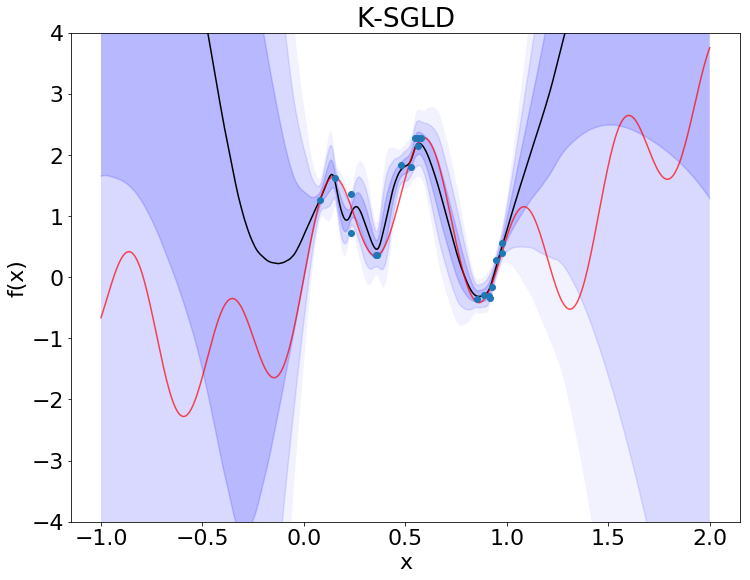

In [13]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.15)
plt.plot(grid,lower2,'blue',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid,lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('K-SGLD')

### KSGFS

In [8]:
import torch

from torch import nn
import torch.nn.functional as F
import numpy as np

import ksgfs

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3

# learning_rates = [5e-2]
# learning_rates = [8e-3, 7e-3]
# learning_rates = [4e-2]
# learning_rates = [8e-3]
# learning_rates = [1e-3]
# learning_rates = [1e-3, 1e-4]
# learning_rates = [5e-3, 4e-3, 2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4]
# learning_rates = [3e-5]
# learning_rates = [1e-4, 1e-5, 1e-6]
# learning_rates = [7e-4, 6e-4, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4, 9e-5, 8e-5, 7e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
learning_rates = [3e-4]

batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# grid_search = True
grid_search = False

rmse_result = np.zeros((1,len(learning_rates)))

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgfs = torch.zeros(400,1)
    predictions_val = torch.zeros(20,1)
    t = 1.

    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*0.0009))*criterion(output, y)
        loss.backward()
        optim.step()



        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                if grid_search:
                    output = network(val)
                    predictions_val = torch.cat((predictions_val, output), 1)
                    rmse_result[:,i] = torch.sqrt(criterion(val_label, torch.mean(predictions_val,1).view(-1,1)))
                else:    
                    output = network(x_test)
                    predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)
            

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 17541.4043
Epoch 1 - loss: 15326.4453
Epoch 2 - loss: 12783.4092
Epoch 3 - loss: 12167.7695
Epoch 4 - loss: 9673.0459
Epoch 5 - loss: 9152.2354
Epoch 6 - loss: 8136.0557
Epoch 7 - loss: 7770.5674
Epoch 8 - loss: 7505.3408
Epoch 9 - loss: 7131.9502
Epoch 10 - loss: 6861.9517
Epoch 11 - loss: 6559.3618
Epoch 12 - loss: 6418.7148
Epoch 13 - loss: 5980.8862
Epoch 14 - loss: 5808.3442
Epoch 15 - loss: 5861.3428
Epoch 16 - loss: 5425.1035
Epoch 17 - loss: 5303.1289
Epoch 18 - loss: 4849.0103
Epoch 19 - loss: 4670.7397
Epoch 20 - loss: 4479.7012
Epoch 21 - loss: 4316.8389
Epoch 22 - loss: 4221.2822
Epoch 23 - loss: 4153.2427
Epoch 24 - loss: 3989.8613
Epoch 25 - loss: 3951.5305
Epoch 26 - loss: 3811.9797
Epoch 27 - loss: 3803.8657
Epoch 28 - loss: 3659.3511
Epoch 29 - loss: 3494.0366
Epoch 30 - loss: 3452.9714
Epoch 31 - loss: 3463.8210
Epoch 32 - loss: 3304.7273
Epoch 33 - loss: 3285.8469
Epoch 34 - loss: 3150.4033
Epoch 35 - loss: 3163.3604
Epoch 36 - loss: 3011.9980
Epoch 3

Epoch 312 - loss: 230.8430
Epoch 313 - loss: 237.1284
Epoch 314 - loss: 229.5363
Epoch 315 - loss: 240.6788
Epoch 316 - loss: 243.8160
Epoch 317 - loss: 239.1648
Epoch 318 - loss: 236.1340
Epoch 319 - loss: 231.1323
Epoch 320 - loss: 233.2492
Epoch 321 - loss: 232.1469
Epoch 322 - loss: 232.4865
Epoch 323 - loss: 227.2538
Epoch 324 - loss: 227.8961
Epoch 325 - loss: 233.2226
Epoch 326 - loss: 228.2045
Epoch 327 - loss: 227.7263
Epoch 328 - loss: 230.9956
Epoch 329 - loss: 229.2077
Epoch 330 - loss: 226.4312
Epoch 331 - loss: 227.8526
Epoch 332 - loss: 228.4539
Epoch 333 - loss: 229.8742
Epoch 334 - loss: 227.2420
Epoch 335 - loss: 226.3257
Epoch 336 - loss: 224.8867
Epoch 337 - loss: 237.5005
Epoch 338 - loss: 224.8291
Epoch 339 - loss: 223.9416
Epoch 340 - loss: 224.4524
Epoch 341 - loss: 232.6662
Epoch 342 - loss: 225.6165
Epoch 343 - loss: 224.0495
Epoch 344 - loss: 221.3391
Epoch 345 - loss: 232.7832
Epoch 346 - loss: 222.5226
Epoch 347 - loss: 245.2672
Epoch 348 - loss: 226.7448
E

Epoch 623 - loss: 198.8329
Epoch 624 - loss: 195.0713
Epoch 625 - loss: 202.2910
Epoch 626 - loss: 197.7526
Epoch 627 - loss: 197.9496
Epoch 628 - loss: 200.8194
Epoch 629 - loss: 199.4515
Epoch 630 - loss: 192.8511
Epoch 631 - loss: 194.0522
Epoch 632 - loss: 194.8650
Epoch 633 - loss: 194.9600
Epoch 634 - loss: 195.6182
Epoch 635 - loss: 195.9349
Epoch 636 - loss: 193.0326
Epoch 637 - loss: 195.2121
Epoch 638 - loss: 196.1697
Epoch 639 - loss: 194.7428
Epoch 640 - loss: 192.5957
Epoch 641 - loss: 196.8724
Epoch 642 - loss: 198.4496
Epoch 643 - loss: 195.7372
Epoch 644 - loss: 195.3956
Epoch 645 - loss: 196.7045
Epoch 646 - loss: 193.6837
Epoch 647 - loss: 200.3018
Epoch 648 - loss: 197.8261
Epoch 649 - loss: 199.4428
Epoch 650 - loss: 196.9413
Epoch 651 - loss: 193.8018
Epoch 652 - loss: 193.9459
Epoch 653 - loss: 196.1426
Epoch 654 - loss: 193.9990
Epoch 655 - loss: 196.2502
Epoch 656 - loss: 191.0672
Epoch 657 - loss: 194.0658
Epoch 658 - loss: 221.2227
Epoch 659 - loss: 219.9137
E

Epoch 927 - loss: 190.4695
Epoch 928 - loss: 188.2644
Epoch 929 - loss: 188.7690
Epoch 930 - loss: 190.4766
Epoch 931 - loss: 205.3759
Epoch 932 - loss: 191.6911
Epoch 933 - loss: 189.6129
Epoch 934 - loss: 189.3714
Epoch 935 - loss: 191.8917
Epoch 936 - loss: 194.0656
Epoch 937 - loss: 196.3063
Epoch 938 - loss: 198.2623
Epoch 939 - loss: 196.0430
Epoch 940 - loss: 190.0816
Epoch 941 - loss: 190.9184
Epoch 942 - loss: 192.7073
Epoch 943 - loss: 191.3341
Epoch 944 - loss: 191.3622
Epoch 945 - loss: 192.8479
Epoch 946 - loss: 190.2937
Epoch 947 - loss: 188.7067
Epoch 948 - loss: 188.8579
Epoch 949 - loss: 201.5642
Epoch 950 - loss: 201.9555
Epoch 951 - loss: 234.0095
Epoch 952 - loss: 303.4535
Epoch 953 - loss: 364.6578
Epoch 954 - loss: 274.4328
Epoch 955 - loss: 201.9128
Epoch 956 - loss: 222.6483
Epoch 957 - loss: 193.1243
Epoch 958 - loss: 197.2639
Epoch 959 - loss: 190.2609
Epoch 960 - loss: 191.9841
Epoch 961 - loss: 192.1983
Epoch 962 - loss: 190.9587
Epoch 963 - loss: 191.6891
E

Epoch 1236 - loss: 181.7365
Epoch 1237 - loss: 182.3912
Epoch 1238 - loss: 183.8866
Epoch 1239 - loss: 185.6485
Epoch 1240 - loss: 184.5750
Epoch 1241 - loss: 182.7348
Epoch 1242 - loss: 184.5498
Epoch 1243 - loss: 185.7357
Epoch 1244 - loss: 187.2467
Epoch 1245 - loss: 188.0381
Epoch 1246 - loss: 185.0382
Epoch 1247 - loss: 190.2193
Epoch 1248 - loss: 186.4245
Epoch 1249 - loss: 192.4211
Epoch 1250 - loss: 190.6420
Epoch 1251 - loss: 182.6509
Epoch 1252 - loss: 178.9271
Epoch 1253 - loss: 180.2914
Epoch 1254 - loss: 181.3701
Epoch 1255 - loss: 183.0615
Epoch 1256 - loss: 190.4735
Epoch 1257 - loss: 190.2028
Epoch 1258 - loss: 181.9013
Epoch 1259 - loss: 182.8770
Epoch 1260 - loss: 183.6535
Epoch 1261 - loss: 180.6119
Epoch 1262 - loss: 185.6194
Epoch 1263 - loss: 187.0596
Epoch 1264 - loss: 187.4805
Epoch 1265 - loss: 295.4214
Epoch 1266 - loss: 238.6837
Epoch 1267 - loss: 209.4779
Epoch 1268 - loss: 184.5717
Epoch 1269 - loss: 186.0831
Epoch 1270 - loss: 185.4148
Epoch 1271 - loss: 1

Epoch 1538 - loss: 180.2007
Epoch 1539 - loss: 183.9617
Epoch 1540 - loss: 201.4247
Epoch 1541 - loss: 198.0344
Epoch 1542 - loss: 183.4113
Epoch 1543 - loss: 181.7443
Epoch 1544 - loss: 181.0251
Epoch 1545 - loss: 191.2481
Epoch 1546 - loss: 186.2003
Epoch 1547 - loss: 181.7766
Epoch 1548 - loss: 185.1525
Epoch 1549 - loss: 182.2409
Epoch 1550 - loss: 183.1751
Epoch 1551 - loss: 227.1552
Epoch 1552 - loss: 184.4090
Epoch 1553 - loss: 182.2661
Epoch 1554 - loss: 182.1524
Epoch 1555 - loss: 182.4391
Epoch 1556 - loss: 181.8249
Epoch 1557 - loss: 178.8692
Epoch 1558 - loss: 179.3328
Epoch 1559 - loss: 180.7719
Epoch 1560 - loss: 180.9346
Epoch 1561 - loss: 180.0927
Epoch 1562 - loss: 181.9064
Epoch 1563 - loss: 185.5758
Epoch 1564 - loss: 189.9141
Epoch 1565 - loss: 186.7411
Epoch 1566 - loss: 182.3786
Epoch 1567 - loss: 183.6308
Epoch 1568 - loss: 182.2009
Epoch 1569 - loss: 184.1290
Epoch 1570 - loss: 183.2588
Epoch 1571 - loss: 189.4530
Epoch 1572 - loss: 197.7568
Epoch 1573 - loss: 1

Epoch 1832 - loss: 179.9765
Epoch 1833 - loss: 180.6534
Epoch 1834 - loss: 183.0706
Epoch 1835 - loss: 182.5135
Epoch 1836 - loss: 181.4258
Epoch 1837 - loss: 185.3983
Epoch 1838 - loss: 178.4815
Epoch 1839 - loss: 176.3276
Epoch 1840 - loss: 175.2924
Epoch 1841 - loss: 176.0530
Epoch 1842 - loss: 177.8179
Epoch 1843 - loss: 174.7465
Epoch 1844 - loss: 177.8469
Epoch 1845 - loss: 177.0892
Epoch 1846 - loss: 195.0558
Epoch 1847 - loss: 182.5784
Epoch 1848 - loss: 180.5972
Epoch 1849 - loss: 183.4308
Epoch 1850 - loss: 183.6945
Epoch 1851 - loss: 181.2560
Epoch 1852 - loss: 178.8413
Epoch 1853 - loss: 176.4064
Epoch 1854 - loss: 179.8145
Epoch 1855 - loss: 174.4190
Epoch 1856 - loss: 179.1921
Epoch 1857 - loss: 175.7895
Epoch 1858 - loss: 178.8035
Epoch 1859 - loss: 178.7309
Epoch 1860 - loss: 179.0671
Epoch 1861 - loss: 181.1861
Epoch 1862 - loss: 186.4785
Epoch 1863 - loss: 179.3337
Epoch 1864 - loss: 178.2065
Epoch 1865 - loss: 204.9300
Epoch 1866 - loss: 180.2441
Epoch 1867 - loss: 1

Epoch 2145 - loss: 201.3295
Epoch 2146 - loss: 254.6220
Epoch 2147 - loss: 220.9883
Epoch 2148 - loss: 196.7794
Epoch 2149 - loss: 176.7837
Epoch 2150 - loss: 184.3675
Epoch 2151 - loss: 182.1605
Epoch 2152 - loss: 176.8828
Epoch 2153 - loss: 186.0451
Epoch 2154 - loss: 187.4676
Epoch 2155 - loss: 199.1080
Epoch 2156 - loss: 173.5685
Epoch 2157 - loss: 176.9397
Epoch 2158 - loss: 172.1296
Epoch 2159 - loss: 174.0511
Epoch 2160 - loss: 175.0341
Epoch 2161 - loss: 179.1397
Epoch 2162 - loss: 175.9309
Epoch 2163 - loss: 178.0683
Epoch 2164 - loss: 186.2413
Epoch 2165 - loss: 177.6401
Epoch 2166 - loss: 175.7192
Epoch 2167 - loss: 177.0940
Epoch 2168 - loss: 179.9290
Epoch 2169 - loss: 177.3800
Epoch 2170 - loss: 178.1403
Epoch 2171 - loss: 175.1173
Epoch 2172 - loss: 178.4553
Epoch 2173 - loss: 174.9271
Epoch 2174 - loss: 174.3034
Epoch 2175 - loss: 177.1736
Epoch 2176 - loss: 172.2112
Epoch 2177 - loss: 173.9480
Epoch 2178 - loss: 174.0610
Epoch 2179 - loss: 176.3092
Epoch 2180 - loss: 1

Epoch 2443 - loss: 209.7977
Epoch 2444 - loss: 197.0200
Epoch 2445 - loss: 180.6364
Epoch 2446 - loss: 181.0761
Epoch 2447 - loss: 173.3772
Epoch 2448 - loss: 171.7466
Epoch 2449 - loss: 177.7723
Epoch 2450 - loss: 183.6341
Epoch 2451 - loss: 172.8931
Epoch 2452 - loss: 172.2713
Epoch 2453 - loss: 174.3006
Epoch 2454 - loss: 196.9454
Epoch 2455 - loss: 174.6325
Epoch 2456 - loss: 174.6955
Epoch 2457 - loss: 172.4641
Epoch 2458 - loss: 171.7780
Epoch 2459 - loss: 172.1139
Epoch 2460 - loss: 173.0478
Epoch 2461 - loss: 169.6707
Epoch 2462 - loss: 170.6034
Epoch 2463 - loss: 174.4729
Epoch 2464 - loss: 174.2492
Epoch 2465 - loss: 170.3575
Epoch 2466 - loss: 168.2121
Epoch 2467 - loss: 169.0884
Epoch 2468 - loss: 169.6456
Epoch 2469 - loss: 167.8769
Epoch 2470 - loss: 167.5700
Epoch 2471 - loss: 174.4127
Epoch 2472 - loss: 170.4750
Epoch 2473 - loss: 168.1603
Epoch 2474 - loss: 167.7947
Epoch 2475 - loss: 165.2929
Epoch 2476 - loss: 168.3392
Epoch 2477 - loss: 166.5328
Epoch 2478 - loss: 1

Epoch 2739 - loss: 278.3779
Epoch 2740 - loss: 180.8405
Epoch 2741 - loss: 172.2473
Epoch 2742 - loss: 169.2012
Epoch 2743 - loss: 166.8580
Epoch 2744 - loss: 167.4943
Epoch 2745 - loss: 196.5975
Epoch 2746 - loss: 193.6099
Epoch 2747 - loss: 172.3504
Epoch 2748 - loss: 166.8184
Epoch 2749 - loss: 166.2563
Epoch 2750 - loss: 164.3957
Epoch 2751 - loss: 165.5899
Epoch 2752 - loss: 162.4008
Epoch 2753 - loss: 161.7197
Epoch 2754 - loss: 162.7204
Epoch 2755 - loss: 161.2165
Epoch 2756 - loss: 162.0541
Epoch 2757 - loss: 165.0649
Epoch 2758 - loss: 166.4417
Epoch 2759 - loss: 164.5432
Epoch 2760 - loss: 168.7181
Epoch 2761 - loss: 165.1834
Epoch 2762 - loss: 162.8643
Epoch 2763 - loss: 176.3112
Epoch 2764 - loss: 170.1520
Epoch 2765 - loss: 167.7804
Epoch 2766 - loss: 166.4064
Epoch 2767 - loss: 161.6471
Epoch 2768 - loss: 164.9370
Epoch 2769 - loss: 163.4006
Epoch 2770 - loss: 165.2909
Epoch 2771 - loss: 166.2414
Epoch 2772 - loss: 168.8371
Epoch 2773 - loss: 168.1314
Epoch 2774 - loss: 1

Epoch 3034 - loss: 239.7402
Epoch 3035 - loss: 235.8017
Epoch 3036 - loss: 237.2226
Epoch 3037 - loss: 235.5200
Epoch 3038 - loss: 238.5423
Epoch 3039 - loss: 233.8491
Epoch 3040 - loss: 233.1358
Epoch 3041 - loss: 231.5423
Epoch 3042 - loss: 230.9823
Epoch 3043 - loss: 233.9675
Epoch 3044 - loss: 234.5703
Epoch 3045 - loss: 229.5831
Epoch 3046 - loss: 232.4189
Epoch 3047 - loss: 233.3346
Epoch 3048 - loss: 227.3256
Epoch 3049 - loss: 228.6300
Epoch 3050 - loss: 228.7702
Epoch 3051 - loss: 231.2424
Epoch 3052 - loss: 230.1064
Epoch 3053 - loss: 236.3130
Epoch 3054 - loss: 231.9483
Epoch 3055 - loss: 236.4346
Epoch 3056 - loss: 231.5598
Epoch 3057 - loss: 236.4275
Epoch 3058 - loss: 229.6908
Epoch 3059 - loss: 224.1275
Epoch 3060 - loss: 219.8180
Epoch 3061 - loss: 220.4407
Epoch 3062 - loss: 237.9467
Epoch 3063 - loss: 230.3262
Epoch 3064 - loss: 220.7826
Epoch 3065 - loss: 231.5741
Epoch 3066 - loss: 222.7868
Epoch 3067 - loss: 220.7191
Epoch 3068 - loss: 222.5736
Epoch 3069 - loss: 2

Epoch 3332 - loss: 174.9311
Epoch 3333 - loss: 177.6902
Epoch 3334 - loss: 175.0856
Epoch 3335 - loss: 178.4206
Epoch 3336 - loss: 180.7448
Epoch 3337 - loss: 178.6439
Epoch 3338 - loss: 180.5761
Epoch 3339 - loss: 178.8650
Epoch 3340 - loss: 175.5352
Epoch 3341 - loss: 177.7633
Epoch 3342 - loss: 178.1824
Epoch 3343 - loss: 177.3290
Epoch 3344 - loss: 174.0135
Epoch 3345 - loss: 174.2052
Epoch 3346 - loss: 176.2819
Epoch 3347 - loss: 174.9328
Epoch 3348 - loss: 175.5038
Epoch 3349 - loss: 175.7479
Epoch 3350 - loss: 175.8311
Epoch 3351 - loss: 176.3601
Epoch 3352 - loss: 174.0511
Epoch 3353 - loss: 184.2142
Epoch 3354 - loss: 178.2833
Epoch 3355 - loss: 176.3893
Epoch 3356 - loss: 174.5585
Epoch 3357 - loss: 174.2935
Epoch 3358 - loss: 175.7787
Epoch 3359 - loss: 179.5770
Epoch 3360 - loss: 175.9130
Epoch 3361 - loss: 180.5133
Epoch 3362 - loss: 175.6929
Epoch 3363 - loss: 178.3859
Epoch 3364 - loss: 175.9261
Epoch 3365 - loss: 176.5921
Epoch 3366 - loss: 177.3489
Epoch 3367 - loss: 1

Epoch 3640 - loss: 168.8890
Epoch 3641 - loss: 178.4827
Epoch 3642 - loss: 172.8649
Epoch 3643 - loss: 168.4321
Epoch 3644 - loss: 166.0382
Epoch 3645 - loss: 169.3280
Epoch 3646 - loss: 170.4044
Epoch 3647 - loss: 174.6586
Epoch 3648 - loss: 176.7398
Epoch 3649 - loss: 174.6168
Epoch 3650 - loss: 166.7555
Epoch 3651 - loss: 171.4468
Epoch 3652 - loss: 171.6814
Epoch 3653 - loss: 169.2607
Epoch 3654 - loss: 168.5450
Epoch 3655 - loss: 169.5013
Epoch 3656 - loss: 174.2426
Epoch 3657 - loss: 213.1089
Epoch 3658 - loss: 182.9749
Epoch 3659 - loss: 182.8621
Epoch 3660 - loss: 177.5190
Epoch 3661 - loss: 171.1732
Epoch 3662 - loss: 169.3696
Epoch 3663 - loss: 166.5096
Epoch 3664 - loss: 164.8939
Epoch 3665 - loss: 171.6825
Epoch 3666 - loss: 168.5988
Epoch 3667 - loss: 170.1655
Epoch 3668 - loss: 171.3791
Epoch 3669 - loss: 166.2758
Epoch 3670 - loss: 166.8893
Epoch 3671 - loss: 170.9950
Epoch 3672 - loss: 169.6731
Epoch 3673 - loss: 175.1403
Epoch 3674 - loss: 169.1507
Epoch 3675 - loss: 1

Epoch 3947 - loss: 168.3701
Epoch 3948 - loss: 206.2341
Epoch 3949 - loss: 164.6463
Epoch 3950 - loss: 165.9529
Epoch 3951 - loss: 171.9026
Epoch 3952 - loss: 168.6193
Epoch 3953 - loss: 165.3003
Epoch 3954 - loss: 163.2354
Epoch 3955 - loss: 167.0219
Epoch 3956 - loss: 164.9681
Epoch 3957 - loss: 165.6163
Epoch 3958 - loss: 170.9676
Epoch 3959 - loss: 165.6829
Epoch 3960 - loss: 167.9285
Epoch 3961 - loss: 166.5405
Epoch 3962 - loss: 164.0534
Epoch 3963 - loss: 165.3263
Epoch 3964 - loss: 170.9287
Epoch 3965 - loss: 181.8485
Epoch 3966 - loss: 168.7784
Epoch 3967 - loss: 163.0035
Epoch 3968 - loss: 164.7939
Epoch 3969 - loss: 163.5940
Epoch 3970 - loss: 163.7705
Epoch 3971 - loss: 162.8951
Epoch 3972 - loss: 160.2943
Epoch 3973 - loss: 160.9718
Epoch 3974 - loss: 162.9855
Epoch 3975 - loss: 164.8769
Epoch 3976 - loss: 162.8856
Epoch 3977 - loss: 169.6330
Epoch 3978 - loss: 171.4428
Epoch 3979 - loss: 165.6188
Epoch 3980 - loss: 163.4133
Epoch 3981 - loss: 167.3692
Epoch 3982 - loss: 1

Epoch 4259 - loss: 160.7406
Epoch 4260 - loss: 164.0983
Epoch 4261 - loss: 180.6640
Epoch 4262 - loss: 200.3537
Epoch 4263 - loss: 190.1687
Epoch 4264 - loss: 182.9814
Epoch 4265 - loss: 182.5397
Epoch 4266 - loss: 164.2671
Epoch 4267 - loss: 162.8858
Epoch 4268 - loss: 160.2284
Epoch 4269 - loss: 157.5207
Epoch 4270 - loss: 159.7731
Epoch 4271 - loss: 161.8037
Epoch 4272 - loss: 182.2670
Epoch 4273 - loss: 165.2280
Epoch 4274 - loss: 162.4368
Epoch 4275 - loss: 157.0749
Epoch 4276 - loss: 158.2584
Epoch 4277 - loss: 158.7003
Epoch 4278 - loss: 159.5242
Epoch 4279 - loss: 159.2843
Epoch 4280 - loss: 163.3192
Epoch 4281 - loss: 161.4380
Epoch 4282 - loss: 164.9512
Epoch 4283 - loss: 163.4381
Epoch 4284 - loss: 162.9449
Epoch 4285 - loss: 170.1638
Epoch 4286 - loss: 159.7955
Epoch 4287 - loss: 170.5508
Epoch 4288 - loss: 168.6164
Epoch 4289 - loss: 374.4629
Epoch 4290 - loss: 547.1595
Epoch 4291 - loss: 1803.4802
Epoch 4292 - loss: 827.4523
Epoch 4293 - loss: 514.1282
Epoch 4294 - loss: 

Epoch 4566 - loss: 164.0867
Epoch 4567 - loss: 166.6297
Epoch 4568 - loss: 195.4311
Epoch 4569 - loss: 164.2697
Epoch 4570 - loss: 163.7766
Epoch 4571 - loss: 162.7242
Epoch 4572 - loss: 157.6322
Epoch 4573 - loss: 161.2209
Epoch 4574 - loss: 166.0856
Epoch 4575 - loss: 164.4349
Epoch 4576 - loss: 172.3025
Epoch 4577 - loss: 165.1207
Epoch 4578 - loss: 166.5865
Epoch 4579 - loss: 159.3176
Epoch 4580 - loss: 166.1641
Epoch 4581 - loss: 180.4706
Epoch 4582 - loss: 176.3069
Epoch 4583 - loss: 168.2592
Epoch 4584 - loss: 166.5709
Epoch 4585 - loss: 160.3764
Epoch 4586 - loss: 158.7685
Epoch 4587 - loss: 156.1928
Epoch 4588 - loss: 157.1134
Epoch 4589 - loss: 159.9673
Epoch 4590 - loss: 165.6177
Epoch 4591 - loss: 158.8786
Epoch 4592 - loss: 160.5389
Epoch 4593 - loss: 179.7308
Epoch 4594 - loss: 174.9100
Epoch 4595 - loss: 161.6371
Epoch 4596 - loss: 160.3187
Epoch 4597 - loss: 160.1548
Epoch 4598 - loss: 161.0707
Epoch 4599 - loss: 161.2062
Epoch 4600 - loss: 160.0296
Epoch 4601 - loss: 1

Epoch 4863 - loss: 158.1706
Epoch 4864 - loss: 184.5821
Epoch 4865 - loss: 156.4544
Epoch 4866 - loss: 155.9644
Epoch 4867 - loss: 158.6403
Epoch 4868 - loss: 158.4561
Epoch 4869 - loss: 155.4770
Epoch 4870 - loss: 155.5359
Epoch 4871 - loss: 159.7501
Epoch 4872 - loss: 163.5065
Epoch 4873 - loss: 155.4017
Epoch 4874 - loss: 165.4897
Epoch 4875 - loss: 155.1890
Epoch 4876 - loss: 157.2631
Epoch 4877 - loss: 155.3810
Epoch 4878 - loss: 154.9946
Epoch 4879 - loss: 153.4811
Epoch 4880 - loss: 154.2882
Epoch 4881 - loss: 155.6675
Epoch 4882 - loss: 154.8961
Epoch 4883 - loss: 154.1497
Epoch 4884 - loss: 153.2110
Epoch 4885 - loss: 158.3565
Epoch 4886 - loss: 152.3714
Epoch 4887 - loss: 157.2510
Epoch 4888 - loss: 154.9388
Epoch 4889 - loss: 154.4307
Epoch 4890 - loss: 154.3206
Epoch 4891 - loss: 153.6359
Epoch 4892 - loss: 153.7126
Epoch 4893 - loss: 155.6111
Epoch 4894 - loss: 171.7420
Epoch 4895 - loss: 160.0207
Epoch 4896 - loss: 156.9881
Epoch 4897 - loss: 153.8129
Epoch 4898 - loss: 1

Epoch 5165 - loss: 193.4285
Epoch 5166 - loss: 194.9950
Epoch 5167 - loss: 195.9754
Epoch 5168 - loss: 194.8071
Epoch 5169 - loss: 193.5504
Epoch 5170 - loss: 194.5897
Epoch 5171 - loss: 195.9303
Epoch 5172 - loss: 199.1814
Epoch 5173 - loss: 195.9262
Epoch 5174 - loss: 203.9261
Epoch 5175 - loss: 196.0612
Epoch 5176 - loss: 187.1908
Epoch 5177 - loss: 187.2820
Epoch 5178 - loss: 187.6088
Epoch 5179 - loss: 189.5036
Epoch 5180 - loss: 187.5508
Epoch 5181 - loss: 184.8436
Epoch 5182 - loss: 192.4902
Epoch 5183 - loss: 185.5813
Epoch 5184 - loss: 188.0102
Epoch 5185 - loss: 184.0726
Epoch 5186 - loss: 188.2168
Epoch 5187 - loss: 184.3095
Epoch 5188 - loss: 183.3171
Epoch 5189 - loss: 183.7094
Epoch 5190 - loss: 182.3761
Epoch 5191 - loss: 184.8929
Epoch 5192 - loss: 182.1672
Epoch 5193 - loss: 182.2949
Epoch 5194 - loss: 182.7024
Epoch 5195 - loss: 183.2055
Epoch 5196 - loss: 200.3599
Epoch 5197 - loss: 191.4264
Epoch 5198 - loss: 185.1518
Epoch 5199 - loss: 180.8668
Epoch 5200 - loss: 1

Epoch 5470 - loss: 158.0289
Epoch 5471 - loss: 157.3485
Epoch 5472 - loss: 169.2905
Epoch 5473 - loss: 156.9489
Epoch 5474 - loss: 152.4725
Epoch 5475 - loss: 149.5587
Epoch 5476 - loss: 156.4753
Epoch 5477 - loss: 154.0217
Epoch 5478 - loss: 151.7036
Epoch 5479 - loss: 150.1208
Epoch 5480 - loss: 152.6968
Epoch 5481 - loss: 154.6941
Epoch 5482 - loss: 153.8174
Epoch 5483 - loss: 149.7147
Epoch 5484 - loss: 147.9833
Epoch 5485 - loss: 153.4397
Epoch 5486 - loss: 148.4381
Epoch 5487 - loss: 156.9727
Epoch 5488 - loss: 156.3911
Epoch 5489 - loss: 168.6851
Epoch 5490 - loss: 151.7231
Epoch 5491 - loss: 152.0968
Epoch 5492 - loss: 150.4749
Epoch 5493 - loss: 151.3866
Epoch 5494 - loss: 151.0823
Epoch 5495 - loss: 149.2044
Epoch 5496 - loss: 153.6861
Epoch 5497 - loss: 149.3072
Epoch 5498 - loss: 151.1009
Epoch 5499 - loss: 152.0459
Epoch 5500 - loss: 151.4082
Epoch 5501 - loss: 149.5487
Epoch 5502 - loss: 149.2014
Epoch 5503 - loss: 148.6801
Epoch 5504 - loss: 151.3364
Epoch 5505 - loss: 1

Epoch 5764 - loss: 149.2363
Epoch 5765 - loss: 150.3775
Epoch 5766 - loss: 152.3539
Epoch 5767 - loss: 148.9236
Epoch 5768 - loss: 146.8384
Epoch 5769 - loss: 148.6084
Epoch 5770 - loss: 148.7687
Epoch 5771 - loss: 148.7234
Epoch 5772 - loss: 146.8804
Epoch 5773 - loss: 148.4893
Epoch 5774 - loss: 148.7164
Epoch 5775 - loss: 150.1018
Epoch 5776 - loss: 152.8526
Epoch 5777 - loss: 150.5533
Epoch 5778 - loss: 149.1365
Epoch 5779 - loss: 146.7723
Epoch 5780 - loss: 146.2457
Epoch 5781 - loss: 147.6802
Epoch 5782 - loss: 152.6140
Epoch 5783 - loss: 147.0996
Epoch 5784 - loss: 148.3834
Epoch 5785 - loss: 146.7450
Epoch 5786 - loss: 152.0515
Epoch 5787 - loss: 150.4003
Epoch 5788 - loss: 149.7901
Epoch 5789 - loss: 147.8283
Epoch 5790 - loss: 146.9717
Epoch 5791 - loss: 147.6564
Epoch 5792 - loss: 149.9188
Epoch 5793 - loss: 158.6080
Epoch 5794 - loss: 151.1848
Epoch 5795 - loss: 147.4733
Epoch 5796 - loss: 146.5930
Epoch 5797 - loss: 147.9952
Epoch 5798 - loss: 147.1990
Epoch 5799 - loss: 1

Epoch 6061 - loss: 155.1175
Epoch 6062 - loss: 154.8224
Epoch 6063 - loss: 155.3295
Epoch 6064 - loss: 165.2872
Epoch 6065 - loss: 159.9002
Epoch 6066 - loss: 162.1478
Epoch 6067 - loss: 183.7779
Epoch 6068 - loss: 174.0897
Epoch 6069 - loss: 158.3726
Epoch 6070 - loss: 162.8959
Epoch 6071 - loss: 159.1938
Epoch 6072 - loss: 165.7328
Epoch 6073 - loss: 153.0614
Epoch 6074 - loss: 156.3474
Epoch 6075 - loss: 151.2778
Epoch 6076 - loss: 153.8354
Epoch 6077 - loss: 156.5029
Epoch 6078 - loss: 153.9609
Epoch 6079 - loss: 153.1118
Epoch 6080 - loss: 150.9301
Epoch 6081 - loss: 151.4990
Epoch 6082 - loss: 149.1699
Epoch 6083 - loss: 149.3886
Epoch 6084 - loss: 160.0771
Epoch 6085 - loss: 152.6577
Epoch 6086 - loss: 150.0746
Epoch 6087 - loss: 149.4999
Epoch 6088 - loss: 153.4923
Epoch 6089 - loss: 149.7512
Epoch 6090 - loss: 149.0555
Epoch 6091 - loss: 149.8267
Epoch 6092 - loss: 148.6994
Epoch 6093 - loss: 151.0877
Epoch 6094 - loss: 150.4167
Epoch 6095 - loss: 147.7793
Epoch 6096 - loss: 1

Epoch 6368 - loss: 145.7999
Epoch 6369 - loss: 148.5211
Epoch 6370 - loss: 146.3079
Epoch 6371 - loss: 149.0766
Epoch 6372 - loss: 146.4399
Epoch 6373 - loss: 146.4272
Epoch 6374 - loss: 155.5655
Epoch 6375 - loss: 152.1138
Epoch 6376 - loss: 154.8388
Epoch 6377 - loss: 158.8373
Epoch 6378 - loss: 153.6403
Epoch 6379 - loss: 155.7553
Epoch 6380 - loss: 150.3629
Epoch 6381 - loss: 150.7876
Epoch 6382 - loss: 148.3096
Epoch 6383 - loss: 146.4349
Epoch 6384 - loss: 146.0808
Epoch 6385 - loss: 146.1583
Epoch 6386 - loss: 146.0621
Epoch 6387 - loss: 149.4045
Epoch 6388 - loss: 145.7227
Epoch 6389 - loss: 146.6128
Epoch 6390 - loss: 145.1046
Epoch 6391 - loss: 151.1210
Epoch 6392 - loss: 149.9567
Epoch 6393 - loss: 146.0440
Epoch 6394 - loss: 148.0057
Epoch 6395 - loss: 148.9078
Epoch 6396 - loss: 163.5498
Epoch 6397 - loss: 166.4666
Epoch 6398 - loss: 157.2793
Epoch 6399 - loss: 152.7480
Epoch 6400 - loss: 154.1880
Epoch 6401 - loss: 151.6669
Epoch 6402 - loss: 154.0689
Epoch 6403 - loss: 1

Epoch 6675 - loss: 150.3884
Epoch 6676 - loss: 151.7705
Epoch 6677 - loss: 189.4138
Epoch 6678 - loss: 211.2394
Epoch 6679 - loss: 198.0765
Epoch 6680 - loss: 159.5133
Epoch 6681 - loss: 171.9989
Epoch 6682 - loss: 153.5070
Epoch 6683 - loss: 152.9896
Epoch 6684 - loss: 151.9327
Epoch 6685 - loss: 175.3167
Epoch 6686 - loss: 169.0784
Epoch 6687 - loss: 189.5457
Epoch 6688 - loss: 149.6417
Epoch 6689 - loss: 164.9929
Epoch 6690 - loss: 149.4984
Epoch 6691 - loss: 150.3730
Epoch 6692 - loss: 163.7898
Epoch 6693 - loss: 156.7298
Epoch 6694 - loss: 155.1653
Epoch 6695 - loss: 145.4781
Epoch 6696 - loss: 145.3450
Epoch 6697 - loss: 147.2105
Epoch 6698 - loss: 147.2848
Epoch 6699 - loss: 145.7842
Epoch 6700 - loss: 146.1675
Epoch 6701 - loss: 151.6063
Epoch 6702 - loss: 148.6357
Epoch 6703 - loss: 148.6089
Epoch 6704 - loss: 155.8056
Epoch 6705 - loss: 153.4882
Epoch 6706 - loss: 168.3499
Epoch 6707 - loss: 151.6219
Epoch 6708 - loss: 147.5941
Epoch 6709 - loss: 150.0173
Epoch 6710 - loss: 1

Epoch 6970 - loss: 149.4888
Epoch 6971 - loss: 148.7485
Epoch 6972 - loss: 149.5597
Epoch 6973 - loss: 150.2585
Epoch 6974 - loss: 159.2270
Epoch 6975 - loss: 150.7551
Epoch 6976 - loss: 158.0628
Epoch 6977 - loss: 153.1628
Epoch 6978 - loss: 155.9092
Epoch 6979 - loss: 155.4738
Epoch 6980 - loss: 151.5223
Epoch 6981 - loss: 147.6129
Epoch 6982 - loss: 150.6125
Epoch 6983 - loss: 148.7240
Epoch 6984 - loss: 150.8993
Epoch 6985 - loss: 151.4735
Epoch 6986 - loss: 150.3349
Epoch 6987 - loss: 147.7103
Epoch 6988 - loss: 146.3045
Epoch 6989 - loss: 147.9411
Epoch 6990 - loss: 151.6530
Epoch 6991 - loss: 150.8784
Epoch 6992 - loss: 149.2992
Epoch 6993 - loss: 151.3015
Epoch 6994 - loss: 151.0096
Epoch 6995 - loss: 150.1930
Epoch 6996 - loss: 151.9724
Epoch 6997 - loss: 154.0885
Epoch 6998 - loss: 148.3031
Epoch 6999 - loss: 147.7874
Epoch 7000 - loss: 160.5788
Epoch 7001 - loss: 153.6241
Epoch 7002 - loss: 154.6808
Epoch 7003 - loss: 147.6113
Epoch 7004 - loss: 151.3583
Epoch 7005 - loss: 1

Epoch 7277 - loss: 142.7592
Epoch 7278 - loss: 157.5799
Epoch 7279 - loss: 151.0611
Epoch 7280 - loss: 147.8501
Epoch 7281 - loss: 146.2829
Epoch 7282 - loss: 150.2798
Epoch 7283 - loss: 151.1759
Epoch 7284 - loss: 154.0107
Epoch 7285 - loss: 149.3491
Epoch 7286 - loss: 151.1745
Epoch 7287 - loss: 145.5896
Epoch 7288 - loss: 143.2470
Epoch 7289 - loss: 142.6007
Epoch 7290 - loss: 144.2805
Epoch 7291 - loss: 144.5729
Epoch 7292 - loss: 142.6421
Epoch 7293 - loss: 143.5668
Epoch 7294 - loss: 144.1203
Epoch 7295 - loss: 144.3298
Epoch 7296 - loss: 143.0306
Epoch 7297 - loss: 147.1643
Epoch 7298 - loss: 147.0222
Epoch 7299 - loss: 145.3501
Epoch 7300 - loss: 143.8777
Epoch 7301 - loss: 146.8825
Epoch 7302 - loss: 146.8655
Epoch 7303 - loss: 145.3530
Epoch 7304 - loss: 143.3438
Epoch 7305 - loss: 142.7871
Epoch 7306 - loss: 142.9969
Epoch 7307 - loss: 146.3986
Epoch 7308 - loss: 147.4258
Epoch 7309 - loss: 145.8729
Epoch 7310 - loss: 147.3101
Epoch 7311 - loss: 146.2861
Epoch 7312 - loss: 1

Epoch 7586 - loss: 151.3159
Epoch 7587 - loss: 152.8059
Epoch 7588 - loss: 158.0683
Epoch 7589 - loss: 160.7063
Epoch 7590 - loss: 156.7736
Epoch 7591 - loss: 154.6508
Epoch 7592 - loss: 153.8082
Epoch 7593 - loss: 151.7839
Epoch 7594 - loss: 148.2846
Epoch 7595 - loss: 153.2310
Epoch 7596 - loss: 149.9607
Epoch 7597 - loss: 149.1989
Epoch 7598 - loss: 146.8433
Epoch 7599 - loss: 148.0072
Epoch 7600 - loss: 152.4814
Epoch 7601 - loss: 152.3990
Epoch 7602 - loss: 149.8079
Epoch 7603 - loss: 153.6741
Epoch 7604 - loss: 153.6011
Epoch 7605 - loss: 153.6529
Epoch 7606 - loss: 151.0572
Epoch 7607 - loss: 154.3692
Epoch 7608 - loss: 155.2008
Epoch 7609 - loss: 152.8948
Epoch 7610 - loss: 165.5474
Epoch 7611 - loss: 150.7145
Epoch 7612 - loss: 154.7298
Epoch 7613 - loss: 153.2667
Epoch 7614 - loss: 161.3546
Epoch 7615 - loss: 154.5123
Epoch 7616 - loss: 153.8398
Epoch 7617 - loss: 150.3276
Epoch 7618 - loss: 157.5442
Epoch 7619 - loss: 158.5242
Epoch 7620 - loss: 154.6269
Epoch 7621 - loss: 1

Epoch 7881 - loss: 154.4268
Epoch 7882 - loss: 148.3670
Epoch 7883 - loss: 148.2785
Epoch 7884 - loss: 159.7857
Epoch 7885 - loss: 147.2497
Epoch 7886 - loss: 157.3367
Epoch 7887 - loss: 154.8571
Epoch 7888 - loss: 221.9143
Epoch 7889 - loss: 168.8561
Epoch 7890 - loss: 153.4345
Epoch 7891 - loss: 146.5932
Epoch 7892 - loss: 147.7691
Epoch 7893 - loss: 146.7860
Epoch 7894 - loss: 146.2250
Epoch 7895 - loss: 142.4938
Epoch 7896 - loss: 143.5631
Epoch 7897 - loss: 143.6750
Epoch 7898 - loss: 144.2386
Epoch 7899 - loss: 148.4856
Epoch 7900 - loss: 145.4289
Epoch 7901 - loss: 146.9678
Epoch 7902 - loss: 146.9709
Epoch 7903 - loss: 148.4852
Epoch 7904 - loss: 143.7792
Epoch 7905 - loss: 148.1472
Epoch 7906 - loss: 148.3198
Epoch 7907 - loss: 154.0780
Epoch 7908 - loss: 149.0589
Epoch 7909 - loss: 148.6497
Epoch 7910 - loss: 147.9739
Epoch 7911 - loss: 149.9945
Epoch 7912 - loss: 146.0277
Epoch 7913 - loss: 149.4152
Epoch 7914 - loss: 143.6359
Epoch 7915 - loss: 145.1279
Epoch 7916 - loss: 1

Epoch 8174 - loss: 235.9393
Epoch 8175 - loss: 223.0706
Epoch 8176 - loss: 213.8408
Epoch 8177 - loss: 191.8538
Epoch 8178 - loss: 186.6015
Epoch 8179 - loss: 189.3641
Epoch 8180 - loss: 185.4850
Epoch 8181 - loss: 188.2684
Epoch 8182 - loss: 189.5378
Epoch 8183 - loss: 183.7791
Epoch 8184 - loss: 186.7764
Epoch 8185 - loss: 187.8813
Epoch 8186 - loss: 186.3103
Epoch 8187 - loss: 191.9863
Epoch 8188 - loss: 188.1243
Epoch 8189 - loss: 194.1517
Epoch 8190 - loss: 190.3947
Epoch 8191 - loss: 190.1178
Epoch 8192 - loss: 196.8862
Epoch 8193 - loss: 195.0944
Epoch 8194 - loss: 186.1637
Epoch 8195 - loss: 183.9353
Epoch 8196 - loss: 186.3883
Epoch 8197 - loss: 190.9317
Epoch 8198 - loss: 188.3253
Epoch 8199 - loss: 189.9565
Epoch 8200 - loss: 185.1096
Epoch 8201 - loss: 188.9312
Epoch 8202 - loss: 195.8288
Epoch 8203 - loss: 196.5824
Epoch 8204 - loss: 197.7990
Epoch 8205 - loss: 187.6466
Epoch 8206 - loss: 196.8685
Epoch 8207 - loss: 189.5192
Epoch 8208 - loss: 201.2601
Epoch 8209 - loss: 2

Epoch 8479 - loss: 148.5813
Epoch 8480 - loss: 149.3811
Epoch 8481 - loss: 147.0132
Epoch 8482 - loss: 146.4883
Epoch 8483 - loss: 149.6332
Epoch 8484 - loss: 150.7408
Epoch 8485 - loss: 149.8907
Epoch 8486 - loss: 146.6707
Epoch 8487 - loss: 147.5674
Epoch 8488 - loss: 150.2701
Epoch 8489 - loss: 148.1409
Epoch 8490 - loss: 151.6167
Epoch 8491 - loss: 147.6891
Epoch 8492 - loss: 147.2435
Epoch 8493 - loss: 147.9071
Epoch 8494 - loss: 153.8166
Epoch 8495 - loss: 152.6433
Epoch 8496 - loss: 159.8416
Epoch 8497 - loss: 167.5760
Epoch 8498 - loss: 153.0715
Epoch 8499 - loss: 152.1376
Epoch 8500 - loss: 150.7567
Epoch 8501 - loss: 149.8629
Epoch 8502 - loss: 150.5727
Epoch 8503 - loss: 151.3038
Epoch 8504 - loss: 154.5021
Epoch 8505 - loss: 151.3247
Epoch 8506 - loss: 157.2788
Epoch 8507 - loss: 157.1783
Epoch 8508 - loss: 155.8812
Epoch 8509 - loss: 151.1967
Epoch 8510 - loss: 149.2789
Epoch 8511 - loss: 152.6963
Epoch 8512 - loss: 152.7209
Epoch 8513 - loss: 150.7598
Epoch 8514 - loss: 1

Epoch 8786 - loss: 150.9307
Epoch 8787 - loss: 167.4324
Epoch 8788 - loss: 151.4695
Epoch 8789 - loss: 152.0161
Epoch 8790 - loss: 147.2986
Epoch 8791 - loss: 149.6927
Epoch 8792 - loss: 153.8192
Epoch 8793 - loss: 152.8099
Epoch 8794 - loss: 156.7570
Epoch 8795 - loss: 153.5183
Epoch 8796 - loss: 153.7900
Epoch 8797 - loss: 156.9297
Epoch 8798 - loss: 159.3011
Epoch 8799 - loss: 154.9483
Epoch 8800 - loss: 152.5048
Epoch 8801 - loss: 149.5935
Epoch 8802 - loss: 146.4959
Epoch 8803 - loss: 153.4641
Epoch 8804 - loss: 218.7905
Epoch 8805 - loss: 187.2718
Epoch 8806 - loss: 1202.6389
Epoch 8807 - loss: 583.9218
Epoch 8808 - loss: 256.8075
Epoch 8809 - loss: 220.6789
Epoch 8810 - loss: 170.1310
Epoch 8811 - loss: 163.4459
Epoch 8812 - loss: 159.7443
Epoch 8813 - loss: 155.7937
Epoch 8814 - loss: 152.9966
Epoch 8815 - loss: 153.6755
Epoch 8816 - loss: 160.5664
Epoch 8817 - loss: 192.0545
Epoch 8818 - loss: 181.8336
Epoch 8819 - loss: 163.7632
Epoch 8820 - loss: 153.9146
Epoch 8821 - loss: 

Epoch 9079 - loss: 162.9819
Epoch 9080 - loss: 252.1998
Epoch 9081 - loss: 196.3229
Epoch 9082 - loss: 161.6938
Epoch 9083 - loss: 155.7120
Epoch 9084 - loss: 151.6917
Epoch 9085 - loss: 154.4707
Epoch 9086 - loss: 152.7855
Epoch 9087 - loss: 150.7242
Epoch 9088 - loss: 151.6208
Epoch 9089 - loss: 152.4262
Epoch 9090 - loss: 151.3265
Epoch 9091 - loss: 170.5091
Epoch 9092 - loss: 184.3903
Epoch 9093 - loss: 168.5804
Epoch 9094 - loss: 159.0862
Epoch 9095 - loss: 156.0552
Epoch 9096 - loss: 190.0094
Epoch 9097 - loss: 172.3401
Epoch 9098 - loss: 160.8276
Epoch 9099 - loss: 162.6905
Epoch 9100 - loss: 160.3965
Epoch 9101 - loss: 154.1056
Epoch 9102 - loss: 153.6942
Epoch 9103 - loss: 154.2931
Epoch 9104 - loss: 155.0206
Epoch 9105 - loss: 155.8201
Epoch 9106 - loss: 156.0513
Epoch 9107 - loss: 155.5934
Epoch 9108 - loss: 156.9028
Epoch 9109 - loss: 152.9688
Epoch 9110 - loss: 159.8505
Epoch 9111 - loss: 157.0586
Epoch 9112 - loss: 157.7646
Epoch 9113 - loss: 156.0842
Epoch 9114 - loss: 3

Epoch 9384 - loss: 151.0835
Epoch 9385 - loss: 153.3355
Epoch 9386 - loss: 148.5946
Epoch 9387 - loss: 148.3592
Epoch 9388 - loss: 148.5599
Epoch 9389 - loss: 145.5740
Epoch 9390 - loss: 151.8911
Epoch 9391 - loss: 146.0475
Epoch 9392 - loss: 146.2939
Epoch 9393 - loss: 150.3517
Epoch 9394 - loss: 147.7066
Epoch 9395 - loss: 192.6266
Epoch 9396 - loss: 160.6579
Epoch 9397 - loss: 163.2219
Epoch 9398 - loss: 153.1706
Epoch 9399 - loss: 156.4113
Epoch 9400 - loss: 148.3779
Epoch 9401 - loss: 146.6761
Epoch 9402 - loss: 146.5809
Epoch 9403 - loss: 147.4424
Epoch 9404 - loss: 145.1494
Epoch 9405 - loss: 155.8961
Epoch 9406 - loss: 150.6418
Epoch 9407 - loss: 155.1944
Epoch 9408 - loss: 156.1537
Epoch 9409 - loss: 157.3705
Epoch 9410 - loss: 152.4869
Epoch 9411 - loss: 149.3833
Epoch 9412 - loss: 148.6416
Epoch 9413 - loss: 146.0771
Epoch 9414 - loss: 147.1805
Epoch 9415 - loss: 145.3801
Epoch 9416 - loss: 150.7634
Epoch 9417 - loss: 154.2085
Epoch 9418 - loss: 151.4794
Epoch 9419 - loss: 1

Epoch 9681 - loss: 148.3262
Epoch 9682 - loss: 147.8448
Epoch 9683 - loss: 148.0576
Epoch 9684 - loss: 151.3559
Epoch 9685 - loss: 149.9643
Epoch 9686 - loss: 147.4623
Epoch 9687 - loss: 144.8989
Epoch 9688 - loss: 150.5199
Epoch 9689 - loss: 148.6692
Epoch 9690 - loss: 148.3538
Epoch 9691 - loss: 146.5710
Epoch 9692 - loss: 146.0259
Epoch 9693 - loss: 147.8333
Epoch 9694 - loss: 145.2508
Epoch 9695 - loss: 153.1670
Epoch 9696 - loss: 148.0768
Epoch 9697 - loss: 148.2058
Epoch 9698 - loss: 145.3306
Epoch 9699 - loss: 145.7203
Epoch 9700 - loss: 151.5935
Epoch 9701 - loss: 151.7293
Epoch 9702 - loss: 149.0975
Epoch 9703 - loss: 146.4040
Epoch 9704 - loss: 146.5046
Epoch 9705 - loss: 148.2498
Epoch 9706 - loss: 145.9494
Epoch 9707 - loss: 146.7519
Epoch 9708 - loss: 146.7234
Epoch 9709 - loss: 153.4256
Epoch 9710 - loss: 145.0059
Epoch 9711 - loss: 143.1890
Epoch 9712 - loss: 144.5204
Epoch 9713 - loss: 147.3049
Epoch 9714 - loss: 148.1261
Epoch 9715 - loss: 145.1177
Epoch 9716 - loss: 1

Epoch 9985 - loss: 146.8412
Epoch 9986 - loss: 146.6139
Epoch 9987 - loss: 148.9059
Epoch 9988 - loss: 149.8346
Epoch 9989 - loss: 146.8074
Epoch 9990 - loss: 150.9295
Epoch 9991 - loss: 147.3780
Epoch 9992 - loss: 148.2126
Epoch 9993 - loss: 147.5361
Epoch 9994 - loss: 147.0964
Epoch 9995 - loss: 144.7958
Epoch 9996 - loss: 146.9171
Epoch 9997 - loss: 146.4751
Epoch 9998 - loss: 146.2343
Epoch 9999 - loss: 145.8960


In [14]:
rmse_result

array([[1.41716278, 1.45913982, 1.19654572, 1.36423647, 1.27173591,
        1.39705813, 1.22595346, 1.30362892, 1.35351932, 1.42422462,
        1.35474777, 1.55638599, 1.36653221, 1.46822345, 1.56005752,
        1.66697133]])

Text(0.5,1,'K-SGFS')

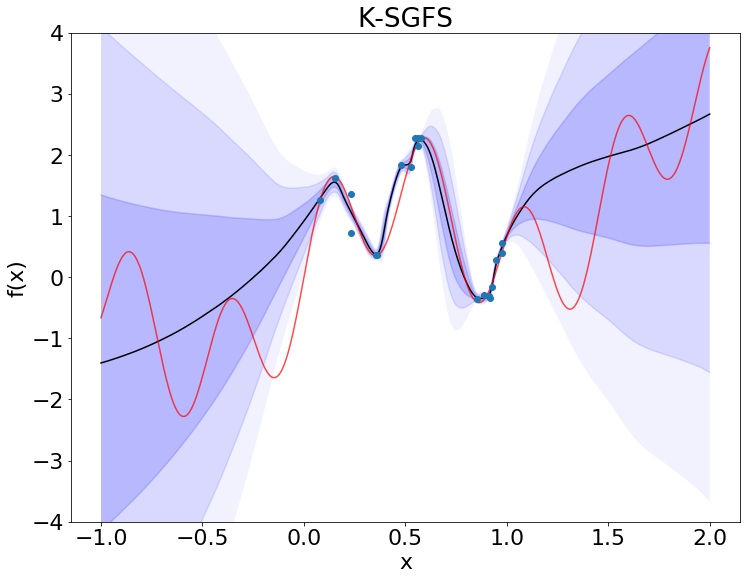

In [11]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'blue',alpha=0.1)
plt.plot(grid,upper1,'blue',alpha=0.15)
plt.plot(grid,lower1,'blue', alpha=0.15)
plt.plot(grid,lower2,'blue',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='blue', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='blue', alpha=0.1,interpolate=True)
plt.fill_between(grid,lower3, upper3, facecolor='blue', alpha=0.05,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('K-SGFS')